# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6211023161986997 -3.109387043490154
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [33]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [34]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [35]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [36]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [37]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [57]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs) # GAN using success rate
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:]) # Q-learning using max future rewards
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)# Policy gradient for state and action mapping
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [58]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [59]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [60]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [61]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [62]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [63]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:10.0000 rate:0.0200 gloss:-0.2032 dloss:1.1784 dlossR:0.5168 dlossQ:0.6616
Episode:1 meanR:20.0000 rate:0.0600 gloss:-0.1126 dloss:1.2488 dlossR:0.5816 dlossQ:0.6672
Episode:2 meanR:26.0000 rate:0.0760 gloss:-0.0903 dloss:1.2825 dlossR:0.6069 dlossQ:0.6757
Episode:3 meanR:31.5000 rate:0.0960 gloss:-0.0040 dloss:1.3478 dlossR:0.6535 dlossQ:0.6943
Episode:4 meanR:36.6000 rate:0.1140 gloss:-0.1169 dloss:1.2721 dlossR:0.6019 dlossQ:0.6702
Episode:5 meanR:35.5000 rate:0.0600 gloss:-0.0817 dloss:1.3090 dlossR:0.6173 dlossQ:0.6916
Episode:6 meanR:36.7143 rate:0.0880 gloss:-0.0674 dloss:1.3122 dlossR:0.6194 dlossQ:0.6927
Episode:7 meanR:37.7500 rate:0.0900 gloss:-0.0773 dloss:1.3060 dlossR:0.6137 dlossQ:0.6924
Episode:8 meanR:36.5556 rate:0.0540 gloss:-0.1376 dloss:1.2732 dlossR:0.5851 dlossQ:0.6881
Episode:9 meanR:37.0000 rate:0.0820 gloss:-0.1295 dloss:1.2762 dlossR:0.5869 dlossQ:0.6893
Episode:10 meanR:36.2727 rate:0.0580 gloss:-0.1832 dloss:1.2445 dlossR:0.5600 dlossQ:0.684

Episode:90 meanR:71.7143 rate:0.6820 gloss:-0.4675 dloss:1.8565 dlossR:1.1725 dlossQ:0.6840
Episode:91 meanR:74.9239 rate:0.7340 gloss:-0.3574 dloss:1.9033 dlossR:1.1902 dlossQ:0.7131
Episode:92 meanR:77.6667 rate:0.6600 gloss:-0.3781 dloss:1.7738 dlossR:1.0737 dlossQ:0.7001
Episode:93 meanR:79.0426 rate:0.4140 gloss:-0.5595 dloss:1.4103 dlossR:0.7782 dlossQ:0.6322
Episode:94 meanR:78.8737 rate:0.1260 gloss:-0.8760 dloss:0.9238 dlossR:0.3976 dlossQ:0.5262
Episode:95 meanR:79.1562 rate:0.2120 gloss:-0.7597 dloss:1.0834 dlossR:0.5186 dlossQ:0.5648
Episode:96 meanR:79.4536 rate:0.2160 gloss:-0.7260 dloss:1.0992 dlossR:0.5239 dlossQ:0.5753
Episode:97 meanR:81.6020 rate:0.5800 gloss:-0.2598 dloss:1.6011 dlossR:0.8875 dlossQ:0.7136
Episode:98 meanR:81.7273 rate:0.1880 gloss:-0.6722 dloss:1.0826 dlossR:0.4928 dlossQ:0.5898
Episode:99 meanR:85.9100 rate:1.0000 gloss:0.1340 dloss:1.9927 dlossR:1.1831 dlossQ:0.8096
Episode:100 meanR:89.6100 rate:0.7600 gloss:-0.0543 dloss:1.7649 dlossR:1.0057 dl

Episode:185 meanR:80.4800 rate:0.0200 gloss:-2.1290 dloss:0.3191 dlossR:0.1231 dlossQ:0.1960
Episode:186 meanR:80.0000 rate:0.0220 gloss:-2.5482 dloss:0.2771 dlossR:0.1272 dlossQ:0.1499
Episode:187 meanR:77.1100 rate:0.0340 gloss:-1.9076 dloss:0.3942 dlossR:0.1597 dlossQ:0.2345
Episode:188 meanR:72.6300 rate:0.1040 gloss:-1.2765 dloss:0.7391 dlossR:0.3372 dlossQ:0.4019
Episode:189 meanR:72.4100 rate:0.1660 gloss:-1.0924 dloss:0.9159 dlossR:0.4540 dlossQ:0.4620
Episode:190 meanR:69.5900 rate:0.1180 gloss:-1.2644 dloss:0.7709 dlossR:0.3657 dlossQ:0.4052
Episode:191 meanR:66.4000 rate:0.0960 gloss:-1.2613 dloss:0.7288 dlossR:0.3227 dlossQ:0.4060
Episode:192 meanR:63.3400 rate:0.0480 gloss:-1.4032 dloss:0.5988 dlossR:0.2272 dlossQ:0.3717
Episode:193 meanR:61.3600 rate:0.0180 gloss:-2.0610 dloss:0.3332 dlossR:0.1194 dlossQ:0.2138
Episode:194 meanR:61.0600 rate:0.0660 gloss:-1.3398 dloss:0.6434 dlossR:0.2599 dlossQ:0.3835
Episode:195 meanR:60.5400 rate:0.1080 gloss:-1.1698 dloss:0.7863 dloss

Episode:282 meanR:55.5000 rate:0.0360 gloss:-1.2374 dloss:0.6288 dlossR:0.2158 dlossQ:0.4130
Episode:283 meanR:55.4500 rate:0.0280 gloss:-1.3416 dloss:0.5694 dlossR:0.1887 dlossQ:0.3807
Episode:284 meanR:55.5100 rate:0.0400 gloss:-1.3315 dloss:0.5956 dlossR:0.2107 dlossQ:0.3849
Episode:285 meanR:55.5600 rate:0.0300 gloss:-1.4266 dloss:0.5393 dlossR:0.1825 dlossQ:0.3568
Episode:286 meanR:55.5700 rate:0.0240 gloss:-1.5522 dloss:0.4802 dlossR:0.1592 dlossQ:0.3210
Episode:287 meanR:55.5100 rate:0.0220 gloss:-1.6053 dloss:0.4568 dlossR:0.1501 dlossQ:0.3067
Episode:288 meanR:55.2800 rate:0.0580 gloss:-1.8441 dloss:0.5608 dlossR:0.2599 dlossQ:0.3009
Episode:289 meanR:54.6100 rate:0.0320 gloss:-1.4035 dloss:0.5603 dlossR:0.1910 dlossQ:0.3693
Episode:290 meanR:54.3600 rate:0.0680 gloss:-1.3341 dloss:0.6634 dlossR:0.2725 dlossQ:0.3908
Episode:291 meanR:54.1900 rate:0.0620 gloss:-1.3851 dloss:0.6303 dlossR:0.2556 dlossQ:0.3748
Episode:292 meanR:54.2000 rate:0.0500 gloss:-1.4563 dloss:0.5934 dloss

Episode:372 meanR:79.2800 rate:0.1200 gloss:-0.7850 dloss:0.9639 dlossR:0.4071 dlossQ:0.5569
Episode:373 meanR:79.4400 rate:0.1580 gloss:-0.7807 dloss:1.0128 dlossR:0.4542 dlossQ:0.5587
Episode:374 meanR:79.4400 rate:0.0860 gloss:-0.9254 dloss:0.8599 dlossR:0.3462 dlossQ:0.5136
Episode:375 meanR:79.8100 rate:0.1500 gloss:-0.8485 dloss:0.9776 dlossR:0.4400 dlossQ:0.5376
Episode:376 meanR:80.1700 rate:0.1020 gloss:-0.8837 dloss:0.9011 dlossR:0.3743 dlossQ:0.5268
Episode:377 meanR:80.4800 rate:0.1060 gloss:-0.8171 dloss:0.9321 dlossR:0.3831 dlossQ:0.5490
Episode:378 meanR:80.7400 rate:0.0920 gloss:-0.7906 dloss:0.9266 dlossR:0.3703 dlossQ:0.5563
Episode:379 meanR:80.8000 rate:0.0440 gloss:-0.9268 dloss:0.8033 dlossR:0.2880 dlossQ:0.5153
Episode:380 meanR:80.8100 rate:0.0400 gloss:-0.9702 dloss:0.7755 dlossR:0.2740 dlossQ:0.5014
Episode:381 meanR:80.8000 rate:0.0320 gloss:-1.0230 dloss:0.7384 dlossR:0.2540 dlossQ:0.4844
Episode:382 meanR:80.7900 rate:0.0340 gloss:-1.0790 dloss:0.7126 dloss

Episode:466 meanR:42.8600 rate:0.2080 gloss:-1.1494 dloss:0.9863 dlossR:0.5397 dlossQ:0.4466
Episode:467 meanR:42.4000 rate:0.0380 gloss:-1.4700 dloss:0.5557 dlossR:0.2033 dlossQ:0.3525
Episode:468 meanR:41.7700 rate:0.0280 gloss:-1.6970 dloss:0.4420 dlossR:0.1572 dlossQ:0.2848
Episode:469 meanR:41.2400 rate:0.0280 gloss:-1.6725 dloss:0.4475 dlossR:0.1578 dlossQ:0.2897
Episode:470 meanR:40.7100 rate:0.0320 gloss:-1.6578 dloss:0.4609 dlossR:0.1674 dlossQ:0.2936
Episode:471 meanR:40.1600 rate:0.0260 gloss:-1.6754 dloss:0.4418 dlossR:0.1525 dlossQ:0.2893
Episode:472 meanR:40.1000 rate:0.1080 gloss:-1.4046 dloss:0.7307 dlossR:0.3560 dlossQ:0.3747
Episode:473 meanR:40.0100 rate:0.1400 gloss:-1.2417 dloss:0.8250 dlossR:0.4101 dlossQ:0.4148
Episode:474 meanR:39.9100 rate:0.0660 gloss:-1.5624 dloss:0.6130 dlossR:0.2709 dlossQ:0.3421
Episode:475 meanR:39.8500 rate:0.1380 gloss:-1.3198 dloss:0.8158 dlossR:0.4168 dlossQ:0.3990
Episode:476 meanR:39.8900 rate:0.1100 gloss:-1.4624 dloss:0.7200 dloss

Episode:556 meanR:49.1800 rate:0.0960 gloss:-1.2419 dloss:0.7397 dlossR:0.3253 dlossQ:0.4144
Episode:557 meanR:49.2300 rate:0.1220 gloss:-1.2214 dloss:0.7975 dlossR:0.3761 dlossQ:0.4213
Episode:558 meanR:48.9600 rate:0.0440 gloss:-1.3910 dloss:0.5815 dlossR:0.2135 dlossQ:0.3680
Episode:559 meanR:48.4900 rate:0.0360 gloss:-1.4682 dloss:0.5348 dlossR:0.1905 dlossQ:0.3444
Episode:560 meanR:48.2600 rate:0.0380 gloss:-1.4674 dloss:0.5406 dlossR:0.1954 dlossQ:0.3452
Episode:561 meanR:48.2900 rate:0.0360 gloss:-1.4886 dloss:0.5287 dlossR:0.1901 dlossQ:0.3385
Episode:562 meanR:48.2100 rate:0.0220 gloss:-1.6648 dloss:0.4413 dlossR:0.1493 dlossQ:0.2920
Episode:563 meanR:48.1900 rate:0.0200 gloss:-2.0023 dloss:0.3700 dlossR:0.1373 dlossQ:0.2327
Episode:564 meanR:48.6000 rate:0.1060 gloss:-1.0752 dloss:0.8224 dlossR:0.3552 dlossQ:0.4673
Episode:565 meanR:49.2100 rate:0.1540 gloss:-1.0931 dloss:0.8954 dlossR:0.4329 dlossQ:0.4625
Episode:566 meanR:48.6200 rate:0.0900 gloss:-1.1394 dloss:0.7670 dloss

Episode:649 meanR:51.0300 rate:0.0560 gloss:-1.6280 dloss:0.5402 dlossR:0.2316 dlossQ:0.3087
Episode:650 meanR:51.3000 rate:0.0760 gloss:-1.5344 dloss:0.6140 dlossR:0.2801 dlossQ:0.3339
Episode:651 meanR:50.5300 rate:0.1580 gloss:-1.3570 dloss:0.8361 dlossR:0.4544 dlossQ:0.3817
Episode:652 meanR:49.8700 rate:0.0640 gloss:-1.6238 dloss:0.5626 dlossR:0.2515 dlossQ:0.3111
Episode:653 meanR:49.0300 rate:0.0800 gloss:-1.5542 dloss:0.6145 dlossR:0.2873 dlossQ:0.3272
Episode:654 meanR:48.8500 rate:0.1060 gloss:-1.3177 dloss:0.7313 dlossR:0.3403 dlossQ:0.3911
Episode:655 meanR:48.8400 rate:0.0960 gloss:-1.3449 dloss:0.7007 dlossR:0.3192 dlossQ:0.3815
Episode:656 meanR:48.4800 rate:0.0240 gloss:-2.2151 dloss:0.3144 dlossR:0.1310 dlossQ:0.1834
Episode:657 meanR:47.9800 rate:0.0220 gloss:-2.1835 dloss:0.3133 dlossR:0.1251 dlossQ:0.1882
Episode:658 meanR:48.2700 rate:0.1020 gloss:-1.2833 dloss:0.7343 dlossR:0.3333 dlossQ:0.4010
Episode:659 meanR:49.2100 rate:0.2240 gloss:-1.0798 dloss:1.0288 dloss

Episode:738 meanR:68.9000 rate:0.0980 gloss:-0.6271 dloss:1.0156 dlossR:0.4145 dlossQ:0.6011
Episode:739 meanR:69.0700 rate:0.0980 gloss:-0.6516 dloss:1.0035 dlossR:0.4093 dlossQ:0.5942
Episode:740 meanR:68.8800 rate:0.0880 gloss:-0.6735 dloss:0.9839 dlossR:0.3959 dlossQ:0.5881
Episode:741 meanR:68.5600 rate:0.0880 gloss:-0.6721 dloss:0.9854 dlossR:0.3973 dlossQ:0.5882
Episode:742 meanR:68.2900 rate:0.0760 gloss:-0.7324 dloss:0.9428 dlossR:0.3717 dlossQ:0.5711
Episode:743 meanR:68.0400 rate:0.0300 gloss:-0.8918 dloss:0.8066 dlossR:0.2834 dlossQ:0.5233
Episode:744 meanR:67.6800 rate:0.0660 gloss:-0.7874 dloss:0.9063 dlossR:0.3508 dlossQ:0.5555
Episode:745 meanR:67.5300 rate:0.0820 gloss:-0.7959 dloss:0.9183 dlossR:0.3650 dlossQ:0.5533
Episode:746 meanR:67.2500 rate:0.0720 gloss:-0.8520 dloss:0.8803 dlossR:0.3438 dlossQ:0.5365
Episode:747 meanR:67.5200 rate:0.0820 gloss:-0.8640 dloss:0.8850 dlossR:0.3516 dlossQ:0.5334
Episode:748 meanR:67.7400 rate:0.0720 gloss:-0.9372 dloss:0.8376 dloss

Episode:828 meanR:56.5100 rate:0.2040 gloss:-1.3608 dloss:0.9521 dlossR:0.5658 dlossQ:0.3862
Episode:829 meanR:56.8700 rate:0.2180 gloss:-1.3399 dloss:0.9855 dlossR:0.5936 dlossQ:0.3919
Episode:830 meanR:57.2500 rate:0.1960 gloss:-1.3950 dloss:0.9277 dlossR:0.5517 dlossQ:0.3759
Episode:831 meanR:56.9000 rate:0.1320 gloss:-1.2172 dloss:0.8137 dlossR:0.3921 dlossQ:0.4216
Episode:832 meanR:57.0800 rate:0.1360 gloss:-1.2142 dloss:0.8233 dlossR:0.3998 dlossQ:0.4235
Episode:833 meanR:57.1600 rate:0.1020 gloss:-1.2225 dloss:0.7559 dlossR:0.3358 dlossQ:0.4201
Episode:834 meanR:57.3700 rate:0.1280 gloss:-1.1841 dloss:0.8189 dlossR:0.3858 dlossQ:0.4331
Episode:835 meanR:57.4200 rate:0.0980 gloss:-1.2336 dloss:0.7463 dlossR:0.3282 dlossQ:0.4181
Episode:836 meanR:57.5700 rate:0.1200 gloss:-1.2053 dloss:0.7987 dlossR:0.3709 dlossQ:0.4278
Episode:837 meanR:57.5400 rate:0.0880 gloss:-1.2613 dloss:0.7196 dlossR:0.3090 dlossQ:0.4105
Episode:838 meanR:57.3800 rate:0.0660 gloss:-1.3035 dloss:0.6617 dloss

Episode:920 meanR:52.1800 rate:0.0520 gloss:-1.5708 dloss:0.5377 dlossR:0.2183 dlossQ:0.3194
Episode:921 meanR:52.3400 rate:0.0640 gloss:-1.5354 dloss:0.5728 dlossR:0.2456 dlossQ:0.3271
Episode:922 meanR:52.5900 rate:0.0680 gloss:-1.5507 dloss:0.5767 dlossR:0.2540 dlossQ:0.3227
Episode:923 meanR:52.8400 rate:0.0720 gloss:-1.5706 dloss:0.5813 dlossR:0.2641 dlossQ:0.3173
Episode:924 meanR:53.1100 rate:0.0780 gloss:-1.5978 dloss:0.5897 dlossR:0.2787 dlossQ:0.3110
Episode:925 meanR:53.3300 rate:0.0680 gloss:-1.6767 dloss:0.5434 dlossR:0.2537 dlossQ:0.2897
Episode:926 meanR:53.3600 rate:0.0860 gloss:-1.6758 dloss:0.5945 dlossR:0.3009 dlossQ:0.2936
Episode:927 meanR:53.0500 rate:0.0260 gloss:-2.0341 dloss:0.3435 dlossR:0.1349 dlossQ:0.2086
Episode:928 meanR:52.4900 rate:0.0920 gloss:-1.6902 dloss:0.6067 dlossR:0.3164 dlossQ:0.2903
Episode:929 meanR:51.5200 rate:0.0240 gloss:-2.0714 dloss:0.3311 dlossR:0.1285 dlossQ:0.2025
Episode:930 meanR:50.6600 rate:0.0240 gloss:-2.1040 dloss:0.3242 dloss

Episode:1010 meanR:76.3300 rate:0.2280 gloss:-0.7362 dloss:1.1216 dlossR:0.5470 dlossQ:0.5746
Episode:1011 meanR:76.8900 rate:0.1740 gloss:-0.8176 dloss:1.0232 dlossR:0.4730 dlossQ:0.5502
Episode:1012 meanR:76.6200 rate:0.0380 gloss:-0.8384 dloss:0.8448 dlossR:0.3031 dlossQ:0.5417
Episode:1013 meanR:76.7500 rate:0.1060 gloss:-0.8945 dloss:0.9030 dlossR:0.3784 dlossQ:0.5246
Episode:1014 meanR:76.5600 rate:0.0240 gloss:-0.9615 dloss:0.7695 dlossR:0.2668 dlossQ:0.5027
Episode:1015 meanR:76.3200 rate:0.0340 gloss:-0.8489 dloss:0.8363 dlossR:0.2978 dlossQ:0.5385
Episode:1016 meanR:76.4700 rate:0.1100 gloss:-0.7740 dloss:0.9576 dlossR:0.3954 dlossQ:0.5621
Episode:1017 meanR:76.8700 rate:0.1300 gloss:-0.7337 dloss:0.9984 dlossR:0.4240 dlossQ:0.5744
Episode:1018 meanR:77.4600 rate:0.2060 gloss:-0.6716 dloss:1.1104 dlossR:0.5173 dlossQ:0.5931
Episode:1019 meanR:78.0300 rate:0.1720 gloss:-0.6998 dloss:1.0609 dlossR:0.4772 dlossQ:0.5838
Episode:1020 meanR:79.1300 rate:0.2720 gloss:-0.5828 dloss:1

Episode:1103 meanR:90.9400 rate:0.0200 gloss:-1.5908 dloss:0.4792 dlossR:0.1623 dlossQ:0.3169
Episode:1104 meanR:90.5100 rate:0.0620 gloss:-1.2305 dloss:0.6847 dlossR:0.2657 dlossQ:0.4190
Episode:1105 meanR:89.3900 rate:0.1020 gloss:-1.1313 dloss:0.7929 dlossR:0.3433 dlossQ:0.4496
Episode:1106 meanR:86.3200 rate:0.1060 gloss:-1.1033 dloss:0.8161 dlossR:0.3557 dlossQ:0.4604
Episode:1107 meanR:82.7500 rate:0.0900 gloss:-1.0957 dloss:0.7877 dlossR:0.3273 dlossQ:0.4604
Episode:1108 meanR:79.9400 rate:0.1360 gloss:-1.0212 dloss:0.8909 dlossR:0.4064 dlossQ:0.4845
Episode:1109 meanR:79.1800 rate:0.1720 gloss:-0.8998 dloss:0.9917 dlossR:0.4663 dlossQ:0.5254
Episode:1110 meanR:79.2300 rate:0.2380 gloss:-0.8209 dloss:1.1105 dlossR:0.5595 dlossQ:0.5510
Episode:1111 meanR:79.0600 rate:0.1400 gloss:-0.9442 dloss:0.9317 dlossR:0.4209 dlossQ:0.5108
Episode:1112 meanR:79.5000 rate:0.1260 gloss:-0.9812 dloss:0.8971 dlossR:0.3979 dlossQ:0.4992
Episode:1113 meanR:79.9300 rate:0.1920 gloss:-0.8917 dloss:1

Episode:1197 meanR:64.5100 rate:0.0440 gloss:-1.3585 dloss:0.6008 dlossR:0.2200 dlossQ:0.3808
Episode:1198 meanR:64.1700 rate:0.0480 gloss:-1.3311 dloss:0.6204 dlossR:0.2309 dlossQ:0.3895
Episode:1199 meanR:63.8200 rate:0.0420 gloss:-1.4342 dloss:0.5667 dlossR:0.2095 dlossQ:0.3572
Episode:1200 meanR:63.5700 rate:0.0360 gloss:-1.4410 dloss:0.5528 dlossR:0.1964 dlossQ:0.3564
Episode:1201 meanR:63.5500 rate:0.0380 gloss:-1.4912 dloss:0.5353 dlossR:0.1949 dlossQ:0.3405
Episode:1202 meanR:63.6400 rate:0.0460 gloss:-1.4537 dloss:0.5662 dlossR:0.2145 dlossQ:0.3517
Episode:1203 meanR:63.7200 rate:0.0360 gloss:-1.5575 dloss:0.5093 dlossR:0.1866 dlossQ:0.3226
Episode:1204 meanR:63.6000 rate:0.0380 gloss:-1.5063 dloss:0.5363 dlossR:0.1960 dlossQ:0.3403
Episode:1205 meanR:63.2600 rate:0.0340 gloss:-1.5954 dloss:0.4966 dlossR:0.1807 dlossQ:0.3159
Episode:1206 meanR:63.0100 rate:0.0560 gloss:-1.4157 dloss:0.6070 dlossR:0.2412 dlossQ:0.3658
Episode:1207 meanR:62.7600 rate:0.0400 gloss:-1.3065 dloss:0

Episode:1285 meanR:56.0700 rate:0.3080 gloss:-0.9293 dloss:1.2074 dlossR:0.6876 dlossQ:0.5198
Episode:1286 meanR:55.8900 rate:0.3620 gloss:-0.8954 dloss:1.3121 dlossR:0.7785 dlossQ:0.5336
Episode:1287 meanR:55.5200 rate:0.5880 gloss:-0.7214 dloss:1.7517 dlossR:1.1449 dlossQ:0.6069
Episode:1288 meanR:55.4300 rate:0.2360 gloss:-0.8954 dloss:1.0901 dlossR:0.5628 dlossQ:0.5273
Episode:1289 meanR:54.7800 rate:0.1280 gloss:-1.0375 dloss:0.8712 dlossR:0.3920 dlossQ:0.4792
Episode:1290 meanR:54.6000 rate:0.1040 gloss:-1.1309 dloss:0.7944 dlossR:0.3448 dlossQ:0.4496
Episode:1291 meanR:54.8100 rate:0.1100 gloss:-1.0677 dloss:0.8316 dlossR:0.3619 dlossQ:0.4697
Episode:1292 meanR:54.9500 rate:0.0820 gloss:-1.1894 dloss:0.7343 dlossR:0.3025 dlossQ:0.4318
Episode:1293 meanR:55.0700 rate:0.0620 gloss:-1.2193 dloss:0.6869 dlossR:0.2651 dlossQ:0.4218
Episode:1294 meanR:55.2800 rate:0.0740 gloss:-1.1996 dloss:0.7167 dlossR:0.2879 dlossQ:0.4289
Episode:1295 meanR:55.2900 rate:0.0380 gloss:-1.3552 dloss:0

Episode:1375 meanR:60.8000 rate:0.0820 gloss:-1.1371 dloss:0.7575 dlossR:0.3087 dlossQ:0.4488
Episode:1376 meanR:60.7600 rate:0.0720 gloss:-1.1813 dloss:0.7229 dlossR:0.2879 dlossQ:0.4349
Episode:1377 meanR:60.7300 rate:0.0600 gloss:-1.2037 dloss:0.6923 dlossR:0.2648 dlossQ:0.4275
Episode:1378 meanR:60.6600 rate:0.0420 gloss:-1.3129 dloss:0.6148 dlossR:0.2211 dlossQ:0.3937
Episode:1379 meanR:60.5000 rate:0.0400 gloss:-1.3846 dloss:0.5805 dlossR:0.2092 dlossQ:0.3713
Episode:1380 meanR:60.3600 rate:0.0500 gloss:-1.2449 dloss:0.6576 dlossR:0.2432 dlossQ:0.4144
Episode:1381 meanR:60.0100 rate:0.0240 gloss:-1.5029 dloss:0.5058 dlossR:0.1697 dlossQ:0.3361
Episode:1382 meanR:59.4000 rate:0.0300 gloss:-1.4668 dloss:0.5303 dlossR:0.1839 dlossQ:0.3465
Episode:1383 meanR:61.6800 rate:0.6880 gloss:-0.4508 dloss:1.8571 dlossR:1.1617 dlossQ:0.6955
Episode:1384 meanR:62.7900 rate:0.3580 gloss:-0.6574 dloss:1.3168 dlossR:0.7106 dlossQ:0.6063
Episode:1385 meanR:62.1300 rate:0.1760 gloss:-0.7747 dloss:1

Episode:1464 meanR:57.2700 rate:0.4100 gloss:-0.7853 dloss:1.4053 dlossR:0.8339 dlossQ:0.5714
Episode:1465 meanR:58.1000 rate:0.3800 gloss:-0.7234 dloss:1.3508 dlossR:0.7619 dlossQ:0.5889
Episode:1466 meanR:61.8600 rate:0.9980 gloss:-0.2682 dloss:2.4034 dlossR:1.6230 dlossQ:0.7804
Episode:1467 meanR:62.6300 rate:0.4240 gloss:-0.5792 dloss:1.4212 dlossR:0.7906 dlossQ:0.6306
Episode:1468 meanR:61.6000 rate:0.2320 gloss:-0.6794 dloss:1.1374 dlossR:0.5457 dlossQ:0.5917
Episode:1469 meanR:60.7700 rate:0.1160 gloss:-0.7593 dloss:0.9696 dlossR:0.4059 dlossQ:0.5637
Episode:1470 meanR:61.1000 rate:0.1840 gloss:-0.5731 dloss:1.1209 dlossR:0.5089 dlossQ:0.6120
Episode:1471 meanR:61.0400 rate:0.0840 gloss:-0.8620 dloss:0.8832 dlossR:0.3491 dlossQ:0.5341
Episode:1472 meanR:60.7900 rate:0.0800 gloss:-0.8525 dloss:0.8836 dlossR:0.3464 dlossQ:0.5372
Episode:1473 meanR:60.6100 rate:0.0640 gloss:-0.9706 dloss:0.8049 dlossR:0.3033 dlossQ:0.5017
Episode:1474 meanR:60.6400 rate:0.0600 gloss:-1.0271 dloss:0

Episode:1554 meanR:106.5300 rate:0.0340 gloss:-1.3787 dloss:0.5827 dlossR:0.2057 dlossQ:0.3770
Episode:1555 meanR:106.5300 rate:0.0200 gloss:-1.5294 dloss:0.5093 dlossR:0.1717 dlossQ:0.3376
Episode:1556 meanR:107.1400 rate:0.1620 gloss:-0.7026 dloss:1.0488 dlossR:0.4655 dlossQ:0.5833
Episode:1557 meanR:108.2900 rate:0.3100 gloss:-0.6149 dloss:1.2595 dlossR:0.6425 dlossQ:0.6170
Episode:1558 meanR:108.6300 rate:0.3280 gloss:-0.6692 dloss:1.2729 dlossR:0.6713 dlossQ:0.6016
Episode:1559 meanR:108.2400 rate:0.1560 gloss:-0.8808 dloss:0.9730 dlossR:0.4418 dlossQ:0.5312
Episode:1560 meanR:106.4700 rate:0.1260 gloss:-1.0113 dloss:0.8821 dlossR:0.3915 dlossQ:0.4905
Episode:1561 meanR:106.0200 rate:0.0940 gloss:-1.1861 dloss:0.7650 dlossR:0.3266 dlossQ:0.4384
Episode:1562 meanR:106.1900 rate:0.0640 gloss:-1.3173 dloss:0.6598 dlossR:0.2623 dlossQ:0.3976
Episode:1563 meanR:106.3400 rate:0.0500 gloss:-1.3959 dloss:0.5993 dlossR:0.2273 dlossQ:0.3720
Episode:1564 meanR:104.5400 rate:0.0500 gloss:-1.4

Episode:1641 meanR:85.9100 rate:0.1560 gloss:-0.6286 dloss:1.0702 dlossR:0.4678 dlossQ:0.6024
Episode:1642 meanR:86.1800 rate:0.1820 gloss:-0.5783 dloss:1.1136 dlossR:0.4976 dlossQ:0.6160
Episode:1643 meanR:86.2400 rate:0.1840 gloss:-0.5969 dloss:1.1096 dlossR:0.4980 dlossQ:0.6115
Episode:1644 meanR:86.9800 rate:0.2340 gloss:-0.5755 dloss:1.1698 dlossR:0.5496 dlossQ:0.6202
Episode:1645 meanR:87.7100 rate:0.1720 gloss:-0.6364 dloss:1.0832 dlossR:0.4823 dlossQ:0.6009
Episode:1646 meanR:88.6600 rate:0.2120 gloss:-0.5971 dloss:1.1385 dlossR:0.5256 dlossQ:0.6129
Episode:1647 meanR:89.4500 rate:0.5920 gloss:-0.3343 dloss:1.6420 dlossR:0.9377 dlossQ:0.7043
Episode:1648 meanR:90.3200 rate:0.4100 gloss:-0.4604 dloss:1.3999 dlossR:0.7448 dlossQ:0.6551
Episode:1649 meanR:90.8300 rate:0.2720 gloss:-0.5837 dloss:1.2118 dlossR:0.5925 dlossQ:0.6192
Episode:1650 meanR:92.4900 rate:0.4280 gloss:-0.4372 dloss:1.4226 dlossR:0.7558 dlossQ:0.6667
Episode:1651 meanR:93.8100 rate:0.3300 gloss:-0.4974 dloss:1

Episode:1728 meanR:154.1300 rate:0.2460 gloss:0.0004 dloss:1.3391 dlossR:0.6389 dlossQ:0.7001
Episode:1729 meanR:155.8800 rate:0.4540 gloss:0.1016 dloss:1.4078 dlossR:0.6916 dlossQ:0.7162
Episode:1730 meanR:155.8300 rate:0.2220 gloss:-0.0538 dloss:1.3196 dlossR:0.6209 dlossQ:0.6986
Episode:1731 meanR:157.0400 rate:0.3400 gloss:0.0197 dloss:1.3633 dlossR:0.6557 dlossQ:0.7076
Episode:1732 meanR:157.3700 rate:0.1900 gloss:-0.0754 dloss:1.3078 dlossR:0.6119 dlossQ:0.6959
Episode:1733 meanR:158.6900 rate:0.3960 gloss:0.0364 dloss:1.3851 dlossR:0.6725 dlossQ:0.7126
Episode:1734 meanR:159.0800 rate:0.2020 gloss:-0.0926 dloss:1.3031 dlossR:0.6070 dlossQ:0.6960
Episode:1735 meanR:159.6500 rate:0.2360 gloss:-0.0785 dloss:1.3146 dlossR:0.6159 dlossQ:0.6987
Episode:1736 meanR:160.7200 rate:0.3260 gloss:-0.0271 dloss:1.3528 dlossR:0.6465 dlossQ:0.7064
Episode:1737 meanR:161.4100 rate:0.2580 gloss:-0.0764 dloss:1.3209 dlossR:0.6209 dlossQ:0.7000
Episode:1738 meanR:162.6600 rate:0.3660 gloss:-0.0102 

Episode:1815 meanR:168.9300 rate:0.2460 gloss:-0.3204 dloss:1.2495 dlossR:0.5813 dlossQ:0.6683
Episode:1816 meanR:168.9200 rate:0.2560 gloss:-0.3420 dloss:1.2511 dlossR:0.5864 dlossQ:0.6647
Episode:1817 meanR:167.4700 rate:0.6220 gloss:0.0725 dloss:1.5292 dlossR:0.7981 dlossQ:0.7311
Episode:1818 meanR:165.8500 rate:0.3040 gloss:-0.2747 dloss:1.3014 dlossR:0.6237 dlossQ:0.6777
Episode:1819 meanR:168.2200 rate:0.8160 gloss:0.2413 dloss:1.6296 dlossR:0.8761 dlossQ:0.7535
Episode:1820 meanR:168.0200 rate:0.3540 gloss:-0.1883 dloss:1.3494 dlossR:0.6574 dlossQ:0.6920
Episode:1821 meanR:168.4100 rate:0.3480 gloss:-0.1594 dloss:1.3478 dlossR:0.6532 dlossQ:0.6946
Episode:1822 meanR:169.2600 rate:0.4320 gloss:-0.0590 dloss:1.4063 dlossR:0.6974 dlossQ:0.7089
Episode:1823 meanR:170.0200 rate:0.3660 gloss:-0.1166 dloss:1.3628 dlossR:0.6629 dlossQ:0.6999
Episode:1824 meanR:170.0000 rate:0.2900 gloss:-0.1862 dloss:1.3088 dlossR:0.6211 dlossQ:0.6877
Episode:1825 meanR:169.8800 rate:0.2640 gloss:-0.205

Episode:1902 meanR:147.2300 rate:0.1840 gloss:-0.4136 dloss:1.1767 dlossR:0.5258 dlossQ:0.6509
Episode:1903 meanR:147.9300 rate:0.3580 gloss:-0.1926 dloss:1.3525 dlossR:0.6591 dlossQ:0.6935
Episode:1904 meanR:148.5100 rate:0.2660 gloss:-0.4109 dloss:1.2432 dlossR:0.5918 dlossQ:0.6515
Episode:1905 meanR:148.6600 rate:0.1980 gloss:-0.4380 dloss:1.1785 dlossR:0.5334 dlossQ:0.6451
Episode:1906 meanR:149.2200 rate:0.2780 gloss:-0.3435 dloss:1.2686 dlossR:0.6035 dlossQ:0.6651
Episode:1907 meanR:148.7600 rate:0.1040 gloss:-0.5521 dloss:1.0622 dlossR:0.4466 dlossQ:0.6156
Episode:1908 meanR:147.9600 rate:0.1320 gloss:-0.5057 dloss:1.1034 dlossR:0.4756 dlossQ:0.6278
Episode:1909 meanR:147.9300 rate:0.1980 gloss:-0.4669 dloss:1.1683 dlossR:0.5284 dlossQ:0.6399
Episode:1910 meanR:149.0400 rate:0.4340 gloss:-0.1971 dloss:1.4164 dlossR:0.7137 dlossQ:0.7027
Episode:1911 meanR:149.7000 rate:0.3740 gloss:-0.2423 dloss:1.3626 dlossR:0.6718 dlossQ:0.6908
Episode:1912 meanR:150.9700 rate:0.5160 gloss:-0.0

Episode:1989 meanR:190.6600 rate:0.3600 gloss:0.3239 dloss:1.3921 dlossR:0.7107 dlossQ:0.6815
Episode:1990 meanR:192.1300 rate:0.5380 gloss:0.4330 dloss:1.3715 dlossR:0.6912 dlossQ:0.6803
Episode:1991 meanR:192.9700 rate:0.3040 gloss:0.2814 dloss:1.3989 dlossR:0.7157 dlossQ:0.6832
Episode:1992 meanR:193.8000 rate:0.3160 gloss:0.2966 dloss:1.3985 dlossR:0.7164 dlossQ:0.6821
Episode:1993 meanR:194.5600 rate:0.3020 gloss:0.2844 dloss:1.4000 dlossR:0.7170 dlossQ:0.6830
Episode:1994 meanR:195.5700 rate:0.3460 gloss:0.3041 dloss:1.3930 dlossR:0.7093 dlossQ:0.6836
Episode:1995 meanR:196.3700 rate:0.3120 gloss:0.2734 dloss:1.3956 dlossR:0.7107 dlossQ:0.6849
Episode:1996 meanR:197.3700 rate:0.3520 gloss:0.2837 dloss:1.3898 dlossR:0.7039 dlossQ:0.6859
Episode:1997 meanR:198.8500 rate:0.4220 gloss:0.3460 dloss:1.3843 dlossR:0.7005 dlossQ:0.6838
Episode:1998 meanR:199.6300 rate:0.3080 gloss:0.2638 dloss:1.3949 dlossR:0.7086 dlossQ:0.6863
Episode:1999 meanR:200.3200 rate:0.3540 gloss:0.2881 dloss:1

Episode:2076 meanR:160.2700 rate:0.0200 gloss:-0.3843 dloss:1.0953 dlossR:0.4367 dlossQ:0.6586
Episode:2077 meanR:158.2500 rate:0.0220 gloss:-0.5036 dloss:1.0210 dlossR:0.3883 dlossQ:0.6327
Episode:2078 meanR:155.2400 rate:0.0200 gloss:-0.6228 dloss:0.9426 dlossR:0.3397 dlossQ:0.6028
Episode:2079 meanR:152.0200 rate:0.0180 gloss:-0.6824 dloss:0.9098 dlossR:0.3242 dlossQ:0.5856
Episode:2080 meanR:147.1700 rate:0.0240 gloss:-0.9196 dloss:0.7690 dlossR:0.2544 dlossQ:0.5145
Episode:2081 meanR:142.3500 rate:0.0200 gloss:-0.9078 dloss:0.7815 dlossR:0.2631 dlossQ:0.5184
Episode:2082 meanR:140.4200 rate:0.0240 gloss:-0.8868 dloss:0.7984 dlossR:0.2711 dlossQ:0.5273
Episode:2083 meanR:137.2000 rate:0.0280 gloss:-0.8723 dloss:0.8117 dlossR:0.2799 dlossQ:0.5319
Episode:2084 meanR:135.8800 rate:0.0920 gloss:-0.4506 dloss:1.1039 dlossR:0.4657 dlossQ:0.6382
Episode:2085 meanR:134.3100 rate:0.1140 gloss:-0.4303 dloss:1.1271 dlossR:0.4856 dlossQ:0.6415
Episode:2086 meanR:133.3500 rate:0.1740 gloss:-0.2

Episode:2164 meanR:124.3500 rate:0.3780 gloss:0.1430 dloss:1.3823 dlossR:0.6875 dlossQ:0.6947
Episode:2165 meanR:126.0400 rate:0.3780 gloss:-0.0519 dloss:1.3767 dlossR:0.7181 dlossQ:0.6586
Episode:2166 meanR:127.5900 rate:0.3360 gloss:0.0319 dloss:1.3663 dlossR:0.6913 dlossQ:0.6750
Episode:2167 meanR:130.2200 rate:0.5640 gloss:0.2438 dloss:1.4290 dlossR:0.7310 dlossQ:0.6980
Episode:2168 meanR:132.2500 rate:0.4400 gloss:0.1646 dloss:1.3966 dlossR:0.7056 dlossQ:0.6910
Episode:2169 meanR:133.8400 rate:0.3500 gloss:0.1036 dloss:1.3749 dlossR:0.6907 dlossQ:0.6842
Episode:2170 meanR:135.0400 rate:0.3440 gloss:0.0982 dloss:1.3729 dlossR:0.6884 dlossQ:0.6844
Episode:2171 meanR:136.0100 rate:0.3720 gloss:0.1435 dloss:1.3807 dlossR:0.6930 dlossQ:0.6877
Episode:2172 meanR:136.6400 rate:0.3740 gloss:0.1503 dloss:1.3816 dlossR:0.6951 dlossQ:0.6865
Episode:2173 meanR:137.9800 rate:0.4500 gloss:0.2949 dloss:1.3879 dlossR:0.6946 dlossQ:0.6933
Episode:2174 meanR:139.4500 rate:0.3220 gloss:0.2057 dloss:

Episode:2253 meanR:210.4900 rate:0.2520 gloss:-0.3212 dloss:1.2555 dlossR:0.5998 dlossQ:0.6556
Episode:2254 meanR:206.3600 rate:0.1740 gloss:-0.2527 dloss:1.2386 dlossR:0.5818 dlossQ:0.6568
Episode:2255 meanR:205.4900 rate:0.2020 gloss:-0.1549 dloss:1.2836 dlossR:0.6144 dlossQ:0.6692
Episode:2256 meanR:204.0100 rate:0.2380 gloss:-0.0978 dloss:1.3109 dlossR:0.6324 dlossQ:0.6786
Episode:2257 meanR:202.4900 rate:0.1380 gloss:-0.2599 dloss:1.2228 dlossR:0.5579 dlossQ:0.6648
Episode:2258 meanR:201.5900 rate:0.1760 gloss:-0.1786 dloss:1.2677 dlossR:0.5921 dlossQ:0.6756
Episode:2259 meanR:200.3200 rate:0.1940 gloss:-0.1151 dloss:1.2958 dlossR:0.6156 dlossQ:0.6801
Episode:2260 meanR:199.4600 rate:0.2120 gloss:-0.0615 dloss:1.3176 dlossR:0.6334 dlossQ:0.6842
Episode:2261 meanR:199.0200 rate:0.2100 gloss:0.1446 dloss:1.3867 dlossR:0.6940 dlossQ:0.6927
Episode:2262 meanR:198.0500 rate:0.1660 gloss:-0.1665 dloss:1.2707 dlossR:0.5966 dlossQ:0.6740
Episode:2263 meanR:198.4000 rate:0.3760 gloss:0.294

Episode:2341 meanR:189.6500 rate:0.3600 gloss:0.3851 dloss:1.3981 dlossR:0.7287 dlossQ:0.6694
Episode:2342 meanR:188.8400 rate:0.2360 gloss:-0.0359 dloss:1.3272 dlossR:0.6326 dlossQ:0.6946
Episode:2343 meanR:187.9800 rate:0.2680 gloss:0.0006 dloss:1.3422 dlossR:0.6485 dlossQ:0.6937
Episode:2344 meanR:188.9900 rate:0.6680 gloss:0.4380 dloss:1.3961 dlossR:0.7032 dlossQ:0.6930
Episode:2345 meanR:187.8300 rate:0.3740 gloss:0.3579 dloss:1.3928 dlossR:0.7179 dlossQ:0.6748
Episode:2346 meanR:185.9800 rate:0.2340 gloss:-0.0379 dloss:1.3263 dlossR:0.6314 dlossQ:0.6949
Episode:2347 meanR:184.7500 rate:0.3080 gloss:0.0826 dloss:1.3649 dlossR:0.6664 dlossQ:0.6985
Episode:2348 meanR:186.1600 rate:0.5020 gloss:0.2427 dloss:1.4051 dlossR:0.7017 dlossQ:0.7034
Episode:2349 meanR:186.3300 rate:0.2360 gloss:-0.0322 dloss:1.3284 dlossR:0.6335 dlossQ:0.6949
Episode:2350 meanR:186.1700 rate:0.2520 gloss:-0.0039 dloss:1.3388 dlossR:0.6431 dlossQ:0.6957
Episode:2351 meanR:185.1600 rate:0.3240 gloss:0.1658 dlo

Episode:2432 meanR:198.4400 rate:0.1540 gloss:-0.0167 dloss:1.3325 dlossR:0.6469 dlossQ:0.6857
Episode:2433 meanR:197.3500 rate:0.1100 gloss:-0.0886 dloss:1.2816 dlossR:0.6010 dlossQ:0.6806
Episode:2434 meanR:195.4200 rate:0.1160 gloss:-0.0779 dloss:1.2886 dlossR:0.6068 dlossQ:0.6818
Episode:2435 meanR:192.7600 rate:0.0840 gloss:-0.1603 dloss:1.2218 dlossR:0.5507 dlossQ:0.6712
Episode:2436 meanR:191.1200 rate:0.0960 gloss:-0.1322 dloss:1.2429 dlossR:0.5683 dlossQ:0.6746
Episode:2437 meanR:190.3800 rate:0.0660 gloss:-0.2409 dloss:1.1460 dlossR:0.4912 dlossQ:0.6547
Episode:2438 meanR:188.7200 rate:0.0680 gloss:-0.2598 dloss:1.1279 dlossR:0.4794 dlossQ:0.6485
Episode:2439 meanR:187.0400 rate:0.0840 gloss:-0.2208 dloss:1.1647 dlossR:0.5084 dlossQ:0.6563
Episode:2440 meanR:186.4900 rate:0.1300 gloss:-0.1786 dloss:1.2181 dlossR:0.5525 dlossQ:0.6655
Episode:2441 meanR:185.3400 rate:0.1300 gloss:-0.2219 dloss:1.1911 dlossR:0.5321 dlossQ:0.6590
Episode:2442 meanR:184.5100 rate:0.0700 gloss:-0.3

Episode:2522 meanR:54.5300 rate:0.0600 gloss:-2.4080 dloss:0.3868 dlossR:0.2439 dlossQ:0.1430
Episode:2523 meanR:53.5200 rate:0.0520 gloss:-2.4133 dloss:0.3574 dlossR:0.2154 dlossQ:0.1420
Episode:2524 meanR:52.2200 rate:0.0600 gloss:-2.3957 dloss:0.3924 dlossR:0.2445 dlossQ:0.1478
Episode:2525 meanR:50.9400 rate:0.0480 gloss:-2.5915 dloss:0.3379 dlossR:0.2111 dlossQ:0.1268
Episode:2526 meanR:50.0600 rate:0.0200 gloss:-3.0628 dloss:0.1927 dlossR:0.1104 dlossQ:0.0823
Episode:2527 meanR:49.2800 rate:0.0200 gloss:-2.8288 dloss:0.2397 dlossR:0.1162 dlossQ:0.1235
Episode:2528 meanR:48.5600 rate:0.0200 gloss:-2.9669 dloss:0.2303 dlossR:0.1177 dlossQ:0.1125
Episode:2529 meanR:47.4700 rate:0.0200 gloss:-3.1490 dloss:0.2019 dlossR:0.1158 dlossQ:0.0860
Episode:2530 meanR:46.9000 rate:0.0180 gloss:-3.1931 dloss:0.1920 dlossR:0.1071 dlossQ:0.0849
Episode:2531 meanR:46.4400 rate:0.0500 gloss:-1.9379 dloss:0.4465 dlossR:0.2072 dlossQ:0.2393
Episode:2532 meanR:45.7600 rate:0.0180 gloss:-3.0999 dloss:0

Episode:2610 meanR:33.2600 rate:0.0780 gloss:-1.7319 dloss:0.5728 dlossR:0.2842 dlossQ:0.2886
Episode:2611 meanR:33.5700 rate:0.0820 gloss:-1.6622 dloss:0.6041 dlossR:0.2961 dlossQ:0.3079
Episode:2612 meanR:33.5800 rate:0.0460 gloss:-1.7308 dloss:0.4755 dlossR:0.1980 dlossQ:0.2774
Episode:2613 meanR:33.4400 rate:0.0580 gloss:-1.6592 dloss:0.5261 dlossR:0.2303 dlossQ:0.2958
Episode:2614 meanR:33.6900 rate:0.0800 gloss:-1.5409 dloss:0.6123 dlossR:0.2847 dlossQ:0.3275
Episode:2615 meanR:33.8000 rate:0.0480 gloss:-1.7043 dloss:0.4900 dlossR:0.2047 dlossQ:0.2853
Episode:2616 meanR:33.9400 rate:0.0580 gloss:-1.6788 dloss:0.5236 dlossR:0.2309 dlossQ:0.2927
Episode:2617 meanR:34.2600 rate:0.0940 gloss:-1.5547 dloss:0.6416 dlossR:0.3177 dlossQ:0.3239
Episode:2618 meanR:34.4800 rate:0.0840 gloss:-1.6657 dloss:0.5912 dlossR:0.2953 dlossQ:0.2959
Episode:2619 meanR:35.0700 rate:0.1640 gloss:-1.5891 dloss:0.8175 dlossR:0.4951 dlossQ:0.3225
Episode:2620 meanR:35.1000 rate:0.0540 gloss:-1.9502 dloss:0

Episode:2698 meanR:39.6700 rate:0.1180 gloss:-1.2533 dloss:0.7744 dlossR:0.3644 dlossQ:0.4100
Episode:2699 meanR:39.9800 rate:0.0860 gloss:-1.3956 dloss:0.6652 dlossR:0.2983 dlossQ:0.3668
Episode:2700 meanR:40.0800 rate:0.0600 gloss:-1.5823 dloss:0.5528 dlossR:0.2376 dlossQ:0.3153
Episode:2701 meanR:40.0600 rate:0.0240 gloss:-1.9994 dloss:0.3527 dlossR:0.1348 dlossQ:0.2179
Episode:2702 meanR:39.9900 rate:0.0300 gloss:-1.8505 dloss:0.4047 dlossR:0.1550 dlossQ:0.2496
Episode:2703 meanR:40.2400 rate:0.0780 gloss:-1.5297 dloss:0.6077 dlossR:0.2790 dlossQ:0.3287
Episode:2704 meanR:40.5500 rate:0.1120 gloss:-1.3308 dloss:0.7470 dlossR:0.3570 dlossQ:0.3901
Episode:2705 meanR:41.2200 rate:0.1640 gloss:-1.1281 dloss:0.9026 dlossR:0.4513 dlossQ:0.4513
Episode:2706 meanR:41.4000 rate:0.0840 gloss:-1.4628 dloss:0.6542 dlossR:0.2989 dlossQ:0.3553
Episode:2707 meanR:41.5400 rate:0.0840 gloss:-1.6751 dloss:0.5947 dlossR:0.2968 dlossQ:0.2979
Episode:2708 meanR:41.3700 rate:0.0660 gloss:-1.7809 dloss:0

Episode:2790 meanR:70.1700 rate:0.1860 gloss:-0.4430 dloss:1.1691 dlossR:0.5190 dlossQ:0.6500
Episode:2791 meanR:70.3700 rate:0.1240 gloss:-0.8338 dloss:0.9565 dlossR:0.4114 dlossQ:0.5451
Episode:2792 meanR:70.3500 rate:0.0820 gloss:-0.9346 dloss:0.8616 dlossR:0.3457 dlossQ:0.5159
Episode:2793 meanR:69.9600 rate:0.0460 gloss:-1.1167 dloss:0.7245 dlossR:0.2651 dlossQ:0.4594
Episode:2794 meanR:69.5700 rate:0.0480 gloss:-1.1224 dloss:0.7257 dlossR:0.2680 dlossQ:0.4577
Episode:2795 meanR:68.7600 rate:0.0320 gloss:-1.2102 dloss:0.6625 dlossR:0.2323 dlossQ:0.4303
Episode:2796 meanR:67.8900 rate:0.0440 gloss:-1.1411 dloss:0.7138 dlossR:0.2610 dlossQ:0.4529
Episode:2797 meanR:67.4500 rate:0.0540 gloss:-1.0863 dloss:0.7549 dlossR:0.2854 dlossQ:0.4695
Episode:2798 meanR:67.0600 rate:0.0400 gloss:-1.2735 dloss:0.6407 dlossR:0.2304 dlossQ:0.4104
Episode:2799 meanR:66.9400 rate:0.0620 gloss:-1.1077 dloss:0.7549 dlossR:0.2909 dlossQ:0.4640
Episode:2800 meanR:66.9500 rate:0.0620 gloss:-1.1802 dloss:0

Episode:2878 meanR:170.0600 rate:0.3080 gloss:0.4308 dloss:1.4267 dlossR:0.7754 dlossQ:0.6513
Episode:2879 meanR:170.3100 rate:0.3040 gloss:0.4220 dloss:1.4268 dlossR:0.7737 dlossQ:0.6531
Episode:2880 meanR:167.5600 rate:0.4500 gloss:0.4417 dloss:1.3784 dlossR:0.7161 dlossQ:0.6623
Episode:2881 meanR:168.7800 rate:0.2860 gloss:0.3440 dloss:1.4184 dlossR:0.7505 dlossQ:0.6679
Episode:2882 meanR:170.7000 rate:0.4040 gloss:0.3217 dloss:1.3881 dlossR:0.7066 dlossQ:0.6815
Episode:2883 meanR:169.6700 rate:0.3060 gloss:0.3516 dloss:1.4119 dlossR:0.7430 dlossQ:0.6689
Episode:2884 meanR:170.9200 rate:0.2820 gloss:0.3618 dloss:1.4237 dlossR:0.7582 dlossQ:0.6655
Episode:2885 meanR:172.3500 rate:0.3040 gloss:0.3316 dloss:1.4089 dlossR:0.7365 dlossQ:0.6724
Episode:2886 meanR:173.9200 rate:0.3380 gloss:0.2915 dloss:1.3936 dlossR:0.7111 dlossQ:0.6825
Episode:2887 meanR:175.7700 rate:0.4000 gloss:0.3105 dloss:1.3874 dlossR:0.7024 dlossQ:0.6850
Episode:2888 meanR:176.9400 rate:0.2880 gloss:0.2656 dloss:1

Episode:2967 meanR:191.7000 rate:0.4100 gloss:0.3731 dloss:1.3860 dlossR:0.7104 dlossQ:0.6757
Episode:2968 meanR:195.1500 rate:1.0000 gloss:0.7435 dloss:1.3320 dlossR:0.6564 dlossQ:0.6756
Episode:2969 meanR:194.9500 rate:0.2620 gloss:0.1335 dloss:1.3749 dlossR:0.6784 dlossQ:0.6965
Episode:2970 meanR:195.1100 rate:0.3200 gloss:0.4012 dloss:1.4142 dlossR:0.7513 dlossQ:0.6628
Episode:2971 meanR:195.2100 rate:0.5480 gloss:0.5732 dloss:1.3411 dlossR:0.6969 dlossQ:0.6441
Episode:2972 meanR:195.2600 rate:0.3620 gloss:0.4490 dloss:1.4047 dlossR:0.7515 dlossQ:0.6532
Episode:2973 meanR:194.5900 rate:0.2680 gloss:0.4431 dloss:1.4533 dlossR:0.8068 dlossQ:0.6465
Episode:2974 meanR:194.8000 rate:0.3200 gloss:0.5387 dloss:1.4415 dlossR:0.8148 dlossQ:0.6268
Episode:2975 meanR:198.3100 rate:1.0000 gloss:0.7890 dloss:1.2912 dlossR:0.6335 dlossQ:0.6578
Episode:2976 meanR:199.7500 rate:0.5680 gloss:0.4576 dloss:1.3684 dlossR:0.6913 dlossQ:0.6771
Episode:2977 meanR:199.7100 rate:0.2780 gloss:0.1374 dloss:1

Episode:3055 meanR:227.9200 rate:0.3920 gloss:0.3709 dloss:1.3891 dlossR:0.7159 dlossQ:0.6732
Episode:3056 meanR:228.0300 rate:0.3020 gloss:0.3325 dloss:1.4102 dlossR:0.7356 dlossQ:0.6747
Episode:3057 meanR:228.6100 rate:0.4340 gloss:0.4238 dloss:1.3808 dlossR:0.7122 dlossQ:0.6686
Episode:3058 meanR:228.8900 rate:0.4900 gloss:0.4467 dloss:1.3713 dlossR:0.7062 dlossQ:0.6651
Episode:3059 meanR:228.3500 rate:0.2360 gloss:0.2757 dloss:1.4215 dlossR:0.7423 dlossQ:0.6792
Episode:3060 meanR:228.8500 rate:0.3620 gloss:0.3184 dloss:1.3921 dlossR:0.7112 dlossQ:0.6809
Episode:3061 meanR:229.4600 rate:0.4400 gloss:0.4472 dloss:1.3779 dlossR:0.7130 dlossQ:0.6649
Episode:3062 meanR:229.7100 rate:0.3760 gloss:0.3871 dloss:1.3933 dlossR:0.7223 dlossQ:0.6710
Episode:3063 meanR:229.4400 rate:0.2700 gloss:0.2859 dloss:1.4114 dlossR:0.7314 dlossQ:0.6800
Episode:3064 meanR:228.6700 rate:0.2320 gloss:0.2410 dloss:1.4123 dlossR:0.7283 dlossQ:0.6841
Episode:3065 meanR:228.1600 rate:0.3160 gloss:0.3374 dloss:1

Episode:3145 meanR:178.1200 rate:0.2420 gloss:-0.0837 dloss:1.3143 dlossR:0.6301 dlossQ:0.6842
Episode:3146 meanR:176.8100 rate:0.2220 gloss:-0.1134 dloss:1.3000 dlossR:0.6171 dlossQ:0.6829
Episode:3147 meanR:175.5700 rate:0.1400 gloss:-0.2989 dloss:1.2004 dlossR:0.5393 dlossQ:0.6611
Episode:3148 meanR:173.8600 rate:0.1820 gloss:-0.1949 dloss:1.2596 dlossR:0.5852 dlossQ:0.6744
Episode:3149 meanR:172.8200 rate:0.2220 gloss:-0.1333 dloss:1.2936 dlossR:0.6121 dlossQ:0.6815
Episode:3150 meanR:172.5300 rate:0.2280 gloss:-0.1234 dloss:1.2985 dlossR:0.6162 dlossQ:0.6823
Episode:3151 meanR:170.4100 rate:0.1640 gloss:-0.2487 dloss:1.2316 dlossR:0.5641 dlossQ:0.6676
Episode:3152 meanR:169.8300 rate:0.2540 gloss:-0.0460 dloss:1.3282 dlossR:0.6304 dlossQ:0.6978
Episode:3153 meanR:172.3900 rate:0.8120 gloss:0.4349 dloss:1.4737 dlossR:0.7538 dlossQ:0.7199
Episode:3154 meanR:172.3100 rate:0.2200 gloss:-0.1711 dloss:1.2807 dlossR:0.6029 dlossQ:0.6778
Episode:3155 meanR:171.0100 rate:0.1320 gloss:-0.34

Episode:3233 meanR:163.2000 rate:0.5780 gloss:0.2478 dloss:1.4324 dlossR:0.7259 dlossQ:0.7065
Episode:3234 meanR:163.4300 rate:0.2200 gloss:-0.2348 dloss:1.2615 dlossR:0.5904 dlossQ:0.6711
Episode:3235 meanR:163.4800 rate:0.2000 gloss:-0.2618 dloss:1.2439 dlossR:0.5811 dlossQ:0.6629
Episode:3236 meanR:166.0200 rate:0.7160 gloss:0.3746 dloss:1.4500 dlossR:0.7448 dlossQ:0.7052
Episode:3237 meanR:165.7800 rate:0.1480 gloss:-0.3725 dloss:1.1735 dlossR:0.5255 dlossQ:0.6480
Episode:3238 meanR:164.3500 rate:0.1480 gloss:-0.4011 dloss:1.1627 dlossR:0.5242 dlossQ:0.6385
Episode:3239 meanR:164.0100 rate:0.1260 gloss:-0.5029 dloss:1.1028 dlossR:0.4834 dlossQ:0.6194
Episode:3240 meanR:163.9900 rate:0.1720 gloss:-0.3780 dloss:1.1860 dlossR:0.5409 dlossQ:0.6451
Episode:3241 meanR:165.2400 rate:0.4920 gloss:0.1489 dloss:1.4167 dlossR:0.7210 dlossQ:0.6957
Episode:3242 meanR:163.4700 rate:0.6460 gloss:0.3024 dloss:1.4464 dlossR:0.7464 dlossQ:0.7000
Episode:3243 meanR:163.3100 rate:0.2160 gloss:-0.2372 

Episode:3320 meanR:156.9400 rate:0.2780 gloss:-0.2180 dloss:1.2955 dlossR:0.6151 dlossQ:0.6804
Episode:3321 meanR:156.3100 rate:0.2220 gloss:-0.3974 dloss:1.2101 dlossR:0.5624 dlossQ:0.6477
Episode:3322 meanR:156.7300 rate:0.3000 gloss:-0.2716 dloss:1.2999 dlossR:0.6323 dlossQ:0.6676
Episode:3323 meanR:156.2400 rate:0.1640 gloss:-0.4635 dloss:1.1426 dlossR:0.5072 dlossQ:0.6355
Episode:3324 meanR:155.8000 rate:0.1520 gloss:-0.4320 dloss:1.1480 dlossR:0.5070 dlossQ:0.6411
Episode:3325 meanR:156.0900 rate:0.2800 gloss:-0.2616 dloss:1.2882 dlossR:0.6272 dlossQ:0.6610
Episode:3326 meanR:155.4600 rate:0.1240 gloss:-0.5626 dloss:1.0685 dlossR:0.4564 dlossQ:0.6121
Episode:3327 meanR:155.3200 rate:0.1560 gloss:-0.4437 dloss:1.1469 dlossR:0.5121 dlossQ:0.6348
Episode:3328 meanR:153.2700 rate:0.1400 gloss:-0.6107 dloss:1.0627 dlossR:0.4659 dlossQ:0.5968
Episode:3329 meanR:152.4400 rate:0.1260 gloss:-0.8287 dloss:0.9546 dlossR:0.4167 dlossQ:0.5379
Episode:3330 meanR:151.1400 rate:0.0560 gloss:-0.6

Episode:3408 meanR:88.0100 rate:0.3100 gloss:-0.3994 dloss:1.2990 dlossR:0.6385 dlossQ:0.6604
Episode:3409 meanR:87.6700 rate:0.3480 gloss:-0.1205 dloss:1.3691 dlossR:0.6657 dlossQ:0.7035
Episode:3410 meanR:87.7800 rate:0.2420 gloss:-0.3460 dloss:1.2469 dlossR:0.5755 dlossQ:0.6713
Episode:3411 meanR:87.3800 rate:0.1660 gloss:-0.5819 dloss:1.1022 dlossR:0.4848 dlossQ:0.6174
Episode:3412 meanR:86.8200 rate:0.1780 gloss:-0.6765 dloss:1.0824 dlossR:0.4898 dlossQ:0.5926
Episode:3413 meanR:86.3000 rate:0.1440 gloss:-0.7869 dloss:0.9971 dlossR:0.4384 dlossQ:0.5587
Episode:3414 meanR:85.3800 rate:0.1240 gloss:-0.9870 dloss:0.8941 dlossR:0.3958 dlossQ:0.4983
Episode:3415 meanR:84.1000 rate:0.0260 gloss:-1.5928 dloss:0.5178 dlossR:0.1915 dlossQ:0.3264
Episode:3416 meanR:82.0400 rate:0.0320 gloss:-1.5488 dloss:0.5420 dlossR:0.2028 dlossQ:0.3392
Episode:3417 meanR:81.0200 rate:0.0280 gloss:-1.6636 dloss:0.4995 dlossR:0.1895 dlossQ:0.3100
Episode:3418 meanR:76.1800 rate:0.0320 gloss:-1.6136 dloss:0

Episode:3496 meanR:171.9000 rate:1.0000 gloss:0.6867 dloss:1.3928 dlossR:0.6969 dlossQ:0.6959
Episode:3497 meanR:173.1700 rate:0.3880 gloss:0.3858 dloss:1.3908 dlossR:0.7182 dlossQ:0.6725
Episode:3498 meanR:174.9400 rate:0.3860 gloss:0.3523 dloss:1.3894 dlossR:0.7142 dlossQ:0.6753
Episode:3499 meanR:175.8800 rate:0.2160 gloss:0.0232 dloss:1.3455 dlossR:0.6564 dlossQ:0.6891
Episode:3500 meanR:178.7000 rate:0.5880 gloss:0.4647 dloss:1.3674 dlossR:0.6875 dlossQ:0.6798
Episode:3501 meanR:181.5000 rate:0.5820 gloss:0.4687 dloss:1.3654 dlossR:0.6871 dlossQ:0.6782
Episode:3502 meanR:186.3900 rate:1.0000 gloss:0.7586 dloss:1.3155 dlossR:0.6453 dlossQ:0.6701
Episode:3503 meanR:191.2600 rate:1.0000 gloss:0.7749 dloss:1.2979 dlossR:0.6337 dlossQ:0.6642
Episode:3504 meanR:193.5100 rate:0.4720 gloss:0.4535 dloss:1.3712 dlossR:0.7077 dlossQ:0.6634
Episode:3505 meanR:198.4200 rate:1.0000 gloss:0.7940 dloss:1.2782 dlossR:0.6210 dlossQ:0.6572
Episode:3506 meanR:203.3000 rate:1.0000 gloss:0.8813 dloss:1

Episode:3586 meanR:215.7800 rate:0.4220 gloss:0.0149 dloss:1.3978 dlossR:0.6863 dlossQ:0.7115
Episode:3587 meanR:213.5200 rate:0.2420 gloss:-0.1687 dloss:1.2904 dlossR:0.6052 dlossQ:0.6851
Episode:3588 meanR:212.6500 rate:0.6580 gloss:0.2067 dloss:1.5025 dlossR:0.7723 dlossQ:0.7302
Episode:3589 meanR:214.8700 rate:1.0000 gloss:0.5422 dloss:1.5455 dlossR:0.8076 dlossQ:0.7379
Episode:3590 meanR:214.5200 rate:0.1740 gloss:-0.2249 dloss:1.2467 dlossR:0.5729 dlossQ:0.6738
Episode:3591 meanR:214.5300 rate:0.2820 gloss:-0.0294 dloss:1.3396 dlossR:0.6485 dlossQ:0.6911
Episode:3592 meanR:214.3000 rate:0.1560 gloss:-0.3053 dloss:1.2058 dlossR:0.5430 dlossQ:0.6628
Episode:3593 meanR:213.6800 rate:0.1960 gloss:-0.5162 dloss:1.1610 dlossR:0.5516 dlossQ:0.6093
Episode:3594 meanR:214.0300 rate:0.4480 gloss:0.1648 dloss:1.3988 dlossR:0.6948 dlossQ:0.7040
Episode:3595 meanR:209.8900 rate:0.1720 gloss:-0.2542 dloss:1.2344 dlossR:0.5654 dlossQ:0.6690
Episode:3596 meanR:205.5700 rate:0.1360 gloss:-0.2906 

Episode:3673 meanR:100.1000 rate:0.0260 gloss:-1.9730 dloss:0.3985 dlossR:0.1596 dlossQ:0.2389
Episode:3674 meanR:99.6300 rate:0.0380 gloss:-1.5824 dloss:0.5718 dlossR:0.2293 dlossQ:0.3425
Episode:3675 meanR:97.9000 rate:0.0360 gloss:-1.7450 dloss:0.5364 dlossR:0.2195 dlossQ:0.3169
Episode:3676 meanR:98.5900 rate:0.2620 gloss:-0.9818 dloss:1.1337 dlossR:0.6309 dlossQ:0.5028
Episode:3677 meanR:96.6400 rate:0.0640 gloss:-1.2637 dloss:0.7159 dlossR:0.2897 dlossQ:0.4262
Episode:3678 meanR:95.7700 rate:0.0200 gloss:-1.6578 dloss:0.4958 dlossR:0.1735 dlossQ:0.3222
Episode:3679 meanR:91.5400 rate:0.1540 gloss:-1.0846 dloss:0.9243 dlossR:0.4494 dlossQ:0.4749
Episode:3680 meanR:92.0000 rate:0.2240 gloss:-0.9505 dloss:1.0753 dlossR:0.5599 dlossQ:0.5153
Episode:3681 meanR:90.0700 rate:0.1240 gloss:-1.4027 dloss:0.7647 dlossR:0.3918 dlossQ:0.3729
Episode:3682 meanR:87.3400 rate:0.0360 gloss:-1.6725 dloss:0.5194 dlossR:0.2049 dlossQ:0.3144
Episode:3683 meanR:90.4700 rate:0.7840 gloss:-0.4711 dloss:

Episode:3761 meanR:136.3200 rate:0.4360 gloss:0.0429 dloss:1.4046 dlossR:0.6929 dlossQ:0.7117
Episode:3762 meanR:138.2300 rate:0.4340 gloss:0.0021 dloss:1.4061 dlossR:0.6946 dlossQ:0.7115
Episode:3763 meanR:139.9400 rate:0.3860 gloss:0.0058 dloss:1.3805 dlossR:0.6770 dlossQ:0.7035
Episode:3764 meanR:141.2900 rate:0.3440 gloss:-0.0347 dloss:1.3591 dlossR:0.6594 dlossQ:0.6998
Episode:3765 meanR:141.5700 rate:0.2040 gloss:-0.4587 dloss:1.1837 dlossR:0.5526 dlossQ:0.6311
Episode:3766 meanR:142.7500 rate:0.4620 gloss:0.0543 dloss:1.4173 dlossR:0.7047 dlossQ:0.7125
Episode:3767 meanR:143.7800 rate:0.4140 gloss:0.0196 dloss:1.3942 dlossR:0.6877 dlossQ:0.7065
Episode:3768 meanR:143.8300 rate:0.3760 gloss:0.0693 dloss:1.3787 dlossR:0.6828 dlossQ:0.6959
Episode:3769 meanR:145.3600 rate:0.4840 gloss:0.1411 dloss:1.4170 dlossR:0.7087 dlossQ:0.7082
Episode:3770 meanR:147.0600 rate:0.5760 gloss:0.2177 dloss:1.4457 dlossR:0.7345 dlossQ:0.7112
Episode:3771 meanR:149.1100 rate:0.4580 gloss:0.1419 dloss

Episode:3849 meanR:156.2500 rate:0.2460 gloss:-0.2855 dloss:1.2625 dlossR:0.5920 dlossQ:0.6706
Episode:3850 meanR:157.7900 rate:0.3300 gloss:-0.0907 dloss:1.3479 dlossR:0.6466 dlossQ:0.7013
Episode:3851 meanR:159.9100 rate:0.4680 gloss:0.0013 dloss:1.4289 dlossR:0.7175 dlossQ:0.7114
Episode:3852 meanR:161.7500 rate:0.4200 gloss:-0.0886 dloss:1.4020 dlossR:0.6950 dlossQ:0.7070
Episode:3853 meanR:163.9500 rate:0.5180 gloss:0.1805 dloss:1.4281 dlossR:0.7221 dlossQ:0.7061
Episode:3854 meanR:164.1800 rate:0.1600 gloss:-0.4177 dloss:1.1635 dlossR:0.5179 dlossQ:0.6456
Episode:3855 meanR:166.5500 rate:0.5380 gloss:0.1308 dloss:1.4497 dlossR:0.7320 dlossQ:0.7177
Episode:3856 meanR:168.3000 rate:0.4260 gloss:0.0670 dloss:1.3996 dlossR:0.6950 dlossQ:0.7046
Episode:3857 meanR:168.7500 rate:0.1880 gloss:-0.3178 dloss:1.2174 dlossR:0.5509 dlossQ:0.6665
Episode:3858 meanR:169.7200 rate:0.3560 gloss:0.0549 dloss:1.3731 dlossR:0.6727 dlossQ:0.7005
Episode:3859 meanR:166.9200 rate:0.4400 gloss:0.0428 dl

Episode:3940 meanR:159.5800 rate:0.2260 gloss:-0.4211 dloss:1.2063 dlossR:0.5567 dlossQ:0.6496
Episode:3941 meanR:159.4100 rate:0.1840 gloss:-0.4507 dloss:1.1614 dlossR:0.5180 dlossQ:0.6434
Episode:3942 meanR:158.9700 rate:0.1780 gloss:-0.4736 dloss:1.1492 dlossR:0.5106 dlossQ:0.6386
Episode:3943 meanR:158.6800 rate:0.1480 gloss:-0.5164 dloss:1.1102 dlossR:0.4827 dlossQ:0.6275
Episode:3944 meanR:158.3000 rate:0.2320 gloss:-0.3830 dloss:1.2225 dlossR:0.5624 dlossQ:0.6601
Episode:3945 meanR:158.3700 rate:0.2240 gloss:-0.3761 dloss:1.2190 dlossR:0.5592 dlossQ:0.6598
Episode:3946 meanR:157.5800 rate:0.1800 gloss:-0.4283 dloss:1.1669 dlossR:0.5186 dlossQ:0.6483
Episode:3947 meanR:157.8800 rate:0.4980 gloss:0.1087 dloss:1.4311 dlossR:0.7090 dlossQ:0.7222
Episode:3948 meanR:157.8100 rate:0.2920 gloss:-0.2568 dloss:1.2972 dlossR:0.6144 dlossQ:0.6828
Episode:3949 meanR:158.9200 rate:0.4680 gloss:0.0339 dloss:1.4244 dlossR:0.7035 dlossQ:0.7209
Episode:3950 meanR:159.0500 rate:0.3560 gloss:-0.062

Episode:4027 meanR:96.9300 rate:0.2980 gloss:-0.2284 dloss:1.3107 dlossR:0.6501 dlossQ:0.6606
Episode:4028 meanR:97.2200 rate:0.2320 gloss:-0.5548 dloss:1.1763 dlossR:0.5561 dlossQ:0.6203
Episode:4029 meanR:96.8200 rate:0.2060 gloss:-0.8110 dloss:1.0837 dlossR:0.5390 dlossQ:0.5447
Episode:4030 meanR:96.7100 rate:0.0640 gloss:-1.1416 dloss:0.7601 dlossR:0.3006 dlossQ:0.4596
Episode:4031 meanR:96.3900 rate:0.0540 gloss:-1.1811 dloss:0.7300 dlossR:0.2755 dlossQ:0.4545
Episode:4032 meanR:95.9000 rate:0.0580 gloss:-1.1061 dloss:0.7718 dlossR:0.2938 dlossQ:0.4780
Episode:4033 meanR:95.5800 rate:0.0400 gloss:-1.3941 dloss:0.6200 dlossR:0.2303 dlossQ:0.3897
Episode:4034 meanR:95.4800 rate:0.0580 gloss:-1.1681 dloss:0.7460 dlossR:0.2876 dlossQ:0.4584
Episode:4035 meanR:95.1600 rate:0.0480 gloss:-1.3322 dloss:0.6610 dlossR:0.2518 dlossQ:0.4091
Episode:4036 meanR:94.9200 rate:0.0520 gloss:-1.3035 dloss:0.6692 dlossR:0.2558 dlossQ:0.4134
Episode:4037 meanR:94.9200 rate:0.0700 gloss:-1.2071 dloss:0

Episode:4115 meanR:220.5800 rate:0.2860 gloss:0.4747 dloss:1.4499 dlossR:0.8065 dlossQ:0.6434
Episode:4116 meanR:221.9100 rate:0.2980 gloss:0.4340 dloss:1.4336 dlossR:0.7810 dlossQ:0.6526
Episode:4117 meanR:222.8400 rate:0.2040 gloss:0.4831 dloss:1.5139 dlossR:0.8750 dlossQ:0.6390
Episode:4118 meanR:222.7800 rate:0.2840 gloss:0.5152 dloss:1.4591 dlossR:0.8231 dlossQ:0.6360
Episode:4119 meanR:223.7600 rate:0.2960 gloss:0.2965 dloss:1.4048 dlossR:0.7247 dlossQ:0.6801
Episode:4120 meanR:225.4900 rate:0.3740 gloss:0.5409 dloss:1.4058 dlossR:0.7705 dlossQ:0.6353
Episode:4121 meanR:226.9000 rate:0.3100 gloss:0.2972 dloss:1.4010 dlossR:0.7202 dlossQ:0.6807
Episode:4122 meanR:228.2500 rate:0.2900 gloss:0.4803 dloss:1.4480 dlossR:0.8048 dlossQ:0.6431
Episode:4123 meanR:229.3500 rate:0.2460 gloss:0.3075 dloss:1.4280 dlossR:0.7550 dlossQ:0.6730
Episode:4124 meanR:230.3800 rate:0.2300 gloss:0.1465 dloss:1.3838 dlossR:0.6922 dlossQ:0.6916
Episode:4125 meanR:231.6100 rate:0.2800 gloss:0.4525 dloss:1

Episode:4203 meanR:102.0400 rate:0.0560 gloss:-1.5021 dloss:0.5897 dlossR:0.2412 dlossQ:0.3485
Episode:4204 meanR:100.4000 rate:0.0540 gloss:-1.5247 dloss:0.5769 dlossR:0.2341 dlossQ:0.3428
Episode:4205 meanR:98.7300 rate:0.0620 gloss:-1.5857 dloss:0.5709 dlossR:0.2467 dlossQ:0.3241
Episode:4206 meanR:97.0800 rate:0.0740 gloss:-1.6217 dloss:0.5982 dlossR:0.2792 dlossQ:0.3190
Episode:4207 meanR:95.1300 rate:0.0180 gloss:-2.3041 dloss:0.3214 dlossR:0.1298 dlossQ:0.1916
Episode:4208 meanR:93.0200 rate:0.0200 gloss:-2.5580 dloss:0.3045 dlossR:0.1347 dlossQ:0.1699
Episode:4209 meanR:91.5300 rate:0.1020 gloss:-1.2964 dloss:0.7743 dlossR:0.3553 dlossQ:0.4190
Episode:4210 meanR:90.6900 rate:0.0180 gloss:-2.4702 dloss:0.2921 dlossR:0.1245 dlossQ:0.1676
Episode:4211 meanR:89.8200 rate:0.2840 gloss:-0.5284 dloss:1.2367 dlossR:0.6127 dlossQ:0.6239
Episode:4212 meanR:88.1000 rate:0.0780 gloss:-1.4994 dloss:0.6498 dlossR:0.2950 dlossQ:0.3548
Episode:4213 meanR:86.6800 rate:0.0740 gloss:-1.4720 dloss

Episode:4293 meanR:117.0100 rate:0.0320 gloss:-0.6979 dloss:0.9593 dlossR:0.3735 dlossQ:0.5859
Episode:4294 meanR:117.3700 rate:0.1080 gloss:-0.7118 dloss:0.9979 dlossR:0.4202 dlossQ:0.5776
Episode:4295 meanR:117.6000 rate:0.1080 gloss:-0.7104 dloss:0.9986 dlossR:0.4208 dlossQ:0.5779
Episode:4296 meanR:117.3800 rate:0.0280 gloss:-0.8076 dloss:0.8992 dlossR:0.3460 dlossQ:0.5532
Episode:4297 meanR:117.1900 rate:0.0300 gloss:-1.0025 dloss:0.7968 dlossR:0.3021 dlossQ:0.4946
Episode:4298 meanR:116.7800 rate:0.0260 gloss:-1.0665 dloss:0.7611 dlossR:0.2858 dlossQ:0.4753
Episode:4299 meanR:116.2000 rate:0.0240 gloss:-1.3104 dloss:0.6471 dlossR:0.2428 dlossQ:0.4043
Episode:4300 meanR:115.7000 rate:0.0240 gloss:-1.3070 dloss:0.6469 dlossR:0.2402 dlossQ:0.4067
Episode:4301 meanR:114.9000 rate:0.0280 gloss:-1.2932 dloss:0.6606 dlossR:0.2492 dlossQ:0.4114
Episode:4302 meanR:114.6200 rate:0.0220 gloss:-1.6895 dloss:0.5311 dlossR:0.2130 dlossQ:0.3182
Episode:4303 meanR:114.9900 rate:0.1300 gloss:-0.9

Episode:4381 meanR:141.6700 rate:0.3540 gloss:0.0176 dloss:1.3706 dlossR:0.6709 dlossQ:0.6997
Episode:4382 meanR:144.4200 rate:0.6960 gloss:0.4250 dloss:1.4157 dlossR:0.7152 dlossQ:0.7005
Episode:4383 meanR:144.9400 rate:0.3140 gloss:0.0769 dloss:1.3672 dlossR:0.6783 dlossQ:0.6889
Episode:4384 meanR:145.4400 rate:0.3420 gloss:0.0925 dloss:1.3741 dlossR:0.6863 dlossQ:0.6878
Episode:4385 meanR:146.6300 rate:0.3860 gloss:0.3033 dloss:1.3895 dlossR:0.7123 dlossQ:0.6772
Episode:4386 meanR:146.9900 rate:0.2300 gloss:0.1332 dloss:1.3797 dlossR:0.6864 dlossQ:0.6933
Episode:4387 meanR:147.4000 rate:0.2680 gloss:0.1131 dloss:1.3709 dlossR:0.6744 dlossQ:0.6965
Episode:4388 meanR:148.2100 rate:0.3400 gloss:0.2674 dloss:1.3914 dlossR:0.7059 dlossQ:0.6855
Episode:4389 meanR:149.1100 rate:0.3580 gloss:0.0889 dloss:1.3764 dlossR:0.6990 dlossQ:0.6773
Episode:4390 meanR:149.9600 rate:0.3420 gloss:0.3018 dloss:1.3946 dlossR:0.7133 dlossQ:0.6812
Episode:4391 meanR:150.7900 rate:0.3160 gloss:0.2591 dloss:1

Episode:4469 meanR:162.6500 rate:0.7140 gloss:0.3110 dloss:1.4907 dlossR:0.7626 dlossQ:0.7281
Episode:4470 meanR:159.8500 rate:0.4400 gloss:0.0828 dloss:1.4025 dlossR:0.6905 dlossQ:0.7119
Episode:4471 meanR:159.2300 rate:0.3940 gloss:0.0545 dloss:1.3841 dlossR:0.6755 dlossQ:0.7086
Episode:4472 meanR:160.0700 rate:0.3580 gloss:0.0186 dloss:1.3691 dlossR:0.6626 dlossQ:0.7065
Episode:4473 meanR:161.8000 rate:0.5400 gloss:0.1977 dloss:1.4311 dlossR:0.7143 dlossQ:0.7169
Episode:4474 meanR:164.0100 rate:0.8480 gloss:0.4663 dloss:1.4829 dlossR:0.7617 dlossQ:0.7213
Episode:4475 meanR:164.5600 rate:0.3660 gloss:0.0568 dloss:1.3743 dlossR:0.6669 dlossQ:0.7074
Episode:4476 meanR:165.3800 rate:0.3320 gloss:0.0796 dloss:1.3673 dlossR:0.6717 dlossQ:0.6956
Episode:4477 meanR:166.8800 rate:0.5540 gloss:0.2580 dloss:1.4207 dlossR:0.7127 dlossQ:0.7080
Episode:4478 meanR:169.5000 rate:0.8380 gloss:0.4614 dloss:1.4794 dlossR:0.7588 dlossQ:0.7206
Episode:4479 meanR:168.2900 rate:0.7580 gloss:0.4137 dloss:1

Episode:4559 meanR:203.2300 rate:0.2140 gloss:0.1257 dloss:1.3798 dlossR:0.6902 dlossQ:0.6896
Episode:4560 meanR:202.9100 rate:0.2440 gloss:-0.1561 dloss:1.2946 dlossR:0.6118 dlossQ:0.6828
Episode:4561 meanR:202.7400 rate:0.2240 gloss:-0.1867 dloss:1.2780 dlossR:0.6003 dlossQ:0.6777
Episode:4562 meanR:202.8100 rate:0.2500 gloss:-0.1453 dloss:1.2997 dlossR:0.6162 dlossQ:0.6835
Episode:4563 meanR:206.5000 rate:1.0000 gloss:0.8380 dloss:1.2304 dlossR:0.5909 dlossQ:0.6394
Episode:4564 meanR:208.3400 rate:0.6520 gloss:0.4634 dloss:1.3791 dlossR:0.6930 dlossQ:0.6862
Episode:4565 meanR:208.4000 rate:0.2220 gloss:-0.2317 dloss:1.2624 dlossR:0.5881 dlossQ:0.6742
Episode:4566 meanR:208.1700 rate:0.2220 gloss:-0.2323 dloss:1.2627 dlossR:0.5936 dlossQ:0.6691
Episode:4567 meanR:207.8600 rate:0.1980 gloss:-0.2965 dloss:1.2290 dlossR:0.5671 dlossQ:0.6618
Episode:4568 meanR:210.5700 rate:0.7940 gloss:0.6670 dloss:1.3050 dlossR:0.6552 dlossQ:0.6499
Episode:4569 meanR:208.2000 rate:0.2400 gloss:0.1317 d

Episode:4646 meanR:117.9500 rate:0.1380 gloss:-0.5765 dloss:1.0880 dlossR:0.4773 dlossQ:0.6107
Episode:4647 meanR:115.2600 rate:0.2100 gloss:-0.3986 dloss:1.2099 dlossR:0.5590 dlossQ:0.6509
Episode:4648 meanR:115.0000 rate:0.2220 gloss:-0.3236 dloss:1.2413 dlossR:0.5789 dlossQ:0.6624
Episode:4649 meanR:114.2600 rate:0.1400 gloss:-0.7076 dloss:1.0361 dlossR:0.4611 dlossQ:0.5750
Episode:4650 meanR:113.1600 rate:0.0280 gloss:-1.5131 dloss:0.5536 dlossR:0.2075 dlossQ:0.3461
Episode:4651 meanR:112.0700 rate:0.0220 gloss:-1.7351 dloss:0.4935 dlossR:0.1926 dlossQ:0.3009
Episode:4652 meanR:110.5000 rate:0.0300 gloss:-1.4843 dloss:0.5633 dlossR:0.2091 dlossQ:0.3542
Episode:4653 meanR:113.1400 rate:0.7720 gloss:-0.1409 dloss:1.8423 dlossR:1.0958 dlossQ:0.7465
Episode:4654 meanR:111.3400 rate:0.0220 gloss:-2.0659 dloss:0.4462 dlossR:0.1867 dlossQ:0.2595
Episode:4655 meanR:109.9400 rate:0.0280 gloss:-1.4665 dloss:0.6484 dlossR:0.2581 dlossQ:0.3903
Episode:4656 meanR:108.7600 rate:0.0180 gloss:-2.0

Episode:4737 meanR:173.2300 rate:0.1980 gloss:-0.3025 dloss:1.2329 dlossR:0.6026 dlossQ:0.6303
Episode:4738 meanR:173.6700 rate:0.1780 gloss:-0.4053 dloss:1.1831 dlossR:0.5623 dlossQ:0.6208
Episode:4739 meanR:173.8000 rate:0.2080 gloss:-0.2509 dloss:1.2530 dlossR:0.6062 dlossQ:0.6468
Episode:4740 meanR:174.1400 rate:0.1800 gloss:-0.3744 dloss:1.1924 dlossR:0.5495 dlossQ:0.6429
Episode:4741 meanR:174.3700 rate:0.2040 gloss:-0.3246 dloss:1.2245 dlossR:0.5765 dlossQ:0.6480
Episode:4742 meanR:174.1400 rate:0.1860 gloss:-0.3355 dloss:1.2101 dlossR:0.5576 dlossQ:0.6525
Episode:4743 meanR:173.7000 rate:0.1840 gloss:-0.3852 dloss:1.1892 dlossR:0.5410 dlossQ:0.6482
Episode:4744 meanR:173.7500 rate:0.2100 gloss:-0.3385 dloss:1.2222 dlossR:0.5664 dlossQ:0.6558
Episode:4745 meanR:173.7100 rate:0.2120 gloss:-0.3641 dloss:1.2149 dlossR:0.5616 dlossQ:0.6533
Episode:4746 meanR:174.2400 rate:0.2440 gloss:-0.2912 dloss:1.2575 dlossR:0.5917 dlossQ:0.6658
Episode:4747 meanR:174.3800 rate:0.2380 gloss:-0.2

Episode:4825 meanR:176.9300 rate:0.2840 gloss:0.3627 dloss:1.4281 dlossR:0.7644 dlossQ:0.6637
Episode:4826 meanR:179.5500 rate:0.8340 gloss:0.7476 dloss:1.2362 dlossR:0.6084 dlossQ:0.6278
Episode:4827 meanR:179.8700 rate:0.3260 gloss:0.4550 dloss:1.4269 dlossR:0.7831 dlossQ:0.6437
Episode:4828 meanR:181.8100 rate:0.6720 gloss:0.5576 dloss:1.3363 dlossR:0.6770 dlossQ:0.6593
Episode:4829 meanR:183.4200 rate:0.5740 gloss:0.4213 dloss:1.3779 dlossR:0.6979 dlossQ:0.6800
Episode:4830 meanR:186.8600 rate:0.9100 gloss:0.7236 dloss:1.2839 dlossR:0.6351 dlossQ:0.6487
Episode:4831 meanR:186.5200 rate:0.2000 gloss:-0.1007 dloss:1.3017 dlossR:0.6098 dlossQ:0.6918
Episode:4832 meanR:188.4300 rate:0.4920 gloss:0.3974 dloss:1.3781 dlossR:0.7018 dlossQ:0.6763
Episode:4833 meanR:189.7200 rate:0.3580 gloss:0.1839 dloss:1.3847 dlossR:0.6901 dlossQ:0.6945
Episode:4834 meanR:190.7900 rate:0.2640 gloss:-0.0000 dloss:1.3439 dlossR:0.6458 dlossQ:0.6981
Episode:4835 meanR:191.9000 rate:0.3040 gloss:0.0691 dloss

Episode:4913 meanR:118.3900 rate:0.1520 gloss:-1.5498 dloss:0.9087 dlossR:0.5090 dlossQ:0.3996
Episode:4914 meanR:118.2800 rate:0.2360 gloss:-1.0544 dloss:1.0630 dlossR:0.5822 dlossQ:0.4808
Episode:4915 meanR:117.5700 rate:0.1780 gloss:-1.2852 dloss:0.8979 dlossR:0.4911 dlossQ:0.4069
Episode:4916 meanR:116.6900 rate:0.0460 gloss:-1.6638 dloss:0.5256 dlossR:0.2094 dlossQ:0.3161
Episode:4917 meanR:115.8500 rate:0.0460 gloss:-1.7793 dloss:0.4847 dlossR:0.2010 dlossQ:0.2837
Episode:4918 meanR:111.2000 rate:0.0700 gloss:-1.4742 dloss:0.6330 dlossR:0.2678 dlossQ:0.3652
Episode:4919 meanR:108.1600 rate:0.0540 gloss:-1.7304 dloss:0.5189 dlossR:0.2219 dlossQ:0.2971
Episode:4920 meanR:103.3700 rate:0.0420 gloss:-1.9995 dloss:0.4146 dlossR:0.1839 dlossQ:0.2307
Episode:4921 meanR:98.6100 rate:0.0480 gloss:-1.8948 dloss:0.4526 dlossR:0.2002 dlossQ:0.2525
Episode:4922 meanR:96.8500 rate:0.0380 gloss:-2.0487 dloss:0.4001 dlossR:0.1753 dlossQ:0.2248
Episode:4923 meanR:95.6500 rate:0.0380 gloss:-2.0494

Episode:5007 meanR:40.9500 rate:0.1060 gloss:-1.6092 dloss:0.6714 dlossR:0.3527 dlossQ:0.3187
Episode:5008 meanR:41.3400 rate:0.0940 gloss:-1.7221 dloss:0.6197 dlossR:0.3269 dlossQ:0.2928
Episode:5009 meanR:41.6200 rate:0.0760 gloss:-1.8440 dloss:0.5443 dlossR:0.2801 dlossQ:0.2641
Episode:5010 meanR:41.7800 rate:0.0520 gloss:-2.0323 dloss:0.4321 dlossR:0.2121 dlossQ:0.2200
Episode:5011 meanR:41.8200 rate:0.0260 gloss:-2.7780 dloss:0.2553 dlossR:0.1376 dlossQ:0.1177
Episode:5012 meanR:40.3900 rate:0.0320 gloss:-2.3829 dloss:0.3138 dlossR:0.1534 dlossQ:0.1604
Episode:5013 meanR:39.7600 rate:0.0260 gloss:-2.8282 dloss:0.2505 dlossR:0.1382 dlossQ:0.1123
Episode:5014 meanR:38.7300 rate:0.0300 gloss:-2.6087 dloss:0.2809 dlossR:0.1486 dlossQ:0.1323
Episode:5015 meanR:37.9900 rate:0.0300 gloss:-2.4661 dloss:0.2943 dlossR:0.1466 dlossQ:0.1477
Episode:5016 meanR:38.0600 rate:0.0600 gloss:-2.1669 dloss:0.4306 dlossR:0.2389 dlossQ:0.1917
Episode:5017 meanR:38.2000 rate:0.0740 gloss:-1.8927 dloss:0

Episode:5096 meanR:57.5400 rate:0.1300 gloss:-1.0591 dloss:0.8765 dlossR:0.3990 dlossQ:0.4775
Episode:5097 meanR:57.8200 rate:0.1240 gloss:-1.0340 dloss:0.8776 dlossR:0.3926 dlossQ:0.4850
Episode:5098 meanR:58.2800 rate:0.1100 gloss:-1.2694 dloss:0.7688 dlossR:0.3588 dlossQ:0.4100
Episode:5099 meanR:58.1800 rate:0.0720 gloss:-1.4352 dloss:0.6340 dlossR:0.2741 dlossQ:0.3599
Episode:5100 meanR:58.2800 rate:0.0760 gloss:-1.4865 dloss:0.6307 dlossR:0.2831 dlossQ:0.3475
Episode:5101 meanR:58.4300 rate:0.0580 gloss:-1.5380 dloss:0.5658 dlossR:0.2366 dlossQ:0.3291
Episode:5102 meanR:58.5500 rate:0.0500 gloss:-1.6205 dloss:0.5232 dlossR:0.2154 dlossQ:0.3077
Episode:5103 meanR:58.7300 rate:0.0660 gloss:-1.5547 dloss:0.5892 dlossR:0.2596 dlossQ:0.3296
Episode:5104 meanR:58.7900 rate:0.0520 gloss:-1.6748 dloss:0.5155 dlossR:0.2193 dlossQ:0.2962
Episode:5105 meanR:58.8400 rate:0.0680 gloss:-1.5180 dloss:0.6034 dlossR:0.2641 dlossQ:0.3393
Episode:5106 meanR:59.2500 rate:0.1780 gloss:-1.0557 dloss:0

Episode:5184 meanR:37.3600 rate:0.0420 gloss:-2.0393 dloss:0.3961 dlossR:0.1835 dlossQ:0.2126
Episode:5185 meanR:37.4000 rate:0.0420 gloss:-2.0210 dloss:0.3975 dlossR:0.1826 dlossQ:0.2148
Episode:5186 meanR:37.4500 rate:0.0360 gloss:-2.1660 dloss:0.3454 dlossR:0.1613 dlossQ:0.1842
Episode:5187 meanR:37.1900 rate:0.0560 gloss:-1.9243 dloss:0.4609 dlossR:0.2242 dlossQ:0.2367
Episode:5188 meanR:37.4300 rate:0.0940 gloss:-1.7188 dloss:0.6081 dlossR:0.3240 dlossQ:0.2842
Episode:5189 meanR:37.7500 rate:0.1080 gloss:-1.5304 dloss:0.6850 dlossR:0.3512 dlossQ:0.3338
Episode:5190 meanR:37.3500 rate:0.0360 gloss:-2.0881 dloss:0.3657 dlossR:0.1628 dlossQ:0.2029
Episode:5191 meanR:37.0000 rate:0.0420 gloss:-2.1166 dloss:0.3784 dlossR:0.1804 dlossQ:0.1980
Episode:5192 meanR:36.5000 rate:0.0520 gloss:-1.7961 dloss:0.4821 dlossR:0.2134 dlossQ:0.2688
Episode:5193 meanR:36.0900 rate:0.0360 gloss:-2.0063 dloss:0.3842 dlossR:0.1645 dlossQ:0.2198
Episode:5194 meanR:35.2400 rate:0.0540 gloss:-1.8963 dloss:0

Episode:5275 meanR:29.0500 rate:0.0680 gloss:-1.6549 dloss:0.5451 dlossR:0.2508 dlossQ:0.2943
Episode:5276 meanR:28.9100 rate:0.0380 gloss:-1.8828 dloss:0.4073 dlossR:0.1686 dlossQ:0.2387
Episode:5277 meanR:28.7700 rate:0.0220 gloss:-2.4157 dloss:0.2652 dlossR:0.1165 dlossQ:0.1487
Episode:5278 meanR:28.6900 rate:0.0280 gloss:-2.2160 dloss:0.3148 dlossR:0.1367 dlossQ:0.1781
Episode:5279 meanR:28.8600 rate:0.0660 gloss:-1.6964 dloss:0.5286 dlossR:0.2452 dlossQ:0.2834
Episode:5280 meanR:29.4200 rate:0.1540 gloss:-1.3627 dloss:0.8222 dlossR:0.4446 dlossQ:0.3776
Episode:5281 meanR:29.8600 rate:0.1280 gloss:-1.6019 dloss:0.7172 dlossR:0.4036 dlossQ:0.3136
Episode:5282 meanR:29.8500 rate:0.0300 gloss:-2.1512 dloss:0.3348 dlossR:0.1443 dlossQ:0.1905
Episode:5283 meanR:29.9700 rate:0.0600 gloss:-1.8051 dloss:0.4989 dlossR:0.2351 dlossQ:0.2638
Episode:5284 meanR:30.3900 rate:0.1260 gloss:-1.3305 dloss:0.7671 dlossR:0.3809 dlossQ:0.3862
Episode:5285 meanR:30.8300 rate:0.1300 gloss:-1.3912 dloss:0

Episode:5363 meanR:35.0400 rate:0.0600 gloss:-1.6336 dloss:0.5334 dlossR:0.2329 dlossQ:0.3005
Episode:5364 meanR:34.9900 rate:0.0200 gloss:-2.5097 dloss:0.2537 dlossR:0.1108 dlossQ:0.1429
Episode:5365 meanR:34.8500 rate:0.0180 gloss:-2.6421 dloss:0.2433 dlossR:0.1064 dlossQ:0.1369
Episode:5366 meanR:34.6800 rate:0.0660 gloss:-1.6725 dloss:0.5361 dlossR:0.2460 dlossQ:0.2900
Episode:5367 meanR:33.5300 rate:0.0420 gloss:-2.1123 dloss:0.3773 dlossR:0.1810 dlossQ:0.1963
Episode:5368 meanR:33.3800 rate:0.0220 gloss:-2.3947 dloss:0.2582 dlossR:0.1129 dlossQ:0.1453
Episode:5369 meanR:33.2900 rate:0.0240 gloss:-2.3341 dloss:0.2783 dlossR:0.1214 dlossQ:0.1569
Episode:5370 meanR:33.2400 rate:0.0280 gloss:-2.3603 dloss:0.2805 dlossR:0.1320 dlossQ:0.1485
Episode:5371 meanR:33.2500 rate:0.0500 gloss:-2.0963 dloss:0.4000 dlossR:0.2038 dlossQ:0.1962
Episode:5372 meanR:33.2000 rate:0.0400 gloss:-2.2222 dloss:0.3419 dlossR:0.1712 dlossQ:0.1707
Episode:5373 meanR:33.1600 rate:0.0740 gloss:-1.9768 dloss:0

Episode:5452 meanR:37.3600 rate:0.1000 gloss:-1.6932 dloss:0.6170 dlossR:0.3330 dlossQ:0.2841
Episode:5453 meanR:37.2200 rate:0.0240 gloss:-2.4370 dloss:0.2590 dlossR:0.1192 dlossQ:0.1398
Episode:5454 meanR:37.2400 rate:0.0280 gloss:-2.1748 dloss:0.3160 dlossR:0.1348 dlossQ:0.1813
Episode:5455 meanR:37.3200 rate:0.0460 gloss:-1.9331 dloss:0.4176 dlossR:0.1895 dlossQ:0.2281
Episode:5456 meanR:37.9100 rate:0.2060 gloss:-0.9729 dloss:1.0264 dlossR:0.5269 dlossQ:0.4995
Episode:5457 meanR:38.6800 rate:0.2240 gloss:-1.2165 dloss:1.0235 dlossR:0.5994 dlossQ:0.4241
Episode:5458 meanR:38.4200 rate:0.0340 gloss:-2.2270 dloss:0.3266 dlossR:0.1531 dlossQ:0.1734
Episode:5459 meanR:38.9000 rate:0.1480 gloss:-1.2549 dloss:0.8559 dlossR:0.4409 dlossQ:0.4150
Episode:5460 meanR:39.5100 rate:0.1940 gloss:-1.2320 dloss:0.9456 dlossR:0.5236 dlossQ:0.4221
Episode:5461 meanR:40.4800 rate:0.2480 gloss:-1.4098 dloss:1.0313 dlossR:0.6680 dlossQ:0.3633
Episode:5462 meanR:40.2600 rate:0.0400 gloss:-1.8729 dloss:0

Episode:5541 meanR:35.7700 rate:0.0200 gloss:-2.1164 dloss:0.3172 dlossR:0.1198 dlossQ:0.1974
Episode:5542 meanR:35.7700 rate:0.0200 gloss:-2.2475 dloss:0.3032 dlossR:0.1205 dlossQ:0.1827
Episode:5543 meanR:36.1800 rate:0.1120 gloss:-1.1104 dloss:0.8147 dlossR:0.3592 dlossQ:0.4555
Episode:5544 meanR:35.9700 rate:0.0220 gloss:-1.9241 dloss:0.3781 dlossR:0.1370 dlossQ:0.2411
Episode:5545 meanR:35.8600 rate:0.0220 gloss:-1.8957 dloss:0.3781 dlossR:0.1352 dlossQ:0.2429
Episode:5546 meanR:36.1200 rate:0.0740 gloss:-1.5539 dloss:0.5938 dlossR:0.2706 dlossQ:0.3232
Episode:5547 meanR:36.0700 rate:0.0200 gloss:-2.3550 dloss:0.2971 dlossR:0.1220 dlossQ:0.1751
Episode:5548 meanR:36.0300 rate:0.0220 gloss:-2.0139 dloss:0.3562 dlossR:0.1343 dlossQ:0.2219
Episode:5549 meanR:36.9300 rate:0.2260 gloss:-0.7562 dloss:1.1156 dlossR:0.5580 dlossQ:0.5576
Episode:5550 meanR:36.6400 rate:0.0280 gloss:-1.8782 dloss:0.3912 dlossR:0.1485 dlossQ:0.2427
Episode:5551 meanR:35.9500 rate:0.0240 gloss:-1.9187 dloss:0

Episode:5635 meanR:40.8400 rate:0.0320 gloss:-2.0629 dloss:0.3549 dlossR:0.1504 dlossQ:0.2045
Episode:5636 meanR:40.9400 rate:0.0480 gloss:-1.9434 dloss:0.4262 dlossR:0.1972 dlossQ:0.2289
Episode:5637 meanR:41.5800 rate:0.1560 gloss:-1.4112 dloss:0.8140 dlossR:0.4513 dlossQ:0.3627
Episode:5638 meanR:42.4200 rate:0.1940 gloss:-0.7354 dloss:1.0943 dlossR:0.5347 dlossQ:0.5596
Episode:5639 meanR:42.2500 rate:0.0580 gloss:-1.8171 dloss:0.4780 dlossR:0.2241 dlossQ:0.2539
Episode:5640 meanR:42.4500 rate:0.0600 gloss:-1.9734 dloss:0.4567 dlossR:0.2329 dlossQ:0.2239
Episode:5641 meanR:42.6600 rate:0.0620 gloss:-1.9524 dloss:0.4687 dlossR:0.2391 dlossQ:0.2296
Episode:5642 meanR:42.8500 rate:0.0580 gloss:-1.9642 dloss:0.4475 dlossR:0.2252 dlossQ:0.2223
Episode:5643 meanR:42.6700 rate:0.0760 gloss:-1.5423 dloss:0.5965 dlossR:0.2719 dlossQ:0.3246
Episode:5644 meanR:43.8300 rate:0.2540 gloss:-0.8959 dloss:1.1423 dlossR:0.6279 dlossQ:0.5144
Episode:5645 meanR:45.0500 rate:0.2660 gloss:-0.8375 dloss:1

Episode:5729 meanR:40.3900 rate:0.1240 gloss:-1.2496 dloss:0.7899 dlossR:0.3785 dlossQ:0.4114
Episode:5730 meanR:41.4400 rate:0.2460 gloss:-0.8942 dloss:1.1117 dlossR:0.5889 dlossQ:0.5228
Episode:5731 meanR:42.3800 rate:0.2460 gloss:-1.1567 dloss:1.0570 dlossR:0.6135 dlossQ:0.4435
Episode:5732 meanR:42.6600 rate:0.1120 gloss:-1.3662 dloss:0.7358 dlossR:0.3579 dlossQ:0.3779
Episode:5733 meanR:43.3200 rate:0.1580 gloss:-1.1412 dloss:0.8875 dlossR:0.4416 dlossQ:0.4459
Episode:5734 meanR:43.6400 rate:0.0900 gloss:-1.4315 dloss:0.6725 dlossR:0.3113 dlossQ:0.3612
Episode:5735 meanR:44.5000 rate:0.2040 gloss:-1.1488 dloss:0.9734 dlossR:0.5289 dlossQ:0.4444
Episode:5736 meanR:45.0300 rate:0.1540 gloss:-1.1735 dloss:0.8708 dlossR:0.4349 dlossQ:0.4359
Episode:5737 meanR:44.9300 rate:0.1360 gloss:-1.1621 dloss:0.8403 dlossR:0.4007 dlossQ:0.4396
Episode:5738 meanR:44.5100 rate:0.1100 gloss:-1.1949 dloss:0.7840 dlossR:0.3536 dlossQ:0.4303
Episode:5739 meanR:44.7200 rate:0.1000 gloss:-1.2804 dloss:0

Episode:5819 meanR:64.5300 rate:0.1100 gloss:-1.1586 dloss:0.7988 dlossR:0.3571 dlossQ:0.4417
Episode:5820 meanR:62.5700 rate:0.0180 gloss:-2.2535 dloss:0.3065 dlossR:0.1197 dlossQ:0.1868
Episode:5821 meanR:62.9300 rate:0.2020 gloss:-0.5645 dloss:1.1447 dlossR:0.5343 dlossQ:0.6105
Episode:5822 meanR:62.4100 rate:0.0200 gloss:-2.1596 dloss:0.3454 dlossR:0.1335 dlossQ:0.2120
Episode:5823 meanR:62.4600 rate:0.0800 gloss:-1.3713 dloss:0.6636 dlossR:0.2883 dlossQ:0.3753
Episode:5824 meanR:62.3800 rate:0.0180 gloss:-2.5269 dloss:0.2846 dlossR:0.1201 dlossQ:0.1645
Episode:5825 meanR:63.1700 rate:0.1820 gloss:-0.6637 dloss:1.0951 dlossR:0.5128 dlossQ:0.5824
Episode:5826 meanR:63.1200 rate:0.0240 gloss:-2.1363 dloss:0.3453 dlossR:0.1404 dlossQ:0.2049
Episode:5827 meanR:63.0400 rate:0.0200 gloss:-2.2180 dloss:0.3241 dlossR:0.1281 dlossQ:0.1960
Episode:5828 meanR:62.7000 rate:0.0360 gloss:-1.8223 dloss:0.4222 dlossR:0.1686 dlossQ:0.2536
Episode:5829 meanR:63.0500 rate:0.1940 gloss:-0.5132 dloss:1

Episode:5907 meanR:45.2200 rate:0.0580 gloss:-1.3583 dloss:0.6241 dlossR:0.2443 dlossQ:0.3798
Episode:5908 meanR:45.5800 rate:0.0900 gloss:-1.2150 dloss:0.7389 dlossR:0.3147 dlossQ:0.4242
Episode:5909 meanR:46.4000 rate:0.2240 gloss:-1.0335 dloss:1.0360 dlossR:0.5524 dlossQ:0.4835
Episode:5910 meanR:46.5500 rate:0.0520 gloss:-1.3128 dloss:0.6487 dlossR:0.2483 dlossQ:0.4004
Episode:5911 meanR:46.5800 rate:0.1680 gloss:-0.8080 dloss:1.0187 dlossR:0.4741 dlossQ:0.5446
Episode:5912 meanR:46.7100 rate:0.0680 gloss:-1.3295 dloss:0.6580 dlossR:0.2672 dlossQ:0.3908
Episode:5913 meanR:46.8100 rate:0.0580 gloss:-1.4408 dloss:0.5955 dlossR:0.2385 dlossQ:0.3569
Episode:5914 meanR:46.4900 rate:0.0460 gloss:-1.6359 dloss:0.5066 dlossR:0.2029 dlossQ:0.3037
Episode:5915 meanR:45.9500 rate:0.1300 gloss:-1.2503 dloss:0.8250 dlossR:0.4022 dlossQ:0.4229
Episode:5916 meanR:45.4100 rate:0.1060 gloss:-1.2927 dloss:0.7523 dlossR:0.3476 dlossQ:0.4047
Episode:5917 meanR:45.2800 rate:0.1240 gloss:-1.2790 dloss:0

Episode:5998 meanR:39.0400 rate:0.1080 gloss:-1.2267 dloss:0.7666 dlossR:0.3474 dlossQ:0.4192
Episode:5999 meanR:38.9400 rate:0.0240 gloss:-2.0759 dloss:0.3321 dlossR:0.1299 dlossQ:0.2022
Episode:6000 meanR:39.2600 rate:0.1020 gloss:-1.3830 dloss:0.7082 dlossR:0.3348 dlossQ:0.3734
Episode:6001 meanR:39.3400 rate:0.0940 gloss:-1.4003 dloss:0.6831 dlossR:0.3166 dlossQ:0.3665
Episode:6002 meanR:39.7000 rate:0.0960 gloss:-1.3913 dloss:0.6936 dlossR:0.3231 dlossQ:0.3705
Episode:6003 meanR:39.9800 rate:0.0900 gloss:-1.2938 dloss:0.7123 dlossR:0.3133 dlossQ:0.3989
Episode:6004 meanR:40.7100 rate:0.1920 gloss:-1.1383 dloss:0.9510 dlossR:0.5035 dlossQ:0.4474
Episode:6005 meanR:41.6200 rate:0.2120 gloss:-1.0523 dloss:1.0095 dlossR:0.5337 dlossQ:0.4758
Episode:6006 meanR:42.4500 rate:0.1960 gloss:-0.9837 dloss:0.9989 dlossR:0.5020 dlossQ:0.4969
Episode:6007 meanR:43.1500 rate:0.1980 gloss:-0.5927 dloss:1.1313 dlossR:0.5261 dlossQ:0.6052
Episode:6008 meanR:44.2400 rate:0.3080 gloss:-0.8347 dloss:1

Episode:6086 meanR:77.5000 rate:0.2380 gloss:-0.6479 dloss:1.1682 dlossR:0.5765 dlossQ:0.5918
Episode:6087 meanR:78.4800 rate:0.2880 gloss:-0.5519 dloss:1.2421 dlossR:0.6253 dlossQ:0.6168
Episode:6088 meanR:78.7600 rate:0.0760 gloss:-1.1145 dloss:0.7623 dlossR:0.3057 dlossQ:0.4567
Episode:6089 meanR:78.8100 rate:0.0380 gloss:-1.6204 dloss:0.5020 dlossR:0.1896 dlossQ:0.3124
Episode:6090 meanR:76.5500 rate:0.0860 gloss:-1.1550 dloss:0.7605 dlossR:0.3170 dlossQ:0.4434
Episode:6091 meanR:76.9500 rate:0.1980 gloss:-0.9209 dloss:1.0218 dlossR:0.5034 dlossQ:0.5185
Episode:6092 meanR:79.8700 rate:0.6020 gloss:-0.4045 dloss:1.6801 dlossR:1.0039 dlossQ:0.6762
Episode:6093 meanR:80.0700 rate:0.0600 gloss:-1.4357 dloss:0.6010 dlossR:0.2442 dlossQ:0.3568
Episode:6094 meanR:80.3100 rate:0.0700 gloss:-1.4005 dloss:0.6389 dlossR:0.2702 dlossQ:0.3687
Episode:6095 meanR:80.4300 rate:0.0440 gloss:-1.4643 dloss:0.5674 dlossR:0.2142 dlossQ:0.3532
Episode:6096 meanR:79.6200 rate:0.0440 gloss:-1.4320 dloss:0

Episode:6175 meanR:42.4500 rate:0.2500 gloss:-0.7361 dloss:1.1591 dlossR:0.5980 dlossQ:0.5611
Episode:6176 meanR:42.3400 rate:0.0520 gloss:-1.9095 dloss:0.4459 dlossR:0.2097 dlossQ:0.2362
Episode:6177 meanR:42.2700 rate:0.0360 gloss:-2.0388 dloss:0.3679 dlossR:0.1611 dlossQ:0.2068
Episode:6178 meanR:41.1000 rate:0.0480 gloss:-1.7234 dloss:0.4828 dlossR:0.2029 dlossQ:0.2799
Episode:6179 meanR:39.7500 rate:0.0320 gloss:-2.0668 dloss:0.3486 dlossR:0.1483 dlossQ:0.2002
Episode:6180 meanR:39.7500 rate:0.2160 gloss:-0.6278 dloss:1.1375 dlossR:0.5431 dlossQ:0.5943
Episode:6181 meanR:38.9700 rate:0.0480 gloss:-1.8302 dloss:0.4499 dlossR:0.1982 dlossQ:0.2517
Episode:6182 meanR:39.0700 rate:0.0600 gloss:-1.8102 dloss:0.5009 dlossR:0.2355 dlossQ:0.2654
Episode:6183 meanR:39.7000 rate:0.1740 gloss:-1.3925 dloss:0.8557 dlossR:0.4891 dlossQ:0.3666
Episode:6184 meanR:40.6900 rate:0.2420 gloss:-1.1586 dloss:1.0496 dlossR:0.6063 dlossQ:0.4433
Episode:6185 meanR:40.6100 rate:0.0880 gloss:-1.6578 dloss:0

Episode:6268 meanR:46.0400 rate:0.0500 gloss:-1.5581 dloss:0.5331 dlossR:0.2127 dlossQ:0.3204
Episode:6269 meanR:46.7800 rate:0.1880 gloss:-0.6168 dloss:1.1098 dlossR:0.5142 dlossQ:0.5957
Episode:6270 meanR:46.8700 rate:0.0560 gloss:-1.6508 dloss:0.5162 dlossR:0.2218 dlossQ:0.2944
Episode:6271 meanR:47.3000 rate:0.1180 gloss:-1.2771 dloss:0.7746 dlossR:0.3685 dlossQ:0.4061
Episode:6272 meanR:47.1900 rate:0.0240 gloss:-2.1265 dloss:0.3254 dlossR:0.1303 dlossQ:0.1951
Episode:6273 meanR:47.1600 rate:0.0600 gloss:-1.4814 dloss:0.5801 dlossR:0.2386 dlossQ:0.3415
Episode:6274 meanR:47.0500 rate:0.0740 gloss:-1.5395 dloss:0.6023 dlossR:0.2718 dlossQ:0.3305
Episode:6275 meanR:46.1200 rate:0.0640 gloss:-1.6169 dloss:0.5637 dlossR:0.2497 dlossQ:0.3140
Episode:6276 meanR:46.4900 rate:0.1260 gloss:-1.3377 dloss:0.7689 dlossR:0.3834 dlossQ:0.3855
Episode:6277 meanR:46.8700 rate:0.1120 gloss:-1.4408 dloss:0.7159 dlossR:0.3586 dlossQ:0.3573
Episode:6278 meanR:47.2300 rate:0.1200 gloss:-1.4454 dloss:0

Episode:6360 meanR:54.7400 rate:0.0540 gloss:-1.9074 dloss:0.4537 dlossR:0.2156 dlossQ:0.2381
Episode:6361 meanR:54.5100 rate:0.0180 gloss:-2.7300 dloss:0.2340 dlossR:0.1075 dlossQ:0.1265
Episode:6362 meanR:54.4100 rate:0.0320 gloss:-2.2909 dloss:0.3137 dlossR:0.1490 dlossQ:0.1647
Episode:6363 meanR:54.3100 rate:0.0580 gloss:-1.7604 dloss:0.4938 dlossR:0.2250 dlossQ:0.2688
Episode:6364 meanR:54.1200 rate:0.0240 gloss:-2.3764 dloss:0.2829 dlossR:0.1248 dlossQ:0.1582
Episode:6365 meanR:53.5700 rate:0.0280 gloss:-2.3236 dloss:0.2998 dlossR:0.1364 dlossQ:0.1633
Episode:6366 meanR:54.5100 rate:0.3020 gloss:-1.0345 dloss:1.1903 dlossR:0.7063 dlossQ:0.4840
Episode:6367 meanR:54.4200 rate:0.0340 gloss:-2.2185 dloss:0.3262 dlossR:0.1533 dlossQ:0.1730
Episode:6368 meanR:54.2800 rate:0.0220 gloss:-2.7539 dloss:0.2393 dlossR:0.1203 dlossQ:0.1190
Episode:6369 meanR:53.4900 rate:0.0300 gloss:-2.3486 dloss:0.3009 dlossR:0.1431 dlossQ:0.1578
Episode:6370 meanR:54.1100 rate:0.1800 gloss:-0.7185 dloss:1

Episode:6448 meanR:41.6100 rate:0.0480 gloss:-1.8260 dloss:0.4546 dlossR:0.1996 dlossQ:0.2550
Episode:6449 meanR:41.3800 rate:0.0320 gloss:-2.1060 dloss:0.3460 dlossR:0.1497 dlossQ:0.1964
Episode:6450 meanR:41.3600 rate:0.0320 gloss:-1.9525 dloss:0.3771 dlossR:0.1525 dlossQ:0.2246
Episode:6451 meanR:41.4900 rate:0.0480 gloss:-1.6880 dloss:0.4899 dlossR:0.2028 dlossQ:0.2871
Episode:6452 meanR:42.7400 rate:0.2740 gloss:-1.1059 dloss:1.1234 dlossR:0.6615 dlossQ:0.4619
Episode:6453 meanR:42.7500 rate:0.0600 gloss:-1.6588 dloss:0.5253 dlossR:0.2313 dlossQ:0.2940
Episode:6454 meanR:42.8400 rate:0.0480 gloss:-1.7400 dloss:0.4731 dlossR:0.1997 dlossQ:0.2734
Episode:6455 meanR:42.9000 rate:0.0380 gloss:-1.8683 dloss:0.4137 dlossR:0.1707 dlossQ:0.2429
Episode:6456 meanR:42.9900 rate:0.0420 gloss:-2.0393 dloss:0.3844 dlossR:0.1780 dlossQ:0.2064
Episode:6457 meanR:42.7100 rate:0.0280 gloss:-2.2102 dloss:0.3083 dlossR:0.1344 dlossQ:0.1739
Episode:6458 meanR:42.7400 rate:0.0280 gloss:-1.9770 dloss:0

Episode:6540 meanR:71.4200 rate:0.0220 gloss:-2.2735 dloss:0.3080 dlossR:0.1287 dlossQ:0.1793
Episode:6541 meanR:71.3900 rate:0.0160 gloss:-2.4357 dloss:0.2774 dlossR:0.1104 dlossQ:0.1669
Episode:6542 meanR:71.3900 rate:0.0200 gloss:-2.2957 dloss:0.3154 dlossR:0.1282 dlossQ:0.1871
Episode:6543 meanR:71.3600 rate:0.0220 gloss:-2.0988 dloss:0.3449 dlossR:0.1345 dlossQ:0.2103
Episode:6544 meanR:71.5600 rate:0.0740 gloss:-1.1475 dloss:0.7469 dlossR:0.3009 dlossQ:0.4460
Episode:6545 meanR:73.2600 rate:0.3820 gloss:-0.5355 dloss:1.3624 dlossR:0.7500 dlossQ:0.6125
Episode:6546 meanR:73.6000 rate:0.1480 gloss:-1.2834 dloss:0.8286 dlossR:0.4264 dlossQ:0.4022
Episode:6547 meanR:73.1700 rate:0.0940 gloss:-1.5209 dloss:0.6465 dlossR:0.3154 dlossQ:0.3311
Episode:6548 meanR:73.3600 rate:0.0860 gloss:-1.5392 dloss:0.6216 dlossR:0.2963 dlossQ:0.3253
Episode:6549 meanR:73.6300 rate:0.0860 gloss:-1.6474 dloss:0.5956 dlossR:0.2983 dlossQ:0.2973
Episode:6550 meanR:74.0100 rate:0.1080 gloss:-1.5814 dloss:0

Episode:6633 meanR:54.0700 rate:0.0820 gloss:-1.5439 dloss:0.6126 dlossR:0.2870 dlossQ:0.3256
Episode:6634 meanR:53.2100 rate:0.0580 gloss:-1.4655 dloss:0.5823 dlossR:0.2354 dlossQ:0.3469
Episode:6635 meanR:53.0800 rate:0.0920 gloss:-1.1035 dloss:0.7854 dlossR:0.3275 dlossQ:0.4579
Episode:6636 meanR:53.5200 rate:0.2440 gloss:-0.4205 dloss:1.2266 dlossR:0.5852 dlossQ:0.6414
Episode:6637 meanR:53.3600 rate:0.1680 gloss:-0.7586 dloss:1.0464 dlossR:0.4943 dlossQ:0.5521
Episode:6638 meanR:53.5700 rate:0.0640 gloss:-1.4486 dloss:0.6076 dlossR:0.2515 dlossQ:0.3561
Episode:6639 meanR:53.5300 rate:0.0480 gloss:-1.6729 dloss:0.4993 dlossR:0.2050 dlossQ:0.2944
Episode:6640 meanR:53.5900 rate:0.0340 gloss:-1.5617 dloss:0.5087 dlossR:0.1841 dlossQ:0.3246
Episode:6641 meanR:53.6900 rate:0.0360 gloss:-1.8318 dloss:0.4269 dlossR:0.1716 dlossQ:0.2553
Episode:6642 meanR:53.7200 rate:0.0260 gloss:-2.0196 dloss:0.3592 dlossR:0.1422 dlossQ:0.2170
Episode:6643 meanR:53.7300 rate:0.0240 gloss:-2.3000 dloss:0

Episode:6722 meanR:66.2000 rate:1.0000 gloss:-0.7118 dloss:2.8347 dlossR:2.1697 dlossQ:0.6651
Episode:6723 meanR:66.7300 rate:0.2420 gloss:-0.7171 dloss:1.1603 dlossR:0.6161 dlossQ:0.5442
Episode:6724 meanR:66.0400 rate:0.0640 gloss:-1.4296 dloss:0.6248 dlossR:0.2574 dlossQ:0.3675
Episode:6725 meanR:63.8600 rate:0.0820 gloss:-1.5126 dloss:0.6452 dlossR:0.2961 dlossQ:0.3491
Episode:6726 meanR:61.4100 rate:0.1400 gloss:-0.7797 dloss:0.9957 dlossR:0.4359 dlossQ:0.5598
Episode:6727 meanR:63.2800 rate:0.4740 gloss:-0.5816 dloss:1.5048 dlossR:0.8778 dlossQ:0.6270
Episode:6728 meanR:63.3400 rate:0.1320 gloss:-1.1440 dloss:0.8379 dlossR:0.3928 dlossQ:0.4452
Episode:6729 meanR:63.3700 rate:0.1260 gloss:-1.1116 dloss:0.8393 dlossR:0.3834 dlossQ:0.4559
Episode:6730 meanR:63.7400 rate:0.1160 gloss:-1.2051 dloss:0.7899 dlossR:0.3628 dlossQ:0.4271
Episode:6731 meanR:64.5000 rate:0.1860 gloss:-0.9031 dloss:1.0154 dlossR:0.4920 dlossQ:0.5234
Episode:6732 meanR:64.9900 rate:0.1200 gloss:-1.1358 dloss:0

Episode:6811 meanR:84.5700 rate:0.2680 gloss:-0.2491 dloss:1.2879 dlossR:0.6201 dlossQ:0.6678
Episode:6812 meanR:85.6100 rate:0.2360 gloss:-0.3341 dloss:1.2486 dlossR:0.5981 dlossQ:0.6505
Episode:6813 meanR:86.5200 rate:0.2160 gloss:-0.4185 dloss:1.2123 dlossR:0.5787 dlossQ:0.6336
Episode:6814 meanR:87.2200 rate:0.1960 gloss:-0.5128 dloss:1.1679 dlossR:0.5540 dlossQ:0.6138
Episode:6815 meanR:87.4900 rate:0.2100 gloss:-0.6038 dloss:1.1637 dlossR:0.5742 dlossQ:0.5896
Episode:6816 meanR:87.2200 rate:0.0200 gloss:-2.4929 dloss:0.2890 dlossR:0.1282 dlossQ:0.1608
Episode:6817 meanR:87.9700 rate:0.2220 gloss:-0.3559 dloss:1.2303 dlossR:0.5792 dlossQ:0.6511
Episode:6818 meanR:89.2600 rate:0.3140 gloss:-0.6746 dloss:1.2504 dlossR:0.6547 dlossQ:0.5957
Episode:6819 meanR:89.7500 rate:0.1600 gloss:-1.0989 dloss:0.9168 dlossR:0.4542 dlossQ:0.4626
Episode:6820 meanR:89.5700 rate:0.0240 gloss:-2.1008 dloss:0.3820 dlossR:0.1574 dlossQ:0.2246
Episode:6821 meanR:89.2200 rate:0.0220 gloss:-2.3622 dloss:0

Episode:6899 meanR:69.4900 rate:0.1260 gloss:-0.8942 dloss:0.9228 dlossR:0.3990 dlossQ:0.5238
Episode:6900 meanR:69.8400 rate:0.0900 gloss:-1.1740 dloss:0.7561 dlossR:0.3194 dlossQ:0.4366
Episode:6901 meanR:69.8500 rate:0.0680 gloss:-1.2595 dloss:0.6945 dlossR:0.2775 dlossQ:0.4170
Episode:6902 meanR:69.0400 rate:0.0860 gloss:-1.1096 dloss:0.7918 dlossR:0.3281 dlossQ:0.4638
Episode:6903 meanR:73.1800 rate:1.0000 gloss:-0.1172 dloss:2.2588 dlossR:1.4553 dlossQ:0.8036
Episode:6904 meanR:72.7900 rate:0.0340 gloss:-1.7939 dloss:0.4379 dlossR:0.1702 dlossQ:0.2677
Episode:6905 meanR:72.7600 rate:0.0820 gloss:-1.1375 dloss:0.7839 dlossR:0.3253 dlossQ:0.4586
Episode:6906 meanR:73.1300 rate:0.0960 gloss:-1.1277 dloss:0.8046 dlossR:0.3476 dlossQ:0.4571
Episode:6907 meanR:73.2100 rate:0.1200 gloss:-1.0785 dloss:0.8513 dlossR:0.3827 dlossQ:0.4686
Episode:6908 meanR:73.0700 rate:0.1880 gloss:-0.4780 dloss:1.1592 dlossR:0.5227 dlossQ:0.6365
Episode:6909 meanR:72.1300 rate:0.1240 gloss:-0.6329 dloss:1

Episode:6987 meanR:99.8100 rate:0.7440 gloss:-0.2842 dloss:1.8768 dlossR:1.1429 dlossQ:0.7339
Episode:6988 meanR:99.0100 rate:0.0220 gloss:-1.9786 dloss:0.3909 dlossR:0.1524 dlossQ:0.2385
Episode:6989 meanR:98.2100 rate:0.0180 gloss:-2.1665 dloss:0.3657 dlossR:0.1459 dlossQ:0.2199
Episode:6990 meanR:97.3100 rate:0.0220 gloss:-1.9357 dloss:0.4046 dlossR:0.1556 dlossQ:0.2490
Episode:6991 meanR:96.3700 rate:0.0500 gloss:-1.3313 dloss:0.6303 dlossR:0.2364 dlossQ:0.3940
Episode:6992 meanR:97.4900 rate:0.4800 gloss:-0.3139 dloss:1.4800 dlossR:0.7860 dlossQ:0.6940
Episode:6993 meanR:97.6000 rate:0.1740 gloss:-0.8475 dloss:1.0088 dlossR:0.4674 dlossQ:0.5414
Episode:6994 meanR:96.4400 rate:0.0660 gloss:-1.4669 dloss:0.6067 dlossR:0.2582 dlossQ:0.3485
Episode:6995 meanR:94.8200 rate:0.0280 gloss:-1.8693 dloss:0.4237 dlossR:0.1669 dlossQ:0.2567
Episode:6996 meanR:93.2700 rate:0.0280 gloss:-1.7484 dloss:0.4675 dlossR:0.1795 dlossQ:0.2879
Episode:6997 meanR:91.8700 rate:0.0200 gloss:-2.0992 dloss:0

Episode:7075 meanR:124.0700 rate:0.2260 gloss:-0.2635 dloss:1.2549 dlossR:0.5796 dlossQ:0.6753
Episode:7076 meanR:126.4100 rate:0.6240 gloss:0.3917 dloss:1.4035 dlossR:0.7021 dlossQ:0.7013
Episode:7077 meanR:127.3400 rate:0.3320 gloss:-0.1268 dloss:1.3424 dlossR:0.6496 dlossQ:0.6928
Episode:7078 meanR:128.7700 rate:0.3200 gloss:-0.1414 dloss:1.3336 dlossR:0.6425 dlossQ:0.6912
Episode:7079 meanR:129.3900 rate:0.1520 gloss:-0.4276 dloss:1.1500 dlossR:0.5035 dlossQ:0.6465
Episode:7080 meanR:129.9700 rate:0.1360 gloss:-0.4801 dloss:1.1149 dlossR:0.4794 dlossQ:0.6355
Episode:7081 meanR:131.3700 rate:0.5360 gloss:0.1329 dloss:1.4443 dlossR:0.7329 dlossQ:0.7115
Episode:7082 meanR:130.2600 rate:0.1420 gloss:-0.5070 dloss:1.1072 dlossR:0.4779 dlossQ:0.6293
Episode:7083 meanR:129.5200 rate:0.1220 gloss:-0.5559 dloss:1.0710 dlossR:0.4535 dlossQ:0.6175
Episode:7084 meanR:129.8600 rate:0.2240 gloss:-0.4101 dloss:1.2091 dlossR:0.5690 dlossQ:0.6400
Episode:7085 meanR:130.4000 rate:0.1300 gloss:-0.572

Episode:7162 meanR:79.6000 rate:0.2760 gloss:-0.3639 dloss:1.2667 dlossR:0.6289 dlossQ:0.6377
Episode:7163 meanR:79.1800 rate:0.2480 gloss:-0.4461 dloss:1.2245 dlossR:0.6106 dlossQ:0.6139
Episode:7164 meanR:78.5800 rate:0.1280 gloss:-1.0062 dloss:0.8874 dlossR:0.3963 dlossQ:0.4911
Episode:7165 meanR:78.1500 rate:0.1000 gloss:-1.0058 dloss:0.8460 dlossR:0.3555 dlossQ:0.4905
Episode:7166 meanR:78.7800 rate:0.2760 gloss:-0.4737 dloss:1.2423 dlossR:0.6207 dlossQ:0.6216
Episode:7167 meanR:77.0800 rate:0.1380 gloss:-0.8515 dloss:0.9586 dlossR:0.4205 dlossQ:0.5381
Episode:7168 meanR:77.3700 rate:0.2660 gloss:-0.5166 dloss:1.2221 dlossR:0.6003 dlossQ:0.6218
Episode:7169 meanR:76.1700 rate:0.2200 gloss:-0.5604 dloss:1.1607 dlossR:0.5479 dlossQ:0.6128
Episode:7170 meanR:75.3400 rate:0.0960 gloss:-1.0013 dloss:0.8482 dlossR:0.3537 dlossQ:0.4945
Episode:7171 meanR:75.2300 rate:0.1580 gloss:-0.7617 dloss:1.0209 dlossR:0.4563 dlossQ:0.5646
Episode:7172 meanR:72.7800 rate:0.0560 gloss:-1.5851 dloss:0

Episode:7252 meanR:171.2900 rate:0.0200 gloss:-1.0781 dloss:0.8021 dlossR:0.3421 dlossQ:0.4599
Episode:7253 meanR:171.1700 rate:0.0220 gloss:-1.3113 dloss:0.7113 dlossR:0.3103 dlossQ:0.4010
Episode:7254 meanR:170.9500 rate:0.0200 gloss:-1.4348 dloss:0.6262 dlossR:0.2536 dlossQ:0.3727
Episode:7255 meanR:169.8300 rate:0.0340 gloss:-1.1637 dloss:0.7277 dlossR:0.2902 dlossQ:0.4375
Episode:7256 meanR:169.6300 rate:0.1100 gloss:-0.6515 dloss:1.0233 dlossR:0.4265 dlossQ:0.5969
Episode:7257 meanR:169.9200 rate:0.2060 gloss:-0.1657 dloss:1.2895 dlossR:0.5954 dlossQ:0.6942
Episode:7258 meanR:170.7600 rate:0.2580 gloss:0.1046 dloss:1.3728 dlossR:0.6725 dlossQ:0.7004
Episode:7259 meanR:171.5100 rate:0.2320 gloss:0.0260 dloss:1.3462 dlossR:0.6461 dlossQ:0.7001
Episode:7260 meanR:172.0900 rate:0.1840 gloss:-0.1318 dloss:1.2866 dlossR:0.5955 dlossQ:0.6911
Episode:7261 meanR:171.6200 rate:0.1440 gloss:-0.2852 dloss:1.2097 dlossR:0.5376 dlossQ:0.6721
Episode:7262 meanR:170.7700 rate:0.1060 gloss:-0.489

Episode:7342 meanR:47.5300 rate:0.0820 gloss:-1.5866 dloss:0.6123 dlossR:0.2903 dlossQ:0.3220
Episode:7343 meanR:46.3400 rate:0.0280 gloss:-2.3657 dloss:0.3187 dlossR:0.1485 dlossQ:0.1702
Episode:7344 meanR:45.2400 rate:0.0340 gloss:-2.2026 dloss:0.3559 dlossR:0.1648 dlossQ:0.1912
Episode:7345 meanR:44.6800 rate:0.0860 gloss:-1.5757 dloss:0.6212 dlossR:0.2988 dlossQ:0.3223
Episode:7346 meanR:44.1900 rate:0.0820 gloss:-1.4558 dloss:0.6467 dlossR:0.2908 dlossQ:0.3559
Episode:7347 meanR:45.1200 rate:0.3580 gloss:-0.3151 dloss:1.3483 dlossR:0.6711 dlossQ:0.6772
Episode:7348 meanR:46.2300 rate:0.2580 gloss:-0.5400 dloss:1.2077 dlossR:0.5834 dlossQ:0.6243
Episode:7349 meanR:47.1200 rate:0.2080 gloss:-0.6963 dloss:1.1080 dlossR:0.5277 dlossQ:0.5803
Episode:7350 meanR:48.1200 rate:0.2220 gloss:-0.8171 dloss:1.0959 dlossR:0.5485 dlossQ:0.5474
Episode:7351 meanR:48.7000 rate:0.1380 gloss:-1.1652 dloss:0.8516 dlossR:0.4090 dlossQ:0.4426
Episode:7352 meanR:48.9700 rate:0.0740 gloss:-1.6313 dloss:0

Episode:7431 meanR:176.8100 rate:0.6900 gloss:0.7057 dloss:1.2734 dlossR:0.6454 dlossQ:0.6280
Episode:7432 meanR:180.1900 rate:0.7400 gloss:0.6420 dloss:1.3093 dlossR:0.6530 dlossQ:0.6562
Episode:7433 meanR:184.2600 rate:0.9260 gloss:0.7660 dloss:1.2718 dlossR:0.6206 dlossQ:0.6512
Episode:7434 meanR:187.3400 rate:0.7140 gloss:0.7367 dloss:1.2565 dlossR:0.6348 dlossQ:0.6217
Episode:7435 meanR:190.2000 rate:0.6160 gloss:0.6808 dloss:1.2936 dlossR:0.6686 dlossQ:0.6251
Episode:7436 meanR:191.8400 rate:0.3560 gloss:0.5292 dloss:1.4145 dlossR:0.7798 dlossQ:0.6347
Episode:7437 meanR:193.2600 rate:0.3040 gloss:0.4818 dloss:1.4371 dlossR:0.7925 dlossQ:0.6446
Episode:7438 meanR:195.3300 rate:0.4400 gloss:0.5943 dloss:1.3712 dlossR:0.7421 dlossQ:0.6290
Episode:7439 meanR:197.9200 rate:0.5760 gloss:0.6889 dloss:1.3019 dlossR:0.6847 dlossQ:0.6172
Episode:7440 meanR:198.3900 rate:0.3060 gloss:0.5409 dloss:1.4479 dlossR:0.8171 dlossQ:0.6308
Episode:7441 meanR:199.1600 rate:0.3100 gloss:0.5179 dloss:1

Episode:7521 meanR:231.2700 rate:0.0700 gloss:-1.2891 dloss:0.7034 dlossR:0.2953 dlossQ:0.4081
Episode:7522 meanR:229.9900 rate:0.1160 gloss:-0.9899 dloss:0.9173 dlossR:0.4186 dlossQ:0.4988
Episode:7523 meanR:228.7600 rate:0.1120 gloss:-1.1373 dloss:0.8537 dlossR:0.3988 dlossQ:0.4550
Episode:7524 meanR:227.4900 rate:0.0940 gloss:-1.3973 dloss:0.7061 dlossR:0.3308 dlossQ:0.3753
Episode:7525 meanR:226.3700 rate:0.1200 gloss:-1.3707 dloss:0.7623 dlossR:0.3813 dlossQ:0.3810
Episode:7526 meanR:224.4600 rate:0.2120 gloss:-0.9444 dloss:1.0462 dlossR:0.5352 dlossQ:0.5110
Episode:7527 meanR:222.8300 rate:0.2400 gloss:-0.7884 dloss:1.1283 dlossR:0.5705 dlossQ:0.5578
Episode:7528 meanR:222.7900 rate:0.4200 gloss:-0.1965 dloss:1.4049 dlossR:0.7189 dlossQ:0.6861
Episode:7529 meanR:218.4600 rate:0.1340 gloss:-0.3811 dloss:1.1593 dlossR:0.5070 dlossQ:0.6524
Episode:7530 meanR:216.6700 rate:0.0960 gloss:-0.4140 dloss:1.1225 dlossR:0.4713 dlossQ:0.6512
Episode:7531 meanR:213.6200 rate:0.0800 gloss:-0.4

Episode:7608 meanR:49.9000 rate:0.2640 gloss:-0.8696 dloss:1.1446 dlossR:0.6053 dlossQ:0.5393
Episode:7609 meanR:49.4200 rate:0.0660 gloss:-1.4955 dloss:0.6017 dlossR:0.2576 dlossQ:0.3441
Episode:7610 meanR:49.3300 rate:0.0820 gloss:-1.5725 dloss:0.6241 dlossR:0.2959 dlossQ:0.3282
Episode:7611 meanR:48.9700 rate:0.0360 gloss:-1.9608 dloss:0.3970 dlossR:0.1681 dlossQ:0.2289
Episode:7612 meanR:48.7100 rate:0.0400 gloss:-1.9897 dloss:0.4123 dlossR:0.1849 dlossQ:0.2274
Episode:7613 meanR:48.6200 rate:0.0500 gloss:-1.8826 dloss:0.4588 dlossR:0.2105 dlossQ:0.2483
Episode:7614 meanR:48.4400 rate:0.0380 gloss:-2.0911 dloss:0.3860 dlossR:0.1773 dlossQ:0.2087
Episode:7615 meanR:48.3000 rate:0.0540 gloss:-1.8811 dloss:0.4734 dlossR:0.2223 dlossQ:0.2511
Episode:7616 meanR:48.1000 rate:0.0320 gloss:-2.0279 dloss:0.3753 dlossR:0.1579 dlossQ:0.2174
Episode:7617 meanR:48.1500 rate:0.0780 gloss:-1.6089 dloss:0.6079 dlossR:0.2869 dlossQ:0.3210
Episode:7618 meanR:48.2700 rate:0.0880 gloss:-0.9214 dloss:0

Episode:7699 meanR:62.3500 rate:0.0760 gloss:-1.1016 dloss:0.7651 dlossR:0.3044 dlossQ:0.4607
Episode:7700 meanR:62.6200 rate:0.1000 gloss:-0.9305 dloss:0.8759 dlossR:0.3612 dlossQ:0.5147
Episode:7701 meanR:62.4800 rate:0.1320 gloss:-0.7534 dloss:0.9948 dlossR:0.4280 dlossQ:0.5668
Episode:7702 meanR:62.5100 rate:0.1900 gloss:-0.6523 dloss:1.0968 dlossR:0.5005 dlossQ:0.5963
Episode:7703 meanR:62.8500 rate:0.1100 gloss:-0.8447 dloss:0.9238 dlossR:0.3847 dlossQ:0.5391
Episode:7704 meanR:63.2000 rate:0.1020 gloss:-1.0041 dloss:0.8479 dlossR:0.3570 dlossQ:0.4909
Episode:7705 meanR:63.2900 rate:0.0600 gloss:-1.1687 dloss:0.7135 dlossR:0.2740 dlossQ:0.4395
Episode:7706 meanR:63.4900 rate:0.0620 gloss:-1.1374 dloss:0.7325 dlossR:0.2824 dlossQ:0.4500
Episode:7707 meanR:63.7900 rate:0.1680 gloss:-0.7995 dloss:1.0255 dlossR:0.4691 dlossQ:0.5564
Episode:7708 meanR:62.9400 rate:0.0940 gloss:-1.0592 dloss:0.8254 dlossR:0.3463 dlossQ:0.4791
Episode:7709 meanR:62.8000 rate:0.0380 gloss:-1.8288 dloss:0

Episode:7788 meanR:64.2300 rate:0.1900 gloss:-0.4287 dloss:1.1755 dlossR:0.5289 dlossQ:0.6466
Episode:7789 meanR:64.6800 rate:0.2040 gloss:-0.4651 dloss:1.1743 dlossR:0.5355 dlossQ:0.6388
Episode:7790 meanR:65.0900 rate:0.2140 gloss:-0.4855 dloss:1.1762 dlossR:0.5424 dlossQ:0.6338
Episode:7791 meanR:65.7300 rate:0.1640 gloss:-0.4709 dloss:1.1400 dlossR:0.5028 dlossQ:0.6371
Episode:7792 meanR:66.5000 rate:0.1820 gloss:-0.5376 dloss:1.1300 dlossR:0.5089 dlossQ:0.6211
Episode:7793 meanR:67.3300 rate:0.1840 gloss:-0.5542 dloss:1.1256 dlossR:0.5080 dlossQ:0.6175
Episode:7794 meanR:68.0800 rate:0.1740 gloss:-0.5791 dloss:1.1071 dlossR:0.4968 dlossQ:0.6103
Episode:7795 meanR:68.4000 rate:0.0900 gloss:-0.9234 dloss:0.8715 dlossR:0.3548 dlossQ:0.5167
Episode:7796 meanR:69.1300 rate:0.1780 gloss:-0.4911 dloss:1.1427 dlossR:0.5098 dlossQ:0.6328
Episode:7797 meanR:69.5700 rate:0.2040 gloss:-0.4091 dloss:1.1923 dlossR:0.5408 dlossQ:0.6515
Episode:7798 meanR:71.7200 rate:0.5080 gloss:-0.2921 dloss:1

Episode:7875 meanR:163.0400 rate:0.5580 gloss:0.4444 dloss:1.3707 dlossR:0.6902 dlossQ:0.6805
Episode:7876 meanR:164.0400 rate:0.4440 gloss:0.3935 dloss:1.3801 dlossR:0.7026 dlossQ:0.6776
Episode:7877 meanR:166.5800 rate:0.7020 gloss:0.5429 dloss:1.3568 dlossR:0.6787 dlossQ:0.6781
Episode:7878 meanR:168.4700 rate:0.6020 gloss:0.4780 dloss:1.3652 dlossR:0.6866 dlossQ:0.6787
Episode:7879 meanR:169.7100 rate:0.5020 gloss:0.0655 dloss:1.4389 dlossR:0.7172 dlossQ:0.7217
Episode:7880 meanR:169.1000 rate:0.8780 gloss:0.6855 dloss:1.3221 dlossR:0.6532 dlossQ:0.6688
Episode:7881 meanR:170.2600 rate:0.3940 gloss:-0.0093 dloss:1.3834 dlossR:0.6728 dlossQ:0.7106
Episode:7882 meanR:174.6300 rate:1.0000 gloss:0.7715 dloss:1.3040 dlossR:0.6381 dlossQ:0.6659
Episode:7883 meanR:176.3000 rate:0.6560 gloss:0.2922 dloss:1.4618 dlossR:0.7423 dlossQ:0.7196
Episode:7884 meanR:176.9200 rate:0.4380 gloss:0.0879 dloss:1.4013 dlossR:0.6893 dlossQ:0.7120
Episode:7885 meanR:178.7700 rate:0.5960 gloss:0.2833 dloss:

Episode:7963 meanR:177.5000 rate:0.2100 gloss:-0.1683 dloss:1.2841 dlossR:0.6098 dlossQ:0.6743
Episode:7964 meanR:177.2800 rate:0.1340 gloss:-0.7825 dloss:0.9878 dlossR:0.4272 dlossQ:0.5606
Episode:7965 meanR:176.5500 rate:0.0760 gloss:-1.4057 dloss:0.6617 dlossR:0.2850 dlossQ:0.3768
Episode:7966 meanR:175.7800 rate:0.0460 gloss:-1.9343 dloss:0.4618 dlossR:0.2105 dlossQ:0.2513
Episode:7967 meanR:174.9100 rate:0.0300 gloss:-2.4193 dloss:0.3435 dlossR:0.1705 dlossQ:0.1730
Episode:7968 meanR:173.7800 rate:0.0260 gloss:-2.5771 dloss:0.3132 dlossR:0.1580 dlossQ:0.1552
Episode:7969 meanR:171.4000 rate:0.0320 gloss:-2.2921 dloss:0.3522 dlossR:0.1687 dlossQ:0.1835
Episode:7970 meanR:170.5200 rate:0.0680 gloss:-1.8221 dloss:0.5243 dlossR:0.2596 dlossQ:0.2648
Episode:7971 meanR:169.6000 rate:0.1320 gloss:-1.0767 dloss:0.8927 dlossR:0.4096 dlossQ:0.4830
Episode:7972 meanR:167.7600 rate:0.1080 gloss:-1.1132 dloss:0.8248 dlossR:0.3625 dlossQ:0.4623
Episode:7973 meanR:164.5800 rate:0.2220 gloss:-0.2

Episode:8050 meanR:95.3600 rate:0.2640 gloss:-0.1170 dloss:1.3200 dlossR:0.6308 dlossQ:0.6892
Episode:8051 meanR:95.2300 rate:0.0180 gloss:-2.2216 dloss:0.4295 dlossR:0.1856 dlossQ:0.2439
Episode:8052 meanR:96.1800 rate:0.2300 gloss:-0.3163 dloss:1.2532 dlossR:0.5949 dlossQ:0.6583
Episode:8053 meanR:98.2600 rate:0.4480 gloss:0.1260 dloss:1.4073 dlossR:0.7022 dlossQ:0.7051
Episode:8054 meanR:99.9600 rate:0.3660 gloss:-0.1976 dloss:1.3615 dlossR:0.6621 dlossQ:0.6993
Episode:8055 meanR:100.0200 rate:0.0420 gloss:-1.4524 dloss:0.6070 dlossR:0.2334 dlossQ:0.3737
Episode:8056 meanR:100.0500 rate:0.0260 gloss:-2.1813 dloss:0.4394 dlossR:0.1993 dlossQ:0.2401
Episode:8057 meanR:101.7500 rate:0.3640 gloss:-0.1553 dloss:1.3633 dlossR:0.6599 dlossQ:0.7034
Episode:8058 meanR:102.9900 rate:0.2720 gloss:-0.1266 dloss:1.3209 dlossR:0.6299 dlossQ:0.6910
Episode:8059 meanR:103.7100 rate:0.1640 gloss:-0.4943 dloss:1.1478 dlossR:0.5366 dlossQ:0.6112
Episode:8060 meanR:103.7300 rate:0.0220 gloss:-2.1100 dl

Episode:8138 meanR:221.9000 rate:0.4580 gloss:0.5789 dloss:1.3672 dlossR:0.7381 dlossQ:0.6291
Episode:8139 meanR:221.8600 rate:0.3500 gloss:0.4041 dloss:1.4041 dlossR:0.7419 dlossQ:0.6622
Episode:8140 meanR:223.3800 rate:0.5340 gloss:0.8338 dloss:1.2948 dlossR:0.7274 dlossQ:0.5674
Episode:8141 meanR:227.2400 rate:1.0000 gloss:1.2627 dloss:0.8391 dlossR:0.3617 dlossQ:0.4774
Episode:8142 meanR:229.3200 rate:0.4380 gloss:0.4973 dloss:1.3792 dlossR:0.7311 dlossQ:0.6481
Episode:8143 meanR:232.9600 rate:0.7620 gloss:0.9549 dloss:1.1401 dlossR:0.5891 dlossQ:0.5511
Episode:8144 meanR:233.5300 rate:0.3300 gloss:0.4014 dloss:1.4116 dlossR:0.7505 dlossQ:0.6611
Episode:8145 meanR:234.3800 rate:0.5060 gloss:0.7105 dloss:1.3330 dlossR:0.7366 dlossQ:0.5964
Episode:8146 meanR:231.1900 rate:0.3620 gloss:0.4534 dloss:1.4045 dlossR:0.7517 dlossQ:0.6528
Episode:8147 meanR:232.2500 rate:0.4380 gloss:0.5293 dloss:1.3792 dlossR:0.7399 dlossQ:0.6392
Episode:8148 meanR:233.5500 rate:0.3260 gloss:0.4065 dloss:1

Episode:8226 meanR:144.0000 rate:0.4460 gloss:-0.7625 dloss:1.4839 dlossR:0.9001 dlossQ:0.5838
Episode:8227 meanR:141.5300 rate:0.1500 gloss:-0.4827 dloss:1.1234 dlossR:0.4859 dlossQ:0.6375
Episode:8228 meanR:140.4400 rate:0.1400 gloss:-0.5536 dloss:1.0843 dlossR:0.4633 dlossQ:0.6210
Episode:8229 meanR:136.8100 rate:0.1320 gloss:-0.6485 dloss:1.0361 dlossR:0.4397 dlossQ:0.5964
Episode:8230 meanR:135.5700 rate:0.1240 gloss:-0.7172 dloss:0.9981 dlossR:0.4205 dlossQ:0.5776
Episode:8231 meanR:131.0900 rate:0.1040 gloss:-0.8310 dloss:0.9280 dlossR:0.3835 dlossQ:0.5445
Episode:8232 meanR:129.4800 rate:0.0860 gloss:-0.9001 dloss:0.8750 dlossR:0.3501 dlossQ:0.5249
Episode:8233 meanR:127.6600 rate:0.1560 gloss:-0.8580 dloss:0.9857 dlossR:0.4485 dlossQ:0.5372
Episode:8234 meanR:124.8600 rate:0.1060 gloss:-0.9325 dloss:0.8892 dlossR:0.3750 dlossQ:0.5142
Episode:8235 meanR:123.8900 rate:0.0840 gloss:-1.0450 dloss:0.8142 dlossR:0.3319 dlossQ:0.4823
Episode:8236 meanR:122.6200 rate:0.2380 gloss:-0.7

Episode:8313 meanR:74.6300 rate:0.1940 gloss:-0.8285 dloss:1.0510 dlossR:0.5015 dlossQ:0.5495
Episode:8314 meanR:75.8000 rate:0.3000 gloss:-0.1619 dloss:1.3218 dlossR:0.6250 dlossQ:0.6968
Episode:8315 meanR:78.7600 rate:0.6440 gloss:0.0968 dloss:1.5447 dlossR:0.8111 dlossQ:0.7336
Episode:8316 meanR:79.2900 rate:0.1620 gloss:-0.5152 dloss:1.1178 dlossR:0.4871 dlossQ:0.6307
Episode:8317 meanR:79.2600 rate:0.0680 gloss:-0.9083 dloss:0.8446 dlossR:0.3251 dlossQ:0.5195
Episode:8318 meanR:79.0600 rate:0.0500 gloss:-1.0508 dloss:0.7684 dlossR:0.2875 dlossQ:0.4809
Episode:8319 meanR:78.8400 rate:0.0400 gloss:-1.2358 dloss:0.6699 dlossR:0.2449 dlossQ:0.4250
Episode:8320 meanR:78.4100 rate:0.0260 gloss:-1.4976 dloss:0.5331 dlossR:0.1875 dlossQ:0.3456
Episode:8321 meanR:78.1700 rate:0.0360 gloss:-1.3495 dloss:0.6173 dlossR:0.2256 dlossQ:0.3916
Episode:8322 meanR:77.7300 rate:0.0340 gloss:-1.2910 dloss:0.6372 dlossR:0.2287 dlossQ:0.4085
Episode:8323 meanR:77.3000 rate:0.0760 gloss:-0.9237 dloss:0.

Episode:8402 meanR:85.6400 rate:0.9100 gloss:0.2513 dloss:1.7428 dlossR:0.9700 dlossQ:0.7728
Episode:8403 meanR:87.1600 rate:0.3320 gloss:-0.0408 dloss:1.3568 dlossR:0.6566 dlossQ:0.7002
Episode:8404 meanR:88.4200 rate:0.2780 gloss:-0.0964 dloss:1.3256 dlossR:0.6323 dlossQ:0.6933
Episode:8405 meanR:89.8200 rate:0.3020 gloss:-0.1120 dloss:1.3316 dlossR:0.6400 dlossQ:0.6916
Episode:8406 meanR:90.9000 rate:0.2420 gloss:-0.3301 dloss:1.2477 dlossR:0.5832 dlossQ:0.6645
Episode:8407 meanR:91.7700 rate:0.2040 gloss:-0.4480 dloss:1.1823 dlossR:0.5390 dlossQ:0.6433
Episode:8408 meanR:92.7000 rate:0.2120 gloss:-0.5701 dloss:1.1504 dlossR:0.5306 dlossQ:0.6198
Episode:8409 meanR:93.4800 rate:0.1940 gloss:-0.7409 dloss:1.0757 dlossR:0.5006 dlossQ:0.5751
Episode:8410 meanR:93.9500 rate:0.1500 gloss:-0.8313 dloss:0.9834 dlossR:0.4373 dlossQ:0.5462
Episode:8411 meanR:94.5200 rate:0.1780 gloss:-0.9722 dloss:0.9786 dlossR:0.4732 dlossQ:0.5054
Episode:8412 meanR:94.6300 rate:0.1400 gloss:-1.1391 dloss:0.

Episode:8494 meanR:75.3800 rate:0.1620 gloss:-0.6088 dloss:1.0904 dlossR:0.4924 dlossQ:0.5980
Episode:8495 meanR:76.1800 rate:0.1880 gloss:-0.5668 dloss:1.1338 dlossR:0.5294 dlossQ:0.6044
Episode:8496 meanR:76.9700 rate:0.1920 gloss:-0.5220 dloss:1.1524 dlossR:0.5377 dlossQ:0.6147
Episode:8497 meanR:77.4200 rate:0.2140 gloss:-0.4923 dloss:1.1801 dlossR:0.5542 dlossQ:0.6259
Episode:8498 meanR:78.0100 rate:0.2620 gloss:-0.5301 dloss:1.2199 dlossR:0.6002 dlossQ:0.6197
Episode:8499 meanR:78.4100 rate:0.2320 gloss:-0.4889 dloss:1.1973 dlossR:0.5695 dlossQ:0.6278
Episode:8500 meanR:78.7900 rate:0.2340 gloss:-0.5263 dloss:1.1880 dlossR:0.5651 dlossQ:0.6229
Episode:8501 meanR:78.9200 rate:0.1980 gloss:-0.5462 dloss:1.1462 dlossR:0.5318 dlossQ:0.6143
Episode:8502 meanR:75.4000 rate:0.2060 gloss:-0.7233 dloss:1.1018 dlossR:0.5281 dlossQ:0.5738
Episode:8503 meanR:74.6300 rate:0.1780 gloss:-0.9238 dloss:0.9926 dlossR:0.4754 dlossQ:0.5172
Episode:8504 meanR:74.0700 rate:0.1660 gloss:-1.1296 dloss:0

Episode:8582 meanR:122.8100 rate:0.5300 gloss:0.4163 dloss:1.3753 dlossR:0.6929 dlossQ:0.6824
Episode:8583 meanR:123.9300 rate:0.2420 gloss:-0.1561 dloss:1.2936 dlossR:0.6037 dlossQ:0.6899
Episode:8584 meanR:126.0600 rate:0.4440 gloss:0.0430 dloss:1.4073 dlossR:0.6935 dlossQ:0.7138
Episode:8585 meanR:128.3200 rate:0.5680 gloss:0.4658 dloss:1.3652 dlossR:0.6883 dlossQ:0.6769
Episode:8586 meanR:130.0100 rate:0.8540 gloss:0.6201 dloss:1.3650 dlossR:0.6812 dlossQ:0.6838
Episode:8587 meanR:131.2100 rate:0.5500 gloss:0.4762 dloss:1.3616 dlossR:0.6895 dlossQ:0.6722
Episode:8588 meanR:131.7100 rate:0.2880 gloss:-0.0436 dloss:1.3366 dlossR:0.6383 dlossQ:0.6982
Episode:8589 meanR:135.4000 rate:0.8900 gloss:0.6920 dloss:1.3224 dlossR:0.6535 dlossQ:0.6689
Episode:8590 meanR:137.4600 rate:0.4380 gloss:0.1158 dloss:1.3989 dlossR:0.6899 dlossQ:0.7090
Episode:8591 meanR:138.3200 rate:0.1940 gloss:-0.1452 dloss:1.2816 dlossR:0.5932 dlossQ:0.6884
Episode:8592 meanR:139.2200 rate:0.2100 gloss:-0.1244 dlo

Episode:8670 meanR:328.4700 rate:1.0000 gloss:2.6154 dloss:0.1808 dlossR:0.0590 dlossQ:0.1218
Episode:8671 meanR:331.5200 rate:0.7740 gloss:2.0182 dloss:0.8794 dlossR:0.6367 dlossQ:0.2427
Episode:8672 meanR:332.4300 rate:0.4860 gloss:1.6327 dloss:1.4691 dlossR:1.1575 dlossQ:0.3116
Episode:8673 meanR:336.0300 rate:1.0000 gloss:2.3702 dloss:0.2508 dlossR:0.0862 dlossQ:0.1646
Episode:8674 meanR:336.1500 rate:0.2240 gloss:0.8847 dloss:1.6969 dlossR:1.1752 dlossQ:0.5217
Episode:8675 meanR:335.5100 rate:0.2980 gloss:1.1620 dloss:1.7190 dlossR:1.2719 dlossQ:0.4471
Episode:8676 meanR:333.8100 rate:0.2280 gloss:0.8386 dloss:1.6809 dlossR:1.1492 dlossQ:0.5317
Episode:8677 meanR:334.0600 rate:0.2740 gloss:1.0112 dloss:1.6894 dlossR:1.2046 dlossQ:0.4848
Episode:8678 meanR:333.6500 rate:0.4120 gloss:1.3323 dloss:1.6282 dlossR:1.2341 dlossQ:0.3941
Episode:8679 meanR:333.8900 rate:0.3280 gloss:0.9480 dloss:1.5674 dlossR:1.0622 dlossQ:0.5052
Episode:8680 meanR:334.2900 rate:0.4440 gloss:1.3269 dloss:1

Episode:8765 meanR:103.3000 rate:0.1000 gloss:-1.1806 dloss:0.8031 dlossR:0.3554 dlossQ:0.4477
Episode:8766 meanR:98.9400 rate:0.1280 gloss:-1.1408 dloss:0.8511 dlossR:0.3985 dlossQ:0.4525
Episode:8767 meanR:96.8700 rate:0.1260 gloss:-1.8556 dloss:0.7064 dlossR:0.4324 dlossQ:0.2740
Episode:8768 meanR:95.4900 rate:0.0620 gloss:-1.3768 dloss:0.6983 dlossR:0.2879 dlossQ:0.4104
Episode:8769 meanR:91.0900 rate:0.1200 gloss:-1.2167 dloss:0.8338 dlossR:0.3907 dlossQ:0.4431
Episode:8770 meanR:86.5700 rate:0.0960 gloss:-1.1921 dloss:0.7988 dlossR:0.3495 dlossQ:0.4492
Episode:8771 meanR:83.0900 rate:0.0780 gloss:-1.9699 dloss:0.5457 dlossR:0.2982 dlossQ:0.2475
Episode:8772 meanR:81.1100 rate:0.0900 gloss:-1.9768 dloss:0.5805 dlossR:0.3340 dlossQ:0.2465
Episode:8773 meanR:76.6300 rate:0.1040 gloss:-1.9370 dloss:0.6329 dlossR:0.3746 dlossQ:0.2583
Episode:8774 meanR:75.8100 rate:0.0600 gloss:-2.1280 dloss:0.4552 dlossR:0.2444 dlossQ:0.2108
Episode:8775 meanR:74.9800 rate:0.1320 gloss:-1.6953 dloss:

Episode:8856 meanR:43.6900 rate:0.2100 gloss:-1.1129 dloss:0.9957 dlossR:0.5390 dlossQ:0.4567
Episode:8857 meanR:45.5800 rate:0.4420 gloss:-0.4262 dloss:1.4398 dlossR:0.7817 dlossQ:0.6581
Episode:8858 meanR:46.7400 rate:0.2520 gloss:-0.5431 dloss:1.1965 dlossR:0.5705 dlossQ:0.6260
Episode:8859 meanR:48.0000 rate:0.2760 gloss:-0.6685 dloss:1.1964 dlossR:0.6004 dlossQ:0.5960
Episode:8860 meanR:48.7000 rate:0.1660 gloss:-0.9333 dloss:0.9647 dlossR:0.4527 dlossQ:0.5120
Episode:8861 meanR:49.0900 rate:0.1080 gloss:-1.0726 dloss:0.8228 dlossR:0.3564 dlossQ:0.4664
Episode:8862 meanR:49.3800 rate:0.0940 gloss:-1.3392 dloss:0.7077 dlossR:0.3218 dlossQ:0.3859
Episode:8863 meanR:49.4800 rate:0.0620 gloss:-1.4417 dloss:0.6248 dlossR:0.2607 dlossQ:0.3641
Episode:8864 meanR:49.2800 rate:0.0320 gloss:-1.7480 dloss:0.4531 dlossR:0.1736 dlossQ:0.2795
Episode:8865 meanR:48.9100 rate:0.0260 gloss:-1.8566 dloss:0.4130 dlossR:0.1569 dlossQ:0.2561
Episode:8866 meanR:48.4300 rate:0.0320 gloss:-1.7463 dloss:0

Episode:8946 meanR:54.1100 rate:0.3660 gloss:-0.5462 dloss:1.3416 dlossR:0.7203 dlossQ:0.6213
Episode:8947 meanR:55.6800 rate:0.3340 gloss:-0.7263 dloss:1.2901 dlossR:0.7220 dlossQ:0.5681
Episode:8948 meanR:55.6500 rate:0.0180 gloss:-2.5050 dloss:0.2723 dlossR:0.1166 dlossQ:0.1556
Episode:8949 meanR:56.6200 rate:0.2160 gloss:-0.8245 dloss:1.0908 dlossR:0.5467 dlossQ:0.5441
Episode:8950 meanR:58.6900 rate:0.4380 gloss:-0.4553 dloss:1.4409 dlossR:0.8044 dlossQ:0.6364
Episode:8951 meanR:62.0300 rate:0.6900 gloss:-0.5497 dloss:1.9113 dlossR:1.2600 dlossQ:0.6513
Episode:8952 meanR:63.4600 rate:0.3160 gloss:-0.4667 dloss:1.2923 dlossR:0.6620 dlossQ:0.6303
Episode:8953 meanR:64.7600 rate:0.3260 gloss:-0.3792 dloss:1.3129 dlossR:0.6702 dlossQ:0.6427
Episode:8954 meanR:64.3600 rate:0.0200 gloss:-2.1071 dloss:0.3477 dlossR:0.1357 dlossQ:0.2120
Episode:8955 meanR:63.9000 rate:0.0200 gloss:-2.0890 dloss:0.4172 dlossR:0.1631 dlossQ:0.2541
Episode:8956 meanR:64.5400 rate:0.3380 gloss:-0.1897 dloss:1

Episode:9035 meanR:87.0800 rate:0.4340 gloss:-0.4154 dloss:1.4271 dlossR:0.7606 dlossQ:0.6665
Episode:9036 meanR:86.8100 rate:0.1520 gloss:-0.9678 dloss:0.9335 dlossR:0.4322 dlossQ:0.5013
Episode:9037 meanR:86.8300 rate:0.0680 gloss:-1.4667 dloss:0.6076 dlossR:0.2613 dlossQ:0.3463
Episode:9038 meanR:86.6200 rate:0.0520 gloss:-1.7116 dloss:0.5037 dlossR:0.2205 dlossQ:0.2833
Episode:9039 meanR:85.1900 rate:0.0400 gloss:-1.8175 dloss:0.4482 dlossR:0.1894 dlossQ:0.2589
Episode:9040 meanR:84.0600 rate:0.0240 gloss:-1.8846 dloss:0.4312 dlossR:0.1659 dlossQ:0.2653
Episode:9041 meanR:83.6800 rate:0.0200 gloss:-1.9688 dloss:0.3848 dlossR:0.1448 dlossQ:0.2401
Episode:9042 meanR:83.7000 rate:0.0660 gloss:-1.6697 dloss:0.5518 dlossR:0.2558 dlossQ:0.2959
Episode:9043 meanR:83.9600 rate:0.1160 gloss:-1.2124 dloss:0.7916 dlossR:0.3671 dlossQ:0.4244
Episode:9044 meanR:84.9400 rate:0.2360 gloss:-0.6924 dloss:1.1378 dlossR:0.5512 dlossQ:0.5866
Episode:9045 meanR:86.0800 rate:0.2460 gloss:-0.4394 dloss:1

Episode:9128 meanR:65.7800 rate:0.2400 gloss:-0.4444 dloss:1.2113 dlossR:0.5673 dlossQ:0.6439
Episode:9129 meanR:66.0800 rate:0.0920 gloss:-1.1423 dloss:0.7749 dlossR:0.3271 dlossQ:0.4478
Episode:9130 meanR:66.2100 rate:0.0540 gloss:-1.9417 dloss:0.4710 dlossR:0.2267 dlossQ:0.2443
Episode:9131 meanR:66.2000 rate:0.0220 gloss:-2.5294 dloss:0.2703 dlossR:0.1251 dlossQ:0.1453
Episode:9132 meanR:66.2200 rate:0.0340 gloss:-2.2019 dloss:0.3426 dlossR:0.1594 dlossQ:0.1832
Episode:9133 meanR:65.9900 rate:0.0760 gloss:-1.5572 dloss:0.6062 dlossR:0.2779 dlossQ:0.3283
Episode:9134 meanR:65.7400 rate:0.2640 gloss:-0.4737 dloss:1.2266 dlossR:0.5874 dlossQ:0.6392
Episode:9135 meanR:66.7300 rate:0.6320 gloss:-0.4239 dloss:1.7390 dlossR:1.0498 dlossQ:0.6892
Episode:9136 meanR:67.1000 rate:0.2260 gloss:-0.7522 dloss:1.1200 dlossR:0.5572 dlossQ:0.5628
Episode:9137 meanR:67.2000 rate:0.0880 gloss:-1.2057 dloss:0.7723 dlossR:0.3411 dlossQ:0.4311
Episode:9138 meanR:67.4500 rate:0.1020 gloss:-1.5501 dloss:0

Episode:9221 meanR:56.8500 rate:0.0420 gloss:-1.9671 dloss:0.4192 dlossR:0.1884 dlossQ:0.2309
Episode:9222 meanR:56.6700 rate:0.0880 gloss:-1.5244 dloss:0.6350 dlossR:0.3029 dlossQ:0.3321
Episode:9223 meanR:56.6800 rate:0.0800 gloss:-1.4951 dloss:0.6264 dlossR:0.2854 dlossQ:0.3410
Episode:9224 meanR:56.9800 rate:0.0880 gloss:-1.3656 dloss:0.6828 dlossR:0.3051 dlossQ:0.3777
Episode:9225 meanR:57.3600 rate:0.1060 gloss:-1.2450 dloss:0.7592 dlossR:0.3438 dlossQ:0.4154
Episode:9226 meanR:57.6200 rate:0.1300 gloss:-1.0988 dloss:0.8522 dlossR:0.3908 dlossQ:0.4614
Episode:9227 meanR:57.6700 rate:0.1720 gloss:-0.9138 dloss:0.9855 dlossR:0.4634 dlossQ:0.5221
Episode:9228 meanR:57.1200 rate:0.1300 gloss:-1.0509 dloss:0.8687 dlossR:0.3926 dlossQ:0.4761
Episode:9229 meanR:57.1100 rate:0.0900 gloss:-1.1599 dloss:0.7594 dlossR:0.3188 dlossQ:0.4406
Episode:9230 meanR:57.3500 rate:0.1020 gloss:-1.1696 dloss:0.7775 dlossR:0.3391 dlossQ:0.4384
Episode:9231 meanR:57.8300 rate:0.1180 gloss:-1.1106 dloss:0

Episode:9311 meanR:63.5300 rate:0.1800 gloss:-0.5610 dloss:1.1239 dlossR:0.5115 dlossQ:0.6124
Episode:9312 meanR:63.6200 rate:0.1280 gloss:-0.6863 dloss:1.0251 dlossR:0.4459 dlossQ:0.5792
Episode:9313 meanR:64.2900 rate:0.1740 gloss:-0.6892 dloss:1.0743 dlossR:0.4953 dlossQ:0.5790
Episode:9314 meanR:65.0100 rate:0.1720 gloss:-0.6053 dloss:1.1065 dlossR:0.5083 dlossQ:0.5981
Episode:9315 meanR:65.0300 rate:0.0280 gloss:-1.8878 dloss:0.4555 dlossR:0.1765 dlossQ:0.2790
Episode:9316 meanR:65.3200 rate:0.0800 gloss:-1.6488 dloss:0.5955 dlossR:0.2918 dlossQ:0.3037
Episode:9317 meanR:65.2800 rate:0.0220 gloss:-2.3526 dloss:0.3851 dlossR:0.1696 dlossQ:0.2155
Episode:9318 meanR:65.2200 rate:0.0180 gloss:-2.5134 dloss:0.3290 dlossR:0.1417 dlossQ:0.1872
Episode:9319 meanR:65.2000 rate:0.0320 gloss:-1.7855 dloss:0.4837 dlossR:0.1955 dlossQ:0.2882
Episode:9320 meanR:67.4100 rate:0.4740 gloss:-0.0954 dloss:1.4438 dlossR:0.7418 dlossQ:0.7020
Episode:9321 meanR:67.3400 rate:0.0280 gloss:-1.7459 dloss:0

Episode:9405 meanR:81.4400 rate:0.1500 gloss:-0.9813 dloss:0.9306 dlossR:0.4323 dlossQ:0.4983
Episode:9406 meanR:81.0500 rate:0.1460 gloss:-0.6524 dloss:1.0512 dlossR:0.4549 dlossQ:0.5963
Episode:9407 meanR:80.4300 rate:0.1440 gloss:-0.5017 dloss:1.1136 dlossR:0.4830 dlossQ:0.6306
Episode:9408 meanR:80.5400 rate:0.2040 gloss:-0.3545 dloss:1.2162 dlossR:0.5685 dlossQ:0.6476
Episode:9409 meanR:81.1400 rate:0.3080 gloss:-0.2594 dloss:1.3097 dlossR:0.6336 dlossQ:0.6761
Episode:9410 meanR:81.0800 rate:0.1740 gloss:-0.2675 dloss:1.2288 dlossR:0.5545 dlossQ:0.6743
Episode:9411 meanR:81.4200 rate:0.2480 gloss:-0.1827 dloss:1.2913 dlossR:0.6144 dlossQ:0.6770
Episode:9412 meanR:82.1500 rate:0.2740 gloss:-0.1391 dloss:1.3128 dlossR:0.6255 dlossQ:0.6872
Episode:9413 meanR:85.8500 rate:0.9140 gloss:0.1862 dloss:1.8045 dlossR:1.0281 dlossQ:0.7764
Episode:9414 meanR:87.4100 rate:0.4840 gloss:0.0945 dloss:1.4245 dlossR:0.7183 dlossQ:0.7063
Episode:9415 meanR:89.0100 rate:0.3480 gloss:-0.0403 dloss:1.3

Episode:9494 meanR:149.6800 rate:0.1360 gloss:-0.5310 dloss:1.0989 dlossR:0.4836 dlossQ:0.6153
Episode:9495 meanR:150.3800 rate:0.1640 gloss:-0.3909 dloss:1.1723 dlossR:0.5151 dlossQ:0.6573
Episode:9496 meanR:151.2000 rate:0.1860 gloss:-0.1948 dloss:1.2606 dlossR:0.5773 dlossQ:0.6832
Episode:9497 meanR:151.7600 rate:0.1320 gloss:-1.2189 dloss:0.8447 dlossR:0.4120 dlossQ:0.4328
Episode:9498 meanR:147.7100 rate:0.0880 gloss:-1.4519 dloss:0.6972 dlossR:0.3237 dlossQ:0.3734
Episode:9499 meanR:147.6300 rate:0.1300 gloss:-1.4286 dloss:0.8084 dlossR:0.4192 dlossQ:0.3893
Episode:9500 meanR:148.1100 rate:0.1180 gloss:-1.4071 dloss:0.7844 dlossR:0.3934 dlossQ:0.3910
Episode:9501 meanR:148.6100 rate:0.1180 gloss:-1.4175 dloss:0.7566 dlossR:0.3819 dlossQ:0.3747
Episode:9502 meanR:149.8700 rate:0.2760 gloss:-0.8792 dloss:1.1783 dlossR:0.6421 dlossQ:0.5362
Episode:9503 meanR:151.2600 rate:0.3080 gloss:-0.3051 dloss:1.3138 dlossR:0.6321 dlossQ:0.6816
Episode:9504 meanR:151.8200 rate:0.2300 gloss:-0.7

Episode:9582 meanR:137.7700 rate:0.1740 gloss:-0.6196 dloss:1.0901 dlossR:0.4867 dlossQ:0.6034
Episode:9583 meanR:136.7200 rate:0.1040 gloss:-0.7696 dloss:0.9644 dlossR:0.4039 dlossQ:0.5604
Episode:9584 meanR:136.7100 rate:0.0920 gloss:-0.8403 dloss:0.9193 dlossR:0.3786 dlossQ:0.5408
Episode:9585 meanR:137.3700 rate:0.1880 gloss:-0.6324 dloss:1.1028 dlossR:0.5039 dlossQ:0.5990
Episode:9586 meanR:138.0900 rate:0.1800 gloss:-0.6293 dloss:1.0948 dlossR:0.4946 dlossQ:0.6003
Episode:9587 meanR:138.8200 rate:0.1780 gloss:-0.6028 dloss:1.1021 dlossR:0.4954 dlossQ:0.6067
Episode:9588 meanR:139.6400 rate:0.1960 gloss:-0.6086 dloss:1.1201 dlossR:0.5143 dlossQ:0.6058
Episode:9589 meanR:140.5200 rate:0.2100 gloss:-0.6649 dloss:1.1159 dlossR:0.5229 dlossQ:0.5929
Episode:9590 meanR:141.2800 rate:0.1860 gloss:-0.7597 dloss:1.0566 dlossR:0.4919 dlossQ:0.5647
Episode:9591 meanR:141.4700 rate:0.0680 gloss:-1.0550 dloss:0.8036 dlossR:0.3206 dlossQ:0.4830
Episode:9592 meanR:141.8000 rate:0.1140 gloss:-0.9

Episode:9669 meanR:109.4800 rate:0.2960 gloss:-0.2220 dloss:1.3066 dlossR:0.6190 dlossQ:0.6877
Episode:9670 meanR:110.4500 rate:0.3060 gloss:-0.2471 dloss:1.3103 dlossR:0.6235 dlossQ:0.6869
Episode:9671 meanR:111.1400 rate:0.3000 gloss:-0.2660 dloss:1.3025 dlossR:0.6201 dlossQ:0.6824
Episode:9672 meanR:111.7900 rate:0.3060 gloss:-0.2963 dloss:1.3021 dlossR:0.6254 dlossQ:0.6766
Episode:9673 meanR:112.2900 rate:0.3040 gloss:-0.2932 dloss:1.3011 dlossR:0.6214 dlossQ:0.6797
Episode:9674 meanR:113.1100 rate:0.3320 gloss:-0.2712 dloss:1.3267 dlossR:0.6408 dlossQ:0.6859
Episode:9675 meanR:113.6600 rate:0.3040 gloss:-0.3538 dloss:1.2904 dlossR:0.6235 dlossQ:0.6669
Episode:9676 meanR:113.9100 rate:0.2360 gloss:-0.3838 dloss:1.2269 dlossR:0.5680 dlossQ:0.6589
Episode:9677 meanR:114.4700 rate:0.2320 gloss:-0.4017 dloss:1.2190 dlossR:0.5636 dlossQ:0.6554
Episode:9678 meanR:114.9200 rate:0.1960 gloss:-0.5785 dloss:1.1383 dlossR:0.5330 dlossQ:0.6053
Episode:9679 meanR:114.2900 rate:0.0300 gloss:-1.7

Episode:9759 meanR:107.4700 rate:0.1760 gloss:-0.6257 dloss:1.0989 dlossR:0.4979 dlossQ:0.6010
Episode:9760 meanR:107.3800 rate:0.4400 gloss:-0.1072 dloss:1.4190 dlossR:0.7056 dlossQ:0.7134
Episode:9761 meanR:106.2500 rate:0.1700 gloss:-0.5384 dloss:1.1359 dlossR:0.5083 dlossQ:0.6277
Episode:9762 meanR:104.6500 rate:0.1020 gloss:-0.9189 dloss:0.9220 dlossR:0.3912 dlossQ:0.5309
Episode:9763 meanR:102.4700 rate:0.1180 gloss:-0.8350 dloss:0.9798 dlossR:0.4228 dlossQ:0.5570
Episode:9764 meanR:101.1000 rate:0.2640 gloss:-0.2430 dloss:1.2819 dlossR:0.5956 dlossQ:0.6863
Episode:9765 meanR:100.5800 rate:0.3600 gloss:-0.2094 dloss:1.3562 dlossR:0.6662 dlossQ:0.6900
Episode:9766 meanR:99.7200 rate:0.2200 gloss:-0.5510 dloss:1.1646 dlossR:0.5419 dlossQ:0.6227
Episode:9767 meanR:98.9200 rate:0.2000 gloss:-0.6704 dloss:1.1076 dlossR:0.5153 dlossQ:0.5923
Episode:9768 meanR:98.3800 rate:0.1960 gloss:-0.7431 dloss:1.0828 dlossR:0.5084 dlossQ:0.5744
Episode:9769 meanR:97.9200 rate:0.2040 gloss:-0.7658 

Episode:9848 meanR:173.1900 rate:0.1760 gloss:-0.6863 dloss:1.0810 dlossR:0.5037 dlossQ:0.5773
Episode:9849 meanR:173.2600 rate:0.1420 gloss:-0.4575 dloss:1.1303 dlossR:0.4879 dlossQ:0.6424
Episode:9850 meanR:173.7200 rate:0.1700 gloss:-0.3262 dloss:1.2059 dlossR:0.5378 dlossQ:0.6681
Episode:9851 meanR:174.1100 rate:0.1700 gloss:-0.1909 dloss:1.2580 dlossR:0.5715 dlossQ:0.6865
Episode:9852 meanR:175.0100 rate:0.2840 gloss:0.0444 dloss:1.3557 dlossR:0.6551 dlossQ:0.7006
Episode:9853 meanR:175.8000 rate:0.3380 gloss:0.2143 dloss:1.3859 dlossR:0.6906 dlossQ:0.6953
Episode:9854 meanR:175.6200 rate:0.4220 gloss:0.2796 dloss:1.3957 dlossR:0.6969 dlossQ:0.6987
Episode:9855 meanR:174.5300 rate:0.2920 gloss:0.1317 dloss:1.3747 dlossR:0.6802 dlossQ:0.6945
Episode:9856 meanR:176.2700 rate:0.5360 gloss:0.2876 dloss:1.4101 dlossR:0.7104 dlossQ:0.6997
Episode:9857 meanR:177.9100 rate:0.4580 gloss:0.2141 dloss:1.3998 dlossR:0.7009 dlossQ:0.6989
Episode:9858 meanR:178.8500 rate:0.2900 gloss:-0.0585 dl

Episode:9937 meanR:141.1100 rate:0.1280 gloss:-1.1244 dloss:0.8604 dlossR:0.4034 dlossQ:0.4569
Episode:9938 meanR:141.6900 rate:0.2740 gloss:-0.5403 dloss:1.2255 dlossR:0.6052 dlossQ:0.6203
Episode:9939 meanR:141.7100 rate:0.2340 gloss:-0.5550 dloss:1.1780 dlossR:0.5637 dlossQ:0.6143
Episode:9940 meanR:137.6800 rate:0.1940 gloss:-0.8852 dloss:1.0373 dlossR:0.5111 dlossQ:0.5262
Episode:9941 meanR:135.4200 rate:0.0320 gloss:-1.7986 dloss:0.6290 dlossR:0.2794 dlossQ:0.3495
Episode:9942 meanR:135.9800 rate:0.3640 gloss:-0.2562 dloss:1.3541 dlossR:0.6714 dlossQ:0.6827
Episode:9943 meanR:136.5700 rate:0.3240 gloss:0.2184 dloss:1.3869 dlossR:0.6956 dlossQ:0.6912
Episode:9944 meanR:136.3100 rate:0.1120 gloss:-0.6437 dloss:1.0849 dlossR:0.4781 dlossQ:0.6068
Episode:9945 meanR:136.6700 rate:0.1020 gloss:-0.7872 dloss:1.0039 dlossR:0.4271 dlossQ:0.5768
Episode:9946 meanR:137.1600 rate:0.1200 gloss:-0.6938 dloss:1.0519 dlossR:0.4592 dlossQ:0.5927
Episode:9947 meanR:138.0000 rate:0.1920 gloss:-0.10

Episode:10024 meanR:132.9700 rate:0.0860 gloss:-1.2200 dloss:0.7789 dlossR:0.3390 dlossQ:0.4399
Episode:10025 meanR:132.5000 rate:0.0820 gloss:-1.1066 dloss:0.8125 dlossR:0.3421 dlossQ:0.4704
Episode:10026 meanR:132.1900 rate:0.1100 gloss:-0.8719 dloss:0.9351 dlossR:0.4025 dlossQ:0.5326
Episode:10027 meanR:132.6400 rate:0.2240 gloss:-0.4568 dloss:1.1981 dlossR:0.5537 dlossQ:0.6444
Episode:10028 meanR:133.3100 rate:0.2680 gloss:-0.2083 dloss:1.2984 dlossR:0.6163 dlossQ:0.6820
Episode:10029 meanR:134.9000 rate:0.4280 gloss:0.0956 dloss:1.3982 dlossR:0.6882 dlossQ:0.7101
Episode:10030 meanR:135.2600 rate:0.2220 gloss:-0.2125 dloss:1.2733 dlossR:0.5947 dlossQ:0.6786
Episode:10031 meanR:135.2800 rate:0.1880 gloss:-0.3555 dloss:1.2130 dlossR:0.5551 dlossQ:0.6579
Episode:10032 meanR:134.9100 rate:0.0980 gloss:-0.6418 dloss:1.0237 dlossR:0.4291 dlossQ:0.5946
Episode:10033 meanR:134.6000 rate:0.0800 gloss:-0.8909 dloss:0.9064 dlossR:0.3733 dlossQ:0.5331
Episode:10034 meanR:135.0400 rate:0.2160 

Episode:10111 meanR:75.6800 rate:0.1740 gloss:-0.8990 dloss:1.0104 dlossR:0.4814 dlossQ:0.5290
Episode:10112 meanR:74.5900 rate:0.1500 gloss:-1.1501 dloss:0.9250 dlossR:0.4604 dlossQ:0.4646
Episode:10113 meanR:73.8600 rate:0.1300 gloss:-1.0454 dloss:0.8950 dlossR:0.4107 dlossQ:0.4843
Episode:10114 meanR:73.0500 rate:0.0840 gloss:-1.4265 dloss:0.6959 dlossR:0.3158 dlossQ:0.3801
Episode:10115 meanR:72.2500 rate:0.0960 gloss:-1.1863 dloss:0.8004 dlossR:0.3531 dlossQ:0.4473
Episode:10116 meanR:71.5200 rate:0.0960 gloss:-1.2567 dloss:0.7766 dlossR:0.3491 dlossQ:0.4276
Episode:10117 meanR:71.1400 rate:0.1540 gloss:-0.9303 dloss:0.9637 dlossR:0.4489 dlossQ:0.5147
Episode:10118 meanR:70.3900 rate:0.0680 gloss:-1.9861 dloss:0.5255 dlossR:0.2770 dlossQ:0.2484
Episode:10119 meanR:70.0400 rate:0.1720 gloss:-1.3364 dloss:0.9371 dlossR:0.5156 dlossQ:0.4216
Episode:10120 meanR:69.4800 rate:0.1060 gloss:-1.5249 dloss:0.7172 dlossR:0.3617 dlossQ:0.3555
Episode:10121 meanR:69.1000 rate:0.0800 gloss:-1.6

Episode:10201 meanR:56.5300 rate:0.1720 gloss:-0.9030 dloss:0.9850 dlossR:0.4640 dlossQ:0.5210
Episode:10202 meanR:56.6900 rate:0.3360 gloss:-0.5750 dloss:1.2929 dlossR:0.6705 dlossQ:0.6224
Episode:10203 meanR:57.2500 rate:0.2100 gloss:-0.2877 dloss:1.2411 dlossR:0.5841 dlossQ:0.6570
Episode:10204 meanR:58.1100 rate:0.2920 gloss:-0.4596 dloss:1.2571 dlossR:0.6154 dlossQ:0.6417
Episode:10205 meanR:58.7600 rate:0.2180 gloss:-0.4298 dloss:1.2027 dlossR:0.5724 dlossQ:0.6303
Episode:10206 meanR:59.3000 rate:0.2000 gloss:-0.5255 dloss:1.1562 dlossR:0.5486 dlossQ:0.6076
Episode:10207 meanR:60.0000 rate:0.2220 gloss:-0.5886 dloss:1.1592 dlossR:0.5662 dlossQ:0.5930
Episode:10208 meanR:60.5300 rate:0.1740 gloss:-0.8277 dloss:1.0243 dlossR:0.4874 dlossQ:0.5369
Episode:10209 meanR:60.5200 rate:0.1340 gloss:-1.2325 dloss:0.8349 dlossR:0.4151 dlossQ:0.4198
Episode:10210 meanR:60.1800 rate:0.0400 gloss:-2.0232 dloss:0.3920 dlossR:0.1798 dlossQ:0.2122
Episode:10211 meanR:59.5300 rate:0.0440 gloss:-1.8

Episode:10288 meanR:49.7000 rate:0.2280 gloss:-0.8070 dloss:1.0958 dlossR:0.5426 dlossQ:0.5532
Episode:10289 meanR:50.1900 rate:0.1720 gloss:-0.8426 dloss:1.0036 dlossR:0.4632 dlossQ:0.5403
Episode:10290 meanR:51.1800 rate:0.2480 gloss:-0.7222 dloss:1.1464 dlossR:0.5673 dlossQ:0.5791
Episode:10291 meanR:52.1300 rate:0.2340 gloss:-0.4938 dloss:1.1911 dlossR:0.5577 dlossQ:0.6334
Episode:10292 meanR:52.9000 rate:0.1940 gloss:-0.4998 dloss:1.1527 dlossR:0.5228 dlossQ:0.6299
Episode:10293 meanR:54.2000 rate:0.2940 gloss:-0.5821 dloss:1.2367 dlossR:0.6182 dlossQ:0.6185
Episode:10294 meanR:54.9900 rate:0.1940 gloss:-0.6390 dloss:1.1024 dlossR:0.5024 dlossQ:0.6001
Episode:10295 meanR:55.9000 rate:0.2080 gloss:-0.5835 dloss:1.1361 dlossR:0.5217 dlossQ:0.6145
Episode:10296 meanR:57.7400 rate:0.4000 gloss:-0.4336 dloss:1.3839 dlossR:0.7224 dlossQ:0.6615
Episode:10297 meanR:58.6000 rate:0.2240 gloss:-0.4800 dloss:1.1848 dlossR:0.5470 dlossQ:0.6378
Episode:10298 meanR:59.1900 rate:0.1840 gloss:-0.5

Episode:10376 meanR:82.5300 rate:0.6500 gloss:-0.1162 dloss:1.6386 dlossR:0.9241 dlossQ:0.7145
Episode:10377 meanR:82.4600 rate:0.0920 gloss:-1.5476 dloss:0.6556 dlossR:0.3233 dlossQ:0.3323
Episode:10378 meanR:81.9000 rate:0.0220 gloss:-2.3726 dloss:0.3415 dlossR:0.1493 dlossQ:0.1922
Episode:10379 meanR:81.2500 rate:0.0220 gloss:-2.3423 dloss:0.3568 dlossR:0.1557 dlossQ:0.2011
Episode:10380 meanR:80.7000 rate:0.0220 gloss:-2.4828 dloss:0.3253 dlossR:0.1475 dlossQ:0.1778
Episode:10381 meanR:80.1700 rate:0.0220 gloss:-2.2282 dloss:0.3320 dlossR:0.1391 dlossQ:0.1929
Episode:10382 meanR:80.0100 rate:0.0520 gloss:-1.9046 dloss:0.4654 dlossR:0.2198 dlossQ:0.2456
Episode:10383 meanR:79.8700 rate:0.2880 gloss:-0.3465 dloss:1.2840 dlossR:0.6485 dlossQ:0.6355
Episode:10384 meanR:80.3600 rate:0.2740 gloss:-0.3666 dloss:1.2624 dlossR:0.6040 dlossQ:0.6584
Episode:10385 meanR:81.2300 rate:0.3020 gloss:-0.7194 dloss:1.2257 dlossR:0.6427 dlossQ:0.5830
Episode:10386 meanR:79.0500 rate:0.1540 gloss:-1.2

Episode:10466 meanR:57.4100 rate:0.4320 gloss:-0.7242 dloss:1.4413 dlossR:0.8516 dlossQ:0.5897
Episode:10467 meanR:57.4700 rate:0.0660 gloss:-1.6683 dloss:0.5392 dlossR:0.2478 dlossQ:0.2914
Episode:10468 meanR:57.2100 rate:0.0400 gloss:-2.1031 dloss:0.3822 dlossR:0.1801 dlossQ:0.2021
Episode:10469 meanR:57.2400 rate:0.0280 gloss:-2.4310 dloss:0.3135 dlossR:0.1495 dlossQ:0.1640
Episode:10470 meanR:56.1200 rate:0.0260 gloss:-2.5345 dloss:0.3104 dlossR:0.1483 dlossQ:0.1621
Episode:10471 meanR:54.9300 rate:0.0480 gloss:-2.0523 dloss:0.4141 dlossR:0.2028 dlossQ:0.2113
Episode:10472 meanR:55.5200 rate:0.1380 gloss:-1.2113 dloss:0.8326 dlossR:0.4057 dlossQ:0.4269
Episode:10473 meanR:56.7100 rate:0.2580 gloss:-0.6495 dloss:1.1793 dlossR:0.5845 dlossQ:0.5948
Episode:10474 meanR:57.6000 rate:0.1960 gloss:-0.6753 dloss:1.1029 dlossR:0.5221 dlossQ:0.5808
Episode:10475 meanR:57.5000 rate:0.0420 gloss:-2.0384 dloss:0.4043 dlossR:0.1871 dlossQ:0.2172
Episode:10476 meanR:54.4500 rate:0.0400 gloss:-2.1

Episode:10553 meanR:102.0800 rate:0.3620 gloss:-0.2738 dloss:1.3496 dlossR:0.6628 dlossQ:0.6868
Episode:10554 meanR:103.3200 rate:0.4000 gloss:-0.2574 dloss:1.3855 dlossR:0.6918 dlossQ:0.6937
Episode:10555 meanR:102.9900 rate:0.2600 gloss:-0.3984 dloss:1.2393 dlossR:0.5803 dlossQ:0.6591
Episode:10556 meanR:103.2800 rate:0.2160 gloss:-0.4418 dloss:1.1906 dlossR:0.5437 dlossQ:0.6469
Episode:10557 meanR:104.8400 rate:0.3660 gloss:-0.2362 dloss:1.3563 dlossR:0.6646 dlossQ:0.6917
Episode:10558 meanR:105.8500 rate:0.2440 gloss:-0.4354 dloss:1.2173 dlossR:0.5665 dlossQ:0.6508
Episode:10559 meanR:106.7700 rate:0.2120 gloss:-0.5025 dloss:1.1698 dlossR:0.5380 dlossQ:0.6318
Episode:10560 meanR:107.9500 rate:0.2560 gloss:-0.3684 dloss:1.2452 dlossR:0.5807 dlossQ:0.6645
Episode:10561 meanR:107.8700 rate:0.1680 gloss:-0.6097 dloss:1.0906 dlossR:0.4907 dlossQ:0.5999
Episode:10562 meanR:108.5300 rate:0.2020 gloss:-0.5376 dloss:1.1493 dlossR:0.5247 dlossQ:0.6246
Episode:10563 meanR:109.3700 rate:0.1840

Episode:10642 meanR:83.8100 rate:0.3700 gloss:-0.0696 dloss:1.3703 dlossR:0.6640 dlossQ:0.7063
Episode:10643 meanR:83.4300 rate:0.2340 gloss:-0.4398 dloss:1.2086 dlossR:0.5666 dlossQ:0.6420
Episode:10644 meanR:82.5800 rate:0.1940 gloss:-0.8055 dloss:1.0701 dlossR:0.5308 dlossQ:0.5393
Episode:10645 meanR:81.6500 rate:0.0460 gloss:-1.9127 dloss:0.4314 dlossR:0.1954 dlossQ:0.2360
Episode:10646 meanR:77.2400 rate:0.0400 gloss:-2.0101 dloss:0.4237 dlossR:0.1917 dlossQ:0.2321
Episode:10647 meanR:75.8100 rate:0.0300 gloss:-2.3001 dloss:0.3530 dlossR:0.1652 dlossQ:0.1879
Episode:10648 meanR:73.7800 rate:0.0260 gloss:-2.4627 dloss:0.3250 dlossR:0.1542 dlossQ:0.1708
Episode:10649 meanR:71.2700 rate:0.0220 gloss:-2.5166 dloss:0.2878 dlossR:0.1347 dlossQ:0.1531
Episode:10650 meanR:69.2500 rate:0.0220 gloss:-2.5397 dloss:0.2928 dlossR:0.1381 dlossQ:0.1547
Episode:10651 meanR:67.1100 rate:0.0240 gloss:-2.4157 dloss:0.3260 dlossR:0.1512 dlossQ:0.1748
Episode:10652 meanR:65.4300 rate:0.0220 gloss:-2.4

Episode:10729 meanR:52.0400 rate:0.0880 gloss:-1.7951 dloss:0.5669 dlossR:0.3057 dlossQ:0.2612
Episode:10730 meanR:52.2300 rate:0.0560 gloss:-1.7731 dloss:0.4852 dlossR:0.2197 dlossQ:0.2655
Episode:10731 meanR:52.4200 rate:0.0600 gloss:-1.7218 dloss:0.5075 dlossR:0.2301 dlossQ:0.2774
Episode:10732 meanR:51.8200 rate:0.0660 gloss:-1.8207 dloss:0.5029 dlossR:0.2472 dlossQ:0.2556
Episode:10733 meanR:49.9700 rate:0.0440 gloss:-1.9908 dloss:0.4070 dlossR:0.1874 dlossQ:0.2196
Episode:10734 meanR:49.4500 rate:0.0420 gloss:-2.3299 dloss:0.3467 dlossR:0.1849 dlossQ:0.1618
Episode:10735 meanR:49.4700 rate:0.0340 gloss:-2.3082 dloss:0.3158 dlossR:0.1549 dlossQ:0.1609
Episode:10736 meanR:49.5400 rate:0.0400 gloss:-2.2319 dloss:0.3496 dlossR:0.1750 dlossQ:0.1745
Episode:10737 meanR:49.6300 rate:0.0440 gloss:-2.2743 dloss:0.3632 dlossR:0.1915 dlossQ:0.1717
Episode:10738 meanR:49.7600 rate:0.0440 gloss:-2.2426 dloss:0.3647 dlossR:0.1897 dlossQ:0.1749
Episode:10739 meanR:49.9300 rate:0.0540 gloss:-1.9

Episode:10818 meanR:59.8700 rate:0.1440 gloss:-1.0610 dloss:0.8992 dlossR:0.4257 dlossQ:0.4735
Episode:10819 meanR:59.1500 rate:0.0560 gloss:-1.7962 dloss:0.4898 dlossR:0.2257 dlossQ:0.2641
Episode:10820 meanR:58.7800 rate:0.0480 gloss:-1.8581 dloss:0.4547 dlossR:0.2040 dlossQ:0.2507
Episode:10821 meanR:58.5000 rate:0.0380 gloss:-1.7554 dloss:0.4640 dlossR:0.1843 dlossQ:0.2797
Episode:10822 meanR:58.3800 rate:0.0340 gloss:-2.1589 dloss:0.3508 dlossR:0.1602 dlossQ:0.1906
Episode:10823 meanR:58.5000 rate:0.0520 gloss:-1.8485 dloss:0.4734 dlossR:0.2162 dlossQ:0.2572
Episode:10824 meanR:58.6700 rate:0.0560 gloss:-1.4747 dloss:0.5813 dlossR:0.2330 dlossQ:0.3483
Episode:10825 meanR:60.2200 rate:0.3320 gloss:-0.2218 dloss:1.3359 dlossR:0.6667 dlossQ:0.6691
Episode:10826 meanR:61.1800 rate:0.2420 gloss:-0.2509 dloss:1.2688 dlossR:0.5882 dlossQ:0.6806
Episode:10827 meanR:61.8800 rate:0.1840 gloss:-0.5813 dloss:1.1135 dlossR:0.5015 dlossQ:0.6120
Episode:10828 meanR:62.0900 rate:0.1000 gloss:-1.3

Episode:10905 meanR:53.2600 rate:0.3580 gloss:-0.6699 dloss:1.3181 dlossR:0.7157 dlossQ:0.6024
Episode:10906 meanR:55.2600 rate:0.4340 gloss:-0.2408 dloss:1.4237 dlossR:0.7280 dlossQ:0.6957
Episode:10907 meanR:55.7100 rate:0.1120 gloss:-0.8875 dloss:0.9046 dlossR:0.3792 dlossQ:0.5254
Episode:10908 meanR:56.3100 rate:0.1400 gloss:-0.7538 dloss:1.0004 dlossR:0.4338 dlossQ:0.5666
Episode:10909 meanR:57.3100 rate:0.2360 gloss:-0.6053 dloss:1.1644 dlossR:0.5550 dlossQ:0.6094
Episode:10910 meanR:57.9400 rate:0.1720 gloss:-0.4519 dloss:1.1519 dlossR:0.5083 dlossQ:0.6436
Episode:10911 meanR:58.6200 rate:0.2460 gloss:-0.3871 dloss:1.2318 dlossR:0.5733 dlossQ:0.6585
Episode:10912 meanR:59.7600 rate:0.2620 gloss:-0.4636 dloss:1.2268 dlossR:0.5834 dlossQ:0.6435
Episode:10913 meanR:60.3200 rate:0.1480 gloss:-0.6855 dloss:1.0467 dlossR:0.4677 dlossQ:0.5789
Episode:10914 meanR:60.8600 rate:0.1340 gloss:-0.7989 dloss:0.9810 dlossR:0.4316 dlossQ:0.5495
Episode:10915 meanR:61.3700 rate:0.1320 gloss:-0.8

Episode:10992 meanR:69.8000 rate:0.1060 gloss:-1.5130 dloss:0.6761 dlossR:0.3425 dlossQ:0.3336
Episode:10993 meanR:70.0300 rate:0.1740 gloss:-0.7473 dloss:1.0678 dlossR:0.5160 dlossQ:0.5518
Episode:10994 meanR:71.0200 rate:0.2920 gloss:-0.4516 dloss:1.2640 dlossR:0.6250 dlossQ:0.6390
Episode:10995 meanR:71.9600 rate:0.2440 gloss:-0.4006 dloss:1.2293 dlossR:0.5799 dlossQ:0.6494
Episode:10996 meanR:73.0100 rate:0.2880 gloss:-0.4570 dloss:1.2629 dlossR:0.6299 dlossQ:0.6330
Episode:10997 meanR:74.2300 rate:0.3400 gloss:-0.3870 dloss:1.3216 dlossR:0.6648 dlossQ:0.6568
Episode:10998 meanR:75.1000 rate:0.2580 gloss:-0.4278 dloss:1.2406 dlossR:0.6041 dlossQ:0.6364
Episode:10999 meanR:75.4600 rate:0.2600 gloss:-0.3957 dloss:1.2433 dlossR:0.5913 dlossQ:0.6520
Episode:11000 meanR:75.8000 rate:0.2200 gloss:-0.4716 dloss:1.1883 dlossR:0.5543 dlossQ:0.6340
Episode:11001 meanR:76.6500 rate:0.2760 gloss:-0.5162 dloss:1.2331 dlossR:0.6059 dlossQ:0.6272
Episode:11002 meanR:76.5500 rate:0.1460 gloss:-1.1

Episode:11081 meanR:54.4200 rate:0.2200 gloss:-0.3938 dloss:1.2111 dlossR:0.5564 dlossQ:0.6547
Episode:11082 meanR:55.6700 rate:0.2880 gloss:-0.2709 dloss:1.2931 dlossR:0.6132 dlossQ:0.6799
Episode:11083 meanR:56.5100 rate:0.1940 gloss:-0.9452 dloss:1.0240 dlossR:0.5171 dlossQ:0.5068
Episode:11084 meanR:57.0700 rate:0.1400 gloss:-1.2560 dloss:0.8217 dlossR:0.4117 dlossQ:0.4100
Episode:11085 meanR:57.5000 rate:0.1240 gloss:-1.7620 dloss:0.6696 dlossR:0.4017 dlossQ:0.2679
Episode:11086 meanR:57.3800 rate:0.0600 gloss:-2.1511 dloss:0.4283 dlossR:0.2379 dlossQ:0.1904
Episode:11087 meanR:56.1500 rate:0.0420 gloss:-2.3217 dloss:0.3460 dlossR:0.1841 dlossQ:0.1619
Episode:11088 meanR:54.9400 rate:0.0380 gloss:-2.3240 dloss:0.3446 dlossR:0.1748 dlossQ:0.1698
Episode:11089 meanR:54.5400 rate:0.0400 gloss:-2.3195 dloss:0.3485 dlossR:0.1804 dlossQ:0.1681
Episode:11090 meanR:54.6000 rate:0.0420 gloss:-2.2977 dloss:0.3527 dlossR:0.1851 dlossQ:0.1677
Episode:11091 meanR:54.6400 rate:0.0400 gloss:-2.3

Episode:11174 meanR:58.9400 rate:0.0520 gloss:-1.9209 dloss:0.4450 dlossR:0.2110 dlossQ:0.2340
Episode:11175 meanR:58.9500 rate:0.0240 gloss:-2.5958 dloss:0.2904 dlossR:0.1384 dlossQ:0.1520
Episode:11176 meanR:59.4300 rate:0.1260 gloss:-1.4241 dloss:0.7481 dlossR:0.3874 dlossQ:0.3607
Episode:11177 meanR:59.3700 rate:0.0220 gloss:-2.4250 dloss:0.2888 dlossR:0.1266 dlossQ:0.1622
Episode:11178 meanR:59.6800 rate:0.1780 gloss:-0.9623 dloss:0.9966 dlossR:0.4973 dlossQ:0.4994
Episode:11179 meanR:59.0800 rate:0.0320 gloss:-2.2718 dloss:0.3293 dlossR:0.1534 dlossQ:0.1759
Episode:11180 meanR:57.8400 rate:0.0220 gloss:-2.6374 dloss:0.2499 dlossR:0.1211 dlossQ:0.1288
Episode:11181 meanR:58.0900 rate:0.2700 gloss:-0.7744 dloss:1.1720 dlossR:0.6106 dlossQ:0.5614
Episode:11182 meanR:56.7700 rate:0.0240 gloss:-2.3066 dloss:0.3015 dlossR:0.1304 dlossQ:0.1710
Episode:11183 meanR:55.9500 rate:0.0300 gloss:-2.2610 dloss:0.3266 dlossR:0.1481 dlossQ:0.1785
Episode:11184 meanR:55.5400 rate:0.0580 gloss:-1.6

Episode:11266 meanR:43.0800 rate:0.2240 gloss:-1.0851 dloss:1.0279 dlossR:0.5607 dlossQ:0.4672
Episode:11267 meanR:43.9200 rate:0.1880 gloss:-1.0325 dloss:0.9770 dlossR:0.4953 dlossQ:0.4817
Episode:11268 meanR:43.5300 rate:0.0880 gloss:-1.6989 dloss:0.6126 dlossR:0.3135 dlossQ:0.2991
Episode:11269 meanR:43.6300 rate:0.0400 gloss:-2.2003 dloss:0.3579 dlossR:0.1761 dlossQ:0.1818
Episode:11270 meanR:43.3600 rate:0.0480 gloss:-1.9292 dloss:0.4367 dlossR:0.2009 dlossQ:0.2358
Episode:11271 meanR:43.5800 rate:0.0620 gloss:-1.4564 dloss:0.6110 dlossR:0.2550 dlossQ:0.3560
Episode:11272 meanR:43.8400 rate:0.0760 gloss:-1.7302 dloss:0.5720 dlossR:0.2839 dlossQ:0.2881
Episode:11273 meanR:43.8600 rate:0.0220 gloss:-2.5291 dloss:0.2675 dlossR:0.1226 dlossQ:0.1449
Episode:11274 meanR:43.7100 rate:0.0220 gloss:-2.6867 dloss:0.2696 dlossR:0.1286 dlossQ:0.1409
Episode:11275 meanR:43.7400 rate:0.0300 gloss:-2.2363 dloss:0.3244 dlossR:0.1455 dlossQ:0.1789
Episode:11276 meanR:43.2000 rate:0.0180 gloss:-2.6

Episode:11358 meanR:56.2100 rate:0.0800 gloss:-1.3972 dloss:0.6579 dlossR:0.2904 dlossQ:0.3675
Episode:11359 meanR:56.2800 rate:0.1120 gloss:-1.0570 dloss:0.8431 dlossR:0.3700 dlossQ:0.4732
Episode:11360 meanR:56.6200 rate:0.0960 gloss:-1.2911 dloss:0.7310 dlossR:0.3302 dlossQ:0.4008
Episode:11361 meanR:56.6100 rate:0.0240 gloss:-1.9240 dloss:0.4065 dlossR:0.1576 dlossQ:0.2490
Episode:11362 meanR:56.6100 rate:0.0480 gloss:-1.9639 dloss:0.4203 dlossR:0.1998 dlossQ:0.2205
Episode:11363 meanR:56.1600 rate:0.0160 gloss:-2.1333 dloss:0.3358 dlossR:0.1252 dlossQ:0.2106
Episode:11364 meanR:55.8900 rate:0.0220 gloss:-1.6011 dloss:0.4818 dlossR:0.1660 dlossQ:0.3158
Episode:11365 meanR:55.5800 rate:0.0220 gloss:-1.6280 dloss:0.4729 dlossR:0.1631 dlossQ:0.3098
Episode:11366 meanR:56.8500 rate:0.4780 gloss:-0.1056 dloss:1.4503 dlossR:0.7414 dlossQ:0.7089
Episode:11367 meanR:56.0000 rate:0.0180 gloss:-2.3018 dloss:0.3061 dlossR:0.1220 dlossQ:0.1841
Episode:11368 meanR:56.3300 rate:0.1540 gloss:-0.7

Episode:11454 meanR:46.5300 rate:0.1520 gloss:-0.8636 dloss:0.9729 dlossR:0.4403 dlossQ:0.5327
Episode:11455 meanR:46.2200 rate:0.0220 gloss:-2.9503 dloss:0.2503 dlossR:0.1301 dlossQ:0.1202
Episode:11456 meanR:46.2700 rate:0.0980 gloss:-1.6395 dloss:0.6575 dlossR:0.3431 dlossQ:0.3144
Episode:11457 meanR:46.7200 rate:0.1460 gloss:-1.1983 dloss:0.8772 dlossR:0.4407 dlossQ:0.4365
Episode:11458 meanR:47.4200 rate:0.2200 gloss:-0.7043 dloss:1.1259 dlossR:0.5486 dlossQ:0.5773
Episode:11459 meanR:48.3700 rate:0.3020 gloss:-0.4736 dloss:1.2673 dlossR:0.6245 dlossQ:0.6428
Episode:11460 meanR:48.2900 rate:0.0800 gloss:-1.4941 dloss:0.6178 dlossR:0.2817 dlossQ:0.3361
Episode:11461 meanR:48.4000 rate:0.0460 gloss:-1.9928 dloss:0.4279 dlossR:0.1984 dlossQ:0.2295
Episode:11462 meanR:48.4200 rate:0.0520 gloss:-1.9443 dloss:0.4524 dlossR:0.2149 dlossQ:0.2376
Episode:11463 meanR:49.2300 rate:0.1780 gloss:-1.2611 dloss:0.8987 dlossR:0.4888 dlossQ:0.4099
Episode:11464 meanR:49.9400 rate:0.1640 gloss:-0.7

Episode:11548 meanR:66.0000 rate:0.0200 gloss:-3.0684 dloss:0.2704 dlossR:0.1369 dlossQ:0.1334
Episode:11549 meanR:66.0800 rate:0.0360 gloss:-2.2739 dloss:0.3395 dlossR:0.1652 dlossQ:0.1743
Episode:11550 meanR:66.3200 rate:0.0700 gloss:-1.6946 dloss:0.5400 dlossR:0.2565 dlossQ:0.2835
Episode:11551 meanR:66.3500 rate:0.0260 gloss:-2.5077 dloss:0.2975 dlossR:0.1417 dlossQ:0.1558
Episode:11552 meanR:66.3300 rate:0.0180 gloss:-2.9884 dloss:0.2131 dlossR:0.1085 dlossQ:0.1045
Episode:11553 meanR:67.8800 rate:0.3300 gloss:-0.4388 dloss:1.3074 dlossR:0.6633 dlossQ:0.6441
Episode:11554 meanR:67.2500 rate:0.0260 gloss:-2.8615 dloss:0.2464 dlossR:0.1381 dlossQ:0.1083
Episode:11555 meanR:67.2400 rate:0.0200 gloss:-2.9847 dloss:0.2267 dlossR:0.1206 dlossQ:0.1062
Episode:11556 meanR:66.8900 rate:0.0280 gloss:-2.6467 dloss:0.2596 dlossR:0.1393 dlossQ:0.1202
Episode:11557 meanR:68.4700 rate:0.4620 gloss:-0.6201 dloss:1.4927 dlossR:0.8822 dlossQ:0.6105
Episode:11558 meanR:67.5400 rate:0.0340 gloss:-2.2

Episode:11635 meanR:62.6000 rate:0.1780 gloss:-0.6412 dloss:1.0867 dlossR:0.4864 dlossQ:0.6003
Episode:11636 meanR:62.6300 rate:0.0920 gloss:-1.4661 dloss:0.6775 dlossR:0.3223 dlossQ:0.3552
Episode:11637 meanR:62.7600 rate:0.0560 gloss:-1.4218 dloss:0.6206 dlossR:0.2515 dlossQ:0.3691
Episode:11638 meanR:62.7600 rate:0.0220 gloss:-2.3044 dloss:0.3180 dlossR:0.1371 dlossQ:0.1810
Episode:11639 meanR:62.7200 rate:0.0200 gloss:-2.3777 dloss:0.3002 dlossR:0.1292 dlossQ:0.1711
Episode:11640 meanR:62.7700 rate:0.1180 gloss:-1.0169 dloss:0.8711 dlossR:0.3846 dlossQ:0.4865
Episode:11641 meanR:63.1900 rate:0.1020 gloss:-1.1054 dloss:0.8195 dlossR:0.3592 dlossQ:0.4603
Episode:11642 meanR:63.3100 rate:0.0600 gloss:-1.2757 dloss:0.6869 dlossR:0.2752 dlossQ:0.4117
Episode:11643 meanR:63.5300 rate:0.0660 gloss:-1.3094 dloss:0.6822 dlossR:0.2806 dlossQ:0.4016
Episode:11644 meanR:63.1100 rate:0.1020 gloss:-0.9804 dloss:0.8676 dlossR:0.3715 dlossQ:0.4962
Episode:11645 meanR:64.2400 rate:0.2440 gloss:-0.6

Episode:11732 meanR:59.4000 rate:0.0520 gloss:-1.2785 dloss:0.6473 dlossR:0.2450 dlossQ:0.4023
Episode:11733 meanR:58.6600 rate:0.0700 gloss:-1.1598 dloss:0.7486 dlossR:0.2997 dlossQ:0.4488
Episode:11734 meanR:57.9000 rate:0.0300 gloss:-1.9142 dloss:0.4006 dlossR:0.1601 dlossQ:0.2405
Episode:11735 meanR:57.1300 rate:0.0240 gloss:-1.9329 dloss:0.3875 dlossR:0.1473 dlossQ:0.2402
Episode:11736 meanR:56.9300 rate:0.0520 gloss:-1.4326 dloss:0.5885 dlossR:0.2289 dlossQ:0.3596
Episode:11737 meanR:57.0000 rate:0.0700 gloss:-1.3806 dloss:0.6521 dlossR:0.2760 dlossQ:0.3760
Episode:11738 meanR:57.0600 rate:0.0340 gloss:-1.8659 dloss:0.4234 dlossR:0.1718 dlossQ:0.2516
Episode:11739 meanR:57.1100 rate:0.0300 gloss:-1.8266 dloss:0.4172 dlossR:0.1598 dlossQ:0.2574
Episode:11740 meanR:56.8500 rate:0.0660 gloss:-1.5142 dloss:0.6114 dlossR:0.2653 dlossQ:0.3461
Episode:11741 meanR:58.6200 rate:0.4560 gloss:-0.3358 dloss:1.4542 dlossR:0.7753 dlossQ:0.6789
Episode:11742 meanR:58.5800 rate:0.0520 gloss:-1.6

Episode:11819 meanR:79.4900 rate:0.4780 gloss:0.0381 dloss:1.4307 dlossR:0.7167 dlossQ:0.7140
Episode:11820 meanR:82.4200 rate:0.6120 gloss:0.1725 dloss:1.4874 dlossR:0.7592 dlossQ:0.7282
Episode:11821 meanR:83.1000 rate:0.2420 gloss:-0.0286 dloss:1.3302 dlossR:0.6334 dlossQ:0.6968
Episode:11822 meanR:85.5900 rate:0.5580 gloss:0.1914 dloss:1.4445 dlossR:0.7223 dlossQ:0.7222
Episode:11823 meanR:88.8600 rate:0.6720 gloss:0.2528 dloss:1.4949 dlossR:0.7648 dlossQ:0.7301
Episode:11824 meanR:91.1500 rate:0.4780 gloss:0.1432 dloss:1.4146 dlossR:0.7014 dlossQ:0.7132
Episode:11825 meanR:93.5300 rate:0.4940 gloss:0.1724 dloss:1.4165 dlossR:0.7021 dlossQ:0.7143
Episode:11826 meanR:94.3200 rate:0.2260 gloss:0.0342 dloss:1.3480 dlossR:0.6504 dlossQ:0.6975
Episode:11827 meanR:95.0700 rate:0.1700 gloss:-0.3322 dloss:1.2007 dlossR:0.5353 dlossQ:0.6654
Episode:11828 meanR:95.8400 rate:0.1760 gloss:-0.1617 dloss:1.2722 dlossR:0.5824 dlossQ:0.6899
Episode:11829 meanR:96.1200 rate:0.1280 gloss:-0.4241 dlo

Episode:11906 meanR:109.1000 rate:0.1960 gloss:-0.6949 dloss:1.1331 dlossR:0.5872 dlossQ:0.5459
Episode:11907 meanR:109.2900 rate:0.1940 gloss:-0.6484 dloss:1.1051 dlossR:0.5143 dlossQ:0.5907
Episode:11908 meanR:108.0300 rate:0.0280 gloss:-2.2993 dloss:0.3194 dlossR:0.1465 dlossQ:0.1729
Episode:11909 meanR:107.0700 rate:0.0200 gloss:-2.6680 dloss:0.2903 dlossR:0.1379 dlossQ:0.1524
Episode:11910 meanR:107.9000 rate:0.4840 gloss:-0.0775 dloss:1.4529 dlossR:0.7407 dlossQ:0.7122
Episode:11911 meanR:104.6200 rate:0.0320 gloss:-2.2817 dloss:0.3454 dlossR:0.1639 dlossQ:0.1816
Episode:11912 meanR:102.8100 rate:0.0220 gloss:-2.7829 dloss:0.2883 dlossR:0.1458 dlossQ:0.1425
Episode:11913 meanR:99.9400 rate:0.0240 gloss:-2.6546 dloss:0.2957 dlossR:0.1467 dlossQ:0.1489
Episode:11914 meanR:100.0600 rate:0.2600 gloss:-0.5912 dloss:1.2129 dlossR:0.6242 dlossQ:0.5887
Episode:11915 meanR:99.3300 rate:0.0780 gloss:-1.4753 dloss:0.6373 dlossR:0.2884 dlossQ:0.3489
Episode:11916 meanR:97.3200 rate:0.0240 gl

Episode:11998 meanR:55.7000 rate:0.2620 gloss:-0.5922 dloss:1.2013 dlossR:0.5909 dlossQ:0.6104
Episode:11999 meanR:55.8300 rate:0.1240 gloss:-1.3902 dloss:0.7643 dlossR:0.3882 dlossQ:0.3761
Episode:12000 meanR:55.8600 rate:0.0440 gloss:-2.0307 dloss:0.4092 dlossR:0.1928 dlossQ:0.2164
Episode:12001 meanR:55.9200 rate:0.0340 gloss:-2.2542 dloss:0.3422 dlossR:0.1638 dlossQ:0.1784
Episode:12002 meanR:51.9900 rate:0.0540 gloss:-1.9033 dloss:0.4734 dlossR:0.2242 dlossQ:0.2493
Episode:12003 meanR:51.3500 rate:0.0600 gloss:-1.7870 dloss:0.4950 dlossR:0.2322 dlossQ:0.2628
Episode:12004 meanR:52.3700 rate:0.2340 gloss:-0.4869 dloss:1.1949 dlossR:0.5630 dlossQ:0.6319
Episode:12005 meanR:57.2400 rate:1.0000 gloss:-0.2684 dloss:2.4122 dlossR:1.6232 dlossQ:0.7890
Episode:12006 meanR:57.1700 rate:0.1820 gloss:-0.8067 dloss:1.0399 dlossR:0.4880 dlossQ:0.5518
Episode:12007 meanR:56.9000 rate:0.1400 gloss:-0.9540 dloss:0.9274 dlossR:0.4209 dlossQ:0.5065
Episode:12008 meanR:57.2000 rate:0.0880 gloss:-1.3

Episode:12087 meanR:62.3100 rate:0.2580 gloss:-0.3261 dloss:1.2591 dlossR:0.5902 dlossQ:0.6689
Episode:12088 meanR:66.9800 rate:1.0000 gloss:-0.2323 dloss:2.3841 dlossR:1.5833 dlossQ:0.8009
Episode:12089 meanR:67.8300 rate:0.2120 gloss:-0.8505 dloss:1.0654 dlossR:0.5257 dlossQ:0.5397
Episode:12090 meanR:68.1100 rate:0.0920 gloss:-1.5072 dloss:0.6629 dlossR:0.3192 dlossQ:0.3438
Episode:12091 meanR:68.0800 rate:0.0520 gloss:-1.7516 dloss:0.4842 dlossR:0.2124 dlossQ:0.2719
Episode:12092 meanR:67.3000 rate:0.0480 gloss:-1.6852 dloss:0.5206 dlossR:0.2198 dlossQ:0.3008
Episode:12093 meanR:66.5400 rate:0.0340 gloss:-1.9991 dloss:0.3985 dlossR:0.1731 dlossQ:0.2254
Episode:12094 meanR:66.3700 rate:0.0320 gloss:-1.9842 dloss:0.4067 dlossR:0.1717 dlossQ:0.2349
Episode:12095 meanR:66.3100 rate:0.0240 gloss:-2.2076 dloss:0.3699 dlossR:0.1637 dlossQ:0.2062
Episode:12096 meanR:66.3200 rate:0.0280 gloss:-2.0319 dloss:0.3907 dlossR:0.1661 dlossQ:0.2246
Episode:12097 meanR:66.2700 rate:0.0360 gloss:-1.9

Episode:12175 meanR:187.7500 rate:0.3420 gloss:0.5546 dloss:1.4259 dlossR:0.8004 dlossQ:0.6255
Episode:12176 meanR:189.2400 rate:0.3300 gloss:0.5495 dloss:1.4333 dlossR:0.8060 dlossQ:0.6273
Episode:12177 meanR:190.6000 rate:0.3160 gloss:0.5259 dloss:1.4386 dlossR:0.8065 dlossQ:0.6322
Episode:12178 meanR:193.3400 rate:0.6240 gloss:0.5638 dloss:1.3405 dlossR:0.6943 dlossQ:0.6462
Episode:12179 meanR:194.1100 rate:0.4800 gloss:0.4995 dloss:1.3668 dlossR:0.7226 dlossQ:0.6442
Episode:12180 meanR:193.9600 rate:0.2800 gloss:0.4305 dloss:1.4409 dlossR:0.7938 dlossQ:0.6471
Episode:12181 meanR:194.9700 rate:0.2840 gloss:0.4101 dloss:1.4338 dlossR:0.7794 dlossQ:0.6543
Episode:12182 meanR:196.1900 rate:0.3060 gloss:0.4026 dloss:1.4212 dlossR:0.7660 dlossQ:0.6552
Episode:12183 meanR:197.1000 rate:0.2280 gloss:0.3067 dloss:1.4344 dlossR:0.7685 dlossQ:0.6659
Episode:12184 meanR:198.3700 rate:0.3000 gloss:0.3186 dloss:1.4078 dlossR:0.7396 dlossQ:0.6682
Episode:12185 meanR:199.2100 rate:0.2360 gloss:0.2

Episode:12263 meanR:99.3100 rate:0.1880 gloss:-0.6198 dloss:1.1108 dlossR:0.5059 dlossQ:0.6048
Episode:12264 meanR:100.3500 rate:0.2960 gloss:-0.2170 dloss:1.3095 dlossR:0.6181 dlossQ:0.6914
Episode:12265 meanR:103.3900 rate:0.7180 gloss:-0.0851 dloss:1.7259 dlossR:0.9722 dlossQ:0.7536
Episode:12266 meanR:103.3900 rate:0.0780 gloss:-1.5196 dloss:0.6399 dlossR:0.2975 dlossQ:0.3424
Episode:12267 meanR:103.3100 rate:0.0460 gloss:-1.7608 dloss:0.5154 dlossR:0.2250 dlossQ:0.2904
Episode:12268 meanR:102.6700 rate:0.0340 gloss:-2.0280 dloss:0.4450 dlossR:0.2034 dlossQ:0.2416
Episode:12269 meanR:100.9000 rate:0.0280 gloss:-2.2320 dloss:0.3633 dlossR:0.1677 dlossQ:0.1956
Episode:12270 meanR:98.5300 rate:0.0200 gloss:-2.4248 dloss:0.3089 dlossR:0.1353 dlossQ:0.1736
Episode:12271 meanR:95.4700 rate:0.0860 gloss:-1.3924 dloss:0.6923 dlossR:0.3154 dlossQ:0.3769
Episode:12272 meanR:94.6400 rate:0.2380 gloss:-0.2306 dloss:1.2742 dlossR:0.5940 dlossQ:0.6801
Episode:12273 meanR:93.4000 rate:0.2180 glos

Episode:12354 meanR:65.3500 rate:0.1080 gloss:-1.1695 dloss:0.7922 dlossR:0.3541 dlossQ:0.4381
Episode:12355 meanR:69.4500 rate:0.8440 gloss:0.1909 dloss:1.7110 dlossR:0.9378 dlossQ:0.7732
Episode:12356 meanR:69.9400 rate:0.1160 gloss:-0.9125 dloss:0.9200 dlossR:0.3964 dlossQ:0.5236
Episode:12357 meanR:70.4900 rate:0.1300 gloss:-0.8657 dloss:0.9620 dlossR:0.4241 dlossQ:0.5379
Episode:12358 meanR:70.7700 rate:0.2740 gloss:-0.1465 dloss:1.3138 dlossR:0.6300 dlossQ:0.6837
Episode:12359 meanR:73.1200 rate:0.4920 gloss:0.0582 dloss:1.4358 dlossR:0.7254 dlossQ:0.7104
Episode:12360 meanR:74.1600 rate:0.2320 gloss:-0.6545 dloss:1.1625 dlossR:0.5856 dlossQ:0.5768
Episode:12361 meanR:74.5400 rate:0.1020 gloss:-1.1268 dloss:0.8016 dlossR:0.3495 dlossQ:0.4521
Episode:12362 meanR:74.4400 rate:0.1260 gloss:-1.0359 dloss:0.8835 dlossR:0.4001 dlossQ:0.4834
Episode:12363 meanR:74.8600 rate:0.2720 gloss:-0.5424 dloss:1.2242 dlossR:0.6039 dlossQ:0.6203
Episode:12364 meanR:78.3800 rate:1.0000 gloss:0.4808

Episode:12440 meanR:115.7100 rate:0.1460 gloss:-1.0236 dloss:0.9057 dlossR:0.4217 dlossQ:0.4839
Episode:12441 meanR:116.5900 rate:0.2020 gloss:-0.8143 dloss:1.0692 dlossR:0.5234 dlossQ:0.5457
Episode:12442 meanR:117.2100 rate:0.1560 gloss:-1.1227 dloss:0.9177 dlossR:0.4626 dlossQ:0.4551
Episode:12443 meanR:117.3800 rate:0.1200 gloss:-1.2491 dloss:0.8288 dlossR:0.4016 dlossQ:0.4273
Episode:12444 meanR:117.1700 rate:0.0900 gloss:-1.4133 dloss:0.7223 dlossR:0.3360 dlossQ:0.3863
Episode:12445 meanR:116.8400 rate:0.0820 gloss:-1.4506 dloss:0.6938 dlossR:0.3201 dlossQ:0.3737
Episode:12446 meanR:116.3900 rate:0.0640 gloss:-1.5753 dloss:0.6256 dlossR:0.2802 dlossQ:0.3454
Episode:12447 meanR:115.8400 rate:0.0520 gloss:-1.6026 dloss:0.5767 dlossR:0.2442 dlossQ:0.3325
Episode:12448 meanR:114.0500 rate:0.0480 gloss:-1.5476 dloss:0.5818 dlossR:0.2377 dlossQ:0.3441
Episode:12449 meanR:113.9400 rate:0.0640 gloss:-1.4988 dloss:0.6342 dlossR:0.2764 dlossQ:0.3578
Episode:12450 meanR:113.8600 rate:0.0640

Episode:12530 meanR:100.5000 rate:0.1220 gloss:-1.0812 dloss:0.8755 dlossR:0.3994 dlossQ:0.4761
Episode:12531 meanR:100.0400 rate:0.0980 gloss:-1.5530 dloss:0.7217 dlossR:0.3722 dlossQ:0.3495
Episode:12532 meanR:99.1500 rate:0.0280 gloss:-2.4089 dloss:0.3542 dlossR:0.1672 dlossQ:0.1870
Episode:12533 meanR:98.4200 rate:0.0200 gloss:-2.5985 dloss:0.3231 dlossR:0.1538 dlossQ:0.1693
Episode:12534 meanR:97.6200 rate:0.0720 gloss:-1.2696 dloss:0.7201 dlossR:0.3022 dlossQ:0.4180
Episode:12535 meanR:96.7100 rate:0.0160 gloss:-2.9824 dloss:0.2500 dlossR:0.1178 dlossQ:0.1322
Episode:12536 meanR:94.9800 rate:0.0200 gloss:-3.1001 dloss:0.3385 dlossR:0.1589 dlossQ:0.1796
Episode:12537 meanR:93.0200 rate:0.0240 gloss:-2.4757 dloss:0.3099 dlossR:0.1468 dlossQ:0.1631
Episode:12538 meanR:90.3100 rate:0.0280 gloss:-2.3373 dloss:0.3415 dlossR:0.1608 dlossQ:0.1807
Episode:12539 meanR:88.9200 rate:0.0220 gloss:-2.7446 dloss:0.3700 dlossR:0.1722 dlossQ:0.1978
Episode:12540 meanR:88.2900 rate:0.0200 gloss:-2

Episode:12618 meanR:53.6000 rate:0.0860 gloss:-1.3216 dloss:0.6974 dlossR:0.3057 dlossQ:0.3917
Episode:12619 meanR:53.9900 rate:0.1480 gloss:-1.0143 dloss:0.9146 dlossR:0.4251 dlossQ:0.4895
Episode:12620 meanR:54.9100 rate:0.2260 gloss:-0.5851 dloss:1.2043 dlossR:0.5984 dlossQ:0.6059
Episode:12621 meanR:54.2100 rate:0.1160 gloss:-1.3786 dloss:0.7898 dlossR:0.3946 dlossQ:0.3953
Episode:12622 meanR:54.1400 rate:0.0240 gloss:-2.2193 dloss:0.3582 dlossR:0.1568 dlossQ:0.2014
Episode:12623 meanR:54.0500 rate:0.0220 gloss:-2.5750 dloss:0.3635 dlossR:0.1675 dlossQ:0.1959
Episode:12624 meanR:52.8700 rate:0.0200 gloss:-3.0126 dloss:0.2549 dlossR:0.1351 dlossQ:0.1198
Episode:12625 meanR:51.3900 rate:0.0160 gloss:-3.2280 dloss:0.2580 dlossR:0.1286 dlossQ:0.1294
Episode:12626 meanR:51.2000 rate:0.0160 gloss:-2.5927 dloss:0.2710 dlossR:0.1154 dlossQ:0.1556
Episode:12627 meanR:51.1900 rate:0.0200 gloss:-2.4778 dloss:0.3394 dlossR:0.1529 dlossQ:0.1866
Episode:12628 meanR:51.2400 rate:0.0500 gloss:-1.7

Episode:12708 meanR:56.9600 rate:0.3100 gloss:-0.3144 dloss:1.3131 dlossR:0.6760 dlossQ:0.6371
Episode:12709 meanR:56.6600 rate:0.0340 gloss:-2.3297 dloss:0.3223 dlossR:0.1610 dlossQ:0.1613
Episode:12710 meanR:56.4400 rate:0.0240 gloss:-2.4932 dloss:0.3043 dlossR:0.1437 dlossQ:0.1606
Episode:12711 meanR:56.2500 rate:0.0280 gloss:-2.4067 dloss:0.3234 dlossR:0.1535 dlossQ:0.1700
Episode:12712 meanR:56.0100 rate:0.0480 gloss:-1.9612 dloss:0.4496 dlossR:0.2105 dlossQ:0.2391
Episode:12713 meanR:55.9700 rate:0.2840 gloss:-0.3191 dloss:1.2933 dlossR:0.6575 dlossQ:0.6358
Episode:12714 meanR:57.5800 rate:0.4900 gloss:0.0393 dloss:1.4358 dlossR:0.7403 dlossQ:0.6956
Episode:12715 meanR:58.3100 rate:0.2280 gloss:-0.5667 dloss:1.1765 dlossR:0.5850 dlossQ:0.5915
Episode:12716 meanR:58.3600 rate:0.0680 gloss:-1.8130 dloss:0.5296 dlossR:0.2616 dlossQ:0.2679
Episode:12717 meanR:58.2200 rate:0.0300 gloss:-2.1286 dloss:0.3504 dlossR:0.1518 dlossQ:0.1985
Episode:12718 meanR:57.8900 rate:0.0200 gloss:-2.45

Episode:12802 meanR:63.7500 rate:0.5580 gloss:-0.3795 dloss:1.6022 dlossR:0.9161 dlossQ:0.6861
Episode:12803 meanR:61.2500 rate:0.0300 gloss:-2.1512 dloss:0.3641 dlossR:0.1611 dlossQ:0.2030
Episode:12804 meanR:60.9200 rate:0.0200 gloss:-2.6383 dloss:0.2620 dlossR:0.1232 dlossQ:0.1388
Episode:12805 meanR:61.4900 rate:0.1440 gloss:-1.2037 dloss:0.8493 dlossR:0.4214 dlossQ:0.4279
Episode:12806 meanR:61.9800 rate:0.1240 gloss:-1.2536 dloss:0.8032 dlossR:0.3867 dlossQ:0.4165
Episode:12807 meanR:61.5900 rate:0.0220 gloss:-2.4451 dloss:0.2853 dlossR:0.1299 dlossQ:0.1555
Episode:12808 meanR:60.1500 rate:0.0220 gloss:-2.5657 dloss:0.3169 dlossR:0.1473 dlossQ:0.1696
Episode:12809 meanR:60.1100 rate:0.0260 gloss:-2.3479 dloss:0.3192 dlossR:0.1426 dlossQ:0.1766
Episode:12810 meanR:60.4900 rate:0.1000 gloss:-1.5255 dloss:0.6703 dlossR:0.3356 dlossQ:0.3347
Episode:12811 meanR:61.2300 rate:0.1760 gloss:-0.7052 dloss:1.0622 dlossR:0.4840 dlossQ:0.5782
Episode:12812 meanR:61.4900 rate:0.1000 gloss:-1.3

Episode:12892 meanR:44.9000 rate:0.2680 gloss:-1.0096 dloss:1.1256 dlossR:0.6334 dlossQ:0.4923
Episode:12893 meanR:45.1100 rate:0.0660 gloss:-1.7455 dloss:0.5325 dlossR:0.2508 dlossQ:0.2817
Episode:12894 meanR:45.1900 rate:0.0400 gloss:-2.0592 dloss:0.3871 dlossR:0.1772 dlossQ:0.2098
Episode:12895 meanR:45.2600 rate:0.0340 gloss:-2.1411 dloss:0.3488 dlossR:0.1570 dlossQ:0.1918
Episode:12896 meanR:45.4600 rate:0.0580 gloss:-1.8880 dloss:0.4770 dlossR:0.2282 dlossQ:0.2488
Episode:12897 meanR:45.5900 rate:0.0480 gloss:-1.7900 dloss:0.4653 dlossR:0.2014 dlossQ:0.2639
Episode:12898 meanR:46.3600 rate:0.1740 gloss:-1.0007 dloss:0.9564 dlossR:0.4644 dlossQ:0.4921
Episode:12899 meanR:46.3500 rate:0.0760 gloss:-1.6351 dloss:0.5658 dlossR:0.2698 dlossQ:0.2960
Episode:12900 meanR:46.5300 rate:0.0540 gloss:-1.9376 dloss:0.4516 dlossR:0.2180 dlossQ:0.2336
Episode:12901 meanR:46.5200 rate:0.0280 gloss:-2.4199 dloss:0.2805 dlossR:0.1361 dlossQ:0.1445
Episode:12902 meanR:43.8500 rate:0.0240 gloss:-2.3

Episode:12979 meanR:68.5000 rate:0.2080 gloss:-0.8797 dloss:1.0546 dlossR:0.5236 dlossQ:0.5310
Episode:12980 meanR:68.3000 rate:0.0300 gloss:-2.0136 dloss:0.3650 dlossR:0.1503 dlossQ:0.2147
Episode:12981 meanR:68.2800 rate:0.0280 gloss:-2.0079 dloss:0.3764 dlossR:0.1519 dlossQ:0.2245
Episode:12982 meanR:68.3400 rate:0.0340 gloss:-2.0181 dloss:0.3811 dlossR:0.1625 dlossQ:0.2187
Episode:12983 meanR:68.8500 rate:0.1300 gloss:-1.2792 dloss:0.7999 dlossR:0.3932 dlossQ:0.4067
Episode:12984 meanR:69.8400 rate:0.2340 gloss:-0.6614 dloss:1.1443 dlossR:0.5474 dlossQ:0.5968
Episode:12985 meanR:69.7100 rate:0.0820 gloss:-1.4256 dloss:0.6436 dlossR:0.2879 dlossQ:0.3558
Episode:12986 meanR:69.2200 rate:0.0260 gloss:-2.2057 dloss:0.3049 dlossR:0.1300 dlossQ:0.1749
Episode:12987 meanR:69.2700 rate:0.0460 gloss:-1.8656 dloss:0.4542 dlossR:0.2017 dlossQ:0.2525
Episode:12988 meanR:69.4300 rate:0.0700 gloss:-1.5502 dloss:0.5897 dlossR:0.2637 dlossQ:0.3261
Episode:12989 meanR:72.0700 rate:0.5700 gloss:-0.4

Episode:13067 meanR:52.6400 rate:0.1740 gloss:-1.0796 dloss:0.9366 dlossR:0.4682 dlossQ:0.4684
Episode:13068 meanR:54.9100 rate:0.4820 gloss:-0.2385 dloss:1.4740 dlossR:0.7874 dlossQ:0.6866
Episode:13069 meanR:54.9500 rate:0.0460 gloss:-1.9098 dloss:0.4212 dlossR:0.1901 dlossQ:0.2311
Episode:13070 meanR:55.0700 rate:0.0540 gloss:-1.9304 dloss:0.4499 dlossR:0.2166 dlossQ:0.2332
Episode:13071 meanR:55.1100 rate:0.0520 gloss:-1.9081 dloss:0.4732 dlossR:0.2198 dlossQ:0.2534
Episode:13072 meanR:54.5600 rate:0.0480 gloss:-1.8474 dloss:0.4781 dlossR:0.2115 dlossQ:0.2666
Episode:13073 meanR:54.9900 rate:0.1060 gloss:-1.5087 dloss:0.6940 dlossR:0.3518 dlossQ:0.3423
Episode:13074 meanR:55.6000 rate:0.1580 gloss:-0.7636 dloss:1.0203 dlossR:0.4561 dlossQ:0.5642
Episode:13075 meanR:55.9100 rate:0.0820 gloss:-1.3411 dloss:0.6766 dlossR:0.2918 dlossQ:0.3848
Episode:13076 meanR:55.0200 rate:0.0420 gloss:-1.6713 dloss:0.5001 dlossR:0.1976 dlossQ:0.3025
Episode:13077 meanR:55.0700 rate:0.0280 gloss:-2.0

Episode:13157 meanR:60.1600 rate:0.1860 gloss:-1.0586 dloss:0.9616 dlossR:0.4877 dlossQ:0.4740
Episode:13158 meanR:60.1900 rate:0.0420 gloss:-1.9680 dloss:0.4298 dlossR:0.1906 dlossQ:0.2392
Episode:13159 meanR:61.5400 rate:0.3040 gloss:-0.4606 dloss:1.2722 dlossR:0.6249 dlossQ:0.6474
Episode:13160 meanR:61.2400 rate:0.0320 gloss:-2.0887 dloss:0.3623 dlossR:0.1567 dlossQ:0.2056
Episode:13161 meanR:60.8500 rate:0.1260 gloss:-0.9944 dloss:0.9068 dlossR:0.4113 dlossQ:0.4955
Episode:13162 meanR:60.1500 rate:0.0300 gloss:-2.0559 dloss:0.3716 dlossR:0.1547 dlossQ:0.2169
Episode:13163 meanR:60.4900 rate:0.1160 gloss:-1.1589 dloss:0.8075 dlossR:0.3655 dlossQ:0.4420
Episode:13164 meanR:60.3700 rate:0.0200 gloss:-2.7943 dloss:0.2756 dlossR:0.1322 dlossQ:0.1434
Episode:13165 meanR:60.3300 rate:0.0180 gloss:-2.8173 dloss:0.2854 dlossR:0.1318 dlossQ:0.1536
Episode:13166 meanR:60.2100 rate:0.0280 gloss:-2.2956 dloss:0.3146 dlossR:0.1435 dlossQ:0.1710
Episode:13167 meanR:59.8300 rate:0.0980 gloss:-1.4

Episode:13244 meanR:66.4500 rate:0.0920 gloss:-1.1899 dloss:0.7559 dlossR:0.3239 dlossQ:0.4320
Episode:13245 meanR:66.6200 rate:0.0580 gloss:-1.7671 dloss:0.4981 dlossR:0.2289 dlossQ:0.2692
Episode:13246 meanR:66.6400 rate:0.0260 gloss:-2.1571 dloss:0.3387 dlossR:0.1440 dlossQ:0.1948
Episode:13247 meanR:66.1900 rate:0.0160 gloss:-2.5044 dloss:0.2901 dlossR:0.1211 dlossQ:0.1690
Episode:13248 meanR:65.2700 rate:0.0280 gloss:-2.2374 dloss:0.3352 dlossR:0.1485 dlossQ:0.1867
Episode:13249 meanR:65.0900 rate:0.0160 gloss:-2.5570 dloss:0.2548 dlossR:0.1075 dlossQ:0.1473
Episode:13250 meanR:65.5900 rate:0.1240 gloss:-1.2428 dloss:0.7941 dlossR:0.3787 dlossQ:0.4155
Episode:13251 meanR:65.4600 rate:0.0180 gloss:-2.8402 dloss:0.2619 dlossR:0.1235 dlossQ:0.1384
Episode:13252 meanR:64.0400 rate:0.1080 gloss:-0.9120 dloss:0.9040 dlossR:0.3830 dlossQ:0.5209
Episode:13253 meanR:63.4100 rate:0.0180 gloss:-2.6171 dloss:0.2926 dlossR:0.1299 dlossQ:0.1627
Episode:13254 meanR:63.5700 rate:0.0660 gloss:-1.6

Episode:13333 meanR:46.4900 rate:0.2360 gloss:-0.8427 dloss:1.1016 dlossR:0.5594 dlossQ:0.5422
Episode:13334 meanR:44.9700 rate:0.0200 gloss:-2.7503 dloss:0.2642 dlossR:0.1282 dlossQ:0.1360
Episode:13335 meanR:44.8000 rate:0.0940 gloss:-1.6235 dloss:0.6186 dlossR:0.3156 dlossQ:0.3030
Episode:13336 meanR:44.5000 rate:0.0500 gloss:-2.1458 dloss:0.3898 dlossR:0.2045 dlossQ:0.1852
Episode:13337 meanR:44.0700 rate:0.0180 gloss:-2.7131 dloss:0.2220 dlossR:0.1042 dlossQ:0.1178
Episode:13338 meanR:43.6400 rate:0.0240 gloss:-2.4688 dloss:0.2697 dlossR:0.1268 dlossQ:0.1429
Episode:13339 meanR:43.9800 rate:0.2180 gloss:-1.0747 dloss:1.0178 dlossR:0.5478 dlossQ:0.4699
Episode:13340 meanR:43.0300 rate:0.0320 gloss:-2.3636 dloss:0.3109 dlossR:0.1528 dlossQ:0.1581
Episode:13341 meanR:42.9700 rate:0.0260 gloss:-2.5176 dloss:0.2785 dlossR:0.1354 dlossQ:0.1432
Episode:13342 meanR:42.9900 rate:0.0460 gloss:-2.0613 dloss:0.4017 dlossR:0.1937 dlossQ:0.2081
Episode:13343 meanR:43.8400 rate:0.2360 gloss:-0.5

Episode:13421 meanR:31.1500 rate:0.0640 gloss:-1.6710 dloss:0.5310 dlossR:0.2416 dlossQ:0.2894
Episode:13422 meanR:31.2300 rate:0.0640 gloss:-1.6636 dloss:0.5310 dlossR:0.2411 dlossQ:0.2899
Episode:13423 meanR:31.6600 rate:0.1100 gloss:-1.1862 dloss:0.7852 dlossR:0.3535 dlossQ:0.4317
Episode:13424 meanR:30.8900 rate:0.0640 gloss:-1.8494 dloss:0.4894 dlossR:0.2413 dlossQ:0.2481
Episode:13425 meanR:30.9400 rate:0.0440 gloss:-2.1448 dloss:0.3674 dlossR:0.1836 dlossQ:0.1838
Episode:13426 meanR:31.0400 rate:0.0420 gloss:-2.0469 dloss:0.3812 dlossR:0.1781 dlossQ:0.2030
Episode:13427 meanR:31.1500 rate:0.0940 gloss:-1.7399 dloss:0.5943 dlossR:0.3200 dlossQ:0.2743
Episode:13428 meanR:31.1200 rate:0.0440 gloss:-2.1817 dloss:0.3625 dlossR:0.1845 dlossQ:0.1780
Episode:13429 meanR:31.3600 rate:0.0700 gloss:-1.7787 dloss:0.5152 dlossR:0.2550 dlossQ:0.2601
Episode:13430 meanR:30.7000 rate:0.0720 gloss:-1.8356 dloss:0.5100 dlossR:0.2621 dlossQ:0.2478
Episode:13431 meanR:30.7600 rate:0.0360 gloss:-2.1

Episode:13510 meanR:44.1900 rate:0.0180 gloss:-2.4000 dloss:0.2606 dlossR:0.1075 dlossQ:0.1531
Episode:13511 meanR:44.0500 rate:0.1100 gloss:-1.2598 dloss:0.7646 dlossR:0.3551 dlossQ:0.4094
Episode:13512 meanR:43.9500 rate:0.0180 gloss:-2.4684 dloss:0.2621 dlossR:0.1127 dlossQ:0.1494
Episode:13513 meanR:46.0800 rate:0.4700 gloss:-0.2908 dloss:1.4685 dlossR:0.7882 dlossQ:0.6803
Episode:13514 meanR:45.6000 rate:0.0200 gloss:-2.3099 dloss:0.2780 dlossR:0.1141 dlossQ:0.1639
Episode:13515 meanR:45.5200 rate:0.0380 gloss:-1.7742 dloss:0.4393 dlossR:0.1739 dlossQ:0.2654
Episode:13516 meanR:45.9600 rate:0.1600 gloss:-0.6061 dloss:1.0970 dlossR:0.5200 dlossQ:0.5770
Episode:13517 meanR:45.6700 rate:0.0240 gloss:-2.1673 dloss:0.3179 dlossR:0.1314 dlossQ:0.1865
Episode:13518 meanR:45.5100 rate:0.0200 gloss:-2.2496 dloss:0.2796 dlossR:0.1112 dlossQ:0.1684
Episode:13519 meanR:46.0300 rate:0.1420 gloss:-1.3038 dloss:0.8180 dlossR:0.4204 dlossQ:0.3976
Episode:13520 meanR:46.6200 rate:0.2240 gloss:-0.7

Episode:13598 meanR:57.1000 rate:0.2580 gloss:-0.4684 dloss:1.2299 dlossR:0.6066 dlossQ:0.6233
Episode:13599 meanR:57.3000 rate:0.2660 gloss:-0.1918 dloss:1.2983 dlossR:0.6246 dlossQ:0.6738
Episode:13600 meanR:57.3200 rate:0.1880 gloss:-0.6799 dloss:1.1059 dlossR:0.5452 dlossQ:0.5608
Episode:13601 meanR:57.7200 rate:0.1060 gloss:-1.5682 dloss:0.6625 dlossR:0.3435 dlossQ:0.3190
Episode:13602 meanR:57.1900 rate:0.0500 gloss:-1.9232 dloss:0.4356 dlossR:0.2038 dlossQ:0.2318
Episode:13603 meanR:56.4000 rate:0.0420 gloss:-2.0903 dloss:0.3821 dlossR:0.1821 dlossQ:0.2000
Episode:13604 meanR:55.5700 rate:0.0360 gloss:-2.1218 dloss:0.3625 dlossR:0.1671 dlossQ:0.1954
Episode:13605 meanR:54.6800 rate:0.0460 gloss:-1.9744 dloss:0.4199 dlossR:0.1943 dlossQ:0.2256
Episode:13606 meanR:54.7800 rate:0.0420 gloss:-1.8236 dloss:0.4301 dlossR:0.1809 dlossQ:0.2491
Episode:13607 meanR:54.5200 rate:0.0560 gloss:-1.6375 dloss:0.5190 dlossR:0.2223 dlossQ:0.2967
Episode:13608 meanR:55.2100 rate:0.1580 gloss:-0.8

Episode:13687 meanR:56.5400 rate:0.1840 gloss:-0.8154 dloss:1.0360 dlossR:0.4858 dlossQ:0.5502
Episode:13688 meanR:56.8300 rate:0.0800 gloss:-1.4869 dloss:0.6229 dlossR:0.2830 dlossQ:0.3399
Episode:13689 meanR:57.1100 rate:0.0740 gloss:-1.6824 dloss:0.5539 dlossR:0.2671 dlossQ:0.2868
Episode:13690 meanR:57.0700 rate:0.0620 gloss:-1.7841 dloss:0.4981 dlossR:0.2368 dlossQ:0.2614
Episode:13691 meanR:56.2100 rate:0.0700 gloss:-1.7050 dloss:0.5406 dlossR:0.2584 dlossQ:0.2822
Episode:13692 meanR:57.1000 rate:0.2080 gloss:-0.9297 dloss:1.0434 dlossR:0.5269 dlossQ:0.5164
Episode:13693 meanR:58.0500 rate:0.2100 gloss:-0.9848 dloss:1.0317 dlossR:0.5319 dlossQ:0.4998
Episode:13694 meanR:58.2500 rate:0.0600 gloss:-1.5599 dloss:0.5549 dlossR:0.2360 dlossQ:0.3189
Episode:13695 meanR:58.8000 rate:0.1360 gloss:-1.0376 dloss:0.8968 dlossR:0.4157 dlossQ:0.4810
Episode:13696 meanR:59.4800 rate:0.1660 gloss:-0.9056 dloss:0.9809 dlossR:0.4579 dlossQ:0.5230
Episode:13697 meanR:58.8400 rate:0.0640 gloss:-1.5

Episode:13774 meanR:45.2400 rate:0.3820 gloss:-0.3773 dloss:1.3708 dlossR:0.7108 dlossQ:0.6601
Episode:13775 meanR:45.1500 rate:0.0460 gloss:-2.1486 dloss:0.3680 dlossR:0.1881 dlossQ:0.1799
Episode:13776 meanR:44.0100 rate:0.0320 gloss:-2.4266 dloss:0.2896 dlossR:0.1474 dlossQ:0.1422
Episode:13777 meanR:43.6700 rate:0.0240 gloss:-2.5673 dloss:0.2453 dlossR:0.1207 dlossQ:0.1246
Episode:13778 meanR:43.3700 rate:0.0400 gloss:-2.2397 dloss:0.3389 dlossR:0.1717 dlossQ:0.1672
Episode:13779 meanR:43.7800 rate:0.1480 gloss:-1.3482 dloss:0.8318 dlossR:0.4448 dlossQ:0.3869
Episode:13780 meanR:44.8200 rate:0.3400 gloss:-0.5282 dloss:1.3118 dlossR:0.6914 dlossQ:0.6204
Episode:13781 meanR:45.0900 rate:0.1980 gloss:-0.8991 dloss:1.0604 dlossR:0.5448 dlossQ:0.5156
Episode:13782 meanR:45.7000 rate:0.1760 gloss:-1.1639 dloss:0.9626 dlossR:0.5189 dlossQ:0.4437
Episode:13783 meanR:45.5000 rate:0.0320 gloss:-2.2748 dloss:0.3090 dlossR:0.1466 dlossQ:0.1624
Episode:13784 meanR:45.3300 rate:0.0300 gloss:-2.3

Episode:13862 meanR:33.1500 rate:0.2220 gloss:-1.0448 dloss:1.0315 dlossR:0.5529 dlossQ:0.4786
Episode:13863 meanR:33.6500 rate:0.1180 gloss:-1.5206 dloss:0.6996 dlossR:0.3704 dlossQ:0.3293
Episode:13864 meanR:33.8600 rate:0.0660 gloss:-1.6654 dloss:0.5329 dlossR:0.2449 dlossQ:0.2880
Episode:13865 meanR:34.0000 rate:0.0480 gloss:-1.8915 dloss:0.4267 dlossR:0.1944 dlossQ:0.2323
Episode:13866 meanR:33.6700 rate:0.0460 gloss:-1.9535 dloss:0.4069 dlossR:0.1882 dlossQ:0.2187
Episode:13867 meanR:33.7600 rate:0.0360 gloss:-2.0473 dloss:0.3579 dlossR:0.1584 dlossQ:0.1995
Episode:13868 meanR:33.8400 rate:0.0400 gloss:-1.9037 dloss:0.4013 dlossR:0.1721 dlossQ:0.2293
Episode:13869 meanR:33.3100 rate:0.0260 gloss:-1.7644 dloss:0.4104 dlossR:0.1462 dlossQ:0.2642
Episode:13870 meanR:33.3800 rate:0.0600 gloss:-1.5420 dloss:0.5535 dlossR:0.2334 dlossQ:0.3201
Episode:13871 meanR:33.9400 rate:0.1340 gloss:-1.2300 dloss:0.8235 dlossR:0.4040 dlossQ:0.4195
Episode:13872 meanR:34.1200 rate:0.0600 gloss:-1.8

Episode:13959 meanR:26.3500 rate:0.0640 gloss:-1.9196 dloss:0.4659 dlossR:0.2394 dlossQ:0.2265
Episode:13960 meanR:25.8200 rate:0.0180 gloss:-2.5151 dloss:0.2224 dlossR:0.0964 dlossQ:0.1260
Episode:13961 meanR:25.3200 rate:0.0220 gloss:-2.3893 dloss:0.2540 dlossR:0.1113 dlossQ:0.1427
Episode:13962 meanR:24.3800 rate:0.0340 gloss:-2.2155 dloss:0.3170 dlossR:0.1496 dlossQ:0.1675
Episode:13963 meanR:23.8700 rate:0.0160 gloss:-2.4909 dloss:0.2210 dlossR:0.0901 dlossQ:0.1309
Episode:13964 meanR:23.7500 rate:0.0420 gloss:-2.0659 dloss:0.3722 dlossR:0.1756 dlossQ:0.1966
Episode:13965 meanR:23.6600 rate:0.0300 gloss:-2.2119 dloss:0.3062 dlossR:0.1371 dlossQ:0.1691
Episode:13966 meanR:23.5700 rate:0.0280 gloss:-2.4361 dloss:0.2653 dlossR:0.1301 dlossQ:0.1352
Episode:13967 meanR:23.5400 rate:0.0300 gloss:-2.4012 dloss:0.2764 dlossR:0.1366 dlossQ:0.1397
Episode:13968 meanR:23.5800 rate:0.0480 gloss:-2.0321 dloss:0.3956 dlossR:0.1931 dlossQ:0.2025
Episode:13969 meanR:23.6900 rate:0.0480 gloss:-2.1

Episode:14046 meanR:26.9800 rate:0.0360 gloss:-2.1612 dloss:0.3355 dlossR:0.1567 dlossQ:0.1788
Episode:14047 meanR:26.6100 rate:0.0320 gloss:-2.4137 dloss:0.2814 dlossR:0.1439 dlossQ:0.1375
Episode:14048 meanR:26.6500 rate:0.0380 gloss:-2.3478 dloss:0.3116 dlossR:0.1640 dlossQ:0.1476
Episode:14049 meanR:27.2800 rate:0.1500 gloss:-1.3203 dloss:0.8255 dlossR:0.4344 dlossQ:0.3912
Episode:14050 meanR:26.8600 rate:0.0380 gloss:-2.2589 dloss:0.3244 dlossR:0.1631 dlossQ:0.1614
Episode:14051 meanR:26.9300 rate:0.0460 gloss:-1.9954 dloss:0.3994 dlossR:0.1880 dlossQ:0.2114
Episode:14052 meanR:27.0400 rate:0.0420 gloss:-2.2360 dloss:0.3399 dlossR:0.1756 dlossQ:0.1643
Episode:14053 meanR:27.0300 rate:0.0180 gloss:-2.4096 dloss:0.2364 dlossR:0.0967 dlossQ:0.1397
Episode:14054 meanR:27.0500 rate:0.0220 gloss:-2.5428 dloss:0.2356 dlossR:0.1110 dlossQ:0.1246
Episode:14055 meanR:27.0900 rate:0.0260 gloss:-2.2572 dloss:0.2892 dlossR:0.1254 dlossQ:0.1638
Episode:14056 meanR:27.0800 rate:0.0180 gloss:-2.5

Episode:14143 meanR:24.6100 rate:0.0200 gloss:-2.6416 dloss:0.2263 dlossR:0.1059 dlossQ:0.1203
Episode:14144 meanR:24.5400 rate:0.0160 gloss:-2.6475 dloss:0.1984 dlossR:0.0876 dlossQ:0.1108
Episode:14145 meanR:25.3200 rate:0.2020 gloss:-1.5599 dloss:0.9019 dlossR:0.5830 dlossQ:0.3189
Episode:14146 meanR:25.2400 rate:0.0200 gloss:-2.5045 dloss:0.2315 dlossR:0.1034 dlossQ:0.1281
Episode:14147 meanR:25.8000 rate:0.1440 gloss:-1.7265 dloss:0.7235 dlossR:0.4513 dlossQ:0.2721
Episode:14148 meanR:25.7500 rate:0.0280 gloss:-2.4103 dloss:0.2671 dlossR:0.1297 dlossQ:0.1374
Episode:14149 meanR:25.1200 rate:0.0240 gloss:-2.5790 dloss:0.2352 dlossR:0.1172 dlossQ:0.1181
Episode:14150 meanR:25.3700 rate:0.0880 gloss:-1.5233 dloss:0.6272 dlossR:0.2998 dlossQ:0.3274
Episode:14151 meanR:25.2900 rate:0.0300 gloss:-2.0197 dloss:0.3473 dlossR:0.1408 dlossQ:0.2065
Episode:14152 meanR:25.1700 rate:0.0180 gloss:-2.3642 dloss:0.2447 dlossR:0.0979 dlossQ:0.1468
Episode:14153 meanR:25.4600 rate:0.0760 gloss:-1.8

Episode:14240 meanR:26.2100 rate:0.0420 gloss:-2.1822 dloss:0.3494 dlossR:0.1753 dlossQ:0.1741
Episode:14241 meanR:28.5700 rate:0.4920 gloss:-0.5798 dloss:1.5395 dlossR:0.9198 dlossQ:0.6197
Episode:14242 meanR:28.6000 rate:0.0460 gloss:-1.9287 dloss:0.4108 dlossR:0.1876 dlossQ:0.2232
Episode:14243 meanR:28.7100 rate:0.0420 gloss:-2.3040 dloss:0.3300 dlossR:0.1765 dlossQ:0.1535
Episode:14244 meanR:28.8100 rate:0.0360 gloss:-2.3893 dloss:0.2980 dlossR:0.1574 dlossQ:0.1407
Episode:14245 meanR:28.0100 rate:0.0420 gloss:-2.2020 dloss:0.3472 dlossR:0.1756 dlossQ:0.1716
Episode:14246 meanR:28.5700 rate:0.1320 gloss:-1.6660 dloss:0.7088 dlossR:0.4161 dlossQ:0.2927
Episode:14247 meanR:28.6000 rate:0.1500 gloss:-1.4064 dloss:0.7977 dlossR:0.4360 dlossQ:0.3617
Episode:14248 meanR:28.6800 rate:0.0440 gloss:-1.9685 dloss:0.3965 dlossR:0.1816 dlossQ:0.2149
Episode:14249 meanR:28.6800 rate:0.0240 gloss:-2.1041 dloss:0.3113 dlossR:0.1223 dlossQ:0.1890
Episode:14250 meanR:28.4500 rate:0.0420 gloss:-1.8

Episode:14330 meanR:35.0500 rate:0.0360 gloss:-2.0564 dloss:0.3595 dlossR:0.1587 dlossQ:0.2008
Episode:14331 meanR:35.0600 rate:0.0440 gloss:-2.1294 dloss:0.3696 dlossR:0.1826 dlossQ:0.1870
Episode:14332 meanR:35.1300 rate:0.0360 gloss:-2.1914 dloss:0.3332 dlossR:0.1581 dlossQ:0.1750
Episode:14333 meanR:35.2200 rate:0.0400 gloss:-2.0088 dloss:0.3812 dlossR:0.1710 dlossQ:0.2102
Episode:14334 meanR:35.2800 rate:0.0600 gloss:-1.8345 dloss:0.4769 dlossR:0.2283 dlossQ:0.2487
Episode:14335 meanR:35.3500 rate:0.0920 gloss:-1.6124 dloss:0.6112 dlossR:0.3087 dlossQ:0.3025
Episode:14336 meanR:36.0800 rate:0.1720 gloss:-1.4056 dloss:0.8515 dlossR:0.4874 dlossQ:0.3641
Episode:14337 meanR:36.3600 rate:0.0800 gloss:-1.7443 dloss:0.5493 dlossR:0.2806 dlossQ:0.2687
Episode:14338 meanR:36.5000 rate:0.0520 gloss:-2.0384 dloss:0.4120 dlossR:0.2078 dlossQ:0.2042
Episode:14339 meanR:36.5500 rate:0.0400 gloss:-2.1053 dloss:0.3621 dlossR:0.1711 dlossQ:0.1910
Episode:14340 meanR:36.5200 rate:0.0360 gloss:-2.1

Episode:14417 meanR:27.6800 rate:0.0760 gloss:-1.9483 dloss:0.4942 dlossR:0.2747 dlossQ:0.2195
Episode:14418 meanR:27.8800 rate:0.0600 gloss:-2.0044 dloss:0.4366 dlossR:0.2287 dlossQ:0.2080
Episode:14419 meanR:27.8600 rate:0.0400 gloss:-2.0246 dloss:0.3754 dlossR:0.1698 dlossQ:0.2056
Episode:14420 meanR:27.7100 rate:0.0280 gloss:-2.2362 dloss:0.2964 dlossR:0.1311 dlossQ:0.1653
Episode:14421 meanR:27.8000 rate:0.0380 gloss:-2.2737 dloss:0.3205 dlossR:0.1625 dlossQ:0.1580
Episode:14422 meanR:28.1800 rate:0.1060 gloss:-1.6679 dloss:0.6382 dlossR:0.3480 dlossQ:0.2902
Episode:14423 meanR:28.3100 rate:0.0700 gloss:-2.0591 dloss:0.4594 dlossR:0.2609 dlossQ:0.1986
Episode:14424 meanR:28.0700 rate:0.0420 gloss:-2.1224 dloss:0.3610 dlossR:0.1752 dlossQ:0.1857
Episode:14425 meanR:28.1300 rate:0.0420 gloss:-2.1694 dloss:0.3528 dlossR:0.1754 dlossQ:0.1774
Episode:14426 meanR:28.5700 rate:0.1060 gloss:-1.7358 dloss:0.6185 dlossR:0.3492 dlossQ:0.2693
Episode:14427 meanR:28.6300 rate:0.0440 gloss:-1.9

Episode:14514 meanR:27.9400 rate:0.1460 gloss:-1.0581 dloss:0.8952 dlossR:0.4228 dlossQ:0.4724
Episode:14515 meanR:28.0100 rate:0.0520 gloss:-1.8728 dloss:0.4447 dlossR:0.2063 dlossQ:0.2385
Episode:14516 meanR:28.0100 rate:0.0320 gloss:-1.8908 dloss:0.3832 dlossR:0.1509 dlossQ:0.2323
Episode:14517 meanR:27.7300 rate:0.0200 gloss:-2.0799 dloss:0.3019 dlossR:0.1099 dlossQ:0.1920
Episode:14518 meanR:27.6800 rate:0.0500 gloss:-1.7145 dloss:0.4832 dlossR:0.2048 dlossQ:0.2784
Episode:14519 meanR:27.9800 rate:0.1000 gloss:-1.1865 dloss:0.7665 dlossR:0.3359 dlossQ:0.4306
Episode:14520 meanR:28.0700 rate:0.0460 gloss:-1.8497 dloss:0.4318 dlossR:0.1897 dlossQ:0.2422
Episode:14521 meanR:28.0700 rate:0.0380 gloss:-1.8346 dloss:0.4132 dlossR:0.1684 dlossQ:0.2449
Episode:14522 meanR:27.6900 rate:0.0300 gloss:-2.0598 dloss:0.3373 dlossR:0.1401 dlossQ:0.1971
Episode:14523 meanR:27.5200 rate:0.0360 gloss:-1.6233 dloss:0.4798 dlossR:0.1776 dlossQ:0.3022
Episode:14524 meanR:27.5600 rate:0.0500 gloss:-1.6

Episode:14610 meanR:27.5600 rate:0.0260 gloss:-2.2467 dloss:0.2955 dlossR:0.1277 dlossQ:0.1677
Episode:14611 meanR:27.5900 rate:0.0340 gloss:-2.0783 dloss:0.3445 dlossR:0.1514 dlossQ:0.1931
Episode:14612 meanR:27.6200 rate:0.0300 gloss:-2.1533 dloss:0.3186 dlossR:0.1384 dlossQ:0.1802
Episode:14613 meanR:27.7100 rate:0.0480 gloss:-1.9480 dloss:0.4130 dlossR:0.1934 dlossQ:0.2196
Episode:14614 meanR:27.1400 rate:0.0320 gloss:-2.2971 dloss:0.2987 dlossR:0.1435 dlossQ:0.1552
Episode:14615 meanR:27.0000 rate:0.0240 gloss:-2.4901 dloss:0.2523 dlossR:0.1196 dlossQ:0.1327
Episode:14616 meanR:27.0900 rate:0.0500 gloss:-1.9978 dloss:0.4090 dlossR:0.1992 dlossQ:0.2098
Episode:14617 meanR:27.2300 rate:0.0480 gloss:-2.0043 dloss:0.4028 dlossR:0.1938 dlossQ:0.2090
Episode:14618 meanR:27.1600 rate:0.0360 gloss:-2.1386 dloss:0.3390 dlossR:0.1567 dlossQ:0.1823
Episode:14619 meanR:26.8800 rate:0.0440 gloss:-2.0346 dloss:0.3827 dlossR:0.1812 dlossQ:0.2015
Episode:14620 meanR:26.7600 rate:0.0220 gloss:-2.6

Episode:14703 meanR:22.1400 rate:0.0740 gloss:-1.8021 dloss:0.5200 dlossR:0.2661 dlossQ:0.2539
Episode:14704 meanR:22.1100 rate:0.0240 gloss:-2.3319 dloss:0.2639 dlossR:0.1159 dlossQ:0.1481
Episode:14705 meanR:22.1500 rate:0.0280 gloss:-2.3545 dloss:0.2776 dlossR:0.1305 dlossQ:0.1471
Episode:14706 meanR:22.1100 rate:0.0400 gloss:-2.1935 dloss:0.3410 dlossR:0.1691 dlossQ:0.1719
Episode:14707 meanR:22.3400 rate:0.0700 gloss:-1.8082 dloss:0.5065 dlossR:0.2548 dlossQ:0.2517
Episode:14708 meanR:22.6500 rate:0.1200 gloss:-1.2984 dloss:0.7715 dlossR:0.3743 dlossQ:0.3972
Episode:14709 meanR:22.6300 rate:0.0340 gloss:-2.2378 dloss:0.3128 dlossR:0.1492 dlossQ:0.1636
Episode:14710 meanR:22.6500 rate:0.0300 gloss:-2.3659 dloss:0.2790 dlossR:0.1359 dlossQ:0.1431
Episode:14711 meanR:22.6500 rate:0.0340 gloss:-2.2446 dloss:0.3117 dlossR:0.1493 dlossQ:0.1624
Episode:14712 meanR:22.8500 rate:0.0700 gloss:-1.9825 dloss:0.4709 dlossR:0.2582 dlossQ:0.2128
Episode:14713 meanR:23.4200 rate:0.1620 gloss:-1.1

Episode:14796 meanR:25.3400 rate:0.1420 gloss:-1.0564 dloss:0.8937 dlossR:0.4199 dlossQ:0.4738
Episode:14797 meanR:25.6900 rate:0.0980 gloss:-1.7130 dloss:0.6083 dlossR:0.3290 dlossQ:0.2793
Episode:14798 meanR:25.5100 rate:0.0400 gloss:-2.0988 dloss:0.3569 dlossR:0.1687 dlossQ:0.1882
Episode:14799 meanR:25.4700 rate:0.0340 gloss:-2.2393 dloss:0.3124 dlossR:0.1494 dlossQ:0.1630
Episode:14800 meanR:25.3500 rate:0.0220 gloss:-2.1296 dloss:0.2945 dlossR:0.1127 dlossQ:0.1818
Episode:14801 meanR:25.4000 rate:0.0320 gloss:-2.0495 dloss:0.3420 dlossR:0.1447 dlossQ:0.1973
Episode:14802 meanR:25.5300 rate:0.0640 gloss:-1.7258 dloss:0.5133 dlossR:0.2399 dlossQ:0.2734
Episode:14803 meanR:25.3100 rate:0.0300 gloss:-1.9720 dloss:0.3588 dlossR:0.1433 dlossQ:0.2154
Episode:14804 meanR:25.3400 rate:0.0300 gloss:-2.2151 dloss:0.3049 dlossR:0.1370 dlossQ:0.1679
Episode:14805 meanR:25.3600 rate:0.0320 gloss:-1.9992 dloss:0.3569 dlossR:0.1475 dlossQ:0.2094
Episode:14806 meanR:25.4700 rate:0.0620 gloss:-1.7

Episode:14888 meanR:22.9800 rate:0.0200 gloss:-2.4951 dloss:0.2295 dlossR:0.1021 dlossQ:0.1275
Episode:14889 meanR:22.8600 rate:0.0180 gloss:-2.2149 dloss:0.2670 dlossR:0.0991 dlossQ:0.1680
Episode:14890 meanR:22.0700 rate:0.0200 gloss:-2.3378 dloss:0.2530 dlossR:0.1037 dlossQ:0.1494
Episode:14891 meanR:21.8900 rate:0.0200 gloss:-2.4949 dloss:0.2372 dlossR:0.1041 dlossQ:0.1330
Episode:14892 meanR:21.8200 rate:0.0200 gloss:-2.4583 dloss:0.2475 dlossR:0.1063 dlossQ:0.1411
Episode:14893 meanR:21.8100 rate:0.0260 gloss:-2.1438 dloss:0.3069 dlossR:0.1262 dlossQ:0.1807
Episode:14894 meanR:21.7800 rate:0.0180 gloss:-2.5304 dloss:0.2306 dlossR:0.0998 dlossQ:0.1308
Episode:14895 meanR:21.7200 rate:0.0220 gloss:-2.5357 dloss:0.2293 dlossR:0.1082 dlossQ:0.1211
Episode:14896 meanR:21.1400 rate:0.0260 gloss:-2.3363 dloss:0.2690 dlossR:0.1221 dlossQ:0.1470
Episode:14897 meanR:20.7500 rate:0.0200 gloss:-2.5988 dloss:0.2222 dlossR:0.1031 dlossQ:0.1191
Episode:14898 meanR:20.6500 rate:0.0200 gloss:-2.5

Episode:14983 meanR:29.1800 rate:0.0640 gloss:-1.8651 dloss:0.4778 dlossR:0.2388 dlossQ:0.2390
Episode:14984 meanR:29.2700 rate:0.0540 gloss:-2.0013 dloss:0.4231 dlossR:0.2120 dlossQ:0.2112
Episode:14985 meanR:29.3600 rate:0.0420 gloss:-2.1344 dloss:0.3597 dlossR:0.1755 dlossQ:0.1841
Episode:14986 meanR:29.4800 rate:0.0400 gloss:-2.0629 dloss:0.3646 dlossR:0.1689 dlossQ:0.1956
Episode:14987 meanR:29.5600 rate:0.0340 gloss:-2.2001 dloss:0.3282 dlossR:0.1531 dlossQ:0.1751
Episode:14988 meanR:29.5800 rate:0.0240 gloss:-2.3994 dloss:0.2585 dlossR:0.1175 dlossQ:0.1410
Episode:14989 meanR:29.7000 rate:0.0420 gloss:-2.0847 dloss:0.3683 dlossR:0.1753 dlossQ:0.1931
Episode:14990 meanR:29.7100 rate:0.0220 gloss:-2.2855 dloss:0.2705 dlossR:0.1118 dlossQ:0.1587
Episode:14991 meanR:29.7200 rate:0.0220 gloss:-2.5371 dloss:0.2319 dlossR:0.1095 dlossQ:0.1224
Episode:14992 meanR:29.7200 rate:0.0200 gloss:-2.5480 dloss:0.2223 dlossR:0.1018 dlossQ:0.1205
Episode:14993 meanR:30.0500 rate:0.0920 gloss:-1.3

Episode:15073 meanR:27.8900 rate:0.0360 gloss:-1.7505 dloss:0.4419 dlossR:0.1705 dlossQ:0.2713
Episode:15074 meanR:27.5000 rate:0.0380 gloss:-1.9510 dloss:0.3849 dlossR:0.1653 dlossQ:0.2195
Episode:15075 meanR:27.5200 rate:0.0360 gloss:-2.1393 dloss:0.3391 dlossR:0.1568 dlossQ:0.1823
Episode:15076 meanR:27.5100 rate:0.0240 gloss:-2.3887 dloss:0.2585 dlossR:0.1168 dlossQ:0.1417
Episode:15077 meanR:27.6900 rate:0.0720 gloss:-1.6806 dloss:0.5426 dlossR:0.2592 dlossQ:0.2834
Episode:15078 meanR:27.4900 rate:0.0180 gloss:-2.6233 dloss:0.2088 dlossR:0.0952 dlossQ:0.1135
Episode:15079 meanR:27.0300 rate:0.0360 gloss:-2.1244 dloss:0.3424 dlossR:0.1568 dlossQ:0.1856
Episode:15080 meanR:26.9400 rate:0.0200 gloss:-2.4258 dloss:0.2478 dlossR:0.1062 dlossQ:0.1416
Episode:15081 meanR:26.9900 rate:0.0300 gloss:-2.1817 dloss:0.3188 dlossR:0.1401 dlossQ:0.1787
Episode:15082 meanR:26.9500 rate:0.0220 gloss:-2.4409 dloss:0.2615 dlossR:0.1154 dlossQ:0.1461
Episode:15083 meanR:26.7500 rate:0.0240 gloss:-2.1

Episode:15168 meanR:21.9000 rate:0.0280 gloss:-2.1441 dloss:0.3128 dlossR:0.1321 dlossQ:0.1807
Episode:15169 meanR:21.6400 rate:0.0380 gloss:-1.9720 dloss:0.3793 dlossR:0.1647 dlossQ:0.2146
Episode:15170 meanR:21.6900 rate:0.0460 gloss:-1.7329 dloss:0.4620 dlossR:0.1924 dlossQ:0.2696
Episode:15171 meanR:21.8800 rate:0.0800 gloss:-1.6131 dloss:0.5816 dlossR:0.2796 dlossQ:0.3021
Episode:15172 meanR:22.2000 rate:0.1000 gloss:-1.2112 dloss:0.7556 dlossR:0.3330 dlossQ:0.4225
Episode:15173 meanR:22.2700 rate:0.0500 gloss:-1.7498 dloss:0.4670 dlossR:0.2020 dlossQ:0.2651
Episode:15174 meanR:22.2900 rate:0.0420 gloss:-1.8475 dloss:0.4191 dlossR:0.1780 dlossQ:0.2411
Episode:15175 meanR:22.3500 rate:0.0480 gloss:-1.7508 dloss:0.4641 dlossR:0.1976 dlossQ:0.2664
Episode:15176 meanR:22.3800 rate:0.0300 gloss:-1.9257 dloss:0.3668 dlossR:0.1430 dlossQ:0.2238
Episode:15177 meanR:22.2900 rate:0.0540 gloss:-1.8876 dloss:0.4435 dlossR:0.2108 dlossQ:0.2327
Episode:15178 meanR:22.5300 rate:0.0660 gloss:-1.7

Episode:15263 meanR:27.0900 rate:0.0200 gloss:-2.4192 dloss:0.2412 dlossR:0.1035 dlossQ:0.1377
Episode:15264 meanR:27.1100 rate:0.0360 gloss:-2.0176 dloss:0.3625 dlossR:0.1576 dlossQ:0.2049
Episode:15265 meanR:26.7500 rate:0.0220 gloss:-2.3211 dloss:0.2637 dlossR:0.1112 dlossQ:0.1525
Episode:15266 meanR:26.6000 rate:0.0420 gloss:-2.0906 dloss:0.3679 dlossR:0.1760 dlossQ:0.1919
Episode:15267 meanR:26.5400 rate:0.0180 gloss:-2.4983 dloss:0.2293 dlossR:0.0979 dlossQ:0.1314
Episode:15268 meanR:26.4900 rate:0.0180 gloss:-2.6128 dloss:0.2129 dlossR:0.0962 dlossQ:0.1167
Episode:15269 meanR:26.3800 rate:0.0160 gloss:-2.5147 dloss:0.2162 dlossR:0.0891 dlossQ:0.1271
Episode:15270 meanR:26.2300 rate:0.0160 gloss:-2.6626 dloss:0.2003 dlossR:0.0889 dlossQ:0.1114
Episode:15271 meanR:25.9200 rate:0.0180 gloss:-2.5367 dloss:0.2249 dlossR:0.0977 dlossQ:0.1272
Episode:15272 meanR:25.6900 rate:0.0540 gloss:-1.9998 dloss:0.4195 dlossR:0.2108 dlossQ:0.2087
Episode:15273 meanR:25.5400 rate:0.0200 gloss:-2.7

Episode:15355 meanR:31.4300 rate:0.0500 gloss:-1.9147 dloss:0.4267 dlossR:0.1996 dlossQ:0.2271
Episode:15356 meanR:31.6300 rate:0.0640 gloss:-1.8872 dloss:0.4755 dlossR:0.2396 dlossQ:0.2359
Episode:15357 meanR:31.8800 rate:0.0720 gloss:-1.8995 dloss:0.4954 dlossR:0.2624 dlossQ:0.2330
Episode:15358 meanR:32.0200 rate:0.0940 gloss:-1.7629 dloss:0.5837 dlossR:0.3191 dlossQ:0.2647
Episode:15359 meanR:31.9100 rate:0.0500 gloss:-1.9223 dloss:0.4264 dlossR:0.2002 dlossQ:0.2263
Episode:15360 meanR:32.0000 rate:0.0480 gloss:-2.1508 dloss:0.3776 dlossR:0.1957 dlossQ:0.1819
Episode:15361 meanR:32.0400 rate:0.0360 gloss:-2.2362 dloss:0.3249 dlossR:0.1585 dlossQ:0.1663
Episode:15362 meanR:31.9200 rate:0.0500 gloss:-2.1079 dloss:0.3885 dlossR:0.2004 dlossQ:0.1881
Episode:15363 meanR:32.3900 rate:0.1140 gloss:-1.7232 dloss:0.6478 dlossR:0.3715 dlossQ:0.2762
Episode:15364 meanR:32.8100 rate:0.1200 gloss:-1.6345 dloss:0.6787 dlossR:0.3807 dlossQ:0.2980
Episode:15365 meanR:33.6700 rate:0.1940 gloss:-0.9

Episode:15450 meanR:32.5100 rate:0.0900 gloss:-1.7633 dloss:0.5727 dlossR:0.3083 dlossQ:0.2644
Episode:15451 meanR:32.7800 rate:0.0820 gloss:-1.7109 dloss:0.5709 dlossR:0.2890 dlossQ:0.2819
Episode:15452 meanR:32.8600 rate:0.0360 gloss:-2.0818 dloss:0.3531 dlossR:0.1586 dlossQ:0.1945
Episode:15453 meanR:33.0300 rate:0.0660 gloss:-1.7448 dloss:0.5143 dlossR:0.2449 dlossQ:0.2693
Episode:15454 meanR:32.9200 rate:0.0440 gloss:-1.9205 dloss:0.4095 dlossR:0.1831 dlossQ:0.2264
Episode:15455 meanR:33.0600 rate:0.0780 gloss:-1.6239 dloss:0.5824 dlossR:0.2781 dlossQ:0.3043
Episode:15456 meanR:32.9400 rate:0.0400 gloss:-2.0350 dloss:0.3729 dlossR:0.1702 dlossQ:0.2027
Episode:15457 meanR:32.8700 rate:0.0580 gloss:-1.9112 dloss:0.4525 dlossR:0.2231 dlossQ:0.2295
Episode:15458 meanR:32.7500 rate:0.0700 gloss:-1.7766 dloss:0.5137 dlossR:0.2543 dlossQ:0.2594
Episode:15459 meanR:32.7300 rate:0.0460 gloss:-1.8096 dloss:0.4414 dlossR:0.1902 dlossQ:0.2512
Episode:15460 meanR:32.7000 rate:0.0420 gloss:-1.9

Episode:15540 meanR:34.0200 rate:0.1540 gloss:-1.3288 dloss:0.8262 dlossR:0.4397 dlossQ:0.3865
Episode:15541 meanR:34.1700 rate:0.0620 gloss:-1.6582 dloss:0.5261 dlossR:0.2355 dlossQ:0.2906
Episode:15542 meanR:35.2600 rate:0.2420 gloss:-0.6658 dloss:1.1599 dlossR:0.5669 dlossQ:0.5929
Episode:15543 meanR:35.1700 rate:0.0300 gloss:-1.8228 dloss:0.4000 dlossR:0.1507 dlossQ:0.2493
Episode:15544 meanR:35.3200 rate:0.0540 gloss:-1.7917 dloss:0.4867 dlossR:0.2194 dlossQ:0.2674
Episode:15545 meanR:35.1900 rate:0.0200 gloss:-2.1349 dloss:0.3095 dlossR:0.1159 dlossQ:0.1937
Episode:15546 meanR:35.5300 rate:0.1440 gloss:-0.6820 dloss:1.0345 dlossR:0.4503 dlossQ:0.5843
Episode:15547 meanR:35.3500 rate:0.0200 gloss:-2.0383 dloss:0.3450 dlossR:0.1272 dlossQ:0.2178
Episode:15548 meanR:35.3100 rate:0.0360 gloss:-1.7380 dloss:0.4370 dlossR:0.1679 dlossQ:0.2691
Episode:15549 meanR:35.1600 rate:0.0200 gloss:-2.2422 dloss:0.2811 dlossR:0.1113 dlossQ:0.1699
Episode:15550 meanR:34.8600 rate:0.0300 gloss:-1.8

Episode:15633 meanR:32.9300 rate:0.0520 gloss:-1.8048 dloss:0.4609 dlossR:0.2068 dlossQ:0.2541
Episode:15634 meanR:32.9800 rate:0.0380 gloss:-1.9488 dloss:0.3843 dlossR:0.1649 dlossQ:0.2194
Episode:15635 meanR:34.0900 rate:0.2500 gloss:-1.0942 dloss:1.0791 dlossR:0.6152 dlossQ:0.4638
Episode:15636 meanR:34.3000 rate:0.0840 gloss:-1.7550 dloss:0.5559 dlossR:0.2911 dlossQ:0.2648
Episode:15637 meanR:34.0200 rate:0.0320 gloss:-2.1603 dloss:0.3220 dlossR:0.1443 dlossQ:0.1777
Episode:15638 meanR:33.4200 rate:0.0320 gloss:-2.2076 dloss:0.3129 dlossR:0.1437 dlossQ:0.1692
Episode:15639 meanR:32.8300 rate:0.0880 gloss:-1.4556 dloss:0.6570 dlossR:0.3043 dlossQ:0.3526
Episode:15640 meanR:32.4200 rate:0.0720 gloss:-1.7307 dloss:0.5306 dlossR:0.2593 dlossQ:0.2712
Episode:15641 meanR:32.6000 rate:0.0980 gloss:-1.6907 dloss:0.6065 dlossR:0.3258 dlossQ:0.2807
Episode:15642 meanR:31.7000 rate:0.0620 gloss:-1.7656 dloss:0.4963 dlossR:0.2338 dlossQ:0.2625
Episode:15643 meanR:31.8100 rate:0.0520 gloss:-1.7

Episode:15721 meanR:30.8700 rate:0.0780 gloss:-1.6383 dloss:0.5685 dlossR:0.2742 dlossQ:0.2943
Episode:15722 meanR:31.2100 rate:0.1180 gloss:-1.6154 dloss:0.6741 dlossR:0.3731 dlossQ:0.3010
Episode:15723 meanR:31.3500 rate:0.1060 gloss:-1.3463 dloss:0.7222 dlossR:0.3416 dlossQ:0.3806
Episode:15724 meanR:31.3000 rate:0.0560 gloss:-1.6009 dloss:0.5262 dlossR:0.2219 dlossQ:0.3043
Episode:15725 meanR:31.1400 rate:0.0680 gloss:-1.7043 dloss:0.5255 dlossR:0.2488 dlossQ:0.2767
Episode:15726 meanR:31.0500 rate:0.0700 gloss:-1.7068 dloss:0.5309 dlossR:0.2541 dlossQ:0.2768
Episode:15727 meanR:31.0200 rate:0.0360 gloss:-1.8328 dloss:0.4076 dlossR:0.1628 dlossQ:0.2448
Episode:15728 meanR:31.0300 rate:0.0340 gloss:-2.0335 dloss:0.3533 dlossR:0.1521 dlossQ:0.2012
Episode:15729 meanR:31.0100 rate:0.0380 gloss:-1.9713 dloss:0.3780 dlossR:0.1643 dlossQ:0.2137
Episode:15730 meanR:30.9900 rate:0.0600 gloss:-1.7181 dloss:0.5025 dlossR:0.2286 dlossQ:0.2739
Episode:15731 meanR:30.9600 rate:0.0460 gloss:-1.7

Episode:15808 meanR:23.8500 rate:0.0680 gloss:-1.7036 dloss:0.5302 dlossR:0.2509 dlossQ:0.2793
Episode:15809 meanR:23.7600 rate:0.0440 gloss:-1.8830 dloss:0.4187 dlossR:0.1835 dlossQ:0.2352
Episode:15810 meanR:23.6600 rate:0.0260 gloss:-2.2803 dloss:0.2785 dlossR:0.1227 dlossQ:0.1558
Episode:15811 meanR:23.5800 rate:0.0320 gloss:-2.1375 dloss:0.3245 dlossR:0.1434 dlossQ:0.1810
Episode:15812 meanR:23.5500 rate:0.0600 gloss:-1.9326 dloss:0.4499 dlossR:0.2275 dlossQ:0.2223
Episode:15813 meanR:23.2700 rate:0.0500 gloss:-1.9821 dloss:0.4117 dlossR:0.1989 dlossQ:0.2128
Episode:15814 meanR:23.0100 rate:0.0240 gloss:-2.5417 dloss:0.2344 dlossR:0.1152 dlossQ:0.1193
Episode:15815 meanR:22.9300 rate:0.0320 gloss:-2.2825 dloss:0.2986 dlossR:0.1425 dlossQ:0.1562
Episode:15816 meanR:22.8800 rate:0.0360 gloss:-2.1508 dloss:0.3342 dlossR:0.1557 dlossQ:0.1785
Episode:15817 meanR:22.5700 rate:0.0700 gloss:-1.9194 dloss:0.4822 dlossR:0.2565 dlossQ:0.2257
Episode:15818 meanR:22.5900 rate:0.0620 gloss:-1.9

Episode:15895 meanR:27.7500 rate:0.0500 gloss:-1.9346 dloss:0.4219 dlossR:0.1994 dlossQ:0.2226
Episode:15896 meanR:27.8800 rate:0.0540 gloss:-2.0033 dloss:0.4186 dlossR:0.2109 dlossQ:0.2077
Episode:15897 meanR:28.1000 rate:0.0660 gloss:-1.8557 dloss:0.4845 dlossR:0.2441 dlossQ:0.2404
Episode:15898 meanR:28.1300 rate:0.0500 gloss:-2.0470 dloss:0.3981 dlossR:0.1992 dlossQ:0.1989
Episode:15899 meanR:28.1300 rate:0.0400 gloss:-2.0255 dloss:0.3730 dlossR:0.1696 dlossQ:0.2034
Episode:15900 meanR:28.2000 rate:0.0440 gloss:-2.0146 dloss:0.3858 dlossR:0.1811 dlossQ:0.2047
Episode:15901 meanR:28.2100 rate:0.0320 gloss:-2.2130 dloss:0.3111 dlossR:0.1433 dlossQ:0.1678
Episode:15902 meanR:28.5900 rate:0.1080 gloss:-1.6619 dloss:0.6383 dlossR:0.3502 dlossQ:0.2882
Episode:15903 meanR:28.5200 rate:0.0360 gloss:-2.0745 dloss:0.3508 dlossR:0.1574 dlossQ:0.1934
Episode:15904 meanR:28.4600 rate:0.0240 gloss:-2.3308 dloss:0.2659 dlossR:0.1167 dlossQ:0.1492
Episode:15905 meanR:28.7600 rate:0.0940 gloss:-1.7

Episode:15982 meanR:23.5600 rate:0.1220 gloss:-1.4671 dloss:0.7218 dlossR:0.3776 dlossQ:0.3442
Episode:15983 meanR:23.6000 rate:0.0560 gloss:-1.6901 dloss:0.4987 dlossR:0.2186 dlossQ:0.2801
Episode:15984 meanR:23.6700 rate:0.0400 gloss:-1.6701 dloss:0.4651 dlossR:0.1798 dlossQ:0.2853
Episode:15985 meanR:23.6300 rate:0.0560 gloss:-1.7409 dloss:0.4844 dlossR:0.2174 dlossQ:0.2670
Episode:15986 meanR:23.6800 rate:0.0540 gloss:-1.6959 dloss:0.4927 dlossR:0.2137 dlossQ:0.2790
Episode:15987 meanR:23.8700 rate:0.0820 gloss:-1.7002 dloss:0.5624 dlossR:0.2847 dlossQ:0.2777
Episode:15988 meanR:23.8800 rate:0.0480 gloss:-1.7178 dloss:0.4705 dlossR:0.1976 dlossQ:0.2729
Episode:15989 meanR:23.9100 rate:0.0640 gloss:-1.7734 dloss:0.4969 dlossR:0.2380 dlossQ:0.2589
Episode:15990 meanR:23.8100 rate:0.0420 gloss:-1.8200 dloss:0.4264 dlossR:0.1787 dlossQ:0.2476
Episode:15991 meanR:23.7600 rate:0.0460 gloss:-1.8346 dloss:0.4336 dlossR:0.1893 dlossQ:0.2443
Episode:15992 meanR:23.6800 rate:0.0560 gloss:-1.7

Episode:16072 meanR:31.0200 rate:0.1980 gloss:-1.3269 dloss:0.9289 dlossR:0.5398 dlossQ:0.3891
Episode:16073 meanR:30.7100 rate:0.0420 gloss:-2.0167 dloss:0.3843 dlossR:0.1765 dlossQ:0.2078
Episode:16074 meanR:30.3200 rate:0.0180 gloss:-2.4912 dloss:0.2372 dlossR:0.1011 dlossQ:0.1361
Episode:16075 meanR:30.0200 rate:0.0200 gloss:-2.8340 dloss:0.2112 dlossR:0.1084 dlossQ:0.1029
Episode:16076 meanR:29.5200 rate:0.0420 gloss:-2.0765 dloss:0.3704 dlossR:0.1758 dlossQ:0.1947
Episode:16077 meanR:29.5500 rate:0.0980 gloss:-1.4217 dloss:0.6836 dlossR:0.3250 dlossQ:0.3586
Episode:16078 meanR:29.9900 rate:0.1540 gloss:-1.0114 dloss:0.9268 dlossR:0.4398 dlossQ:0.4870
Episode:16079 meanR:29.8800 rate:0.0300 gloss:-2.5111 dloss:0.2660 dlossR:0.1389 dlossQ:0.1271
Episode:16080 meanR:29.7000 rate:0.0200 gloss:-2.6264 dloss:0.2141 dlossR:0.1023 dlossQ:0.1119
Episode:16081 meanR:29.5200 rate:0.0260 gloss:-2.4535 dloss:0.2564 dlossR:0.1237 dlossQ:0.1327
Episode:16082 meanR:29.2500 rate:0.0680 gloss:-1.5

Episode:16166 meanR:28.4400 rate:0.0740 gloss:-1.8045 dloss:0.5179 dlossR:0.2654 dlossQ:0.2526
Episode:16167 meanR:28.4500 rate:0.0200 gloss:-2.4411 dloss:0.2525 dlossR:0.1100 dlossQ:0.1426
Episode:16168 meanR:28.4900 rate:0.0260 gloss:-2.2899 dloss:0.2789 dlossR:0.1234 dlossQ:0.1554
Episode:16169 meanR:28.8100 rate:0.1180 gloss:-1.6931 dloss:0.6613 dlossR:0.3791 dlossQ:0.2822
Episode:16170 meanR:28.9600 rate:0.0460 gloss:-1.9065 dloss:0.4174 dlossR:0.1883 dlossQ:0.2291
Episode:16171 meanR:28.9700 rate:0.0220 gloss:-2.2988 dloss:0.2701 dlossR:0.1133 dlossQ:0.1569
Episode:16172 meanR:28.0900 rate:0.0220 gloss:-2.2563 dloss:0.2749 dlossR:0.1126 dlossQ:0.1623
Episode:16173 meanR:28.0800 rate:0.0400 gloss:-1.9009 dloss:0.4041 dlossR:0.1723 dlossQ:0.2318
Episode:16174 meanR:28.5800 rate:0.1180 gloss:-1.5694 dloss:0.6854 dlossR:0.3714 dlossQ:0.3141
Episode:16175 meanR:28.8000 rate:0.0640 gloss:-1.6832 dloss:0.5238 dlossR:0.2400 dlossQ:0.2838
Episode:16176 meanR:28.8300 rate:0.0480 gloss:-2.1

Episode:16254 meanR:36.4200 rate:0.0700 gloss:-1.6380 dloss:0.5502 dlossR:0.2550 dlossQ:0.2952
Episode:16255 meanR:37.2200 rate:0.2000 gloss:-1.3047 dloss:0.9328 dlossR:0.5381 dlossQ:0.3948
Episode:16256 meanR:37.3500 rate:0.2160 gloss:-0.9425 dloss:1.0517 dlossR:0.5442 dlossQ:0.5075
Episode:16257 meanR:37.8400 rate:0.1380 gloss:-1.0675 dloss:0.8843 dlossR:0.4160 dlossQ:0.4683
Episode:16258 meanR:37.9800 rate:0.0560 gloss:-1.6681 dloss:0.5116 dlossR:0.2208 dlossQ:0.2908
Episode:16259 meanR:37.9500 rate:0.0260 gloss:-2.0386 dloss:0.3402 dlossR:0.1337 dlossQ:0.2065
Episode:16260 meanR:38.0100 rate:0.0780 gloss:-1.5746 dloss:0.5928 dlossR:0.2762 dlossQ:0.3167
Episode:16261 meanR:39.0300 rate:0.2380 gloss:-1.0942 dloss:1.0548 dlossR:0.5905 dlossQ:0.4643
Episode:16262 meanR:39.4500 rate:0.1020 gloss:-1.4375 dloss:0.6817 dlossR:0.3300 dlossQ:0.3517
Episode:16263 meanR:39.3700 rate:0.0420 gloss:-1.7191 dloss:0.4580 dlossR:0.1840 dlossQ:0.2740
Episode:16264 meanR:39.5100 rate:0.0500 gloss:-1.7

Episode:16345 meanR:34.0900 rate:0.0680 gloss:-1.4706 dloss:0.5961 dlossR:0.2548 dlossQ:0.3413
Episode:16346 meanR:33.8700 rate:0.0400 gloss:-1.7187 dloss:0.4508 dlossR:0.1780 dlossQ:0.2728
Episode:16347 meanR:33.2800 rate:0.0440 gloss:-1.7666 dloss:0.4476 dlossR:0.1865 dlossQ:0.2611
Episode:16348 meanR:33.2500 rate:0.1020 gloss:-1.4706 dloss:0.6714 dlossR:0.3300 dlossQ:0.3414
Episode:16349 meanR:33.3300 rate:0.0540 gloss:-1.8270 dloss:0.4583 dlossR:0.2112 dlossQ:0.2471
Episode:16350 meanR:33.2200 rate:0.0260 gloss:-2.2439 dloss:0.2877 dlossR:0.1243 dlossQ:0.1633
Episode:16351 meanR:33.7700 rate:0.1560 gloss:-1.2874 dloss:0.8529 dlossR:0.4513 dlossQ:0.4016
Episode:16352 meanR:33.7600 rate:0.0560 gloss:-1.7768 dloss:0.4767 dlossR:0.2174 dlossQ:0.2593
Episode:16353 meanR:33.6900 rate:0.0440 gloss:-1.9363 dloss:0.4047 dlossR:0.1827 dlossQ:0.2220
Episode:16354 meanR:33.5600 rate:0.0440 gloss:-1.8909 dloss:0.4155 dlossR:0.1834 dlossQ:0.2321
Episode:16355 meanR:33.1200 rate:0.1120 gloss:-1.5

Episode:16439 meanR:30.6900 rate:0.0400 gloss:-2.1453 dloss:0.3496 dlossR:0.1695 dlossQ:0.1801
Episode:16440 meanR:30.8700 rate:0.0740 gloss:-1.8840 dloss:0.5014 dlossR:0.2670 dlossQ:0.2343
Episode:16441 meanR:30.8000 rate:0.0400 gloss:-1.9701 dloss:0.3860 dlossR:0.1708 dlossQ:0.2152
Episode:16442 meanR:31.0000 rate:0.0700 gloss:-1.4169 dloss:0.6189 dlossR:0.2617 dlossQ:0.3572
Episode:16443 meanR:31.0100 rate:0.0580 gloss:-1.6713 dloss:0.5096 dlossR:0.2243 dlossQ:0.2853
Episode:16444 meanR:30.8800 rate:0.0420 gloss:-1.7811 dloss:0.4376 dlossR:0.1804 dlossQ:0.2572
Episode:16445 meanR:30.6800 rate:0.0280 gloss:-1.9421 dloss:0.3579 dlossR:0.1376 dlossQ:0.2203
Episode:16446 meanR:30.7500 rate:0.0540 gloss:-1.6369 dloss:0.5134 dlossR:0.2170 dlossQ:0.2964
Episode:16447 meanR:30.7300 rate:0.0400 gloss:-1.8792 dloss:0.4061 dlossR:0.1721 dlossQ:0.2340
Episode:16448 meanR:30.5100 rate:0.0580 gloss:-1.7821 dloss:0.4799 dlossR:0.2224 dlossQ:0.2575
Episode:16449 meanR:30.6000 rate:0.0720 gloss:-1.8

Episode:16529 meanR:24.0400 rate:0.0820 gloss:-1.3557 dloss:0.6679 dlossR:0.2911 dlossQ:0.3767
Episode:16530 meanR:24.0800 rate:0.0800 gloss:-1.5825 dloss:0.5904 dlossR:0.2801 dlossQ:0.3103
Episode:16531 meanR:24.1100 rate:0.0540 gloss:-1.5393 dloss:0.5424 dlossR:0.2206 dlossQ:0.3218
Episode:16532 meanR:24.2100 rate:0.0560 gloss:-1.6924 dloss:0.4982 dlossR:0.2186 dlossQ:0.2796
Episode:16533 meanR:24.3200 rate:0.0560 gloss:-1.8025 dloss:0.4684 dlossR:0.2165 dlossQ:0.2518
Episode:16534 meanR:24.3200 rate:0.0380 gloss:-1.7093 dloss:0.4484 dlossR:0.1734 dlossQ:0.2751
Episode:16535 meanR:24.3200 rate:0.0280 gloss:-1.9307 dloss:0.3588 dlossR:0.1369 dlossQ:0.2219
Episode:16536 meanR:24.2000 rate:0.0280 gloss:-1.9398 dloss:0.3564 dlossR:0.1365 dlossQ:0.2199
Episode:16537 meanR:24.1000 rate:0.0460 gloss:-1.9876 dloss:0.3979 dlossR:0.1873 dlossQ:0.2106
Episode:16538 meanR:24.2100 rate:0.0560 gloss:-1.7743 dloss:0.4760 dlossR:0.2170 dlossQ:0.2590
Episode:16539 meanR:24.5200 rate:0.1020 gloss:-1.7

Episode:16621 meanR:31.8200 rate:0.0320 gloss:-2.4516 dloss:0.2804 dlossR:0.1457 dlossQ:0.1347
Episode:16622 meanR:31.6200 rate:0.0200 gloss:-2.9200 dloss:0.1947 dlossR:0.1052 dlossQ:0.0895
Episode:16623 meanR:31.4700 rate:0.0240 gloss:-2.7837 dloss:0.2201 dlossR:0.1197 dlossQ:0.1004
Episode:16624 meanR:31.2800 rate:0.0580 gloss:-2.1097 dloss:0.4155 dlossR:0.2256 dlossQ:0.1899
Episode:16625 meanR:30.9700 rate:0.0420 gloss:-2.2982 dloss:0.3294 dlossR:0.1759 dlossQ:0.1536
Episode:16626 meanR:30.7500 rate:0.0260 gloss:-2.7833 dloss:0.2228 dlossR:0.1260 dlossQ:0.0968
Episode:16627 meanR:30.1900 rate:0.0200 gloss:-2.8100 dloss:0.2013 dlossR:0.1039 dlossQ:0.0974
Episode:16628 meanR:30.0400 rate:0.0400 gloss:-2.3457 dloss:0.3179 dlossR:0.1703 dlossQ:0.1476
Episode:16629 meanR:29.8200 rate:0.0380 gloss:-2.2279 dloss:0.3286 dlossR:0.1625 dlossQ:0.1661
Episode:16630 meanR:29.5500 rate:0.0260 gloss:-2.7617 dloss:0.2228 dlossR:0.1252 dlossQ:0.0976
Episode:16631 meanR:29.4200 rate:0.0280 gloss:-2.5

Episode:16713 meanR:32.3800 rate:0.0960 gloss:-1.7199 dloss:0.5957 dlossR:0.3218 dlossQ:0.2739
Episode:16714 meanR:32.6200 rate:0.0660 gloss:-1.6168 dloss:0.5464 dlossR:0.2457 dlossQ:0.3008
Episode:16715 meanR:32.8500 rate:0.0620 gloss:-1.6767 dloss:0.5200 dlossR:0.2350 dlossQ:0.2851
Episode:16716 meanR:33.0000 rate:0.0480 gloss:-1.9553 dloss:0.4123 dlossR:0.1939 dlossQ:0.2184
Episode:16717 meanR:33.0600 rate:0.0280 gloss:-2.1136 dloss:0.3200 dlossR:0.1336 dlossQ:0.1864
Episode:16718 meanR:32.8400 rate:0.0180 gloss:-2.3130 dloss:0.2552 dlossR:0.1000 dlossQ:0.1552
Episode:16719 meanR:32.8700 rate:0.0240 gloss:-2.3685 dloss:0.2644 dlossR:0.1186 dlossQ:0.1458
Episode:16720 meanR:32.7500 rate:0.0200 gloss:-2.4385 dloss:0.2511 dlossR:0.1071 dlossQ:0.1440
Episode:16721 meanR:32.7100 rate:0.0240 gloss:-2.3984 dloss:0.2643 dlossR:0.1196 dlossQ:0.1448
Episode:16722 meanR:32.7000 rate:0.0180 gloss:-2.4805 dloss:0.2323 dlossR:0.0982 dlossQ:0.1341
Episode:16723 meanR:32.9800 rate:0.0800 gloss:-1.7

Episode:16801 meanR:21.1900 rate:0.0260 gloss:-2.5368 dloss:0.2420 dlossR:0.1221 dlossQ:0.1199
Episode:16802 meanR:21.0500 rate:0.0260 gloss:-2.4372 dloss:0.2544 dlossR:0.1218 dlossQ:0.1326
Episode:16803 meanR:21.2000 rate:0.0620 gloss:-2.0856 dloss:0.4268 dlossR:0.2364 dlossQ:0.1904
Episode:16804 meanR:21.1900 rate:0.0280 gloss:-2.3279 dloss:0.2770 dlossR:0.1287 dlossQ:0.1483
Episode:16805 meanR:21.1500 rate:0.0300 gloss:-2.3060 dloss:0.2879 dlossR:0.1357 dlossQ:0.1522
Episode:16806 meanR:21.2400 rate:0.0460 gloss:-2.1355 dloss:0.3693 dlossR:0.1874 dlossQ:0.1819
Episode:16807 meanR:21.3500 rate:0.0560 gloss:-2.0371 dloss:0.4170 dlossR:0.2169 dlossQ:0.2001
Episode:16808 meanR:21.5600 rate:0.0880 gloss:-2.0277 dloss:0.5173 dlossR:0.3146 dlossQ:0.2027
Episode:16809 meanR:21.6300 rate:0.0500 gloss:-2.2182 dloss:0.3685 dlossR:0.2013 dlossQ:0.1672
Episode:16810 meanR:21.6000 rate:0.0460 gloss:-2.2280 dloss:0.3533 dlossR:0.1882 dlossQ:0.1650
Episode:16811 meanR:21.5200 rate:0.0420 gloss:-2.0

Episode:16897 meanR:21.9500 rate:0.0360 gloss:-2.3539 dloss:0.3003 dlossR:0.1559 dlossQ:0.1443
Episode:16898 meanR:22.1300 rate:0.0560 gloss:-1.9862 dloss:0.4294 dlossR:0.2173 dlossQ:0.2121
Episode:16899 meanR:22.1800 rate:0.0400 gloss:-2.1889 dloss:0.3407 dlossR:0.1686 dlossQ:0.1721
Episode:16900 meanR:21.9400 rate:0.0240 gloss:-2.2669 dloss:0.2737 dlossR:0.1157 dlossQ:0.1579
Episode:16901 meanR:22.0000 rate:0.0380 gloss:-2.2679 dloss:0.3202 dlossR:0.1621 dlossQ:0.1582
Episode:16902 meanR:22.1100 rate:0.0480 gloss:-2.0854 dloss:0.3855 dlossR:0.1935 dlossQ:0.1920
Episode:16903 meanR:22.1400 rate:0.0680 gloss:-1.8964 dloss:0.4803 dlossR:0.2501 dlossQ:0.2302
Episode:16904 meanR:22.1900 rate:0.0380 gloss:-2.1274 dloss:0.3447 dlossR:0.1620 dlossQ:0.1827
Episode:16905 meanR:22.2100 rate:0.0340 gloss:-2.2858 dloss:0.3032 dlossR:0.1487 dlossQ:0.1545
Episode:16906 meanR:22.1400 rate:0.0320 gloss:-2.3129 dloss:0.2919 dlossR:0.1419 dlossQ:0.1500
Episode:16907 meanR:22.1700 rate:0.0620 gloss:-2.0

Episode:16988 meanR:25.6500 rate:0.0320 gloss:-2.3341 dloss:0.2918 dlossR:0.1430 dlossQ:0.1488
Episode:16989 meanR:25.7500 rate:0.0480 gloss:-1.9579 dloss:0.4117 dlossR:0.1934 dlossQ:0.2183
Episode:16990 meanR:25.8100 rate:0.0640 gloss:-1.6952 dloss:0.5178 dlossR:0.2387 dlossQ:0.2791
Episode:16991 meanR:26.0200 rate:0.0680 gloss:-1.9530 dloss:0.4705 dlossR:0.2514 dlossQ:0.2191
Episode:16992 meanR:26.1000 rate:0.0360 gloss:-2.1764 dloss:0.3309 dlossR:0.1562 dlossQ:0.1747
Episode:16993 meanR:26.0100 rate:0.0220 gloss:-2.4833 dloss:0.2382 dlossR:0.1095 dlossQ:0.1286
Episode:16994 meanR:25.9900 rate:0.0360 gloss:-2.1052 dloss:0.3438 dlossR:0.1565 dlossQ:0.1872
Episode:16995 meanR:26.8600 rate:0.2000 gloss:-1.1356 dloss:0.9724 dlossR:0.5221 dlossQ:0.4503
Episode:16996 meanR:27.0100 rate:0.0580 gloss:-1.8129 dloss:0.4718 dlossR:0.2219 dlossQ:0.2499
Episode:16997 meanR:27.0100 rate:0.0360 gloss:-2.1603 dloss:0.3337 dlossR:0.1563 dlossQ:0.1774
Episode:16998 meanR:26.8400 rate:0.0220 gloss:-2.1

Episode:17077 meanR:24.3100 rate:0.0440 gloss:-1.9230 dloss:0.4067 dlossR:0.1820 dlossQ:0.2246
Episode:17078 meanR:24.4800 rate:0.0620 gloss:-1.6922 dloss:0.5138 dlossR:0.2339 dlossQ:0.2799
Episode:17079 meanR:24.6400 rate:0.0760 gloss:-1.8301 dloss:0.5177 dlossR:0.2713 dlossQ:0.2465
Episode:17080 meanR:24.3900 rate:0.0480 gloss:-2.0186 dloss:0.3978 dlossR:0.1931 dlossQ:0.2047
Episode:17081 meanR:24.2900 rate:0.0340 gloss:-2.1794 dloss:0.3238 dlossR:0.1498 dlossQ:0.1740
Episode:17082 meanR:24.3600 rate:0.0380 gloss:-2.1894 dloss:0.3350 dlossR:0.1626 dlossQ:0.1724
Episode:17083 meanR:24.4200 rate:0.0460 gloss:-2.0819 dloss:0.3795 dlossR:0.1873 dlossQ:0.1922
Episode:17084 meanR:24.5700 rate:0.0600 gloss:-1.8924 dloss:0.4592 dlossR:0.2274 dlossQ:0.2318
Episode:17085 meanR:24.6700 rate:0.0780 gloss:-1.5596 dloss:0.5926 dlossR:0.2758 dlossQ:0.3169
Episode:17086 meanR:24.7300 rate:0.0700 gloss:-1.8049 dloss:0.5059 dlossR:0.2542 dlossQ:0.2517
Episode:17087 meanR:25.7600 rate:0.2420 gloss:-0.6

Episode:17165 meanR:29.1400 rate:0.0360 gloss:-2.2078 dloss:0.3247 dlossR:0.1557 dlossQ:0.1690
Episode:17166 meanR:29.1100 rate:0.0420 gloss:-2.2297 dloss:0.3414 dlossR:0.1754 dlossQ:0.1660
Episode:17167 meanR:29.1500 rate:0.0460 gloss:-1.9348 dloss:0.4114 dlossR:0.1881 dlossQ:0.2233
Episode:17168 meanR:29.4500 rate:0.0880 gloss:-1.6803 dloss:0.5844 dlossR:0.3006 dlossQ:0.2838
Episode:17169 meanR:29.6500 rate:0.0800 gloss:-1.9150 dloss:0.5117 dlossR:0.2852 dlossQ:0.2266
Episode:17170 meanR:29.6800 rate:0.0560 gloss:-2.0588 dloss:0.4144 dlossR:0.2175 dlossQ:0.1969
Episode:17171 meanR:29.6400 rate:0.0480 gloss:-1.9974 dloss:0.4009 dlossR:0.1928 dlossQ:0.2081
Episode:17172 meanR:29.4700 rate:0.0760 gloss:-1.6318 dloss:0.5692 dlossR:0.2710 dlossQ:0.2983
Episode:17173 meanR:29.4500 rate:0.0480 gloss:-1.9017 dloss:0.4252 dlossR:0.1942 dlossQ:0.2310
Episode:17174 meanR:29.4400 rate:0.0360 gloss:-2.1811 dloss:0.3303 dlossR:0.1561 dlossQ:0.1742
Episode:17175 meanR:29.4700 rate:0.0400 gloss:-1.9

Episode:17263 meanR:28.6100 rate:0.1300 gloss:-1.9596 dloss:0.6563 dlossR:0.4382 dlossQ:0.2181
Episode:17264 meanR:28.3700 rate:0.0280 gloss:-2.6261 dloss:0.2404 dlossR:0.1304 dlossQ:0.1100
Episode:17265 meanR:28.3000 rate:0.0220 gloss:-2.7246 dloss:0.2091 dlossR:0.1088 dlossQ:0.1003
Episode:17266 meanR:28.2400 rate:0.0300 gloss:-2.5316 dloss:0.2573 dlossR:0.1367 dlossQ:0.1206
Episode:17267 meanR:28.2900 rate:0.0560 gloss:-2.1527 dloss:0.3974 dlossR:0.2192 dlossQ:0.1782
Episode:17268 meanR:28.3400 rate:0.0980 gloss:-1.8187 dloss:0.5839 dlossR:0.3331 dlossQ:0.2508
Episode:17269 meanR:28.2000 rate:0.0520 gloss:-2.3671 dloss:0.3560 dlossR:0.2121 dlossQ:0.1438
Episode:17270 meanR:28.1200 rate:0.0400 gloss:-2.5151 dloss:0.2958 dlossR:0.1730 dlossQ:0.1228
Episode:17271 meanR:28.0600 rate:0.0360 gloss:-2.4712 dloss:0.2866 dlossR:0.1578 dlossQ:0.1288
Episode:17272 meanR:27.8600 rate:0.0360 gloss:-2.2704 dloss:0.3151 dlossR:0.1562 dlossQ:0.1589
Episode:17273 meanR:27.9300 rate:0.0620 gloss:-1.7

Episode:17359 meanR:31.5000 rate:0.1460 gloss:-1.7197 dloss:0.7299 dlossR:0.4560 dlossQ:0.2739
Episode:17360 meanR:31.5900 rate:0.0400 gloss:-2.2730 dloss:0.3260 dlossR:0.1688 dlossQ:0.1572
Episode:17361 meanR:31.6500 rate:0.0300 gloss:-2.3600 dloss:0.2814 dlossR:0.1365 dlossQ:0.1448
Episode:17362 meanR:31.7000 rate:0.0500 gloss:-2.2358 dloss:0.3668 dlossR:0.2020 dlossQ:0.1648
Episode:17363 meanR:31.3600 rate:0.0620 gloss:-2.1509 dloss:0.4196 dlossR:0.2390 dlossQ:0.1806
Episode:17364 meanR:32.0400 rate:0.1640 gloss:-1.1031 dloss:0.9144 dlossR:0.4561 dlossQ:0.4583
Episode:17365 meanR:32.3200 rate:0.0780 gloss:-1.8281 dloss:0.5241 dlossR:0.2770 dlossQ:0.2471
Episode:17366 meanR:32.5400 rate:0.0740 gloss:-1.7484 dloss:0.5299 dlossR:0.2644 dlossQ:0.2655
Episode:17367 meanR:32.5700 rate:0.0620 gloss:-1.8402 dloss:0.4772 dlossR:0.2329 dlossQ:0.2443
Episode:17368 meanR:32.2600 rate:0.0360 gloss:-1.8820 dloss:0.3961 dlossR:0.1618 dlossQ:0.2343
Episode:17369 meanR:32.2000 rate:0.0400 gloss:-1.8

Episode:17454 meanR:27.1700 rate:0.0200 gloss:-2.4982 dloss:0.2343 dlossR:0.1037 dlossQ:0.1306
Episode:17455 meanR:27.1500 rate:0.0220 gloss:-2.4958 dloss:0.2401 dlossR:0.1102 dlossQ:0.1299
Episode:17456 meanR:27.1900 rate:0.0380 gloss:-2.3265 dloss:0.3134 dlossR:0.1633 dlossQ:0.1501
Episode:17457 meanR:27.6800 rate:0.1280 gloss:-1.3067 dloss:0.7840 dlossR:0.3896 dlossQ:0.3945
Episode:17458 meanR:27.6000 rate:0.0300 gloss:-2.3129 dloss:0.2874 dlossR:0.1359 dlossQ:0.1515
Episode:17459 meanR:27.0000 rate:0.0260 gloss:-2.5964 dloss:0.2390 dlossR:0.1237 dlossQ:0.1153
Episode:17460 meanR:26.9200 rate:0.0240 gloss:-2.5223 dloss:0.2371 dlossR:0.1150 dlossQ:0.1222
Episode:17461 meanR:27.1600 rate:0.0780 gloss:-1.8388 dloss:0.5219 dlossR:0.2771 dlossQ:0.2448
Episode:17462 meanR:27.1300 rate:0.0440 gloss:-2.1398 dloss:0.3621 dlossR:0.1811 dlossQ:0.1810
Episode:17463 meanR:26.9300 rate:0.0220 gloss:-2.2971 dloss:0.2693 dlossR:0.1126 dlossQ:0.1567
Episode:17464 meanR:26.2400 rate:0.0260 gloss:-2.4

Episode:17541 meanR:27.6100 rate:0.0180 gloss:-2.5438 dloss:0.2264 dlossR:0.0984 dlossQ:0.1280
Episode:17542 meanR:27.4800 rate:0.0400 gloss:-2.2305 dloss:0.3358 dlossR:0.1697 dlossQ:0.1661
Episode:17543 meanR:27.4000 rate:0.0280 gloss:-2.3843 dloss:0.2706 dlossR:0.1295 dlossQ:0.1410
Episode:17544 meanR:27.4200 rate:0.0220 gloss:-2.7448 dloss:0.2188 dlossR:0.1122 dlossQ:0.1066
Episode:17545 meanR:27.4500 rate:0.0260 gloss:-2.6574 dloss:0.2335 dlossR:0.1246 dlossQ:0.1089
Episode:17546 meanR:28.0700 rate:0.1400 gloss:-1.4526 dloss:0.7754 dlossR:0.4214 dlossQ:0.3540
Episode:17547 meanR:28.1900 rate:0.0500 gloss:-2.0882 dloss:0.3906 dlossR:0.1995 dlossQ:0.1912
Episode:17548 meanR:28.2200 rate:0.0240 gloss:-2.4695 dloss:0.2503 dlossR:0.1174 dlossQ:0.1329
Episode:17549 meanR:28.2500 rate:0.0300 gloss:-2.3734 dloss:0.2795 dlossR:0.1365 dlossQ:0.1429
Episode:17550 meanR:28.5400 rate:0.0840 gloss:-1.8644 dloss:0.5327 dlossR:0.2946 dlossQ:0.2381
Episode:17551 meanR:28.7100 rate:0.0500 gloss:-2.1

Episode:17636 meanR:32.2200 rate:0.0180 gloss:-2.2330 dloss:0.2735 dlossR:0.1032 dlossQ:0.1704
Episode:17637 meanR:32.2000 rate:0.0160 gloss:-2.4204 dloss:0.2458 dlossR:0.0972 dlossQ:0.1486
Episode:17638 meanR:32.2000 rate:0.0200 gloss:-2.4986 dloss:0.2536 dlossR:0.1108 dlossQ:0.1428
Episode:17639 meanR:32.1800 rate:0.0180 gloss:-2.4749 dloss:0.2357 dlossR:0.0993 dlossQ:0.1364
Episode:17640 meanR:32.0900 rate:0.0200 gloss:-2.4682 dloss:0.2474 dlossR:0.1071 dlossQ:0.1403
Episode:17641 meanR:32.0800 rate:0.0160 gloss:-2.5055 dloss:0.2221 dlossR:0.0909 dlossQ:0.1312
Episode:17642 meanR:32.0000 rate:0.0240 gloss:-2.5097 dloss:0.2477 dlossR:0.1187 dlossQ:0.1291
Episode:17643 meanR:32.1700 rate:0.0620 gloss:-1.9220 dloss:0.4586 dlossR:0.2335 dlossQ:0.2252
Episode:17644 meanR:32.2800 rate:0.0440 gloss:-2.1384 dloss:0.3621 dlossR:0.1811 dlossQ:0.1810
Episode:17645 meanR:32.2700 rate:0.0240 gloss:-2.6106 dloss:0.2314 dlossR:0.1168 dlossQ:0.1146
Episode:17646 meanR:31.7100 rate:0.0280 gloss:-2.4

Episode:17731 meanR:28.8600 rate:0.1020 gloss:-1.5266 dloss:0.6598 dlossR:0.3323 dlossQ:0.3275
Episode:17732 meanR:28.9000 rate:0.0400 gloss:-2.2338 dloss:0.3355 dlossR:0.1695 dlossQ:0.1660
Episode:17733 meanR:28.7600 rate:0.0280 gloss:-2.3407 dloss:0.2811 dlossR:0.1310 dlossQ:0.1501
Episode:17734 meanR:28.9500 rate:0.0560 gloss:-1.9892 dloss:0.4290 dlossR:0.2170 dlossQ:0.2121
Episode:17735 meanR:29.5000 rate:0.1280 gloss:-1.4998 dloss:0.7266 dlossR:0.3920 dlossQ:0.3346
Episode:17736 meanR:29.5800 rate:0.0340 gloss:-2.2632 dloss:0.3082 dlossR:0.1491 dlossQ:0.1591
Episode:17737 meanR:29.6300 rate:0.0260 gloss:-2.5877 dloss:0.2355 dlossR:0.1224 dlossQ:0.1131
Episode:17738 meanR:29.8500 rate:0.0640 gloss:-2.0198 dloss:0.4485 dlossR:0.2418 dlossQ:0.2067
Episode:17739 meanR:30.4700 rate:0.1420 gloss:-1.5934 dloss:0.7404 dlossR:0.4326 dlossQ:0.3078
Episode:17740 meanR:30.7800 rate:0.0820 gloss:-1.6794 dloss:0.5720 dlossR:0.2857 dlossQ:0.2863
Episode:17741 meanR:30.9400 rate:0.0480 gloss:-1.9

Episode:17821 meanR:37.8700 rate:0.0180 gloss:-2.6374 dloss:0.2227 dlossR:0.1005 dlossQ:0.1222
Episode:17822 meanR:37.7300 rate:0.0220 gloss:-2.5693 dloss:0.2404 dlossR:0.1132 dlossQ:0.1273
Episode:17823 meanR:37.7200 rate:0.0180 gloss:-2.7330 dloss:0.2042 dlossR:0.0968 dlossQ:0.1073
Episode:17824 meanR:37.6700 rate:0.0900 gloss:-1.7639 dloss:0.5702 dlossR:0.3076 dlossQ:0.2627
Episode:17825 meanR:37.6300 rate:0.0200 gloss:-2.9591 dloss:0.2008 dlossR:0.1080 dlossQ:0.0928
Episode:17826 meanR:37.7100 rate:0.0400 gloss:-2.2350 dloss:0.3345 dlossR:0.1692 dlossQ:0.1654
Episode:17827 meanR:37.3300 rate:0.0180 gloss:-2.9572 dloss:0.1814 dlossR:0.0965 dlossQ:0.0849
Episode:17828 meanR:37.4100 rate:0.0440 gloss:-2.3482 dloss:0.3312 dlossR:0.1842 dlossQ:0.1470
Episode:17829 meanR:37.5400 rate:0.0520 gloss:-2.2134 dloss:0.3777 dlossR:0.2081 dlossQ:0.1696
Episode:17830 meanR:37.5200 rate:0.0260 gloss:-2.7809 dloss:0.2241 dlossR:0.1260 dlossQ:0.0981
Episode:17831 meanR:37.1500 rate:0.0280 gloss:-2.5

Episode:17908 meanR:24.5800 rate:0.0400 gloss:-2.3479 dloss:0.3169 dlossR:0.1703 dlossQ:0.1466
Episode:17909 meanR:24.7100 rate:0.0680 gloss:-1.9427 dloss:0.4716 dlossR:0.2510 dlossQ:0.2205
Episode:17910 meanR:24.7300 rate:0.0380 gloss:-2.3370 dloss:0.3123 dlossR:0.1634 dlossQ:0.1489
Episode:17911 meanR:24.6000 rate:0.0240 gloss:-2.5137 dloss:0.2389 dlossR:0.1153 dlossQ:0.1236
Episode:17912 meanR:24.6600 rate:0.0280 gloss:-2.6954 dloss:0.2391 dlossR:0.1331 dlossQ:0.1060
Episode:17913 meanR:24.6600 rate:0.0200 gloss:-2.7282 dloss:0.2080 dlossR:0.1034 dlossQ:0.1046
Episode:17914 meanR:24.6800 rate:0.0220 gloss:-2.8315 dloss:0.2153 dlossR:0.1133 dlossQ:0.1020
Episode:17915 meanR:24.6600 rate:0.0160 gloss:-2.7562 dloss:0.1941 dlossR:0.0893 dlossQ:0.1048
Episode:17916 meanR:24.7200 rate:0.0320 gloss:-2.3319 dloss:0.2924 dlossR:0.1431 dlossQ:0.1493
Episode:17917 meanR:24.6800 rate:0.0160 gloss:-2.6679 dloss:0.1957 dlossR:0.0871 dlossQ:0.1086
Episode:17918 meanR:24.8000 rate:0.0440 gloss:-2.3

Episode:17998 meanR:19.7500 rate:0.0320 gloss:-2.1257 dloss:0.3258 dlossR:0.1431 dlossQ:0.1827
Episode:17999 meanR:20.0400 rate:0.0760 gloss:-1.9863 dloss:0.4869 dlossR:0.2761 dlossQ:0.2108
Episode:18000 meanR:20.2900 rate:0.1000 gloss:-1.7923 dloss:0.5934 dlossR:0.3371 dlossQ:0.2563
Episode:18001 meanR:20.3600 rate:0.0440 gloss:-2.0924 dloss:0.3692 dlossR:0.1805 dlossQ:0.1887
Episode:18002 meanR:20.4500 rate:0.0480 gloss:-2.1071 dloss:0.3792 dlossR:0.1931 dlossQ:0.1862
Episode:18003 meanR:20.5400 rate:0.0680 gloss:-2.0064 dloss:0.4588 dlossR:0.2525 dlossQ:0.2063
Episode:18004 meanR:20.6000 rate:0.0500 gloss:-1.9549 dloss:0.4158 dlossR:0.1987 dlossQ:0.2171
Episode:18005 meanR:20.8100 rate:0.0660 gloss:-1.7406 dloss:0.5120 dlossR:0.2440 dlossQ:0.2680
Episode:18006 meanR:20.6400 rate:0.0500 gloss:-1.7913 dloss:0.4557 dlossR:0.2009 dlossQ:0.2548
Episode:18007 meanR:20.9200 rate:0.0780 gloss:-1.8097 dloss:0.5263 dlossR:0.2760 dlossQ:0.2503
Episode:18008 meanR:20.9300 rate:0.0420 gloss:-1.8

Episode:18085 meanR:24.7700 rate:0.0360 gloss:-1.8216 dloss:0.4107 dlossR:0.1631 dlossQ:0.2476
Episode:18086 meanR:25.0500 rate:0.0760 gloss:-1.4792 dloss:0.6118 dlossR:0.2726 dlossQ:0.3392
Episode:18087 meanR:25.2400 rate:0.0740 gloss:-1.5487 dloss:0.5843 dlossR:0.2655 dlossQ:0.3187
Episode:18088 meanR:25.3800 rate:0.0720 gloss:-1.5630 dloss:0.5766 dlossR:0.2613 dlossQ:0.3153
Episode:18089 meanR:25.1200 rate:0.0240 gloss:-1.9194 dloss:0.3537 dlossR:0.1281 dlossQ:0.2256
Episode:18090 meanR:25.2300 rate:0.0660 gloss:-1.5944 dloss:0.5694 dlossR:0.2553 dlossQ:0.3141
Episode:18091 meanR:25.1300 rate:0.0180 gloss:-2.2652 dloss:0.2613 dlossR:0.0996 dlossQ:0.1617
Episode:18092 meanR:24.9300 rate:0.0180 gloss:-2.2007 dloss:0.2719 dlossR:0.1009 dlossQ:0.1710
Episode:18093 meanR:24.6600 rate:0.0200 gloss:-2.2363 dloss:0.2762 dlossR:0.1082 dlossQ:0.1680
Episode:18094 meanR:24.6600 rate:0.0620 gloss:-1.6734 dloss:0.5188 dlossR:0.2340 dlossQ:0.2848
Episode:18095 meanR:24.4500 rate:0.0200 gloss:-2.3

Episode:18178 meanR:28.1300 rate:0.0800 gloss:-1.7438 dloss:0.5476 dlossR:0.2804 dlossQ:0.2672
Episode:18179 meanR:28.2300 rate:0.0620 gloss:-1.8072 dloss:0.4838 dlossR:0.2326 dlossQ:0.2511
Episode:18180 meanR:28.2300 rate:0.0540 gloss:-1.8688 dloss:0.4477 dlossR:0.2107 dlossQ:0.2370
Episode:18181 meanR:28.0800 rate:0.0520 gloss:-1.9150 dloss:0.4324 dlossR:0.2051 dlossQ:0.2273
Episode:18182 meanR:27.8400 rate:0.0580 gloss:-1.8797 dloss:0.4563 dlossR:0.2217 dlossQ:0.2346
Episode:18183 meanR:27.5500 rate:0.0940 gloss:-1.7028 dloss:0.5934 dlossR:0.3159 dlossQ:0.2776
Episode:18184 meanR:27.5900 rate:0.0720 gloss:-1.9672 dloss:0.4784 dlossR:0.2634 dlossQ:0.2150
Episode:18185 meanR:27.6700 rate:0.0520 gloss:-2.0995 dloss:0.3940 dlossR:0.2057 dlossQ:0.1883
Episode:18186 meanR:27.5600 rate:0.0540 gloss:-2.1075 dloss:0.3991 dlossR:0.2121 dlossQ:0.1870
Episode:18187 meanR:27.5000 rate:0.0620 gloss:-1.9158 dloss:0.4608 dlossR:0.2337 dlossQ:0.2270
Episode:18188 meanR:28.2600 rate:0.2240 gloss:-1.3

Episode:18267 meanR:29.4500 rate:0.1040 gloss:-1.6106 dloss:0.6394 dlossR:0.3378 dlossQ:0.3016
Episode:18268 meanR:29.4700 rate:0.0820 gloss:-1.6579 dloss:0.5732 dlossR:0.2841 dlossQ:0.2891
Episode:18269 meanR:29.5700 rate:0.0460 gloss:-1.7190 dloss:0.4650 dlossR:0.1925 dlossQ:0.2724
Episode:18270 meanR:29.6300 rate:0.0400 gloss:-1.6874 dloss:0.4609 dlossR:0.1794 dlossQ:0.2814
Episode:18271 meanR:29.6900 rate:0.0520 gloss:-1.6897 dloss:0.4889 dlossR:0.2087 dlossQ:0.2802
Episode:18272 meanR:29.4600 rate:0.0460 gloss:-1.6428 dloss:0.4882 dlossR:0.1958 dlossQ:0.2923
Episode:18273 meanR:29.5600 rate:0.0680 gloss:-1.6423 dloss:0.5430 dlossR:0.2498 dlossQ:0.2933
Episode:18274 meanR:29.5700 rate:0.0500 gloss:-1.6257 dloss:0.5037 dlossR:0.2065 dlossQ:0.2972
Episode:18275 meanR:29.7800 rate:0.0900 gloss:-1.5731 dloss:0.6160 dlossR:0.3035 dlossQ:0.3126
Episode:18276 meanR:29.6900 rate:0.0720 gloss:-1.2163 dloss:0.7000 dlossR:0.2804 dlossQ:0.4196
Episode:18277 meanR:29.7900 rate:0.0780 gloss:-1.3

Episode:18362 meanR:33.0200 rate:0.0400 gloss:-2.2885 dloss:0.3279 dlossR:0.1704 dlossQ:0.1575
Episode:18363 meanR:32.8200 rate:0.0200 gloss:-2.7450 dloss:0.2176 dlossR:0.1062 dlossQ:0.1114
Episode:18364 meanR:33.0000 rate:0.0980 gloss:-1.8356 dloss:0.5780 dlossR:0.3329 dlossQ:0.2451
Episode:18365 meanR:32.6600 rate:0.0180 gloss:-2.7030 dloss:0.2055 dlossR:0.0964 dlossQ:0.1091
Episode:18366 meanR:32.2300 rate:0.0520 gloss:-2.0756 dloss:0.3998 dlossR:0.2057 dlossQ:0.1941
Episode:18367 meanR:31.8100 rate:0.0200 gloss:-2.7497 dloss:0.2022 dlossR:0.1024 dlossQ:0.0998
Episode:18368 meanR:31.5100 rate:0.0220 gloss:-2.4934 dloss:0.2500 dlossR:0.1132 dlossQ:0.1367
Episode:18369 meanR:31.4700 rate:0.0380 gloss:-2.2335 dloss:0.3269 dlossR:0.1622 dlossQ:0.1647
Episode:18370 meanR:31.4200 rate:0.0300 gloss:-2.3874 dloss:0.2774 dlossR:0.1364 dlossQ:0.1410
Episode:18371 meanR:31.2600 rate:0.0200 gloss:-2.6784 dloss:0.2125 dlossR:0.1031 dlossQ:0.1095
Episode:18372 meanR:31.2100 rate:0.0360 gloss:-2.1

Episode:18454 meanR:28.1600 rate:0.0840 gloss:-1.4046 dloss:0.6531 dlossR:0.2918 dlossQ:0.3613
Episode:18455 meanR:28.6600 rate:0.1160 gloss:-1.4945 dloss:0.7012 dlossR:0.3644 dlossQ:0.3369
Episode:18456 meanR:28.7100 rate:0.0340 gloss:-2.2060 dloss:0.3213 dlossR:0.1508 dlossQ:0.1705
Episode:18457 meanR:28.8700 rate:0.0500 gloss:-2.0332 dloss:0.4020 dlossR:0.1995 dlossQ:0.2025
Episode:18458 meanR:29.0400 rate:0.0520 gloss:-1.8900 dloss:0.4368 dlossR:0.2050 dlossQ:0.2318
Episode:18459 meanR:29.2500 rate:0.0620 gloss:-1.7647 dloss:0.4944 dlossR:0.2328 dlossQ:0.2615
Episode:18460 meanR:29.4200 rate:0.0540 gloss:-1.8832 dloss:0.4442 dlossR:0.2106 dlossQ:0.2336
Episode:18461 meanR:29.7200 rate:0.0800 gloss:-1.6560 dloss:0.5689 dlossR:0.2792 dlossQ:0.2897
Episode:18462 meanR:30.4200 rate:0.1800 gloss:-1.4218 dloss:0.8645 dlossR:0.5066 dlossQ:0.3579
Episode:18463 meanR:30.6900 rate:0.0740 gloss:-1.5228 dloss:0.5942 dlossR:0.2668 dlossQ:0.3274
Episode:18464 meanR:30.6500 rate:0.0900 gloss:-1.6

Episode:18544 meanR:28.9500 rate:0.1420 gloss:-1.2811 dloss:0.8123 dlossR:0.4124 dlossQ:0.3999
Episode:18545 meanR:29.2200 rate:0.0780 gloss:-1.2960 dloss:0.6782 dlossR:0.2843 dlossQ:0.3939
Episode:18546 meanR:29.7900 rate:0.1480 gloss:-0.9844 dloss:0.9194 dlossR:0.4244 dlossQ:0.4951
Episode:18547 meanR:29.8300 rate:0.0480 gloss:-1.4724 dloss:0.5528 dlossR:0.2119 dlossQ:0.3409
Episode:18548 meanR:29.8300 rate:0.0400 gloss:-1.5022 dloss:0.5258 dlossR:0.1937 dlossQ:0.3321
Episode:18549 meanR:29.5700 rate:0.0560 gloss:-1.5223 dloss:0.5521 dlossR:0.2258 dlossQ:0.3262
Episode:18550 meanR:29.7000 rate:0.0860 gloss:-1.4352 dloss:0.6469 dlossR:0.2951 dlossQ:0.3518
Episode:18551 meanR:30.3000 rate:0.1440 gloss:-1.3570 dloss:0.7953 dlossR:0.4193 dlossQ:0.3760
Episode:18552 meanR:30.6700 rate:0.0960 gloss:-1.4909 dloss:0.6527 dlossR:0.3167 dlossQ:0.3359
Episode:18553 meanR:31.1200 rate:0.1280 gloss:-1.2265 dloss:0.8034 dlossR:0.3858 dlossQ:0.4176
Episode:18554 meanR:31.0300 rate:0.0660 gloss:-1.5

Episode:18640 meanR:29.7700 rate:0.0320 gloss:-2.4820 dloss:0.2695 dlossR:0.1431 dlossQ:0.1264
Episode:18641 meanR:29.6300 rate:0.0200 gloss:-2.7776 dloss:0.2021 dlossR:0.1027 dlossQ:0.0994
Episode:18642 meanR:29.1900 rate:0.0220 gloss:-2.7308 dloss:0.2091 dlossR:0.1089 dlossQ:0.1002
Episode:18643 meanR:29.0600 rate:0.0720 gloss:-2.0659 dloss:0.4612 dlossR:0.2669 dlossQ:0.1943
Episode:18644 meanR:28.5000 rate:0.0300 gloss:-2.6581 dloss:0.2440 dlossR:0.1381 dlossQ:0.1059
Episode:18645 meanR:28.2000 rate:0.0180 gloss:-2.9720 dloss:0.1715 dlossR:0.0937 dlossQ:0.0778
Episode:18646 meanR:27.7000 rate:0.0480 gloss:-2.2094 dloss:0.3629 dlossR:0.1945 dlossQ:0.1684
Episode:18647 meanR:27.6500 rate:0.0380 gloss:-2.4169 dloss:0.2991 dlossR:0.1638 dlossQ:0.1354
Episode:18648 meanR:27.5600 rate:0.0220 gloss:-2.6241 dloss:0.2197 dlossR:0.1084 dlossQ:0.1112
Episode:18649 meanR:27.3800 rate:0.0200 gloss:-2.6100 dloss:0.2102 dlossR:0.0999 dlossQ:0.1104
Episode:18650 meanR:27.0800 rate:0.0260 gloss:-2.3

Episode:18727 meanR:26.2700 rate:0.0580 gloss:-1.5319 dloss:0.5538 dlossR:0.2297 dlossQ:0.3241
Episode:18728 meanR:26.3100 rate:0.0460 gloss:-1.6577 dloss:0.4838 dlossR:0.1952 dlossQ:0.2886
Episode:18729 meanR:26.9500 rate:0.1460 gloss:-1.4509 dloss:0.7776 dlossR:0.4298 dlossQ:0.3478
Episode:18730 meanR:27.3100 rate:0.0920 gloss:-1.4792 dloss:0.6469 dlossR:0.3078 dlossQ:0.3391
Episode:18731 meanR:27.6200 rate:0.0800 gloss:-1.6529 dloss:0.5698 dlossR:0.2792 dlossQ:0.2906
Episode:18732 meanR:27.9500 rate:0.0820 gloss:-1.6740 dloss:0.5696 dlossR:0.2844 dlossQ:0.2852
Episode:18733 meanR:28.1300 rate:0.0520 gloss:-1.8592 dloss:0.4440 dlossR:0.2053 dlossQ:0.2387
Episode:18734 meanR:28.3100 rate:0.0540 gloss:-1.9239 dloss:0.4348 dlossR:0.2105 dlossQ:0.2243
Episode:18735 meanR:28.3700 rate:0.0300 gloss:-1.9386 dloss:0.3633 dlossR:0.1428 dlossQ:0.2206
Episode:18736 meanR:28.4200 rate:0.0300 gloss:-1.9453 dloss:0.3628 dlossR:0.1432 dlossQ:0.2195
Episode:18737 meanR:27.9000 rate:0.0400 gloss:-1.9

Episode:18816 meanR:25.7200 rate:0.0600 gloss:-1.6671 dloss:0.5158 dlossR:0.2292 dlossQ:0.2866
Episode:18817 meanR:25.6500 rate:0.0480 gloss:-1.8530 dloss:0.4339 dlossR:0.1941 dlossQ:0.2398
Episode:18818 meanR:25.9800 rate:0.1060 gloss:-1.6430 dloss:0.6381 dlossR:0.3446 dlossQ:0.2935
Episode:18819 meanR:26.0700 rate:0.0580 gloss:-1.7281 dloss:0.4936 dlossR:0.2230 dlossQ:0.2706
Episode:18820 meanR:26.3400 rate:0.1040 gloss:-1.2840 dloss:0.7381 dlossR:0.3386 dlossQ:0.3995
Episode:18821 meanR:26.0700 rate:0.0560 gloss:-1.8228 dloss:0.4647 dlossR:0.2168 dlossQ:0.2479
Episode:18822 meanR:25.5500 rate:0.0460 gloss:-1.7805 dloss:0.4474 dlossR:0.1904 dlossQ:0.2571
Episode:18823 meanR:25.6300 rate:0.0900 gloss:-1.6728 dloss:0.5896 dlossR:0.3046 dlossQ:0.2850
Episode:18824 meanR:25.8000 rate:0.1240 gloss:-1.4455 dloss:0.7301 dlossR:0.3798 dlossQ:0.3503
Episode:18825 meanR:25.8700 rate:0.0580 gloss:-1.6648 dloss:0.5114 dlossR:0.2245 dlossQ:0.2869
Episode:18826 meanR:26.0300 rate:0.0580 gloss:-1.6

Episode:18906 meanR:26.3300 rate:0.0320 gloss:-2.0867 dloss:0.3342 dlossR:0.1440 dlossQ:0.1902
Episode:18907 meanR:26.4000 rate:0.0460 gloss:-2.0718 dloss:0.3802 dlossR:0.1868 dlossQ:0.1934
Episode:18908 meanR:26.3900 rate:0.0440 gloss:-2.0297 dloss:0.3822 dlossR:0.1807 dlossQ:0.2015
Episode:18909 meanR:26.7100 rate:0.1160 gloss:-1.7261 dloss:0.6482 dlossR:0.3759 dlossQ:0.2723
Episode:18910 meanR:26.6400 rate:0.0640 gloss:-1.8165 dloss:0.4866 dlossR:0.2381 dlossQ:0.2485
Episode:18911 meanR:26.6000 rate:0.0840 gloss:-1.6736 dloss:0.5772 dlossR:0.2909 dlossQ:0.2863
Episode:18912 meanR:27.1500 rate:0.1940 gloss:-1.6235 dloss:0.8767 dlossR:0.5745 dlossQ:0.3022
Episode:18913 meanR:27.6100 rate:0.1420 gloss:-1.4013 dloss:0.7873 dlossR:0.4220 dlossQ:0.3653
Episode:18914 meanR:27.9400 rate:0.1380 gloss:-1.2303 dloss:0.8259 dlossR:0.4083 dlossQ:0.4176
Episode:18915 meanR:28.2100 rate:0.1100 gloss:-1.4844 dloss:0.6866 dlossR:0.3488 dlossQ:0.3378
Episode:18916 meanR:28.6200 rate:0.1420 gloss:-1.2

Episode:18993 meanR:29.5800 rate:0.1460 gloss:-1.5203 dloss:0.7647 dlossR:0.4364 dlossQ:0.3283
Episode:18994 meanR:30.2600 rate:0.1700 gloss:-1.5537 dloss:0.8193 dlossR:0.4993 dlossQ:0.3200
Episode:18995 meanR:30.4000 rate:0.0760 gloss:-1.5669 dloss:0.5845 dlossR:0.2702 dlossQ:0.3143
Episode:18996 meanR:30.7900 rate:0.1280 gloss:-1.3177 dloss:0.7742 dlossR:0.3854 dlossQ:0.3888
Episode:18997 meanR:31.5900 rate:0.1900 gloss:-1.4391 dloss:0.8845 dlossR:0.5318 dlossQ:0.3527
Episode:18998 meanR:31.7400 rate:0.0620 gloss:-1.6197 dloss:0.5346 dlossR:0.2354 dlossQ:0.2992
Episode:18999 meanR:32.3800 rate:0.1560 gloss:-1.3084 dloss:0.8352 dlossR:0.4428 dlossQ:0.3924
Episode:19000 meanR:32.6700 rate:0.0960 gloss:-1.4042 dloss:0.6786 dlossR:0.3170 dlossQ:0.3616
Episode:19001 meanR:33.0800 rate:0.1220 gloss:-1.4165 dloss:0.7321 dlossR:0.3738 dlossQ:0.3583
Episode:19002 meanR:33.0600 rate:0.0580 gloss:-1.4216 dloss:0.5916 dlossR:0.2361 dlossQ:0.3555
Episode:19003 meanR:33.3200 rate:0.1320 gloss:-1.1

Episode:19090 meanR:35.1300 rate:0.0160 gloss:-2.5844 dloss:0.2079 dlossR:0.0886 dlossQ:0.1194
Episode:19091 meanR:35.3400 rate:0.0940 gloss:-1.8077 dloss:0.5717 dlossR:0.3202 dlossQ:0.2515
Episode:19092 meanR:35.1100 rate:0.0200 gloss:-2.8134 dloss:0.2164 dlossR:0.1088 dlossQ:0.1076
Episode:19093 meanR:34.4800 rate:0.0200 gloss:-2.6346 dloss:0.2448 dlossR:0.1135 dlossQ:0.1313
Episode:19094 meanR:33.7700 rate:0.0280 gloss:-2.5245 dloss:0.2531 dlossR:0.1302 dlossQ:0.1229
Episode:19095 meanR:33.7600 rate:0.0740 gloss:-1.9933 dloss:0.4812 dlossR:0.2708 dlossQ:0.2104
Episode:19096 meanR:33.2700 rate:0.0300 gloss:-2.5405 dloss:0.2602 dlossR:0.1380 dlossQ:0.1222
Episode:19097 meanR:32.4400 rate:0.0240 gloss:-2.5182 dloss:0.2455 dlossR:0.1175 dlossQ:0.1280
Episode:19098 meanR:32.2300 rate:0.0200 gloss:-2.6912 dloss:0.2084 dlossR:0.1023 dlossQ:0.1061
Episode:19099 meanR:31.6000 rate:0.0300 gloss:-2.4731 dloss:0.2664 dlossR:0.1373 dlossQ:0.1291
Episode:19100 meanR:31.3800 rate:0.0520 gloss:-2.2

Episode:19182 meanR:21.8100 rate:0.0400 gloss:-2.1230 dloss:0.3515 dlossR:0.1682 dlossQ:0.1832
Episode:19183 meanR:22.0000 rate:0.0560 gloss:-2.0467 dloss:0.4158 dlossR:0.2172 dlossQ:0.1986
Episode:19184 meanR:22.2900 rate:0.0740 gloss:-1.9232 dloss:0.4923 dlossR:0.2679 dlossQ:0.2245
Episode:19185 meanR:22.5200 rate:0.1080 gloss:-1.4859 dloss:0.6860 dlossR:0.3468 dlossQ:0.3392
Episode:19186 meanR:22.8200 rate:0.0760 gloss:-1.8223 dloss:0.5183 dlossR:0.2709 dlossQ:0.2474
Episode:19187 meanR:23.4400 rate:0.1420 gloss:-1.4257 dloss:0.7804 dlossR:0.4226 dlossQ:0.3578
Episode:19188 meanR:23.7200 rate:0.0800 gloss:-1.5781 dloss:0.5925 dlossR:0.2805 dlossQ:0.3120
Episode:19189 meanR:24.5500 rate:0.1860 gloss:-1.5592 dloss:0.8606 dlossR:0.5419 dlossQ:0.3188
Episode:19190 meanR:25.0200 rate:0.1100 gloss:-1.4988 dloss:0.6856 dlossR:0.3506 dlossQ:0.3349
Episode:19191 meanR:24.9300 rate:0.0760 gloss:-1.4158 dloss:0.6329 dlossR:0.2749 dlossQ:0.3581
Episode:19192 meanR:25.3100 rate:0.0960 gloss:-1.5

Episode:19274 meanR:35.8800 rate:0.0780 gloss:-1.8149 dloss:0.5269 dlossR:0.2767 dlossQ:0.2503
Episode:19275 meanR:36.1100 rate:0.0760 gloss:-1.8987 dloss:0.5036 dlossR:0.2732 dlossQ:0.2304
Episode:19276 meanR:36.0000 rate:0.0180 gloss:-2.3454 dloss:0.2480 dlossR:0.0986 dlossQ:0.1494
Episode:19277 meanR:35.9000 rate:0.0180 gloss:-2.2340 dloss:0.2747 dlossR:0.1036 dlossQ:0.1711
Episode:19278 meanR:35.6800 rate:0.0160 gloss:-2.4383 dloss:0.2295 dlossR:0.0914 dlossQ:0.1381
Episode:19279 meanR:35.2200 rate:0.0180 gloss:-2.4651 dloss:0.2282 dlossR:0.0962 dlossQ:0.1320
Episode:19280 meanR:35.1000 rate:0.0200 gloss:-2.3813 dloss:0.2515 dlossR:0.1053 dlossQ:0.1462
Episode:19281 meanR:34.9700 rate:0.0180 gloss:-2.5319 dloss:0.2174 dlossR:0.0950 dlossQ:0.1224
Episode:19282 meanR:34.8500 rate:0.0160 gloss:-2.5033 dloss:0.2221 dlossR:0.0909 dlossQ:0.1312
Episode:19283 meanR:34.7500 rate:0.0360 gloss:-2.1172 dloss:0.3406 dlossR:0.1560 dlossQ:0.1846
Episode:19284 meanR:34.4800 rate:0.0200 gloss:-2.4

Episode:19361 meanR:25.7400 rate:0.1300 gloss:-1.6270 dloss:0.7033 dlossR:0.4048 dlossQ:0.2985
Episode:19362 meanR:25.8100 rate:0.0660 gloss:-1.8001 dloss:0.4979 dlossR:0.2440 dlossQ:0.2538
Episode:19363 meanR:25.6100 rate:0.0360 gloss:-2.0597 dloss:0.3535 dlossR:0.1573 dlossQ:0.1961
Episode:19364 meanR:25.5500 rate:0.0260 gloss:-2.0501 dloss:0.3246 dlossR:0.1273 dlossQ:0.1973
Episode:19365 meanR:25.6900 rate:0.0660 gloss:-1.5981 dloss:0.5527 dlossR:0.2466 dlossQ:0.3061
Episode:19366 meanR:25.5200 rate:0.0200 gloss:-2.1289 dloss:0.2941 dlossR:0.1097 dlossQ:0.1844
Episode:19367 meanR:25.9500 rate:0.1280 gloss:-1.2286 dloss:0.8050 dlossR:0.3874 dlossQ:0.4176
Episode:19368 meanR:25.9900 rate:0.0380 gloss:-2.0190 dloss:0.3681 dlossR:0.1636 dlossQ:0.2044
Episode:19369 meanR:25.9800 rate:0.0340 gloss:-2.0350 dloss:0.3530 dlossR:0.1517 dlossQ:0.2013
Episode:19370 meanR:26.2600 rate:0.1160 gloss:-1.4344 dloss:0.7206 dlossR:0.3656 dlossQ:0.3550
Episode:19371 meanR:26.3900 rate:0.0660 gloss:-1.7

Episode:19451 meanR:24.7400 rate:0.0560 gloss:-1.8662 dloss:0.4536 dlossR:0.2162 dlossQ:0.2374
Episode:19452 meanR:24.8400 rate:0.0600 gloss:-1.8712 dloss:0.4631 dlossR:0.2272 dlossQ:0.2359
Episode:19453 meanR:24.9200 rate:0.0880 gloss:-1.7925 dloss:0.5583 dlossR:0.3032 dlossQ:0.2551
Episode:19454 meanR:25.0000 rate:0.1060 gloss:-1.5170 dloss:0.6715 dlossR:0.3418 dlossQ:0.3297
Episode:19455 meanR:25.0000 rate:0.0880 gloss:-1.6357 dloss:0.5943 dlossR:0.2992 dlossQ:0.2951
Episode:19456 meanR:26.0000 rate:0.2600 gloss:-1.2450 dloss:1.0775 dlossR:0.6616 dlossQ:0.4159
Episode:19457 meanR:26.2400 rate:0.0900 gloss:-1.7307 dloss:0.5765 dlossR:0.3062 dlossQ:0.2702
Episode:19458 meanR:26.3000 rate:0.0560 gloss:-1.7312 dloss:0.4880 dlossR:0.2179 dlossQ:0.2701
Episode:19459 meanR:26.4100 rate:0.0620 gloss:-1.6497 dloss:0.5249 dlossR:0.2344 dlossQ:0.2905
Episode:19460 meanR:26.0100 rate:0.0740 gloss:-1.5659 dloss:0.5797 dlossR:0.2654 dlossQ:0.3143
Episode:19461 meanR:25.5900 rate:0.0460 gloss:-1.6

Episode:19542 meanR:28.8600 rate:0.0380 gloss:-1.8246 dloss:0.4163 dlossR:0.1686 dlossQ:0.2477
Episode:19543 meanR:28.7900 rate:0.0640 gloss:-1.7743 dloss:0.4986 dlossR:0.2383 dlossQ:0.2602
Episode:19544 meanR:28.8400 rate:0.0500 gloss:-1.6649 dloss:0.4921 dlossR:0.2049 dlossQ:0.2872
Episode:19545 meanR:28.9300 rate:0.0620 gloss:-1.5948 dloss:0.5424 dlossR:0.2362 dlossQ:0.3062
Episode:19546 meanR:29.3600 rate:0.1400 gloss:-1.3704 dloss:0.7877 dlossR:0.4140 dlossQ:0.3737
Episode:19547 meanR:29.2400 rate:0.0740 gloss:-1.5164 dloss:0.5950 dlossR:0.2666 dlossQ:0.3284
Episode:19548 meanR:29.1100 rate:0.0540 gloss:-1.7442 dloss:0.4790 dlossR:0.2125 dlossQ:0.2665
Episode:19549 meanR:29.1200 rate:0.0560 gloss:-1.7009 dloss:0.4997 dlossR:0.2203 dlossQ:0.2795
Episode:19550 meanR:29.1200 rate:0.0560 gloss:-1.6425 dloss:0.5129 dlossR:0.2202 dlossQ:0.2927
Episode:19551 meanR:29.9800 rate:0.2280 gloss:-0.9442 dloss:1.0665 dlossR:0.5564 dlossQ:0.5100
Episode:19552 meanR:30.0300 rate:0.0700 gloss:-1.5

Episode:19634 meanR:31.9600 rate:0.0320 gloss:-2.3023 dloss:0.2960 dlossR:0.1428 dlossQ:0.1532
Episode:19635 meanR:32.0800 rate:0.0620 gloss:-1.9297 dloss:0.4585 dlossR:0.2339 dlossQ:0.2246
Episode:19636 meanR:32.3400 rate:0.0860 gloss:-1.8325 dloss:0.5446 dlossR:0.2990 dlossQ:0.2456
Episode:19637 meanR:32.2300 rate:0.0340 gloss:-2.2039 dloss:0.3205 dlossR:0.1503 dlossQ:0.1702
Episode:19638 meanR:31.6300 rate:0.0260 gloss:-2.5202 dloss:0.2424 dlossR:0.1215 dlossQ:0.1209
Episode:19639 meanR:31.4600 rate:0.0400 gloss:-2.3141 dloss:0.3199 dlossR:0.1693 dlossQ:0.1506
Episode:19640 meanR:31.7100 rate:0.0900 gloss:-1.8215 dloss:0.5576 dlossR:0.3095 dlossQ:0.2481
Episode:19641 meanR:31.9200 rate:0.0820 gloss:-1.7400 dloss:0.5563 dlossR:0.2864 dlossQ:0.2699
Episode:19642 meanR:31.9200 rate:0.0380 gloss:-2.2502 dloss:0.3247 dlossR:0.1628 dlossQ:0.1619
Episode:19643 meanR:31.7300 rate:0.0260 gloss:-2.2915 dloss:0.2781 dlossR:0.1232 dlossQ:0.1549
Episode:19644 meanR:31.6600 rate:0.0360 gloss:-2.1

Episode:19724 meanR:24.0800 rate:0.1160 gloss:-1.8732 dloss:0.6221 dlossR:0.3866 dlossQ:0.2354
Episode:19725 meanR:24.1400 rate:0.0420 gloss:-1.9966 dloss:0.3834 dlossR:0.1751 dlossQ:0.2083
Episode:19726 meanR:24.2900 rate:0.0520 gloss:-2.1253 dloss:0.3916 dlossR:0.2067 dlossQ:0.1848
Episode:19727 meanR:24.2100 rate:0.0380 gloss:-2.1906 dloss:0.3333 dlossR:0.1622 dlossQ:0.1711
Episode:19728 meanR:24.3700 rate:0.0660 gloss:-1.8683 dloss:0.4811 dlossR:0.2440 dlossQ:0.2371
Episode:19729 meanR:24.4800 rate:0.0460 gloss:-1.7727 dloss:0.4495 dlossR:0.1907 dlossQ:0.2589
Episode:19730 meanR:24.5700 rate:0.0500 gloss:-1.7260 dloss:0.4741 dlossR:0.2028 dlossQ:0.2713
Episode:19731 meanR:24.0000 rate:0.0460 gloss:-1.7630 dloss:0.4533 dlossR:0.1913 dlossQ:0.2621
Episode:19732 meanR:24.1000 rate:0.0600 gloss:-1.9111 dloss:0.4551 dlossR:0.2275 dlossQ:0.2276
Episode:19733 meanR:24.1600 rate:0.0400 gloss:-1.9418 dloss:0.3911 dlossR:0.1707 dlossQ:0.2204
Episode:19734 meanR:24.2500 rate:0.0500 gloss:-1.8

Episode:19816 meanR:22.5800 rate:0.0720 gloss:-1.9532 dloss:0.4802 dlossR:0.2628 dlossQ:0.2174
Episode:19817 meanR:22.9300 rate:0.1140 gloss:-1.5431 dloss:0.6862 dlossR:0.3627 dlossQ:0.3235
Episode:19818 meanR:22.8900 rate:0.0420 gloss:-2.0161 dloss:0.3795 dlossR:0.1749 dlossQ:0.2045
Episode:19819 meanR:22.6400 rate:0.0300 gloss:-2.2647 dloss:0.2934 dlossR:0.1355 dlossQ:0.1578
Episode:19820 meanR:22.4300 rate:0.0340 gloss:-1.9898 dloss:0.3614 dlossR:0.1519 dlossQ:0.2095
Episode:19821 meanR:22.7100 rate:0.0900 gloss:-1.7383 dloss:0.5754 dlossR:0.3068 dlossQ:0.2685
Episode:19822 meanR:22.8300 rate:0.0620 gloss:-1.8432 dloss:0.4752 dlossR:0.2327 dlossQ:0.2425
Episode:19823 meanR:22.6500 rate:0.0280 gloss:-2.0721 dloss:0.3252 dlossR:0.1322 dlossQ:0.1930
Episode:19824 meanR:22.2300 rate:0.0320 gloss:-2.1003 dloss:0.3314 dlossR:0.1438 dlossQ:0.1876
Episode:19825 meanR:22.2000 rate:0.0360 gloss:-1.9594 dloss:0.3748 dlossR:0.1585 dlossQ:0.2163
Episode:19826 meanR:22.1800 rate:0.0480 gloss:-1.7

Episode:19903 meanR:25.2900 rate:0.0280 gloss:-2.1817 dloss:0.3054 dlossR:0.1318 dlossQ:0.1735
Episode:19904 meanR:25.2200 rate:0.0180 gloss:-2.3625 dloss:0.2437 dlossR:0.0975 dlossQ:0.1463
Episode:19905 meanR:25.2100 rate:0.0260 gloss:-2.3511 dloss:0.2699 dlossR:0.1233 dlossQ:0.1465
Episode:19906 meanR:25.1800 rate:0.0200 gloss:-2.4267 dloss:0.2435 dlossR:0.1041 dlossQ:0.1394
Episode:19907 meanR:25.5700 rate:0.1420 gloss:-1.3620 dloss:0.7959 dlossR:0.4189 dlossQ:0.3770
Episode:19908 meanR:25.4700 rate:0.0180 gloss:-2.4618 dloss:0.2415 dlossR:0.1012 dlossQ:0.1403
Episode:19909 meanR:25.6200 rate:0.0520 gloss:-1.9630 dloss:0.4206 dlossR:0.2048 dlossQ:0.2158
Episode:19910 meanR:25.5400 rate:0.0220 gloss:-2.5865 dloss:0.2258 dlossR:0.1091 dlossQ:0.1166
Episode:19911 meanR:25.3300 rate:0.0260 gloss:-2.2519 dloss:0.2882 dlossR:0.1245 dlossQ:0.1637
Episode:19912 meanR:25.3400 rate:0.0760 gloss:-1.7628 dloss:0.5334 dlossR:0.2705 dlossQ:0.2629
Episode:19913 meanR:25.3100 rate:0.0300 gloss:-2.4

Episode:19995 meanR:26.0900 rate:0.0600 gloss:-1.4269 dloss:0.5945 dlossR:0.2400 dlossQ:0.3545
Episode:19996 meanR:26.2500 rate:0.0740 gloss:-1.3501 dloss:0.6516 dlossR:0.2741 dlossQ:0.3775
Episode:19997 meanR:26.5500 rate:0.0820 gloss:-1.3154 dloss:0.6802 dlossR:0.2920 dlossQ:0.3882
Episode:19998 meanR:26.8000 rate:0.0700 gloss:-1.4472 dloss:0.6081 dlossR:0.2601 dlossQ:0.3480
Episode:19999 meanR:27.6500 rate:0.1920 gloss:-1.3397 dloss:0.9075 dlossR:0.5244 dlossQ:0.3831
Episode:20000 meanR:27.9200 rate:0.0700 gloss:-1.5152 dloss:0.5859 dlossR:0.2574 dlossQ:0.3284
Episode:20001 meanR:27.7400 rate:0.0760 gloss:-1.5504 dloss:0.5890 dlossR:0.2703 dlossQ:0.3187
Episode:20002 meanR:27.9300 rate:0.0580 gloss:-1.5851 dloss:0.5375 dlossR:0.2282 dlossQ:0.3094
Episode:20003 meanR:28.2400 rate:0.0900 gloss:-1.6006 dloss:0.6083 dlossR:0.3034 dlossQ:0.3049
Episode:20004 meanR:28.8000 rate:0.1300 gloss:-1.3627 dloss:0.7649 dlossR:0.3900 dlossQ:0.3749
Episode:20005 meanR:29.0500 rate:0.0760 gloss:-1.5

Episode:20087 meanR:27.1900 rate:0.0860 gloss:-1.7840 dloss:0.5558 dlossR:0.2978 dlossQ:0.2580
Episode:20088 meanR:27.0000 rate:0.0260 gloss:-2.1625 dloss:0.3017 dlossR:0.1250 dlossQ:0.1767
Episode:20089 meanR:26.8100 rate:0.0280 gloss:-2.3531 dloss:0.2725 dlossR:0.1285 dlossQ:0.1440
Episode:20090 meanR:26.3400 rate:0.0360 gloss:-2.0968 dloss:0.3464 dlossR:0.1569 dlossQ:0.1895
Episode:20091 meanR:26.9200 rate:0.1660 gloss:-1.5702 dloss:0.8058 dlossR:0.4912 dlossQ:0.3146
Episode:20092 meanR:27.1900 rate:0.1440 gloss:-1.7187 dloss:0.7267 dlossR:0.4514 dlossQ:0.2752
Episode:20093 meanR:27.3100 rate:0.0900 gloss:-1.8916 dloss:0.5460 dlossR:0.3131 dlossQ:0.2329
Episode:20094 meanR:27.2100 rate:0.0440 gloss:-2.1319 dloss:0.3641 dlossR:0.1814 dlossQ:0.1827
Episode:20095 meanR:27.0600 rate:0.0300 gloss:-2.1494 dloss:0.3159 dlossR:0.1372 dlossQ:0.1787
Episode:20096 meanR:26.8300 rate:0.0280 gloss:-2.3815 dloss:0.2698 dlossR:0.1292 dlossQ:0.1406
Episode:20097 meanR:26.6100 rate:0.0380 gloss:-2.0

Episode:20182 meanR:33.8100 rate:0.0880 gloss:-1.7146 dloss:0.5750 dlossR:0.3005 dlossQ:0.2745
Episode:20183 meanR:33.7900 rate:0.0200 gloss:-2.5894 dloss:0.2286 dlossR:0.1062 dlossQ:0.1224
Episode:20184 meanR:34.3300 rate:0.1280 gloss:-1.5619 dloss:0.7114 dlossR:0.3950 dlossQ:0.3164
Episode:20185 meanR:34.3300 rate:0.0300 gloss:-2.3392 dloss:0.2871 dlossR:0.1372 dlossQ:0.1499
Episode:20186 meanR:34.0700 rate:0.0220 gloss:-2.4544 dloss:0.2453 dlossR:0.1105 dlossQ:0.1348
Episode:20187 meanR:33.8200 rate:0.0360 gloss:-2.2947 dloss:0.3097 dlossR:0.1559 dlossQ:0.1538
Episode:20188 meanR:33.8600 rate:0.0340 gloss:-2.1471 dloss:0.3288 dlossR:0.1496 dlossQ:0.1791
Episode:20189 meanR:33.8200 rate:0.0200 gloss:-2.5788 dloss:0.2286 dlossR:0.1057 dlossQ:0.1229
Episode:20190 meanR:33.8700 rate:0.0460 gloss:-1.9207 dloss:0.4133 dlossR:0.1879 dlossQ:0.2255
Episode:20191 meanR:33.1900 rate:0.0300 gloss:-2.3245 dloss:0.2887 dlossR:0.1372 dlossQ:0.1515
Episode:20192 meanR:32.5600 rate:0.0180 gloss:-2.5

Episode:20272 meanR:21.3300 rate:0.0360 gloss:-2.1380 dloss:0.3388 dlossR:0.1568 dlossQ:0.1820
Episode:20273 meanR:21.2700 rate:0.0200 gloss:-2.3488 dloss:0.2520 dlossR:0.1043 dlossQ:0.1477
Episode:20274 meanR:21.2800 rate:0.0580 gloss:-1.7869 dloss:0.4780 dlossR:0.2221 dlossQ:0.2559
Episode:20275 meanR:21.2000 rate:0.0240 gloss:-2.1324 dloss:0.3021 dlossR:0.1194 dlossQ:0.1827
Episode:20276 meanR:21.1500 rate:0.0180 gloss:-2.3376 dloss:0.2430 dlossR:0.0959 dlossQ:0.1471
Episode:20277 meanR:21.0900 rate:0.0400 gloss:-2.0256 dloss:0.3726 dlossR:0.1695 dlossQ:0.2031
Episode:20278 meanR:20.9900 rate:0.0180 gloss:-2.5280 dloss:0.2153 dlossR:0.0936 dlossQ:0.1217
Episode:20279 meanR:21.1300 rate:0.0480 gloss:-2.0919 dloss:0.3829 dlossR:0.1932 dlossQ:0.1897
Episode:20280 meanR:21.1300 rate:0.0200 gloss:-2.3345 dloss:0.2566 dlossR:0.1047 dlossQ:0.1519
Episode:20281 meanR:21.1500 rate:0.0260 gloss:-2.3654 dloss:0.2665 dlossR:0.1229 dlossQ:0.1436
Episode:20282 meanR:20.8300 rate:0.0240 gloss:-2.4

Episode:20361 meanR:24.5600 rate:0.0760 gloss:-1.8781 dloss:0.5069 dlossR:0.2722 dlossQ:0.2346
Episode:20362 meanR:24.3700 rate:0.0380 gloss:-1.9371 dloss:0.3862 dlossR:0.1649 dlossQ:0.2213
Episode:20363 meanR:24.4600 rate:0.0540 gloss:-1.7650 dloss:0.4728 dlossR:0.2118 dlossQ:0.2610
Episode:20364 meanR:24.4100 rate:0.0300 gloss:-2.0296 dloss:0.3409 dlossR:0.1395 dlossQ:0.2014
Episode:20365 meanR:24.6900 rate:0.0780 gloss:-1.8071 dloss:0.5270 dlossR:0.2759 dlossQ:0.2510
Episode:20366 meanR:24.7100 rate:0.0400 gloss:-1.7970 dloss:0.4283 dlossR:0.1747 dlossQ:0.2536
Episode:20367 meanR:24.5300 rate:0.0460 gloss:-1.8239 dloss:0.4376 dlossR:0.1898 dlossQ:0.2478
Episode:20368 meanR:24.6800 rate:0.0640 gloss:-1.8740 dloss:0.4731 dlossR:0.2383 dlossQ:0.2349
Episode:20369 meanR:24.7300 rate:0.0480 gloss:-2.0569 dloss:0.3898 dlossR:0.1933 dlossQ:0.1965
Episode:20370 meanR:24.7800 rate:0.0360 gloss:-2.0886 dloss:0.3467 dlossR:0.1567 dlossQ:0.1899
Episode:20371 meanR:24.6900 rate:0.0460 gloss:-1.8

Episode:20450 meanR:28.7100 rate:0.0880 gloss:-1.5609 dloss:0.6140 dlossR:0.2983 dlossQ:0.3157
Episode:20451 meanR:28.5000 rate:0.0580 gloss:-1.7010 dloss:0.5010 dlossR:0.2237 dlossQ:0.2774
Episode:20452 meanR:28.4300 rate:0.0420 gloss:-1.8914 dloss:0.4098 dlossR:0.1777 dlossQ:0.2321
Episode:20453 meanR:28.2700 rate:0.0360 gloss:-1.8937 dloss:0.3924 dlossR:0.1611 dlossQ:0.2313
Episode:20454 meanR:28.1900 rate:0.0400 gloss:-1.8763 dloss:0.4065 dlossR:0.1719 dlossQ:0.2346
Episode:20455 meanR:28.2800 rate:0.0640 gloss:-1.6807 dloss:0.5218 dlossR:0.2389 dlossQ:0.2829
Episode:20456 meanR:28.1800 rate:0.0420 gloss:-1.9287 dloss:0.4019 dlossR:0.1776 dlossQ:0.2243
Episode:20457 meanR:28.0100 rate:0.0300 gloss:-2.0712 dloss:0.3399 dlossR:0.1431 dlossQ:0.1967
Episode:20458 meanR:27.8900 rate:0.0220 gloss:-2.3121 dloss:0.2700 dlossR:0.1133 dlossQ:0.1567
Episode:20459 meanR:27.9800 rate:0.0860 gloss:-1.4986 dloss:0.6283 dlossR:0.2942 dlossQ:0.3341
Episode:20460 meanR:27.7700 rate:0.0180 gloss:-2.3

Episode:20544 meanR:24.4700 rate:0.0480 gloss:-1.8549 dloss:0.4364 dlossR:0.1953 dlossQ:0.2410
Episode:20545 meanR:24.5300 rate:0.0460 gloss:-1.9994 dloss:0.3953 dlossR:0.1874 dlossQ:0.2079
Episode:20546 meanR:24.5900 rate:0.0500 gloss:-1.9306 dloss:0.4224 dlossR:0.1994 dlossQ:0.2230
Episode:20547 meanR:24.6000 rate:0.0420 gloss:-2.0224 dloss:0.3811 dlossR:0.1766 dlossQ:0.2045
Episode:20548 meanR:24.6200 rate:0.0460 gloss:-1.9758 dloss:0.4007 dlossR:0.1875 dlossQ:0.2133
Episode:20549 meanR:24.4700 rate:0.0820 gloss:-1.8322 dloss:0.5342 dlossR:0.2882 dlossQ:0.2460
Episode:20550 meanR:24.1900 rate:0.0320 gloss:-1.6986 dloss:0.4365 dlossR:0.1588 dlossQ:0.2776
Episode:20551 meanR:24.0600 rate:0.0320 gloss:-2.2489 dloss:0.3071 dlossR:0.1445 dlossQ:0.1626
Episode:20552 meanR:23.9700 rate:0.0240 gloss:-2.3405 dloss:0.2685 dlossR:0.1185 dlossQ:0.1500
Episode:20553 meanR:23.8900 rate:0.0200 gloss:-2.3688 dloss:0.2529 dlossR:0.1056 dlossQ:0.1472
Episode:20554 meanR:23.7800 rate:0.0180 gloss:-1.9

Episode:20637 meanR:25.2300 rate:0.0560 gloss:-1.7189 dloss:0.4947 dlossR:0.2191 dlossQ:0.2756
Episode:20638 meanR:25.2000 rate:0.0380 gloss:-2.0470 dloss:0.3627 dlossR:0.1635 dlossQ:0.1992
Episode:20639 meanR:25.1500 rate:0.0440 gloss:-1.9118 dloss:0.4116 dlossR:0.1833 dlossQ:0.2283
Episode:20640 meanR:25.1200 rate:0.0480 gloss:-1.9071 dloss:0.4232 dlossR:0.1939 dlossQ:0.2293
Episode:20641 meanR:25.5600 rate:0.1300 gloss:-1.3724 dloss:0.7677 dlossR:0.3932 dlossQ:0.3746
Episode:20642 meanR:25.6300 rate:0.0600 gloss:-1.6433 dloss:0.5223 dlossR:0.2298 dlossQ:0.2925
Episode:20643 meanR:25.5700 rate:0.0480 gloss:-1.9320 dloss:0.4163 dlossR:0.1935 dlossQ:0.2228
Episode:20644 meanR:25.5300 rate:0.0400 gloss:-2.0093 dloss:0.3753 dlossR:0.1694 dlossQ:0.2059
Episode:20645 meanR:25.5800 rate:0.0560 gloss:-1.8851 dloss:0.4485 dlossR:0.2160 dlossQ:0.2325
Episode:20646 meanR:25.6500 rate:0.0640 gloss:-1.7207 dloss:0.5113 dlossR:0.2385 dlossQ:0.2728
Episode:20647 meanR:25.7200 rate:0.0560 gloss:-1.7

Episode:20727 meanR:29.5100 rate:0.2540 gloss:-1.0614 dloss:1.0889 dlossR:0.6140 dlossQ:0.4749
Episode:20728 meanR:29.7000 rate:0.0700 gloss:-1.2469 dloss:0.6848 dlossR:0.2742 dlossQ:0.4107
Episode:20729 meanR:29.8400 rate:0.0640 gloss:-1.4424 dloss:0.5991 dlossR:0.2481 dlossQ:0.3510
Episode:20730 meanR:29.8000 rate:0.0400 gloss:-1.5244 dloss:0.5181 dlossR:0.1912 dlossQ:0.3269
Episode:20731 meanR:29.4000 rate:0.0400 gloss:-1.6411 dloss:0.4815 dlossR:0.1852 dlossQ:0.2963
Episode:20732 meanR:29.4100 rate:0.0380 gloss:-1.7904 dloss:0.4309 dlossR:0.1724 dlossQ:0.2585
Episode:20733 meanR:29.3700 rate:0.0300 gloss:-2.0942 dloss:0.3347 dlossR:0.1419 dlossQ:0.1928
Episode:20734 meanR:29.3800 rate:0.0340 gloss:-1.8203 dloss:0.4108 dlossR:0.1604 dlossQ:0.2503
Episode:20735 meanR:29.3500 rate:0.0600 gloss:-1.5234 dloss:0.5662 dlossR:0.2359 dlossQ:0.3303
Episode:20736 meanR:29.5400 rate:0.1100 gloss:-1.3450 dloss:0.7293 dlossR:0.3476 dlossQ:0.3817
Episode:20737 meanR:30.8000 rate:0.3080 gloss:-0.7

Episode:20816 meanR:28.5500 rate:0.0200 gloss:-2.4969 dloss:0.2338 dlossR:0.1032 dlossQ:0.1307
Episode:20817 meanR:28.3300 rate:0.0700 gloss:-1.8290 dloss:0.5003 dlossR:0.2545 dlossQ:0.2458
Episode:20818 meanR:28.0800 rate:0.0240 gloss:-2.7224 dloss:0.2116 dlossR:0.1148 dlossQ:0.0968
Episode:20819 meanR:27.9300 rate:0.0240 gloss:-2.6876 dloss:0.2188 dlossR:0.1159 dlossQ:0.1029
Episode:20820 meanR:27.8500 rate:0.0260 gloss:-2.5259 dloss:0.2471 dlossR:0.1235 dlossQ:0.1235
Episode:20821 meanR:27.8100 rate:0.0380 gloss:-2.3688 dloss:0.3070 dlossR:0.1637 dlossQ:0.1433
Episode:20822 meanR:28.1200 rate:0.0980 gloss:-1.7669 dloss:0.5919 dlossR:0.3298 dlossQ:0.2621
Episode:20823 meanR:28.0200 rate:0.0340 gloss:-2.3288 dloss:0.2982 dlossR:0.1493 dlossQ:0.1489
Episode:20824 meanR:27.8900 rate:0.0320 gloss:-2.4166 dloss:0.2785 dlossR:0.1426 dlossQ:0.1359
Episode:20825 meanR:27.7100 rate:0.0420 gloss:-2.0260 dloss:0.3808 dlossR:0.1757 dlossQ:0.2051
Episode:20826 meanR:27.7800 rate:0.1280 gloss:-1.2

Episode:20908 meanR:25.9300 rate:0.1560 gloss:-1.1553 dloss:0.8824 dlossR:0.4408 dlossQ:0.4417
Episode:20909 meanR:27.6900 rate:0.3980 gloss:-1.0642 dloss:1.3943 dlossR:0.9134 dlossQ:0.4809
Episode:20910 meanR:28.3200 rate:0.1440 gloss:-1.4082 dloss:0.7840 dlossR:0.4230 dlossQ:0.3611
Episode:20911 meanR:28.6100 rate:0.0760 gloss:-1.3591 dloss:0.6523 dlossR:0.2770 dlossQ:0.3752
Episode:20912 meanR:28.7600 rate:0.0540 gloss:-1.4180 dloss:0.5855 dlossR:0.2286 dlossQ:0.3569
Episode:20913 meanR:28.9500 rate:0.0540 gloss:-1.4177 dloss:0.5879 dlossR:0.2291 dlossQ:0.3589
Episode:20914 meanR:28.3200 rate:0.0380 gloss:-1.5545 dloss:0.5025 dlossR:0.1847 dlossQ:0.3178
Episode:20915 meanR:28.4100 rate:0.0380 gloss:-1.7013 dloss:0.4571 dlossR:0.1776 dlossQ:0.2795
Episode:20916 meanR:28.4300 rate:0.0240 gloss:-1.6065 dloss:0.4595 dlossR:0.1551 dlossQ:0.3044
Episode:20917 meanR:28.2600 rate:0.0360 gloss:-1.6232 dloss:0.4756 dlossR:0.1764 dlossQ:0.2992
Episode:20918 meanR:28.3800 rate:0.0480 gloss:-1.5

Episode:20995 meanR:29.4500 rate:0.0820 gloss:-1.4631 dloss:0.6308 dlossR:0.2865 dlossQ:0.3443
Episode:20996 meanR:29.4900 rate:0.0440 gloss:-2.1376 dloss:0.3628 dlossR:0.1814 dlossQ:0.1814
Episode:20997 meanR:29.4500 rate:0.0240 gloss:-2.1775 dloss:0.2930 dlossR:0.1191 dlossQ:0.1739
Episode:20998 meanR:29.4000 rate:0.0440 gloss:-2.1424 dloss:0.3620 dlossR:0.1815 dlossQ:0.1805
Episode:20999 meanR:29.6000 rate:0.0940 gloss:-1.6052 dloss:0.6185 dlossR:0.3141 dlossQ:0.3044
Episode:21000 meanR:29.4400 rate:0.0560 gloss:-1.8729 dloss:0.4543 dlossR:0.2167 dlossQ:0.2375
Episode:21001 meanR:28.6400 rate:0.0340 gloss:-2.0043 dloss:0.3629 dlossR:0.1538 dlossQ:0.2091
Episode:21002 meanR:28.2900 rate:0.0320 gloss:-2.2056 dloss:0.3132 dlossR:0.1438 dlossQ:0.1694
Episode:21003 meanR:28.2800 rate:0.0520 gloss:-2.0511 dloss:0.4036 dlossR:0.2053 dlossQ:0.1983
Episode:21004 meanR:28.4600 rate:0.0900 gloss:-1.5957 dloss:0.6106 dlossR:0.3038 dlossQ:0.3068
Episode:21005 meanR:28.3900 rate:0.0480 gloss:-2.0

Episode:21083 meanR:25.3400 rate:0.0480 gloss:-1.8104 dloss:0.4452 dlossR:0.1952 dlossQ:0.2501
Episode:21084 meanR:25.3600 rate:0.0440 gloss:-1.8161 dloss:0.4336 dlossR:0.1845 dlossQ:0.2491
Episode:21085 meanR:25.2700 rate:0.0620 gloss:-1.7057 dloss:0.5094 dlossR:0.2334 dlossQ:0.2760
Episode:21086 meanR:25.6300 rate:0.1320 gloss:-1.3578 dloss:0.7733 dlossR:0.3959 dlossQ:0.3774
Episode:21087 meanR:25.7300 rate:0.0560 gloss:-1.6538 dloss:0.5109 dlossR:0.2202 dlossQ:0.2907
Episode:21088 meanR:25.8800 rate:0.0540 gloss:-1.6099 dloss:0.5193 dlossR:0.2170 dlossQ:0.3024
Episode:21089 meanR:26.3000 rate:0.1120 gloss:-1.5112 dloss:0.6845 dlossR:0.3544 dlossQ:0.3301
Episode:21090 meanR:26.5500 rate:0.1140 gloss:-1.1920 dloss:0.7881 dlossR:0.3594 dlossQ:0.4287
Episode:21091 meanR:26.1900 rate:0.0700 gloss:-1.5620 dloss:0.5718 dlossR:0.2562 dlossQ:0.3156
Episode:21092 meanR:26.6100 rate:0.1220 gloss:-1.3583 dloss:0.7513 dlossR:0.3743 dlossQ:0.3771
Episode:21093 meanR:26.8300 rate:0.0680 gloss:-1.5

Episode:21175 meanR:29.2700 rate:0.0220 gloss:-2.7442 dloss:0.2097 dlossR:0.1100 dlossQ:0.0997
Episode:21176 meanR:29.2700 rate:0.0440 gloss:-2.2076 dloss:0.3502 dlossR:0.1816 dlossQ:0.1686
Episode:21177 meanR:30.6600 rate:0.3380 gloss:-1.5270 dloss:1.2781 dlossR:0.9451 dlossQ:0.3330
Episode:21178 meanR:30.7100 rate:0.0520 gloss:-2.1888 dloss:0.3809 dlossR:0.2077 dlossQ:0.1732
Episode:21179 meanR:30.4000 rate:0.0260 gloss:-2.3384 dloss:0.2735 dlossR:0.1239 dlossQ:0.1496
Episode:21180 meanR:30.1800 rate:0.0180 gloss:-2.4678 dloss:0.2293 dlossR:0.0968 dlossQ:0.1326
Episode:21181 meanR:29.6500 rate:0.0300 gloss:-2.1886 dloss:0.3098 dlossR:0.1374 dlossQ:0.1724
Episode:21182 meanR:29.8500 rate:0.1040 gloss:-1.2291 dloss:0.7553 dlossR:0.3386 dlossQ:0.4167
Episode:21183 meanR:29.8500 rate:0.0480 gloss:-1.8169 dloss:0.4471 dlossR:0.1964 dlossQ:0.2507
Episode:21184 meanR:29.7600 rate:0.0260 gloss:-2.2561 dloss:0.2927 dlossR:0.1274 dlossQ:0.1653
Episode:21185 meanR:29.5700 rate:0.0240 gloss:-2.2

Episode:21267 meanR:28.6700 rate:0.0420 gloss:-2.3660 dloss:0.3233 dlossR:0.1777 dlossQ:0.1456
Episode:21268 meanR:28.5800 rate:0.0440 gloss:-2.0242 dloss:0.3846 dlossR:0.1810 dlossQ:0.2036
Episode:21269 meanR:28.7200 rate:0.0500 gloss:-2.1808 dloss:0.3734 dlossR:0.2006 dlossQ:0.1729
Episode:21270 meanR:28.7900 rate:0.0320 gloss:-2.3838 dloss:0.2867 dlossR:0.1437 dlossQ:0.1430
Episode:21271 meanR:28.8300 rate:0.0340 gloss:-2.4740 dloss:0.2812 dlossR:0.1514 dlossQ:0.1298
Episode:21272 meanR:27.4400 rate:0.0480 gloss:-2.1788 dloss:0.3715 dlossR:0.1951 dlossQ:0.1765
Episode:21273 meanR:27.5900 rate:0.0740 gloss:-1.7329 dloss:0.5352 dlossR:0.2646 dlossQ:0.2706
Episode:21274 meanR:27.6200 rate:0.0300 gloss:-2.1683 dloss:0.3125 dlossR:0.1368 dlossQ:0.1757
Episode:21275 meanR:27.7100 rate:0.0400 gloss:-2.0869 dloss:0.3625 dlossR:0.1693 dlossQ:0.1932
Episode:21276 meanR:27.7600 rate:0.0540 gloss:-1.9254 dloss:0.4350 dlossR:0.2104 dlossQ:0.2246
Episode:21277 meanR:26.5300 rate:0.0920 gloss:-1.8

Episode:21354 meanR:27.7300 rate:0.0500 gloss:-1.7929 dloss:0.4579 dlossR:0.2020 dlossQ:0.2558
Episode:21355 meanR:27.6700 rate:0.0280 gloss:-2.1273 dloss:0.3212 dlossR:0.1352 dlossQ:0.1860
Episode:21356 meanR:27.6500 rate:0.0240 gloss:-2.1318 dloss:0.3097 dlossR:0.1237 dlossQ:0.1859
Episode:21357 meanR:27.7200 rate:0.0400 gloss:-1.6593 dloss:0.4714 dlossR:0.1823 dlossQ:0.2891
Episode:21358 meanR:27.7000 rate:0.0580 gloss:-1.6710 dloss:0.5108 dlossR:0.2247 dlossQ:0.2861
Episode:21359 meanR:27.5700 rate:0.0240 gloss:-1.7950 dloss:0.3925 dlossR:0.1368 dlossQ:0.2558
Episode:21360 meanR:27.5300 rate:0.0240 gloss:-1.8223 dloss:0.3840 dlossR:0.1350 dlossQ:0.2490
Episode:21361 meanR:27.7100 rate:0.0660 gloss:-1.4448 dloss:0.6009 dlossR:0.2520 dlossQ:0.3490
Episode:21362 meanR:27.7300 rate:0.0320 gloss:-1.9522 dloss:0.3698 dlossR:0.1497 dlossQ:0.2201
Episode:21363 meanR:27.6000 rate:0.0180 gloss:-2.2906 dloss:0.2601 dlossR:0.1004 dlossQ:0.1597
Episode:21364 meanR:27.3000 rate:0.0280 gloss:-2.1

Episode:21441 meanR:30.6800 rate:0.0460 gloss:-1.8949 dloss:0.4283 dlossR:0.1922 dlossQ:0.2361
Episode:21442 meanR:30.5100 rate:0.0180 gloss:-2.1317 dloss:0.3004 dlossR:0.1088 dlossQ:0.1916
Episode:21443 meanR:30.1400 rate:0.0180 gloss:-2.4004 dloss:0.2523 dlossR:0.1029 dlossQ:0.1494
Episode:21444 meanR:29.9500 rate:0.0200 gloss:-2.4630 dloss:0.2642 dlossR:0.1139 dlossQ:0.1503
Episode:21445 meanR:29.5800 rate:0.0200 gloss:-2.4589 dloss:0.2530 dlossR:0.1090 dlossQ:0.1440
Episode:21446 meanR:28.6800 rate:0.0200 gloss:-2.4585 dloss:0.2562 dlossR:0.1102 dlossQ:0.1460
Episode:21447 meanR:28.4200 rate:0.0180 gloss:-2.3751 dloss:0.2544 dlossR:0.1027 dlossQ:0.1517
Episode:21448 meanR:27.9100 rate:0.0180 gloss:-2.4792 dloss:0.2363 dlossR:0.0996 dlossQ:0.1368
Episode:21449 meanR:27.7100 rate:0.0200 gloss:-2.5732 dloss:0.2365 dlossR:0.1075 dlossQ:0.1291
Episode:21450 meanR:27.6700 rate:0.0180 gloss:-2.4330 dloss:0.2474 dlossR:0.1019 dlossQ:0.1455
Episode:21451 meanR:27.4600 rate:0.0160 gloss:-2.7

Episode:21533 meanR:21.6300 rate:0.2240 gloss:-1.7497 dloss:0.9527 dlossR:0.6842 dlossQ:0.2685
Episode:21534 meanR:21.4000 rate:0.0600 gloss:-2.0826 dloss:0.4220 dlossR:0.2302 dlossQ:0.1918
Episode:21535 meanR:21.1600 rate:0.0300 gloss:-2.3296 dloss:0.2842 dlossR:0.1357 dlossQ:0.1485
Episode:21536 meanR:21.0200 rate:0.0260 gloss:-2.3566 dloss:0.2652 dlossR:0.1215 dlossQ:0.1437
Episode:21537 meanR:20.6700 rate:0.0320 gloss:-2.1069 dloss:0.3312 dlossR:0.1441 dlossQ:0.1871
Episode:21538 meanR:21.0000 rate:0.1060 gloss:-1.8548 dloss:0.5978 dlossR:0.3570 dlossQ:0.2408
Episode:21539 meanR:21.3400 rate:0.0900 gloss:-1.7787 dloss:0.5663 dlossR:0.3081 dlossQ:0.2582
Episode:21540 meanR:21.0700 rate:0.0360 gloss:-2.0621 dloss:0.3514 dlossR:0.1565 dlossQ:0.1949
Episode:21541 meanR:21.0300 rate:0.0380 gloss:-2.0729 dloss:0.3562 dlossR:0.1627 dlossQ:0.1935
Episode:21542 meanR:21.1500 rate:0.0420 gloss:-1.9867 dloss:0.3863 dlossR:0.1754 dlossQ:0.2110
Episode:21543 meanR:21.2400 rate:0.0360 gloss:-1.9

Episode:21624 meanR:34.1100 rate:0.0420 gloss:-2.0918 dloss:0.3689 dlossR:0.1766 dlossQ:0.1923
Episode:21625 meanR:34.1200 rate:0.0200 gloss:-2.1470 dloss:0.3245 dlossR:0.1242 dlossQ:0.2003
Episode:21626 meanR:34.0900 rate:0.0180 gloss:-2.4522 dloss:0.2443 dlossR:0.1016 dlossQ:0.1427
Episode:21627 meanR:33.9400 rate:0.0180 gloss:-2.5239 dloss:0.2300 dlossR:0.0987 dlossQ:0.1313
Episode:21628 meanR:33.6000 rate:0.0200 gloss:-2.1443 dloss:0.3198 dlossR:0.1202 dlossQ:0.1996
Episode:21629 meanR:33.5800 rate:0.0180 gloss:-2.5505 dloss:0.2252 dlossR:0.0983 dlossQ:0.1269
Episode:21630 meanR:33.8500 rate:0.0740 gloss:-1.5999 dloss:0.5779 dlossR:0.2679 dlossQ:0.3100
Episode:21631 meanR:33.8000 rate:0.0180 gloss:-2.5233 dloss:0.2337 dlossR:0.1004 dlossQ:0.1333
Episode:21632 meanR:33.6100 rate:0.0240 gloss:-2.4582 dloss:0.2474 dlossR:0.1159 dlossQ:0.1316
Episode:21633 meanR:32.6700 rate:0.0360 gloss:-2.1873 dloss:0.3301 dlossR:0.1565 dlossQ:0.1736
Episode:21634 meanR:32.4900 rate:0.0240 gloss:-2.5

Episode:21714 meanR:21.7700 rate:0.0480 gloss:-1.9980 dloss:0.4025 dlossR:0.1932 dlossQ:0.2093
Episode:21715 meanR:21.3900 rate:0.0220 gloss:-2.5893 dloss:0.2243 dlossR:0.1085 dlossQ:0.1158
Episode:21716 meanR:21.1200 rate:0.0280 gloss:-2.3262 dloss:0.2811 dlossR:0.1305 dlossQ:0.1506
Episode:21717 meanR:21.1800 rate:0.0820 gloss:-1.7562 dloss:0.5503 dlossR:0.2861 dlossQ:0.2642
Episode:21718 meanR:21.1100 rate:0.0260 gloss:-2.2677 dloss:0.2810 dlossR:0.1228 dlossQ:0.1581
Episode:21719 meanR:21.1100 rate:0.0280 gloss:-2.2616 dloss:0.2893 dlossR:0.1296 dlossQ:0.1597
Episode:21720 meanR:21.7200 rate:0.1500 gloss:-1.7251 dloss:0.7411 dlossR:0.4682 dlossQ:0.2729
Episode:21721 meanR:21.7000 rate:0.0320 gloss:-2.4002 dloss:0.2811 dlossR:0.1430 dlossQ:0.1381
Episode:21722 meanR:21.3700 rate:0.0220 gloss:-2.5110 dloss:0.2344 dlossR:0.1089 dlossQ:0.1255
Episode:21723 meanR:21.3400 rate:0.0820 gloss:-1.6671 dloss:0.5723 dlossR:0.2848 dlossQ:0.2875
Episode:21724 meanR:21.2600 rate:0.0260 gloss:-2.5

Episode:21811 meanR:27.4600 rate:0.0280 gloss:-2.3105 dloss:0.2827 dlossR:0.1300 dlossQ:0.1527
Episode:21812 meanR:28.0900 rate:0.1460 gloss:-1.5704 dloss:0.7549 dlossR:0.4408 dlossQ:0.3141
Episode:21813 meanR:28.2700 rate:0.0720 gloss:-1.7409 dloss:0.5291 dlossR:0.2599 dlossQ:0.2692
Episode:21814 meanR:28.1600 rate:0.0260 gloss:-2.2603 dloss:0.2839 dlossR:0.1238 dlossQ:0.1601
Episode:21815 meanR:28.1700 rate:0.0240 gloss:-2.4608 dloss:0.2515 dlossR:0.1179 dlossQ:0.1336
Episode:21816 meanR:28.3000 rate:0.0540 gloss:-1.9994 dloss:0.4195 dlossR:0.2108 dlossQ:0.2087
Episode:21817 meanR:28.7300 rate:0.1680 gloss:-1.5939 dloss:0.8124 dlossR:0.5020 dlossQ:0.3104
Episode:21818 meanR:28.8500 rate:0.0500 gloss:-1.9821 dloss:0.4126 dlossR:0.1992 dlossQ:0.2135
Episode:21819 meanR:28.8900 rate:0.0360 gloss:-2.2343 dloss:0.3208 dlossR:0.1557 dlossQ:0.1651
Episode:21820 meanR:28.3000 rate:0.0320 gloss:-2.2449 dloss:0.3055 dlossR:0.1426 dlossQ:0.1629
Episode:21821 meanR:28.2600 rate:0.0240 gloss:-2.2

Episode:21902 meanR:27.4700 rate:0.0840 gloss:-1.6137 dloss:0.5915 dlossR:0.2897 dlossQ:0.3018
Episode:21903 meanR:27.2800 rate:0.0200 gloss:-2.7041 dloss:0.2155 dlossR:0.1053 dlossQ:0.1102
Episode:21904 meanR:27.3000 rate:0.0220 gloss:-2.8032 dloss:0.2126 dlossR:0.1122 dlossQ:0.1004
Episode:21905 meanR:27.5600 rate:0.0700 gloss:-1.8688 dloss:0.4960 dlossR:0.2561 dlossQ:0.2399
Episode:21906 meanR:27.6500 rate:0.0360 gloss:-2.4023 dloss:0.2971 dlossR:0.1577 dlossQ:0.1394
Episode:21907 meanR:27.6400 rate:0.0180 gloss:-2.7646 dloss:0.1964 dlossR:0.0958 dlossQ:0.1006
Episode:21908 meanR:27.7400 rate:0.0460 gloss:-2.2654 dloss:0.3504 dlossR:0.1897 dlossQ:0.1608
Episode:21909 meanR:27.9200 rate:0.0740 gloss:-1.7121 dloss:0.5405 dlossR:0.2647 dlossQ:0.2758
Episode:21910 meanR:27.9400 rate:0.0260 gloss:-2.5629 dloss:0.2388 dlossR:0.1223 dlossQ:0.1165
Episode:21911 meanR:27.9400 rate:0.0280 gloss:-2.4730 dloss:0.2632 dlossR:0.1314 dlossQ:0.1318
Episode:21912 meanR:27.3700 rate:0.0320 gloss:-2.3

Episode:21993 meanR:27.4900 rate:0.1140 gloss:-1.5554 dloss:0.6834 dlossR:0.3632 dlossQ:0.3202
Episode:21994 meanR:27.7800 rate:0.0820 gloss:-1.9475 dloss:0.5119 dlossR:0.2923 dlossQ:0.2196
Episode:21995 meanR:28.1300 rate:0.0880 gloss:-1.8993 dloss:0.5378 dlossR:0.3076 dlossQ:0.2302
Episode:21996 meanR:28.5300 rate:0.0980 gloss:-1.6795 dloss:0.6084 dlossR:0.3252 dlossQ:0.2832
Episode:21997 meanR:28.7600 rate:0.0660 gloss:-1.8567 dloss:0.4842 dlossR:0.2441 dlossQ:0.2402
Episode:21998 meanR:29.5200 rate:0.1700 gloss:-0.9955 dloss:0.9538 dlossR:0.4606 dlossQ:0.4932
Episode:21999 meanR:29.6100 rate:0.0520 gloss:-1.7612 dloss:0.4686 dlossR:0.2067 dlossQ:0.2619
Episode:22000 meanR:29.7300 rate:0.0460 gloss:-1.8352 dloss:0.4330 dlossR:0.1890 dlossQ:0.2440
Episode:22001 meanR:29.8400 rate:0.0400 gloss:-1.7485 dloss:0.4419 dlossR:0.1763 dlossQ:0.2656
Episode:22002 meanR:29.7000 rate:0.0560 gloss:-1.7602 dloss:0.4801 dlossR:0.2174 dlossQ:0.2627
Episode:22003 meanR:29.8000 rate:0.0400 gloss:-1.8

Episode:22093 meanR:33.1000 rate:0.1420 gloss:-1.6360 dloss:0.7324 dlossR:0.4364 dlossQ:0.2960
Episode:22094 meanR:32.8400 rate:0.0300 gloss:-2.6036 dloss:0.2489 dlossR:0.1373 dlossQ:0.1116
Episode:22095 meanR:32.5000 rate:0.0200 gloss:-2.8219 dloss:0.1922 dlossR:0.1013 dlossQ:0.0910
Episode:22096 meanR:32.1000 rate:0.0180 gloss:-2.8086 dloss:0.1916 dlossR:0.0956 dlossQ:0.0960
Episode:22097 meanR:31.9700 rate:0.0400 gloss:-2.2503 dloss:0.3299 dlossR:0.1686 dlossQ:0.1612
Episode:22098 meanR:31.4700 rate:0.0700 gloss:-2.1190 dloss:0.4475 dlossR:0.2629 dlossQ:0.1845
Episode:22099 meanR:31.3600 rate:0.0300 gloss:-2.4951 dloss:0.2623 dlossR:0.1366 dlossQ:0.1257
Episode:22100 meanR:31.2400 rate:0.0220 gloss:-2.7501 dloss:0.2079 dlossR:0.1094 dlossQ:0.0984
Episode:22101 meanR:31.2100 rate:0.0340 gloss:-2.5838 dloss:0.2676 dlossR:0.1525 dlossQ:0.1151
Episode:22102 meanR:31.1800 rate:0.0500 gloss:-2.3899 dloss:0.3456 dlossR:0.2059 dlossQ:0.1398
Episode:22103 meanR:31.3900 rate:0.0820 gloss:-1.9

Episode:22183 meanR:32.9300 rate:0.0800 gloss:-1.5076 dloss:0.6116 dlossR:0.2805 dlossQ:0.3311
Episode:22184 meanR:33.3100 rate:0.0920 gloss:-1.5659 dloss:0.6217 dlossR:0.3077 dlossQ:0.3141
Episode:22185 meanR:33.8800 rate:0.1320 gloss:-1.4379 dloss:0.7489 dlossR:0.3969 dlossQ:0.3520
Episode:22186 meanR:34.2900 rate:0.1200 gloss:-1.4023 dloss:0.7323 dlossR:0.3695 dlossQ:0.3628
Episode:22187 meanR:34.6900 rate:0.0980 gloss:-1.6998 dloss:0.6052 dlossR:0.3262 dlossQ:0.2789
Episode:22188 meanR:34.9800 rate:0.0760 gloss:-1.7308 dloss:0.5411 dlossR:0.2698 dlossQ:0.2713
Episode:22189 meanR:35.1500 rate:0.0720 gloss:-1.7131 dloss:0.5353 dlossR:0.2596 dlossQ:0.2758
Episode:22190 meanR:35.4200 rate:0.0720 gloss:-1.6846 dloss:0.5420 dlossR:0.2594 dlossQ:0.2826
Episode:22191 meanR:35.6900 rate:0.0780 gloss:-1.4930 dloss:0.6107 dlossR:0.2759 dlossQ:0.3348
Episode:22192 meanR:35.8000 rate:0.0560 gloss:-1.6442 dloss:0.5140 dlossR:0.2209 dlossQ:0.2931
Episode:22193 meanR:35.3900 rate:0.0600 gloss:-1.6

Episode:22274 meanR:31.9500 rate:0.0980 gloss:-1.2698 dloss:0.7279 dlossR:0.3249 dlossQ:0.4030
Episode:22275 meanR:32.2400 rate:0.1160 gloss:-1.5793 dloss:0.6785 dlossR:0.3669 dlossQ:0.3116
Episode:22276 meanR:31.9400 rate:0.0360 gloss:-1.8733 dloss:0.3964 dlossR:0.1612 dlossQ:0.2353
Episode:22277 meanR:32.0100 rate:0.0780 gloss:-1.5850 dloss:0.5833 dlossR:0.2745 dlossQ:0.3088
Episode:22278 meanR:32.1400 rate:0.0680 gloss:-1.4887 dloss:0.5915 dlossR:0.2546 dlossQ:0.3369
Episode:22279 meanR:32.0800 rate:0.0500 gloss:-1.7490 dloss:0.4691 dlossR:0.2032 dlossQ:0.2659
Episode:22280 meanR:32.1200 rate:0.0540 gloss:-1.7417 dloss:0.4818 dlossR:0.2132 dlossQ:0.2685
Episode:22281 meanR:32.1200 rate:0.0400 gloss:-1.8673 dloss:0.4100 dlossR:0.1728 dlossQ:0.2372
Episode:22282 meanR:32.1800 rate:0.0600 gloss:-1.7556 dloss:0.4924 dlossR:0.2282 dlossQ:0.2642
Episode:22283 meanR:32.6700 rate:0.1780 gloss:-1.4990 dloss:0.8458 dlossR:0.5111 dlossQ:0.3347
Episode:22284 meanR:32.5700 rate:0.0720 gloss:-1.7

Episode:22372 meanR:24.8500 rate:0.0500 gloss:-1.8282 dloss:0.4474 dlossR:0.2006 dlossQ:0.2468
Episode:22373 meanR:24.8600 rate:0.0700 gloss:-2.0384 dloss:0.4606 dlossR:0.2598 dlossQ:0.2008
Episode:22374 meanR:24.4800 rate:0.0220 gloss:-2.4569 dloss:0.2357 dlossR:0.1069 dlossQ:0.1288
Episode:22375 meanR:24.0600 rate:0.0320 gloss:-2.4772 dloss:0.2741 dlossR:0.1446 dlossQ:0.1295
Episode:22376 meanR:24.0100 rate:0.0260 gloss:-2.5038 dloss:0.2468 dlossR:0.1224 dlossQ:0.1245
Episode:22377 meanR:23.8800 rate:0.0520 gloss:-2.1912 dloss:0.3787 dlossR:0.2072 dlossQ:0.1715
Episode:22378 meanR:24.0300 rate:0.0980 gloss:-1.4181 dloss:0.6842 dlossR:0.3246 dlossQ:0.3596
Episode:22379 meanR:24.2500 rate:0.0940 gloss:-1.6242 dloss:0.6144 dlossR:0.3147 dlossQ:0.2996
Episode:22380 meanR:24.1300 rate:0.0300 gloss:-2.2247 dloss:0.3027 dlossR:0.1366 dlossQ:0.1661
Episode:22381 meanR:24.1500 rate:0.0440 gloss:-2.1259 dloss:0.3655 dlossR:0.1811 dlossQ:0.1843
Episode:22382 meanR:24.2200 rate:0.0740 gloss:-1.5

Episode:22464 meanR:25.2800 rate:0.0400 gloss:-2.0685 dloss:0.3636 dlossR:0.1691 dlossQ:0.1945
Episode:22465 meanR:25.2200 rate:0.0260 gloss:-2.2614 dloss:0.2867 dlossR:0.1249 dlossQ:0.1618
Episode:22466 meanR:25.2200 rate:0.0180 gloss:-2.2393 dloss:0.2643 dlossR:0.0996 dlossQ:0.1647
Episode:22467 meanR:25.1900 rate:0.0220 gloss:-2.4018 dloss:0.2539 dlossR:0.1111 dlossQ:0.1428
Episode:22468 meanR:24.8500 rate:0.0240 gloss:-2.2638 dloss:0.2789 dlossR:0.1183 dlossQ:0.1607
Episode:22469 meanR:24.7900 rate:0.0200 gloss:-2.3013 dloss:0.2594 dlossR:0.1047 dlossQ:0.1546
Episode:22470 meanR:24.7700 rate:0.0180 gloss:-2.3635 dloss:0.2449 dlossR:0.0980 dlossQ:0.1469
Episode:22471 meanR:24.7400 rate:0.0200 gloss:-2.5022 dloss:0.2304 dlossR:0.1023 dlossQ:0.1281
Episode:22472 meanR:24.5800 rate:0.0180 gloss:-2.3374 dloss:0.2506 dlossR:0.0988 dlossQ:0.1518
Episode:22473 meanR:24.3300 rate:0.0200 gloss:-2.5140 dloss:0.2280 dlossR:0.1017 dlossQ:0.1263
Episode:22474 meanR:24.3000 rate:0.0160 gloss:-2.5

Episode:22555 meanR:26.1200 rate:0.0280 gloss:-2.1776 dloss:0.3042 dlossR:0.1306 dlossQ:0.1736
Episode:22556 meanR:26.1100 rate:0.0640 gloss:-1.7457 dloss:0.5054 dlossR:0.2387 dlossQ:0.2667
Episode:22557 meanR:26.2200 rate:0.0580 gloss:-1.8423 dloss:0.4653 dlossR:0.2220 dlossQ:0.2433
Episode:22558 meanR:26.3400 rate:0.0480 gloss:-2.1749 dloss:0.3699 dlossR:0.1947 dlossQ:0.1752
Episode:22559 meanR:26.0900 rate:0.0180 gloss:-2.4335 dloss:0.2374 dlossR:0.0979 dlossQ:0.1395
Episode:22560 meanR:25.9500 rate:0.0160 gloss:-2.4453 dloss:0.2238 dlossR:0.0892 dlossQ:0.1346
Episode:22561 meanR:25.8900 rate:0.0180 gloss:-2.4181 dloss:0.2387 dlossR:0.0980 dlossQ:0.1407
Episode:22562 meanR:25.8300 rate:0.0180 gloss:-2.6067 dloss:0.2141 dlossR:0.0964 dlossQ:0.1177
Episode:22563 meanR:25.7400 rate:0.0220 gloss:-2.4426 dloss:0.2436 dlossR:0.1095 dlossQ:0.1341
Episode:22564 meanR:25.6800 rate:0.0280 gloss:-2.4098 dloss:0.2713 dlossR:0.1311 dlossQ:0.1402
Episode:22565 meanR:25.6400 rate:0.0180 gloss:-2.4

Episode:22644 meanR:33.9100 rate:0.1140 gloss:-1.1501 dloss:0.8021 dlossR:0.3597 dlossQ:0.4424
Episode:22645 meanR:33.8600 rate:0.0640 gloss:-1.2668 dloss:0.6638 dlossR:0.2605 dlossQ:0.4033
Episode:22646 meanR:33.7700 rate:0.0200 gloss:-1.7084 dloss:0.4109 dlossR:0.1339 dlossQ:0.2769
Episode:22647 meanR:33.8000 rate:0.0440 gloss:-1.4116 dloss:0.5666 dlossR:0.2084 dlossQ:0.3582
Episode:22648 meanR:33.8800 rate:0.0540 gloss:-1.3381 dloss:0.6155 dlossR:0.2349 dlossQ:0.3806
Episode:22649 meanR:34.0000 rate:0.1180 gloss:-1.4846 dloss:0.7064 dlossR:0.3674 dlossQ:0.3390
Episode:22650 meanR:34.1000 rate:0.0540 gloss:-1.9195 dloss:0.4395 dlossR:0.2123 dlossQ:0.2272
Episode:22651 meanR:33.9900 rate:0.0260 gloss:-2.0630 dloss:0.3326 dlossR:0.1317 dlossQ:0.2009
Episode:22652 meanR:33.7700 rate:0.0240 gloss:-2.2209 dloss:0.2915 dlossR:0.1214 dlossQ:0.1701
Episode:22653 meanR:33.7300 rate:0.0580 gloss:-1.5124 dloss:0.5614 dlossR:0.2314 dlossQ:0.3300
Episode:22654 meanR:33.6400 rate:0.0200 gloss:-2.2

Episode:22738 meanR:21.0800 rate:0.1100 gloss:-1.6751 dloss:0.6425 dlossR:0.3570 dlossQ:0.2855
Episode:22739 meanR:20.9400 rate:0.0340 gloss:-2.2352 dloss:0.3133 dlossR:0.1491 dlossQ:0.1642
Episode:22740 meanR:20.8000 rate:0.0240 gloss:-2.4210 dloss:0.2540 dlossR:0.1166 dlossQ:0.1374
Episode:22741 meanR:20.7200 rate:0.0200 gloss:-2.2323 dloss:0.2710 dlossR:0.1057 dlossQ:0.1653
Episode:22742 meanR:20.8400 rate:0.0480 gloss:-2.0315 dloss:0.3944 dlossR:0.1930 dlossQ:0.2014
Episode:22743 meanR:20.5700 rate:0.0180 gloss:-2.3976 dloss:0.2364 dlossR:0.0961 dlossQ:0.1403
Episode:22744 meanR:20.1700 rate:0.0340 gloss:-2.1742 dloss:0.3252 dlossR:0.1501 dlossQ:0.1751
Episode:22745 meanR:20.1600 rate:0.0620 gloss:-1.8931 dloss:0.4642 dlossR:0.2330 dlossQ:0.2312
Episode:22746 meanR:20.2100 rate:0.0300 gloss:-2.3931 dloss:0.2762 dlossR:0.1363 dlossQ:0.1399
Episode:22747 meanR:20.1200 rate:0.0260 gloss:-2.3792 dloss:0.2650 dlossR:0.1229 dlossQ:0.1421
Episode:22748 meanR:20.0400 rate:0.0380 gloss:-2.1

Episode:22828 meanR:21.7200 rate:0.0440 gloss:-1.9424 dloss:0.4027 dlossR:0.1819 dlossQ:0.2208
Episode:22829 meanR:21.7100 rate:0.0160 gloss:-2.1317 dloss:0.2811 dlossR:0.0972 dlossQ:0.1838
Episode:22830 meanR:21.7600 rate:0.0360 gloss:-1.9335 dloss:0.3825 dlossR:0.1596 dlossQ:0.2229
Episode:22831 meanR:21.2900 rate:0.0160 gloss:-2.3497 dloss:0.2352 dlossR:0.0893 dlossQ:0.1459
Episode:22832 meanR:21.3900 rate:0.0420 gloss:-2.0180 dloss:0.3802 dlossR:0.1753 dlossQ:0.2050
Episode:22833 meanR:21.6600 rate:0.0820 gloss:-1.7897 dloss:0.5415 dlossR:0.2864 dlossQ:0.2551
Episode:22834 meanR:21.5300 rate:0.0220 gloss:-2.3521 dloss:0.2613 dlossR:0.1120 dlossQ:0.1492
Episode:22835 meanR:21.1800 rate:0.0280 gloss:-2.2989 dloss:0.2835 dlossR:0.1297 dlossQ:0.1538
Episode:22836 meanR:21.5100 rate:0.1000 gloss:-1.2837 dloss:0.7306 dlossR:0.3308 dlossQ:0.3998
Episode:22837 meanR:21.5500 rate:0.0260 gloss:-2.3638 dloss:0.2676 dlossR:0.1231 dlossQ:0.1445
Episode:22838 meanR:21.1300 rate:0.0260 gloss:-2.2

Episode:22917 meanR:28.9400 rate:0.0760 gloss:-1.3144 dloss:0.6690 dlossR:0.2800 dlossQ:0.3890
Episode:22918 meanR:28.6400 rate:0.0660 gloss:-1.2555 dloss:0.6718 dlossR:0.2652 dlossQ:0.4066
Episode:22919 meanR:29.2600 rate:0.1860 gloss:-1.2375 dloss:0.9148 dlossR:0.5000 dlossQ:0.4148
Episode:22920 meanR:29.5300 rate:0.0940 gloss:-1.0862 dloss:0.7924 dlossR:0.3308 dlossQ:0.4616
Episode:22921 meanR:29.7500 rate:0.0800 gloss:-1.0293 dloss:0.7939 dlossR:0.3144 dlossQ:0.4796
Episode:22922 meanR:29.9300 rate:0.0740 gloss:-1.0707 dloss:0.7660 dlossR:0.3000 dlossQ:0.4660
Episode:22923 meanR:29.8600 rate:0.0620 gloss:-1.3337 dloss:0.6332 dlossR:0.2509 dlossQ:0.3823
Episode:22924 meanR:29.9200 rate:0.0480 gloss:-1.3608 dloss:0.5962 dlossR:0.2221 dlossQ:0.3741
Episode:22925 meanR:29.9600 rate:0.0420 gloss:-1.5080 dloss:0.5254 dlossR:0.1957 dlossQ:0.3298
Episode:22926 meanR:30.0600 rate:0.0480 gloss:-1.6545 dloss:0.4898 dlossR:0.2004 dlossQ:0.2894
Episode:22927 meanR:30.0500 rate:0.0380 gloss:-1.6

Episode:23010 meanR:33.2200 rate:0.0700 gloss:-2.1141 dloss:0.4483 dlossR:0.2629 dlossQ:0.1854
Episode:23011 meanR:32.5100 rate:0.0380 gloss:-2.3671 dloss:0.3050 dlossR:0.1629 dlossQ:0.1421
Episode:23012 meanR:31.9900 rate:0.0380 gloss:-2.4330 dloss:0.2977 dlossR:0.1641 dlossQ:0.1337
Episode:23013 meanR:31.7200 rate:0.0220 gloss:-2.8015 dloss:0.1991 dlossR:0.1083 dlossQ:0.0908
Episode:23014 meanR:31.5600 rate:0.0380 gloss:-2.4493 dloss:0.2964 dlossR:0.1647 dlossQ:0.1318
Episode:23015 meanR:31.2500 rate:0.0480 gloss:-2.1824 dloss:0.3664 dlossR:0.1941 dlossQ:0.1724
Episode:23016 meanR:31.3700 rate:0.0820 gloss:-1.9561 dloss:0.5101 dlossR:0.2926 dlossQ:0.2174
Episode:23017 meanR:31.4300 rate:0.0880 gloss:-1.8230 dloss:0.5522 dlossR:0.3044 dlossQ:0.2477
Episode:23018 meanR:31.3100 rate:0.0420 gloss:-2.1655 dloss:0.3500 dlossR:0.1746 dlossQ:0.1754
Episode:23019 meanR:30.5100 rate:0.0260 gloss:-2.3301 dloss:0.2686 dlossR:0.1215 dlossQ:0.1471
Episode:23020 meanR:30.1900 rate:0.0300 gloss:-2.2

Episode:23098 meanR:31.4600 rate:0.0300 gloss:-2.1216 dloss:0.3209 dlossR:0.1376 dlossQ:0.1834
Episode:23099 meanR:31.5000 rate:0.0620 gloss:-1.8335 dloss:0.4786 dlossR:0.2332 dlossQ:0.2455
Episode:23100 meanR:31.4700 rate:0.0180 gloss:-2.3718 dloss:0.2453 dlossR:0.0984 dlossQ:0.1469
Episode:23101 meanR:31.4500 rate:0.0160 gloss:-2.3531 dloss:0.2377 dlossR:0.0906 dlossQ:0.1471
Episode:23102 meanR:31.4100 rate:0.0200 gloss:-2.4458 dloss:0.2459 dlossR:0.1060 dlossQ:0.1399
Episode:23103 meanR:31.2300 rate:0.0160 gloss:-2.3168 dloss:0.2458 dlossR:0.0920 dlossQ:0.1538
Episode:23104 meanR:30.8500 rate:0.0180 gloss:-2.4465 dloss:0.2334 dlossR:0.0971 dlossQ:0.1363
Episode:23105 meanR:30.8500 rate:0.0260 gloss:-2.4124 dloss:0.2617 dlossR:0.1233 dlossQ:0.1384
Episode:23106 meanR:30.8200 rate:0.0200 gloss:-2.5530 dloss:0.2307 dlossR:0.1045 dlossQ:0.1262
Episode:23107 meanR:30.8100 rate:0.0200 gloss:-2.4375 dloss:0.2437 dlossR:0.1044 dlossQ:0.1393
Episode:23108 meanR:30.5900 rate:0.0180 gloss:-2.4

Episode:23190 meanR:27.7600 rate:0.0500 gloss:-1.7992 dloss:0.4548 dlossR:0.2014 dlossQ:0.2534
Episode:23191 meanR:27.7800 rate:0.0500 gloss:-1.7828 dloss:0.4588 dlossR:0.2015 dlossQ:0.2573
Episode:23192 meanR:27.7900 rate:0.0360 gloss:-1.8613 dloss:0.4005 dlossR:0.1622 dlossQ:0.2383
Episode:23193 meanR:27.5700 rate:0.0280 gloss:-1.9180 dloss:0.3643 dlossR:0.1385 dlossQ:0.2258
Episode:23194 meanR:27.6300 rate:0.0540 gloss:-1.6437 dloss:0.5098 dlossR:0.2161 dlossQ:0.2936
Episode:23195 meanR:27.7000 rate:0.0540 gloss:-1.6961 dloss:0.4939 dlossR:0.2147 dlossQ:0.2792
Episode:23196 meanR:27.8000 rate:0.0620 gloss:-1.7963 dloss:0.4869 dlossR:0.2329 dlossQ:0.2539
Episode:23197 meanR:27.9800 rate:0.1160 gloss:-1.0841 dloss:0.8311 dlossR:0.3679 dlossQ:0.4633
Episode:23198 meanR:28.2300 rate:0.0800 gloss:-1.3698 dloss:0.6588 dlossR:0.2858 dlossQ:0.3730
Episode:23199 meanR:28.2200 rate:0.0600 gloss:-1.2294 dloss:0.6816 dlossR:0.2643 dlossQ:0.4173
Episode:23200 meanR:28.3300 rate:0.0400 gloss:-1.9

Episode:23285 meanR:29.7800 rate:0.0500 gloss:-1.9999 dloss:0.4086 dlossR:0.1996 dlossQ:0.2090
Episode:23286 meanR:29.4800 rate:0.0220 gloss:-2.5542 dloss:0.2366 dlossR:0.1120 dlossQ:0.1246
Episode:23287 meanR:29.2000 rate:0.0340 gloss:-2.4079 dloss:0.2888 dlossR:0.1508 dlossQ:0.1380
Episode:23288 meanR:29.3200 rate:0.1080 gloss:-1.7343 dloss:0.6242 dlossR:0.3543 dlossQ:0.2699
Episode:23289 meanR:29.2100 rate:0.0300 gloss:-2.2212 dloss:0.3062 dlossR:0.1379 dlossQ:0.1683
Episode:23290 meanR:29.1100 rate:0.0300 gloss:-2.3812 dloss:0.2796 dlossR:0.1371 dlossQ:0.1425
Episode:23291 meanR:29.1800 rate:0.0640 gloss:-2.0176 dloss:0.4466 dlossR:0.2411 dlossQ:0.2054
Episode:23292 meanR:29.3300 rate:0.0660 gloss:-1.7419 dloss:0.5110 dlossR:0.2436 dlossQ:0.2674
Episode:23293 meanR:29.4300 rate:0.0480 gloss:-2.0499 dloss:0.3909 dlossR:0.1932 dlossQ:0.1977
Episode:23294 meanR:29.3100 rate:0.0300 gloss:-2.3472 dloss:0.2825 dlossR:0.1363 dlossQ:0.1462
Episode:23295 meanR:29.2400 rate:0.0400 gloss:-2.1

Episode:23374 meanR:26.0700 rate:0.1180 gloss:-1.5228 dloss:0.6987 dlossR:0.3705 dlossQ:0.3282
Episode:23375 meanR:26.2600 rate:0.0680 gloss:-2.1031 dloss:0.4446 dlossR:0.2561 dlossQ:0.1884
Episode:23376 meanR:26.2500 rate:0.0320 gloss:-2.5706 dloss:0.2620 dlossR:0.1448 dlossQ:0.1172
Episode:23377 meanR:25.9000 rate:0.0360 gloss:-2.2313 dloss:0.3229 dlossR:0.1563 dlossQ:0.1666
Episode:23378 meanR:25.8900 rate:0.0380 gloss:-2.3333 dloss:0.3118 dlossR:0.1629 dlossQ:0.1488
Episode:23379 meanR:26.0600 rate:0.0560 gloss:-2.0037 dloss:0.4248 dlossR:0.2168 dlossQ:0.2080
Episode:23380 meanR:26.4500 rate:0.1060 gloss:-1.7781 dloss:0.6130 dlossR:0.3527 dlossQ:0.2603
Episode:23381 meanR:26.6300 rate:0.0580 gloss:-2.2200 dloss:0.3950 dlossR:0.2278 dlossQ:0.1673
Episode:23382 meanR:26.7100 rate:0.0340 gloss:-2.2402 dloss:0.3131 dlossR:0.1495 dlossQ:0.1635
Episode:23383 meanR:26.8000 rate:0.0360 gloss:-2.2384 dloss:0.3207 dlossR:0.1564 dlossQ:0.1642
Episode:23384 meanR:26.9700 rate:0.0520 gloss:-1.9

Episode:23464 meanR:29.1300 rate:0.0420 gloss:-2.3261 dloss:0.3270 dlossR:0.1767 dlossQ:0.1503
Episode:23465 meanR:29.2000 rate:0.0340 gloss:-2.2010 dloss:0.3189 dlossR:0.1493 dlossQ:0.1696
Episode:23466 meanR:29.3600 rate:0.0560 gloss:-2.0182 dloss:0.4234 dlossR:0.2175 dlossQ:0.2059
Episode:23467 meanR:29.4600 rate:0.0740 gloss:-1.9244 dloss:0.4926 dlossR:0.2679 dlossQ:0.2247
Episode:23468 meanR:30.0200 rate:0.1280 gloss:-1.4276 dloss:0.7461 dlossR:0.3892 dlossQ:0.3569
Episode:23469 meanR:30.1300 rate:0.0540 gloss:-1.9051 dloss:0.4405 dlossR:0.2110 dlossQ:0.2295
Episode:23470 meanR:30.0600 rate:0.0440 gloss:-2.0689 dloss:0.3750 dlossR:0.1809 dlossQ:0.1942
Episode:23471 meanR:30.0500 rate:0.0400 gloss:-2.2355 dloss:0.3350 dlossR:0.1697 dlossQ:0.1654
Episode:23472 meanR:30.1200 rate:0.0360 gloss:-2.1487 dloss:0.3368 dlossR:0.1566 dlossQ:0.1802
Episode:23473 meanR:30.2200 rate:0.0520 gloss:-1.9956 dloss:0.4166 dlossR:0.2053 dlossQ:0.2113
Episode:23474 meanR:30.0100 rate:0.0760 gloss:-1.5

Episode:23554 meanR:37.0300 rate:0.0180 gloss:-2.4228 dloss:0.2473 dlossR:0.1012 dlossQ:0.1461
Episode:23555 meanR:36.8800 rate:0.0220 gloss:-2.5027 dloss:0.2340 dlossR:0.1085 dlossQ:0.1255
Episode:23556 meanR:36.6900 rate:0.0280 gloss:-2.3193 dloss:0.2823 dlossR:0.1303 dlossQ:0.1519
Episode:23557 meanR:36.5700 rate:0.0200 gloss:-2.6766 dloss:0.2157 dlossR:0.1044 dlossQ:0.1113
Episode:23558 meanR:36.4500 rate:0.0200 gloss:-2.6072 dloss:0.2187 dlossR:0.1030 dlossQ:0.1157
Episode:23559 meanR:36.8300 rate:0.1240 gloss:-1.5294 dloss:0.7125 dlossR:0.3855 dlossQ:0.3270
Episode:23560 meanR:36.4200 rate:0.0280 gloss:-2.4706 dloss:0.2577 dlossR:0.1291 dlossQ:0.1286
Episode:23561 meanR:36.1600 rate:0.0180 gloss:-2.6628 dloss:0.2072 dlossR:0.0959 dlossQ:0.1113
Episode:23562 meanR:35.9700 rate:0.0460 gloss:-2.1938 dloss:0.3574 dlossR:0.1875 dlossQ:0.1699
Episode:23563 meanR:35.9600 rate:0.0400 gloss:-2.4276 dloss:0.3064 dlossR:0.1715 dlossQ:0.1349
Episode:23564 meanR:35.8400 rate:0.0180 gloss:-2.5

Episode:23645 meanR:24.6900 rate:0.0600 gloss:-1.7733 dloss:0.4871 dlossR:0.2276 dlossQ:0.2595
Episode:23646 meanR:24.8100 rate:0.0420 gloss:-1.8493 dloss:0.4185 dlossR:0.1779 dlossQ:0.2406
Episode:23647 meanR:24.7200 rate:0.0280 gloss:-2.1323 dloss:0.3127 dlossR:0.1313 dlossQ:0.1814
Episode:23648 meanR:24.9700 rate:0.0700 gloss:-1.6299 dloss:0.5529 dlossR:0.2553 dlossQ:0.2976
Episode:23649 meanR:25.2100 rate:0.0680 gloss:-1.8374 dloss:0.4938 dlossR:0.2493 dlossQ:0.2445
Episode:23650 meanR:25.3400 rate:0.0480 gloss:-1.9696 dloss:0.4080 dlossR:0.1934 dlossQ:0.2146
Episode:23651 meanR:25.6200 rate:0.0760 gloss:-1.7249 dloss:0.5416 dlossR:0.2695 dlossQ:0.2720
Episode:23652 meanR:25.6600 rate:0.0340 gloss:-1.9974 dloss:0.3604 dlossR:0.1521 dlossQ:0.2082
Episode:23653 meanR:25.6600 rate:0.0260 gloss:-2.1618 dloss:0.3022 dlossR:0.1254 dlossQ:0.1768
Episode:23654 meanR:26.1200 rate:0.1100 gloss:-1.5456 dloss:0.6709 dlossR:0.3506 dlossQ:0.3203
Episode:23655 meanR:26.2700 rate:0.0520 gloss:-1.8

Episode:23737 meanR:27.5500 rate:0.1220 gloss:-1.3891 dloss:0.7409 dlossR:0.3736 dlossQ:0.3673
Episode:23738 meanR:27.5100 rate:0.0540 gloss:-1.8736 dloss:0.4475 dlossR:0.2112 dlossQ:0.2363
Episode:23739 meanR:27.3300 rate:0.0260 gloss:-1.9862 dloss:0.3418 dlossR:0.1306 dlossQ:0.2113
Episode:23740 meanR:27.3700 rate:0.0440 gloss:-1.6909 dloss:0.4700 dlossR:0.1893 dlossQ:0.2807
Episode:23741 meanR:27.8100 rate:0.1320 gloss:-1.4679 dloss:0.7416 dlossR:0.3985 dlossQ:0.3431
Episode:23742 meanR:27.6300 rate:0.0440 gloss:-1.8603 dloss:0.4213 dlossR:0.1831 dlossQ:0.2382
Episode:23743 meanR:27.4000 rate:0.0240 gloss:-2.1768 dloss:0.2976 dlossR:0.1211 dlossQ:0.1765
Episode:23744 meanR:27.1400 rate:0.0600 gloss:-1.8638 dloss:0.4660 dlossR:0.2275 dlossQ:0.2385
Episode:23745 meanR:27.1600 rate:0.0640 gloss:-1.7314 dloss:0.5101 dlossR:0.2390 dlossQ:0.2711
Episode:23746 meanR:27.1900 rate:0.0480 gloss:-1.9328 dloss:0.4171 dlossR:0.1939 dlossQ:0.2231
Episode:23747 meanR:27.2400 rate:0.0380 gloss:-1.9

Episode:23835 meanR:25.5600 rate:0.1060 gloss:-1.8917 dloss:0.5916 dlossR:0.3594 dlossQ:0.2322
Episode:23836 meanR:25.6000 rate:0.0360 gloss:-2.3224 dloss:0.3055 dlossR:0.1559 dlossQ:0.1496
Episode:23837 meanR:25.1100 rate:0.0240 gloss:-2.5189 dloss:0.2378 dlossR:0.1151 dlossQ:0.1227
Episode:23838 meanR:24.9500 rate:0.0220 gloss:-2.7289 dloss:0.2123 dlossR:0.1101 dlossQ:0.1022
Episode:23839 meanR:24.9500 rate:0.0260 gloss:-2.5749 dloss:0.2395 dlossR:0.1232 dlossQ:0.1163
Episode:23840 meanR:24.9800 rate:0.0500 gloss:-2.0340 dloss:0.3997 dlossR:0.1989 dlossQ:0.2008
Episode:23841 meanR:24.7000 rate:0.0760 gloss:-1.9672 dloss:0.4914 dlossR:0.2757 dlossQ:0.2157
Episode:23842 meanR:24.6400 rate:0.0320 gloss:-2.4655 dloss:0.2722 dlossR:0.1429 dlossQ:0.1293
Episode:23843 meanR:24.6600 rate:0.0280 gloss:-2.4493 dloss:0.2598 dlossR:0.1286 dlossQ:0.1312
Episode:23844 meanR:24.5400 rate:0.0360 gloss:-2.4940 dloss:0.2848 dlossR:0.1586 dlossQ:0.1262
Episode:23845 meanR:24.5200 rate:0.0600 gloss:-2.1

Episode:23925 meanR:27.6500 rate:0.0340 gloss:-2.2096 dloss:0.3204 dlossR:0.1501 dlossQ:0.1703
Episode:23926 meanR:27.7200 rate:0.0340 gloss:-2.0857 dloss:0.3432 dlossR:0.1507 dlossQ:0.1925
Episode:23927 meanR:27.8200 rate:0.0400 gloss:-1.8317 dloss:0.4201 dlossR:0.1736 dlossQ:0.2465
Episode:23928 meanR:27.9900 rate:0.0520 gloss:-1.7272 dloss:0.4792 dlossR:0.2081 dlossQ:0.2712
Episode:23929 meanR:28.0200 rate:0.0260 gloss:-2.2479 dloss:0.2853 dlossR:0.1238 dlossQ:0.1615
Episode:23930 meanR:27.9500 rate:0.0260 gloss:-2.1863 dloss:0.3009 dlossR:0.1268 dlossQ:0.1741
Episode:23931 meanR:28.0300 rate:0.0340 gloss:-2.0940 dloss:0.3405 dlossR:0.1510 dlossQ:0.1895
Episode:23932 meanR:28.3300 rate:0.0780 gloss:-1.4484 dloss:0.6259 dlossR:0.2778 dlossQ:0.3482
Episode:23933 meanR:28.0200 rate:0.0360 gloss:-1.9689 dloss:0.3752 dlossR:0.1593 dlossQ:0.2159
Episode:23934 meanR:28.0700 rate:0.0260 gloss:-2.0648 dloss:0.3250 dlossR:0.1285 dlossQ:0.1965
Episode:23935 meanR:27.7300 rate:0.0380 gloss:-1.7

Episode:24015 meanR:24.3400 rate:0.0820 gloss:-1.4530 dloss:0.6340 dlossR:0.2866 dlossQ:0.3473
Episode:24016 meanR:24.8800 rate:0.1400 gloss:-1.4555 dloss:0.7659 dlossR:0.4183 dlossQ:0.3477
Episode:24017 meanR:24.8000 rate:0.0500 gloss:-1.5829 dloss:0.5187 dlossR:0.2091 dlossQ:0.3095
Episode:24018 meanR:24.8000 rate:0.0620 gloss:-1.6406 dloss:0.5299 dlossR:0.2354 dlossQ:0.2945
Episode:24019 meanR:24.9400 rate:0.0640 gloss:-1.6275 dloss:0.5375 dlossR:0.2404 dlossQ:0.2971
Episode:24020 meanR:25.0900 rate:0.0540 gloss:-1.6563 dloss:0.5052 dlossR:0.2151 dlossQ:0.2901
Episode:24021 meanR:25.1100 rate:0.0320 gloss:-1.8008 dloss:0.4064 dlossR:0.1536 dlossQ:0.2528
Episode:24022 meanR:25.0500 rate:0.0540 gloss:-1.6508 dloss:0.5066 dlossR:0.2154 dlossQ:0.2912
Episode:24023 meanR:24.8400 rate:0.1800 gloss:-1.3176 dloss:0.8855 dlossR:0.4958 dlossQ:0.3897
Episode:24024 meanR:25.2300 rate:0.1160 gloss:-1.3816 dloss:0.7326 dlossR:0.3628 dlossQ:0.3698
Episode:24025 meanR:25.6000 rate:0.1080 gloss:-1.5

Episode:24108 meanR:31.0800 rate:0.0700 gloss:-1.5591 dloss:0.5738 dlossR:0.2568 dlossQ:0.3170
Episode:24109 meanR:31.0800 rate:0.0580 gloss:-1.7177 dloss:0.4975 dlossR:0.2234 dlossQ:0.2741
Episode:24110 meanR:31.0400 rate:0.0460 gloss:-1.8897 dloss:0.4202 dlossR:0.1882 dlossQ:0.2320
Episode:24111 meanR:30.8400 rate:0.0440 gloss:-1.8841 dloss:0.4193 dlossR:0.1837 dlossQ:0.2356
Episode:24112 meanR:30.7900 rate:0.0520 gloss:-1.8787 dloss:0.4408 dlossR:0.2054 dlossQ:0.2354
Episode:24113 meanR:30.8100 rate:0.0900 gloss:-1.4816 dloss:0.6450 dlossR:0.3048 dlossQ:0.3402
Episode:24114 meanR:30.8100 rate:0.0580 gloss:-1.6001 dloss:0.5319 dlossR:0.2269 dlossQ:0.3050
Episode:24115 meanR:30.5600 rate:0.0320 gloss:-1.7723 dloss:0.4161 dlossR:0.1556 dlossQ:0.2605
Episode:24116 meanR:30.0800 rate:0.0440 gloss:-1.9753 dloss:0.3958 dlossR:0.1822 dlossQ:0.2136
Episode:24117 meanR:30.0500 rate:0.0440 gloss:-1.9755 dloss:0.3954 dlossR:0.1820 dlossQ:0.2134
Episode:24118 meanR:29.9900 rate:0.0500 gloss:-1.8

Episode:24203 meanR:24.3500 rate:0.0220 gloss:-2.6228 dloss:0.2208 dlossR:0.1088 dlossQ:0.1120
Episode:24204 meanR:24.2900 rate:0.0280 gloss:-2.4306 dloss:0.2613 dlossR:0.1284 dlossQ:0.1329
Episode:24205 meanR:24.6600 rate:0.1260 gloss:-1.8268 dloss:0.6591 dlossR:0.4118 dlossQ:0.2473
Episode:24206 meanR:24.4900 rate:0.0220 gloss:-2.5141 dloss:0.2296 dlossR:0.1073 dlossQ:0.1223
Episode:24207 meanR:24.1900 rate:0.0320 gloss:-2.2746 dloss:0.3040 dlossR:0.1440 dlossQ:0.1601
Episode:24208 meanR:24.0600 rate:0.0440 gloss:-2.0866 dloss:0.3717 dlossR:0.1809 dlossQ:0.1908
Episode:24209 meanR:24.4000 rate:0.1260 gloss:-1.8014 dloss:0.6646 dlossR:0.4101 dlossQ:0.2545
Episode:24210 meanR:24.3800 rate:0.0420 gloss:-2.0493 dloss:0.3742 dlossR:0.1752 dlossQ:0.1991
Episode:24211 meanR:24.3100 rate:0.0300 gloss:-2.3690 dloss:0.2789 dlossR:0.1357 dlossQ:0.1432
Episode:24212 meanR:24.2100 rate:0.0320 gloss:-2.2979 dloss:0.2965 dlossR:0.1426 dlossQ:0.1540
Episode:24213 meanR:24.0000 rate:0.0480 gloss:-2.2

Episode:24299 meanR:23.2100 rate:0.0580 gloss:-1.8009 dloss:0.4763 dlossR:0.2228 dlossQ:0.2535
Episode:24300 meanR:23.4600 rate:0.0740 gloss:-1.8257 dloss:0.5129 dlossR:0.2659 dlossQ:0.2470
Episode:24301 meanR:23.3800 rate:0.0420 gloss:-2.3148 dloss:0.3260 dlossR:0.1760 dlossQ:0.1500
Episode:24302 meanR:23.4200 rate:0.0360 gloss:-2.2198 dloss:0.3226 dlossR:0.1560 dlossQ:0.1666
Episode:24303 meanR:23.4500 rate:0.0280 gloss:-2.1590 dloss:0.3091 dlossR:0.1315 dlossQ:0.1777
Episode:24304 meanR:23.4200 rate:0.0220 gloss:-2.3243 dloss:0.2563 dlossR:0.1081 dlossQ:0.1482
Episode:24305 meanR:22.9200 rate:0.0260 gloss:-2.2351 dloss:0.2864 dlossR:0.1232 dlossQ:0.1632
Episode:24306 meanR:23.0400 rate:0.0460 gloss:-1.8390 dloss:0.4323 dlossR:0.1890 dlossQ:0.2433
Episode:24307 meanR:23.1300 rate:0.0500 gloss:-1.7768 dloss:0.4596 dlossR:0.2012 dlossQ:0.2584
Episode:24308 meanR:23.1100 rate:0.0400 gloss:-2.1665 dloss:0.3442 dlossR:0.1685 dlossQ:0.1757
Episode:24309 meanR:22.5900 rate:0.0220 gloss:-2.3

Episode:24390 meanR:30.6500 rate:0.0240 gloss:-2.4658 dloss:0.2518 dlossR:0.1183 dlossQ:0.1335
Episode:24391 meanR:30.7500 rate:0.0480 gloss:-1.8950 dloss:0.4272 dlossR:0.1947 dlossQ:0.2326
Episode:24392 meanR:30.9600 rate:0.0640 gloss:-1.9523 dloss:0.4635 dlossR:0.2416 dlossQ:0.2218
Episode:24393 meanR:30.7900 rate:0.0260 gloss:-2.5565 dloss:0.2471 dlossR:0.1248 dlossQ:0.1223
Episode:24394 meanR:30.6500 rate:0.0240 gloss:-2.4842 dloss:0.2584 dlossR:0.1205 dlossQ:0.1379
Episode:24395 meanR:30.7100 rate:0.0400 gloss:-2.3764 dloss:0.3133 dlossR:0.1711 dlossQ:0.1422
Episode:24396 meanR:30.8100 rate:0.0500 gloss:-1.9671 dloss:0.4171 dlossR:0.1996 dlossQ:0.2175
Episode:24397 meanR:30.7900 rate:0.0260 gloss:-2.6816 dloss:0.2342 dlossR:0.1259 dlossQ:0.1084
Episode:24398 meanR:30.6800 rate:0.0200 gloss:-2.6859 dloss:0.2100 dlossR:0.1029 dlossQ:0.1072
Episode:24399 meanR:30.5400 rate:0.0300 gloss:-2.5268 dloss:0.2606 dlossR:0.1378 dlossQ:0.1227
Episode:24400 meanR:30.4400 rate:0.0540 gloss:-1.9

Episode:24481 meanR:26.4200 rate:0.0640 gloss:-1.7155 dloss:0.5136 dlossR:0.2390 dlossQ:0.2746
Episode:24482 meanR:26.4400 rate:0.0280 gloss:-2.0554 dloss:0.3293 dlossR:0.1331 dlossQ:0.1963
Episode:24483 meanR:26.5600 rate:0.0420 gloss:-1.9429 dloss:0.3969 dlossR:0.1767 dlossQ:0.2202
Episode:24484 meanR:26.7600 rate:0.0680 gloss:-1.6618 dloss:0.5372 dlossR:0.2493 dlossQ:0.2878
Episode:24485 meanR:26.9800 rate:0.0840 gloss:-1.5649 dloss:0.6034 dlossR:0.2888 dlossQ:0.3146
Episode:24486 meanR:27.0400 rate:0.0320 gloss:-2.1821 dloss:0.3187 dlossR:0.1446 dlossQ:0.1741
Episode:24487 meanR:26.9700 rate:0.0180 gloss:-2.3076 dloss:0.2604 dlossR:0.1017 dlossQ:0.1587
Episode:24488 meanR:26.8100 rate:0.0160 gloss:-2.2185 dloss:0.2635 dlossR:0.0945 dlossQ:0.1690
Episode:24489 meanR:26.7900 rate:0.0180 gloss:-2.2476 dloss:0.2680 dlossR:0.1017 dlossQ:0.1664
Episode:24490 meanR:26.7700 rate:0.0200 gloss:-2.2598 dloss:0.2780 dlossR:0.1103 dlossQ:0.1677
Episode:24491 meanR:26.6400 rate:0.0220 gloss:-2.3

Episode:24569 meanR:20.0900 rate:0.0340 gloss:-2.3860 dloss:0.2896 dlossR:0.1497 dlossQ:0.1399
Episode:24570 meanR:20.0500 rate:0.0380 gloss:-2.1824 dloss:0.3348 dlossR:0.1621 dlossQ:0.1727
Episode:24571 meanR:19.5600 rate:0.0500 gloss:-2.1936 dloss:0.3719 dlossR:0.2009 dlossQ:0.1710
Episode:24572 meanR:19.4900 rate:0.0860 gloss:-1.7498 dloss:0.5612 dlossR:0.2961 dlossQ:0.2651
Episode:24573 meanR:19.5300 rate:0.0880 gloss:-1.5919 dloss:0.6102 dlossR:0.3010 dlossQ:0.3092
Episode:24574 meanR:19.5000 rate:0.0460 gloss:-1.9252 dloss:0.4118 dlossR:0.1878 dlossQ:0.2240
Episode:24575 meanR:19.5200 rate:0.0340 gloss:-2.0232 dloss:0.3541 dlossR:0.1513 dlossQ:0.2029
Episode:24576 meanR:19.4700 rate:0.0320 gloss:-2.2207 dloss:0.3101 dlossR:0.1434 dlossQ:0.1667
Episode:24577 meanR:19.3700 rate:0.0380 gloss:-2.1018 dloss:0.3506 dlossR:0.1625 dlossQ:0.1881
Episode:24578 meanR:19.0400 rate:0.0280 gloss:-2.2107 dloss:0.2973 dlossR:0.1299 dlossQ:0.1674
Episode:24579 meanR:18.7200 rate:0.0600 gloss:-1.6

Episode:24656 meanR:24.4000 rate:0.0860 gloss:-1.7802 dloss:0.5566 dlossR:0.2973 dlossQ:0.2593
Episode:24657 meanR:24.5000 rate:0.0420 gloss:-2.0370 dloss:0.3755 dlossR:0.1751 dlossQ:0.2004
Episode:24658 meanR:24.6100 rate:0.0460 gloss:-1.9429 dloss:0.4096 dlossR:0.1880 dlossQ:0.2216
Episode:24659 meanR:24.7200 rate:0.0600 gloss:-1.7947 dloss:0.4825 dlossR:0.2276 dlossQ:0.2550
Episode:24660 meanR:24.4700 rate:0.0400 gloss:-1.7336 dloss:0.4476 dlossR:0.1774 dlossQ:0.2702
Episode:24661 meanR:24.6500 rate:0.0680 gloss:-1.6903 dloss:0.5308 dlossR:0.2494 dlossQ:0.2814
Episode:24662 meanR:24.7500 rate:0.0540 gloss:-1.6087 dloss:0.5190 dlossR:0.2169 dlossQ:0.3022
Episode:24663 meanR:25.0100 rate:0.0820 gloss:-1.3576 dloss:0.6677 dlossR:0.2911 dlossQ:0.3766
Episode:24664 meanR:25.2700 rate:0.0840 gloss:-1.3022 dloss:0.6910 dlossR:0.2977 dlossQ:0.3933
Episode:24665 meanR:25.4600 rate:0.0700 gloss:-1.5177 dloss:0.5893 dlossR:0.2596 dlossQ:0.3297
Episode:24666 meanR:25.3800 rate:0.0620 gloss:-1.6

Episode:24751 meanR:28.2900 rate:0.0340 gloss:-2.2996 dloss:0.3036 dlossR:0.1495 dlossQ:0.1541
Episode:24752 meanR:28.0600 rate:0.0220 gloss:-2.4336 dloss:0.2404 dlossR:0.1076 dlossQ:0.1327
Episode:24753 meanR:27.8200 rate:0.0180 gloss:-2.6228 dloss:0.2062 dlossR:0.0940 dlossQ:0.1122
Episode:24754 meanR:27.3500 rate:0.0220 gloss:-2.5476 dloss:0.2239 dlossR:0.1068 dlossQ:0.1171
Episode:24755 meanR:26.9400 rate:0.0480 gloss:-2.1226 dloss:0.3778 dlossR:0.1934 dlossQ:0.1844
Episode:24756 meanR:26.6000 rate:0.0180 gloss:-2.6505 dloss:0.2022 dlossR:0.0936 dlossQ:0.1086
Episode:24757 meanR:26.4900 rate:0.0200 gloss:-2.7089 dloss:0.2051 dlossR:0.1019 dlossQ:0.1031
Episode:24758 meanR:26.5300 rate:0.0540 gloss:-1.9951 dloss:0.4193 dlossR:0.2105 dlossQ:0.2088
Episode:24759 meanR:26.3400 rate:0.0220 gloss:-2.6957 dloss:0.2142 dlossR:0.1094 dlossQ:0.1048
Episode:24760 meanR:26.2300 rate:0.0180 gloss:-2.8570 dloss:0.1795 dlossR:0.0928 dlossQ:0.0867
Episode:24761 meanR:26.4900 rate:0.1200 gloss:-1.6

Episode:24841 meanR:28.0900 rate:0.1160 gloss:-1.4671 dloss:0.7065 dlossR:0.3623 dlossQ:0.3442
Episode:24842 meanR:28.1500 rate:0.0340 gloss:-1.9940 dloss:0.3626 dlossR:0.1528 dlossQ:0.2098
Episode:24843 meanR:28.1900 rate:0.0280 gloss:-2.3197 dloss:0.2822 dlossR:0.1309 dlossQ:0.1513
Episode:24844 meanR:28.2900 rate:0.0400 gloss:-1.9341 dloss:0.3971 dlossR:0.1724 dlossQ:0.2247
Episode:24845 meanR:28.4700 rate:0.0540 gloss:-1.9602 dloss:0.4371 dlossR:0.2141 dlossQ:0.2230
Episode:24846 meanR:28.3100 rate:0.0160 gloss:-2.4653 dloss:0.2342 dlossR:0.0938 dlossQ:0.1404
Episode:24847 meanR:28.3100 rate:0.0200 gloss:-2.1014 dloss:0.3179 dlossR:0.1188 dlossQ:0.1990
Episode:24848 meanR:28.3200 rate:0.0180 gloss:-2.3960 dloss:0.2450 dlossR:0.0996 dlossQ:0.1454
Episode:24849 meanR:28.3600 rate:0.0280 gloss:-2.2724 dloss:0.2943 dlossR:0.1325 dlossQ:0.1618
Episode:24850 meanR:28.3600 rate:0.0200 gloss:-2.6466 dloss:0.2292 dlossR:0.1065 dlossQ:0.1227
Episode:24851 meanR:28.2800 rate:0.0180 gloss:-2.5

Episode:24931 meanR:29.2200 rate:0.1020 gloss:-1.2701 dloss:0.7397 dlossR:0.3354 dlossQ:0.4043
Episode:24932 meanR:29.4800 rate:0.0920 gloss:-1.2693 dloss:0.7175 dlossR:0.3140 dlossQ:0.4035
Episode:24933 meanR:29.7900 rate:0.0840 gloss:-1.4650 dloss:0.6336 dlossR:0.2902 dlossQ:0.3433
Episode:24934 meanR:30.0200 rate:0.0980 gloss:-1.2673 dloss:0.7295 dlossR:0.3253 dlossQ:0.4042
Episode:24935 meanR:29.8300 rate:0.0480 gloss:-1.7393 dloss:0.4669 dlossR:0.1983 dlossQ:0.2686
Episode:24936 meanR:30.1100 rate:0.0880 gloss:-1.8098 dloss:0.5566 dlossR:0.3045 dlossQ:0.2521
Episode:24937 meanR:30.1000 rate:0.0420 gloss:-1.9185 dloss:0.4057 dlossR:0.1786 dlossQ:0.2270
Episode:24938 meanR:30.1700 rate:0.0420 gloss:-1.9760 dloss:0.3888 dlossR:0.1759 dlossQ:0.2129
Episode:24939 meanR:30.1600 rate:0.0600 gloss:-1.8751 dloss:0.4641 dlossR:0.2279 dlossQ:0.2362
Episode:24940 meanR:29.8100 rate:0.1060 gloss:-1.7531 dloss:0.6156 dlossR:0.3501 dlossQ:0.2655
Episode:24941 meanR:29.7300 rate:0.1000 gloss:-1.5

Episode:25023 meanR:28.2400 rate:0.0840 gloss:-1.4801 dloss:0.6284 dlossR:0.2896 dlossQ:0.3388
Episode:25024 meanR:27.8200 rate:0.0380 gloss:-1.8074 dloss:0.4211 dlossR:0.1697 dlossQ:0.2514
Episode:25025 meanR:27.6300 rate:0.0360 gloss:-1.9675 dloss:0.3750 dlossR:0.1595 dlossQ:0.2155
Episode:25026 meanR:27.4800 rate:0.0260 gloss:-1.8792 dloss:0.3703 dlossR:0.1355 dlossQ:0.2348
Episode:25027 meanR:27.2700 rate:0.0420 gloss:-1.9639 dloss:0.3926 dlossR:0.1763 dlossQ:0.2162
Episode:25028 meanR:27.1200 rate:0.0740 gloss:-1.6965 dloss:0.5442 dlossR:0.2643 dlossQ:0.2799
Episode:25029 meanR:27.3800 rate:0.1200 gloss:-1.3825 dloss:0.7384 dlossR:0.3694 dlossQ:0.3690
Episode:25030 meanR:27.3700 rate:0.0420 gloss:-1.8316 dloss:0.4259 dlossR:0.1796 dlossQ:0.2463
Episode:25031 meanR:27.1400 rate:0.0560 gloss:-1.8632 dloss:0.4583 dlossR:0.2176 dlossQ:0.2407
Episode:25032 meanR:26.8100 rate:0.0260 gloss:-2.1093 dloss:0.3128 dlossR:0.1265 dlossQ:0.1864
Episode:25033 meanR:26.6200 rate:0.0460 gloss:-2.0

Episode:25115 meanR:40.9900 rate:0.0900 gloss:-1.4087 dloss:0.6660 dlossR:0.3049 dlossQ:0.3611
Episode:25116 meanR:41.1100 rate:0.0600 gloss:-1.7290 dloss:0.4996 dlossR:0.2288 dlossQ:0.2708
Episode:25117 meanR:41.1900 rate:0.0620 gloss:-1.5516 dloss:0.5578 dlossR:0.2385 dlossQ:0.3194
Episode:25118 meanR:41.1200 rate:0.0320 gloss:-1.9385 dloss:0.3704 dlossR:0.1492 dlossQ:0.2212
Episode:25119 meanR:41.1700 rate:0.0360 gloss:-1.9482 dloss:0.3800 dlossR:0.1608 dlossQ:0.2193
Episode:25120 meanR:41.1400 rate:0.0380 gloss:-1.9751 dloss:0.3774 dlossR:0.1646 dlossQ:0.2128
Episode:25121 meanR:40.9200 rate:0.0260 gloss:-2.0643 dloss:0.3271 dlossR:0.1301 dlossQ:0.1970
Episode:25122 meanR:40.7100 rate:0.0900 gloss:-1.5425 dloss:0.6245 dlossR:0.3033 dlossQ:0.3212
Episode:25123 meanR:40.7700 rate:0.0960 gloss:-1.6168 dloss:0.6186 dlossR:0.3183 dlossQ:0.3003
Episode:25124 meanR:40.8500 rate:0.0540 gloss:-1.9515 dloss:0.4308 dlossR:0.2118 dlossQ:0.2191
Episode:25125 meanR:40.7700 rate:0.0200 gloss:-2.3

Episode:25202 meanR:28.9300 rate:0.0480 gloss:-1.7062 dloss:0.4739 dlossR:0.1981 dlossQ:0.2758
Episode:25203 meanR:28.8700 rate:0.0540 gloss:-1.9040 dloss:0.4411 dlossR:0.2112 dlossQ:0.2299
Episode:25204 meanR:28.8900 rate:0.0440 gloss:-1.8813 dloss:0.4193 dlossR:0.1841 dlossQ:0.2352
Episode:25205 meanR:28.8000 rate:0.0360 gloss:-2.1146 dloss:0.3441 dlossR:0.1577 dlossQ:0.1865
Episode:25206 meanR:28.7100 rate:0.0500 gloss:-1.9903 dloss:0.4103 dlossR:0.1996 dlossQ:0.2107
Episode:25207 meanR:28.3600 rate:0.0500 gloss:-1.9619 dloss:0.4140 dlossR:0.1987 dlossQ:0.2153
Episode:25208 meanR:28.1200 rate:0.0540 gloss:-1.7608 dloss:0.4753 dlossR:0.2124 dlossQ:0.2629
Episode:25209 meanR:27.7600 rate:0.0780 gloss:-1.5812 dloss:0.5843 dlossR:0.2744 dlossQ:0.3099
Episode:25210 meanR:27.8900 rate:0.1060 gloss:-1.5868 dloss:0.6510 dlossR:0.3423 dlossQ:0.3087
Episode:25211 meanR:27.7800 rate:0.0620 gloss:-1.8036 dloss:0.4856 dlossR:0.2333 dlossQ:0.2524
Episode:25212 meanR:27.4700 rate:0.0460 gloss:-2.1

Episode:25294 meanR:28.6700 rate:0.0320 gloss:-2.4163 dloss:0.2778 dlossR:0.1428 dlossQ:0.1351
Episode:25295 meanR:28.6400 rate:0.0360 gloss:-2.3110 dloss:0.3059 dlossR:0.1556 dlossQ:0.1503
Episode:25296 meanR:28.6900 rate:0.0420 gloss:-2.4225 dloss:0.3131 dlossR:0.1783 dlossQ:0.1348
Episode:25297 meanR:28.6700 rate:0.0360 gloss:-2.4924 dloss:0.2811 dlossR:0.1573 dlossQ:0.1238
Episode:25298 meanR:28.7900 rate:0.0700 gloss:-1.9223 dloss:0.4820 dlossR:0.2565 dlossQ:0.2255
Episode:25299 meanR:28.8700 rate:0.0600 gloss:-1.7985 dloss:0.4818 dlossR:0.2279 dlossQ:0.2539
Episode:25300 meanR:28.9800 rate:0.0860 gloss:-1.5035 dloss:0.6275 dlossR:0.2948 dlossQ:0.3327
Episode:25301 meanR:29.0200 rate:0.0840 gloss:-1.6195 dloss:0.5896 dlossR:0.2897 dlossQ:0.2999
Episode:25302 meanR:29.1100 rate:0.0660 gloss:-1.7389 dloss:0.5146 dlossR:0.2449 dlossQ:0.2696
Episode:25303 meanR:29.3000 rate:0.0920 gloss:-1.7323 dloss:0.5816 dlossR:0.3117 dlossQ:0.2699
Episode:25304 meanR:29.4000 rate:0.0640 gloss:-1.8

Episode:25386 meanR:32.8000 rate:0.0420 gloss:-1.9043 dloss:0.4069 dlossR:0.1780 dlossQ:0.2289
Episode:25387 meanR:32.8200 rate:0.0520 gloss:-1.8584 dloss:0.4451 dlossR:0.2060 dlossQ:0.2391
Episode:25388 meanR:32.8100 rate:0.0500 gloss:-1.8820 dloss:0.4369 dlossR:0.2017 dlossQ:0.2353
Episode:25389 meanR:32.9300 rate:0.0420 gloss:-2.0057 dloss:0.3849 dlossR:0.1768 dlossQ:0.2081
Episode:25390 meanR:32.9200 rate:0.0320 gloss:-2.2085 dloss:0.3135 dlossR:0.1445 dlossQ:0.1690
Episode:25391 meanR:32.8700 rate:0.0440 gloss:-2.1243 dloss:0.3684 dlossR:0.1829 dlossQ:0.1856
Episode:25392 meanR:32.2900 rate:0.0400 gloss:-1.9890 dloss:0.3793 dlossR:0.1696 dlossQ:0.2096
Episode:25393 meanR:32.3500 rate:0.0740 gloss:-1.6949 dloss:0.5437 dlossR:0.2642 dlossQ:0.2795
Episode:25394 meanR:32.6700 rate:0.0960 gloss:-1.4412 dloss:0.6674 dlossR:0.3168 dlossQ:0.3505
Episode:25395 meanR:32.6500 rate:0.0320 gloss:-1.8131 dloss:0.4065 dlossR:0.1560 dlossQ:0.2506
Episode:25396 meanR:32.5700 rate:0.0260 gloss:-1.9

Episode:25476 meanR:28.8900 rate:0.1740 gloss:-1.5851 dloss:0.8240 dlossR:0.5136 dlossQ:0.3103
Episode:25477 meanR:28.5400 rate:0.0800 gloss:-1.3509 dloss:0.6640 dlossR:0.2862 dlossQ:0.3778
Episode:25478 meanR:28.0800 rate:0.0700 gloss:-1.7187 dloss:0.5302 dlossR:0.2554 dlossQ:0.2748
Episode:25479 meanR:28.0300 rate:0.0540 gloss:-1.7470 dloss:0.4797 dlossR:0.2129 dlossQ:0.2668
Episode:25480 meanR:27.8300 rate:0.0560 gloss:-1.7446 dloss:0.4846 dlossR:0.2179 dlossQ:0.2667
Episode:25481 meanR:27.8900 rate:0.0620 gloss:-1.9312 dloss:0.4576 dlossR:0.2338 dlossQ:0.2238
Episode:25482 meanR:27.9500 rate:0.0640 gloss:-1.9690 dloss:0.4563 dlossR:0.2405 dlossQ:0.2158
Episode:25483 meanR:27.8900 rate:0.0300 gloss:-2.1007 dloss:0.3260 dlossR:0.1385 dlossQ:0.1875
Episode:25484 meanR:27.8000 rate:0.0340 gloss:-1.9870 dloss:0.3653 dlossR:0.1536 dlossQ:0.2117
Episode:25485 meanR:27.7100 rate:0.0360 gloss:-1.9236 dloss:0.3857 dlossR:0.1609 dlossQ:0.2248
Episode:25486 meanR:27.7400 rate:0.0480 gloss:-1.7

Episode:25574 meanR:25.0300 rate:0.1300 gloss:-1.8522 dloss:0.6686 dlossR:0.4264 dlossQ:0.2421
Episode:25575 meanR:24.4000 rate:0.0240 gloss:-2.5988 dloss:0.2269 dlossR:0.1148 dlossQ:0.1121
Episode:25576 meanR:23.6700 rate:0.0280 gloss:-2.4863 dloss:0.2563 dlossR:0.1294 dlossQ:0.1269
Episode:25577 meanR:23.8200 rate:0.1100 gloss:-1.8326 dloss:0.6149 dlossR:0.3678 dlossQ:0.2471
Episode:25578 meanR:23.5900 rate:0.0240 gloss:-2.4384 dloss:0.2466 dlossR:0.1145 dlossQ:0.1321
Episode:25579 meanR:23.4300 rate:0.0220 gloss:-2.6718 dloss:0.2121 dlossR:0.1078 dlossQ:0.1042
Episode:25580 meanR:23.2900 rate:0.0280 gloss:-2.5502 dloss:0.2486 dlossR:0.1300 dlossQ:0.1186
Episode:25581 meanR:23.5700 rate:0.1180 gloss:-1.5850 dloss:0.6869 dlossR:0.3746 dlossQ:0.3123
Episode:25582 meanR:23.3800 rate:0.0260 gloss:-2.4398 dloss:0.2520 dlossR:0.1210 dlossQ:0.1309
Episode:25583 meanR:23.3800 rate:0.0300 gloss:-2.1991 dloss:0.3075 dlossR:0.1369 dlossQ:0.1706
Episode:25584 meanR:23.4100 rate:0.0400 gloss:-2.1

Episode:25667 meanR:37.8000 rate:0.0840 gloss:-1.3845 dloss:0.6595 dlossR:0.2925 dlossQ:0.3670
Episode:25668 meanR:38.1300 rate:0.0840 gloss:-1.3500 dloss:0.6714 dlossR:0.2936 dlossQ:0.3778
Episode:25669 meanR:38.1100 rate:0.0920 gloss:-1.4678 dloss:0.6507 dlossR:0.3079 dlossQ:0.3428
Episode:25670 meanR:39.0800 rate:0.2140 gloss:-1.2954 dloss:0.9634 dlossR:0.5663 dlossQ:0.3970
Episode:25671 meanR:39.0800 rate:0.0840 gloss:-1.4573 dloss:0.6361 dlossR:0.2903 dlossQ:0.3457
Episode:25672 meanR:39.5800 rate:0.1180 gloss:-1.4546 dloss:0.7138 dlossR:0.3663 dlossQ:0.3475
Episode:25673 meanR:39.9700 rate:0.1100 gloss:-1.3375 dloss:0.7303 dlossR:0.3478 dlossQ:0.3825
Episode:25674 meanR:39.8200 rate:0.1000 gloss:-1.3393 dloss:0.7091 dlossR:0.3274 dlossQ:0.3818
Episode:25675 meanR:40.2800 rate:0.1160 gloss:-1.3879 dloss:0.7265 dlossR:0.3599 dlossQ:0.3667
Episode:25676 meanR:40.7500 rate:0.1220 gloss:-1.3267 dloss:0.7580 dlossR:0.3719 dlossQ:0.3860
Episode:25677 meanR:40.6200 rate:0.0840 gloss:-1.3

Episode:25764 meanR:26.6100 rate:0.0280 gloss:-2.0961 dloss:0.3246 dlossR:0.1343 dlossQ:0.1903
Episode:25765 meanR:26.3000 rate:0.0220 gloss:-2.1675 dloss:0.2898 dlossR:0.1134 dlossQ:0.1763
Episode:25766 meanR:26.1000 rate:0.0360 gloss:-2.0973 dloss:0.3469 dlossR:0.1574 dlossQ:0.1895
Episode:25767 meanR:26.0000 rate:0.0640 gloss:-1.7950 dloss:0.4925 dlossR:0.2381 dlossQ:0.2543
Episode:25768 meanR:25.9900 rate:0.0820 gloss:-1.4762 dloss:0.6259 dlossR:0.2858 dlossQ:0.3401
Episode:25769 meanR:25.8900 rate:0.0720 gloss:-1.8152 dloss:0.5098 dlossR:0.2599 dlossQ:0.2499
Episode:25770 meanR:25.0400 rate:0.0440 gloss:-2.0682 dloss:0.3751 dlossR:0.1810 dlossQ:0.1942
Episode:25771 meanR:24.7500 rate:0.0260 gloss:-1.9957 dloss:0.3435 dlossR:0.1328 dlossQ:0.2106
Episode:25772 meanR:24.3600 rate:0.0400 gloss:-1.9318 dloss:0.3945 dlossR:0.1714 dlossQ:0.2230
Episode:25773 meanR:24.2000 rate:0.0780 gloss:-1.5008 dloss:0.6092 dlossR:0.2761 dlossQ:0.3331
Episode:25774 meanR:23.9200 rate:0.0440 gloss:-1.9

Episode:25855 meanR:28.9200 rate:0.1080 gloss:-1.6403 dloss:0.6439 dlossR:0.3495 dlossQ:0.2945
Episode:25856 meanR:29.1100 rate:0.0640 gloss:-1.7484 dloss:0.5051 dlossR:0.2387 dlossQ:0.2664
Episode:25857 meanR:29.0700 rate:0.1100 gloss:-1.6560 dloss:0.6455 dlossR:0.3553 dlossQ:0.2903
Episode:25858 meanR:29.2900 rate:0.0940 gloss:-1.4853 dloss:0.6510 dlossR:0.3129 dlossQ:0.3381
Episode:25859 meanR:29.4400 rate:0.0640 gloss:-1.8592 dloss:0.4779 dlossR:0.2385 dlossQ:0.2394
Episode:25860 meanR:29.7200 rate:0.0780 gloss:-1.5961 dloss:0.5806 dlossR:0.2744 dlossQ:0.3062
Episode:25861 meanR:29.8100 rate:0.0620 gloss:-1.6121 dloss:0.5380 dlossR:0.2361 dlossQ:0.3018
Episode:25862 meanR:29.6400 rate:0.0360 gloss:-2.1613 dloss:0.3324 dlossR:0.1560 dlossQ:0.1764
Episode:25863 meanR:29.5500 rate:0.0260 gloss:-2.2785 dloss:0.2797 dlossR:0.1232 dlossQ:0.1566
Episode:25864 meanR:29.6500 rate:0.0480 gloss:-1.9782 dloss:0.4063 dlossR:0.1934 dlossQ:0.2129
Episode:25865 meanR:29.7100 rate:0.0340 gloss:-1.9

Episode:25946 meanR:23.6500 rate:0.0780 gloss:-1.8306 dloss:0.5244 dlossR:0.2773 dlossQ:0.2471
Episode:25947 meanR:23.5200 rate:0.0440 gloss:-1.7995 dloss:0.4383 dlossR:0.1851 dlossQ:0.2532
Episode:25948 meanR:23.3200 rate:0.0220 gloss:-2.2549 dloss:0.2747 dlossR:0.1122 dlossQ:0.1624
Episode:25949 meanR:23.1600 rate:0.0300 gloss:-2.0660 dloss:0.3352 dlossR:0.1399 dlossQ:0.1953
Episode:25950 meanR:23.8300 rate:0.1780 gloss:-1.3365 dloss:0.8804 dlossR:0.4955 dlossQ:0.3850
Episode:25951 meanR:23.8000 rate:0.0500 gloss:-2.0266 dloss:0.4029 dlossR:0.1996 dlossQ:0.2033
Episode:25952 meanR:23.6000 rate:0.0220 gloss:-2.1778 dloss:0.2881 dlossR:0.1136 dlossQ:0.1746
Episode:25953 meanR:23.4300 rate:0.0180 gloss:-2.3075 dloss:0.2482 dlossR:0.0964 dlossQ:0.1518
Episode:25954 meanR:23.3500 rate:0.0520 gloss:-1.8407 dloss:0.4498 dlossR:0.2058 dlossQ:0.2440
Episode:25955 meanR:23.2500 rate:0.0880 gloss:-1.6259 dloss:0.5994 dlossR:0.3000 dlossQ:0.2994
Episode:25956 meanR:23.0400 rate:0.0220 gloss:-2.1

Episode:26038 meanR:30.9800 rate:0.0740 gloss:-1.5591 dloss:0.5848 dlossR:0.2669 dlossQ:0.3178
Episode:26039 meanR:30.7800 rate:0.0480 gloss:-1.9189 dloss:0.4203 dlossR:0.1941 dlossQ:0.2262
Episode:26040 meanR:30.8900 rate:0.0500 gloss:-1.9951 dloss:0.4106 dlossR:0.2001 dlossQ:0.2105
Episode:26041 meanR:31.0400 rate:0.0500 gloss:-1.8417 dloss:0.4486 dlossR:0.2024 dlossQ:0.2461
Episode:26042 meanR:30.4700 rate:0.0320 gloss:-2.0654 dloss:0.3415 dlossR:0.1460 dlossQ:0.1955
Episode:26043 meanR:30.5100 rate:0.0380 gloss:-2.0905 dloss:0.3538 dlossR:0.1635 dlossQ:0.1903
Episode:26044 meanR:30.6300 rate:0.0460 gloss:-1.9236 dloss:0.4117 dlossR:0.1878 dlossQ:0.2240
Episode:26045 meanR:30.9000 rate:0.0720 gloss:-1.7313 dloss:0.5300 dlossR:0.2595 dlossQ:0.2705
Episode:26046 meanR:30.7600 rate:0.0500 gloss:-1.8354 dloss:0.4439 dlossR:0.1999 dlossQ:0.2440
Episode:26047 meanR:30.9100 rate:0.0740 gloss:-1.7100 dloss:0.5395 dlossR:0.2642 dlossQ:0.2753
Episode:26048 meanR:31.3400 rate:0.1080 gloss:-1.4

Episode:26132 meanR:27.4200 rate:0.0560 gloss:-1.6744 dloss:0.5032 dlossR:0.2193 dlossQ:0.2840
Episode:26133 meanR:27.1900 rate:0.0860 gloss:-1.3492 dloss:0.6791 dlossR:0.2995 dlossQ:0.3796
Episode:26134 meanR:26.9000 rate:0.0220 gloss:-2.3732 dloss:0.2601 dlossR:0.1125 dlossQ:0.1476
Episode:26135 meanR:26.6200 rate:0.0160 gloss:-2.0573 dloss:0.2985 dlossR:0.1005 dlossQ:0.1981
Episode:26136 meanR:26.3000 rate:0.0200 gloss:-2.3811 dloss:0.2572 dlossR:0.1079 dlossQ:0.1494
Episode:26137 meanR:26.1900 rate:0.0400 gloss:-2.3225 dloss:0.3216 dlossR:0.1706 dlossQ:0.1510
Episode:26138 meanR:26.0100 rate:0.0380 gloss:-1.8259 dloss:0.4145 dlossR:0.1681 dlossQ:0.2465
Episode:26139 meanR:25.8700 rate:0.0200 gloss:-2.3201 dloss:0.2611 dlossR:0.1067 dlossQ:0.1544
Episode:26140 meanR:25.8200 rate:0.0400 gloss:-1.9328 dloss:0.3935 dlossR:0.1709 dlossQ:0.2226
Episode:26141 meanR:25.9700 rate:0.0800 gloss:-1.6566 dloss:0.5694 dlossR:0.2796 dlossQ:0.2898
Episode:26142 meanR:25.9900 rate:0.0360 gloss:-2.2

Episode:26226 meanR:26.1000 rate:0.1160 gloss:-1.4164 dloss:0.7305 dlossR:0.3683 dlossQ:0.3623
Episode:26227 meanR:25.9700 rate:0.0280 gloss:-2.1387 dloss:0.3150 dlossR:0.1329 dlossQ:0.1821
Episode:26228 meanR:25.9000 rate:0.0220 gloss:-2.4915 dloss:0.2405 dlossR:0.1110 dlossQ:0.1295
Episode:26229 meanR:25.8300 rate:0.0300 gloss:-2.1428 dloss:0.3175 dlossR:0.1376 dlossQ:0.1799
Episode:26230 meanR:26.1300 rate:0.0920 gloss:-1.4642 dloss:0.6718 dlossR:0.3204 dlossQ:0.3514
Episode:26231 meanR:26.0600 rate:0.0400 gloss:-1.9913 dloss:0.3807 dlossR:0.1702 dlossQ:0.2105
Episode:26232 meanR:25.9500 rate:0.0340 gloss:-2.1010 dloss:0.3415 dlossR:0.1518 dlossQ:0.1897
Episode:26233 meanR:25.7100 rate:0.0380 gloss:-2.0718 dloss:0.3582 dlossR:0.1634 dlossQ:0.1948
Episode:26234 meanR:25.8500 rate:0.0500 gloss:-1.7346 dloss:0.4738 dlossR:0.2030 dlossQ:0.2708
Episode:26235 meanR:26.1000 rate:0.0660 gloss:-1.6327 dloss:0.5418 dlossR:0.2455 dlossQ:0.2963
Episode:26236 meanR:26.5500 rate:0.1100 gloss:-1.5

Episode:26317 meanR:33.8300 rate:0.0520 gloss:-1.6331 dloss:0.5103 dlossR:0.2123 dlossQ:0.2979
Episode:26318 meanR:33.9700 rate:0.1280 gloss:-1.3836 dloss:0.7543 dlossR:0.3861 dlossQ:0.3682
Episode:26319 meanR:33.4100 rate:0.0480 gloss:-1.7378 dloss:0.4711 dlossR:0.2004 dlossQ:0.2707
Episode:26320 meanR:33.3900 rate:0.0380 gloss:-1.8055 dloss:0.4276 dlossR:0.1728 dlossQ:0.2548
Episode:26321 meanR:33.4300 rate:0.0320 gloss:-1.8431 dloss:0.3965 dlossR:0.1530 dlossQ:0.2435
Episode:26322 meanR:33.4100 rate:0.0340 gloss:-1.9853 dloss:0.3694 dlossR:0.1559 dlossQ:0.2135
Episode:26323 meanR:33.2400 rate:0.0380 gloss:-1.8866 dloss:0.4030 dlossR:0.1689 dlossQ:0.2341
Episode:26324 meanR:33.2600 rate:0.0220 gloss:-2.1810 dloss:0.2885 dlossR:0.1137 dlossQ:0.1748
Episode:26325 meanR:33.2000 rate:0.0220 gloss:-2.2137 dloss:0.2848 dlossR:0.1146 dlossQ:0.1702
Episode:26326 meanR:32.7500 rate:0.0260 gloss:-2.1814 dloss:0.3022 dlossR:0.1272 dlossQ:0.1750
Episode:26327 meanR:32.7000 rate:0.0180 gloss:-2.3

Episode:26408 meanR:31.0800 rate:0.0940 gloss:-1.4869 dloss:0.6506 dlossR:0.3129 dlossQ:0.3377
Episode:26409 meanR:31.0700 rate:0.0820 gloss:-1.5574 dloss:0.6011 dlossR:0.2844 dlossQ:0.3167
Episode:26410 meanR:31.2200 rate:0.0840 gloss:-1.4721 dloss:0.6309 dlossR:0.2899 dlossQ:0.3410
Episode:26411 meanR:31.3300 rate:0.1060 gloss:-1.4277 dloss:0.6932 dlossR:0.3388 dlossQ:0.3544
Episode:26412 meanR:31.7200 rate:0.1220 gloss:-1.4921 dloss:0.7120 dlossR:0.3765 dlossQ:0.3355
Episode:26413 meanR:31.6100 rate:0.0600 gloss:-1.7534 dloss:0.4919 dlossR:0.2278 dlossQ:0.2640
Episode:26414 meanR:31.2800 rate:0.0560 gloss:-1.7738 dloss:0.4782 dlossR:0.2182 dlossQ:0.2600
Episode:26415 meanR:31.1100 rate:0.0300 gloss:-2.1354 dloss:0.3195 dlossR:0.1381 dlossQ:0.1814
Episode:26416 meanR:31.0600 rate:0.0240 gloss:-2.0371 dloss:0.3306 dlossR:0.1267 dlossQ:0.2038
Episode:26417 meanR:31.0900 rate:0.0580 gloss:-1.8898 dloss:0.4562 dlossR:0.2230 dlossQ:0.2332
Episode:26418 meanR:31.2500 rate:0.1600 gloss:-1.3

Episode:26498 meanR:28.0600 rate:0.0160 gloss:-2.2819 dloss:0.2634 dlossR:0.0975 dlossQ:0.1659
Episode:26499 meanR:27.8400 rate:0.0180 gloss:-2.3299 dloss:0.2600 dlossR:0.1034 dlossQ:0.1565
Episode:26500 meanR:27.4500 rate:0.0200 gloss:-2.4223 dloss:0.2519 dlossR:0.1074 dlossQ:0.1445
Episode:26501 meanR:27.4000 rate:0.0540 gloss:-1.7017 dloss:0.4907 dlossR:0.2134 dlossQ:0.2773
Episode:26502 meanR:27.0500 rate:0.0180 gloss:-2.5899 dloss:0.2302 dlossR:0.1022 dlossQ:0.1280
Episode:26503 meanR:26.8200 rate:0.0180 gloss:-2.7137 dloss:0.1993 dlossR:0.0947 dlossQ:0.1046
Episode:26504 meanR:26.6300 rate:0.0200 gloss:-2.3406 dloss:0.2665 dlossR:0.1086 dlossQ:0.1579
Episode:26505 meanR:26.4300 rate:0.0200 gloss:-2.7285 dloss:0.2180 dlossR:0.1068 dlossQ:0.1113
Episode:26506 meanR:26.8100 rate:0.1080 gloss:-1.3642 dloss:0.7182 dlossR:0.3440 dlossQ:0.3743
Episode:26507 meanR:26.6200 rate:0.0200 gloss:-2.9026 dloss:0.2042 dlossR:0.1072 dlossQ:0.0970
Episode:26508 meanR:26.2600 rate:0.0220 gloss:-2.5

Episode:26588 meanR:22.9500 rate:0.0380 gloss:-2.0960 dloss:0.3517 dlossR:0.1627 dlossQ:0.1890
Episode:26589 meanR:23.0000 rate:0.0380 gloss:-2.2323 dloss:0.3261 dlossR:0.1620 dlossQ:0.1641
Episode:26590 meanR:23.1300 rate:0.0500 gloss:-2.0713 dloss:0.3937 dlossR:0.1994 dlossQ:0.1943
Episode:26591 meanR:22.9600 rate:0.0520 gloss:-1.8836 dloss:0.4398 dlossR:0.2053 dlossQ:0.2345
Episode:26592 meanR:23.0800 rate:0.0580 gloss:-1.8130 dloss:0.4716 dlossR:0.2219 dlossQ:0.2497
Episode:26593 meanR:23.5200 rate:0.1160 gloss:-1.7106 dloss:0.6506 dlossR:0.3744 dlossQ:0.2762
Episode:26594 meanR:23.6300 rate:0.0640 gloss:-2.0848 dloss:0.4340 dlossR:0.2427 dlossQ:0.1913
Episode:26595 meanR:23.5200 rate:0.0460 gloss:-2.2446 dloss:0.3516 dlossR:0.1889 dlossQ:0.1628
Episode:26596 meanR:23.5500 rate:0.0260 gloss:-2.4420 dloss:0.2554 dlossR:0.1227 dlossQ:0.1326
Episode:26597 meanR:23.6600 rate:0.0400 gloss:-2.2417 dloss:0.3323 dlossR:0.1693 dlossQ:0.1630
Episode:26598 meanR:24.3800 rate:0.1600 gloss:-1.6

Episode:26683 meanR:27.7400 rate:0.1040 gloss:-1.7215 dloss:0.6179 dlossR:0.3441 dlossQ:0.2738
Episode:26684 meanR:27.7700 rate:0.0480 gloss:-2.0761 dloss:0.3860 dlossR:0.1932 dlossQ:0.1928
Episode:26685 meanR:27.7500 rate:0.0300 gloss:-2.3359 dloss:0.2849 dlossR:0.1364 dlossQ:0.1484
Episode:26686 meanR:27.6400 rate:0.0280 gloss:-2.4108 dloss:0.2666 dlossR:0.1295 dlossQ:0.1371
Episode:26687 meanR:27.2900 rate:0.0380 gloss:-2.2430 dloss:0.3233 dlossR:0.1618 dlossQ:0.1615
Episode:26688 meanR:27.3800 rate:0.0560 gloss:-1.9539 dloss:0.4358 dlossR:0.2167 dlossQ:0.2191
Episode:26689 meanR:27.6100 rate:0.0840 gloss:-1.6113 dloss:0.5930 dlossR:0.2900 dlossQ:0.3031
Episode:26690 meanR:27.8700 rate:0.1020 gloss:-1.6509 dloss:0.6293 dlossR:0.3362 dlossQ:0.2931
Episode:26691 meanR:27.9400 rate:0.0660 gloss:-1.8974 dloss:0.4757 dlossR:0.2449 dlossQ:0.2308
Episode:26692 meanR:27.8800 rate:0.0460 gloss:-2.1029 dloss:0.3749 dlossR:0.1873 dlossQ:0.1876
Episode:26693 meanR:27.5400 rate:0.0480 gloss:-2.0

Episode:26777 meanR:27.2300 rate:0.0920 gloss:-1.6016 dloss:0.6145 dlossR:0.3091 dlossQ:0.3055
Episode:26778 meanR:27.4900 rate:0.0940 gloss:-1.5315 dloss:0.6379 dlossR:0.3132 dlossQ:0.3248
Episode:26779 meanR:27.5800 rate:0.1200 gloss:-1.2583 dloss:0.7790 dlossR:0.3710 dlossQ:0.4080
Episode:26780 meanR:28.2200 rate:0.1680 gloss:-1.2488 dloss:0.8791 dlossR:0.4669 dlossQ:0.4122
Episode:26781 meanR:28.6400 rate:0.1080 gloss:-1.4287 dloss:0.7013 dlossR:0.3453 dlossQ:0.3559
Episode:26782 meanR:29.1800 rate:0.1600 gloss:-1.2994 dloss:0.8456 dlossR:0.4505 dlossQ:0.3950
Episode:26783 meanR:29.0800 rate:0.0840 gloss:-1.3819 dloss:0.6615 dlossR:0.2929 dlossQ:0.3686
Episode:26784 meanR:29.1900 rate:0.0700 gloss:-1.4884 dloss:0.5962 dlossR:0.2592 dlossQ:0.3370
Episode:26785 meanR:29.4800 rate:0.0880 gloss:-1.4904 dloss:0.6365 dlossR:0.2995 dlossQ:0.3369
Episode:26786 meanR:29.6500 rate:0.0620 gloss:-1.4082 dloss:0.6059 dlossR:0.2460 dlossQ:0.3600
Episode:26787 meanR:29.9900 rate:0.1060 gloss:-1.2

Episode:26870 meanR:38.4400 rate:0.1060 gloss:-1.3363 dloss:0.7223 dlossR:0.3396 dlossQ:0.3828
Episode:26871 meanR:38.3800 rate:0.0400 gloss:-2.1243 dloss:0.3553 dlossR:0.1707 dlossQ:0.1846
Episode:26872 meanR:38.1600 rate:0.0180 gloss:-2.3800 dloss:0.2489 dlossR:0.1004 dlossQ:0.1485
Episode:26873 meanR:38.0000 rate:0.0200 gloss:-2.5338 dloss:0.2505 dlossR:0.1097 dlossQ:0.1408
Episode:26874 meanR:37.8200 rate:0.0180 gloss:-2.4015 dloss:0.2471 dlossR:0.1007 dlossQ:0.1463
Episode:26875 meanR:37.9800 rate:0.0780 gloss:-1.6868 dloss:0.5567 dlossR:0.2745 dlossQ:0.2821
Episode:26876 meanR:37.8200 rate:0.0260 gloss:-2.5203 dloss:0.2545 dlossR:0.1266 dlossQ:0.1279
Episode:26877 meanR:37.4600 rate:0.0200 gloss:-2.4232 dloss:0.2673 dlossR:0.1136 dlossQ:0.1537
Episode:26878 meanR:37.1000 rate:0.0220 gloss:-2.5765 dloss:0.2266 dlossR:0.1091 dlossQ:0.1175
Episode:26879 meanR:36.5900 rate:0.0180 gloss:-2.4542 dloss:0.2503 dlossR:0.1049 dlossQ:0.1454
Episode:26880 meanR:35.8400 rate:0.0180 gloss:-2.7

Episode:26957 meanR:30.4500 rate:0.0520 gloss:-1.8532 dloss:0.4467 dlossR:0.2057 dlossQ:0.2410
Episode:26958 meanR:30.5700 rate:0.0760 gloss:-1.7079 dloss:0.5470 dlossR:0.2699 dlossQ:0.2771
Episode:26959 meanR:30.9500 rate:0.1380 gloss:-1.3053 dloss:0.8001 dlossR:0.4068 dlossQ:0.3934
Episode:26960 meanR:31.1100 rate:0.0740 gloss:-1.5336 dloss:0.5890 dlossR:0.2659 dlossQ:0.3231
Episode:26961 meanR:31.5400 rate:0.1240 gloss:-1.3000 dloss:0.7701 dlossR:0.3761 dlossQ:0.3941
Episode:26962 meanR:31.9300 rate:0.1040 gloss:-1.4831 dloss:0.6752 dlossR:0.3357 dlossQ:0.3395
Episode:26963 meanR:31.9900 rate:0.0520 gloss:-1.9445 dloss:0.4239 dlossR:0.2046 dlossQ:0.2194
Episode:26964 meanR:31.8000 rate:0.0460 gloss:-2.0742 dloss:0.3798 dlossR:0.1871 dlossQ:0.1927
Episode:26965 meanR:31.6200 rate:0.0300 gloss:-2.1205 dloss:0.3275 dlossR:0.1411 dlossQ:0.1863
Episode:26966 meanR:31.5900 rate:0.0260 gloss:-2.3140 dloss:0.2746 dlossR:0.1233 dlossQ:0.1513
Episode:26967 meanR:31.7100 rate:0.0600 gloss:-1.8

Episode:27046 meanR:28.0100 rate:0.2140 gloss:-1.4280 dloss:0.9452 dlossR:0.5883 dlossQ:0.3569
Episode:27047 meanR:28.2600 rate:0.1300 gloss:-1.4241 dloss:0.7491 dlossR:0.3923 dlossQ:0.3567
Episode:27048 meanR:28.4900 rate:0.1140 gloss:-1.3064 dloss:0.7492 dlossR:0.3564 dlossQ:0.3928
Episode:27049 meanR:28.3100 rate:0.0640 gloss:-1.5456 dloss:0.5632 dlossR:0.2432 dlossQ:0.3201
Episode:27050 meanR:28.0400 rate:0.0460 gloss:-1.6289 dloss:0.4931 dlossR:0.1969 dlossQ:0.2962
Episode:27051 meanR:27.6000 rate:0.0460 gloss:-1.7665 dloss:0.4527 dlossR:0.1917 dlossQ:0.2610
Episode:27052 meanR:27.2800 rate:0.0380 gloss:-1.8388 dloss:0.4136 dlossR:0.1696 dlossQ:0.2440
Episode:27053 meanR:27.1600 rate:0.0360 gloss:-1.9016 dloss:0.3924 dlossR:0.1625 dlossQ:0.2300
Episode:27054 meanR:27.0600 rate:0.0280 gloss:-1.8441 dloss:0.3896 dlossR:0.1457 dlossQ:0.2439
Episode:27055 meanR:27.0600 rate:0.0440 gloss:-1.8114 dloss:0.4369 dlossR:0.1860 dlossQ:0.2509
Episode:27056 meanR:27.0500 rate:0.0400 gloss:-1.8

Episode:27138 meanR:35.8200 rate:0.1060 gloss:-1.4024 dloss:0.7037 dlossR:0.3403 dlossQ:0.3634
Episode:27139 meanR:36.1000 rate:0.1480 gloss:-1.4594 dloss:0.7808 dlossR:0.4351 dlossQ:0.3457
Episode:27140 meanR:36.0800 rate:0.1240 gloss:-1.5658 dloss:0.7007 dlossR:0.3857 dlossQ:0.3151
Episode:27141 meanR:36.4200 rate:0.1740 gloss:-1.5100 dloss:0.8349 dlossR:0.5031 dlossQ:0.3319
Episode:27142 meanR:36.1200 rate:0.0740 gloss:-1.5459 dloss:0.5858 dlossR:0.2658 dlossQ:0.3200
Episode:27143 meanR:36.2200 rate:0.1060 gloss:-1.4928 dloss:0.6747 dlossR:0.3394 dlossQ:0.3352
Episode:27144 meanR:35.7800 rate:0.0860 gloss:-1.2468 dloss:0.7136 dlossR:0.3033 dlossQ:0.4103
Episode:27145 meanR:35.9000 rate:0.0840 gloss:-1.5271 dloss:0.6144 dlossR:0.2891 dlossQ:0.3253
Episode:27146 meanR:35.1300 rate:0.0600 gloss:-1.5790 dloss:0.5417 dlossR:0.2318 dlossQ:0.3099
Episode:27147 meanR:34.6500 rate:0.0340 gloss:-1.7691 dloss:0.4226 dlossR:0.1620 dlossQ:0.2606
Episode:27148 meanR:34.3800 rate:0.0600 gloss:-1.7

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

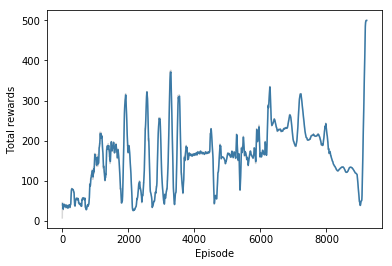

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

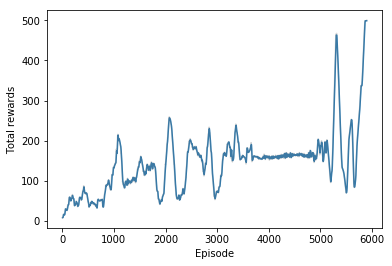

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

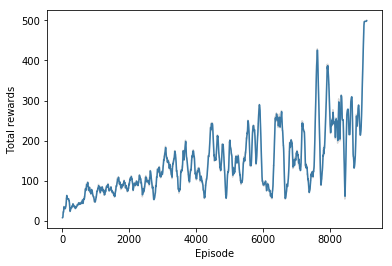

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

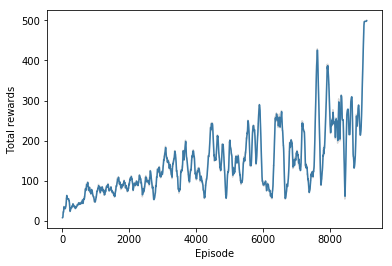

In [27]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

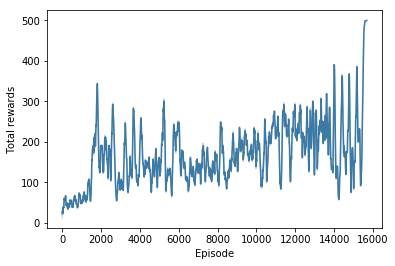

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

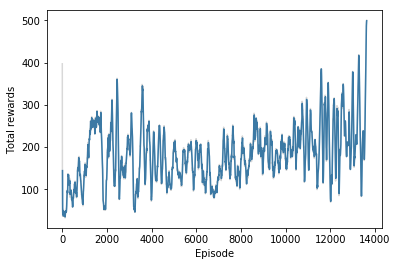

In [32]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

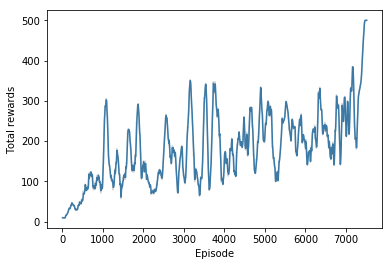

Text(0,0.5,'G losses')

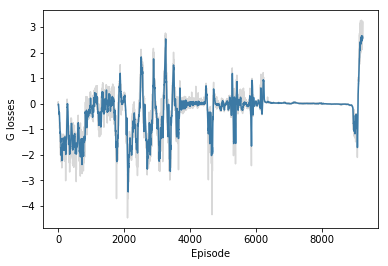

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

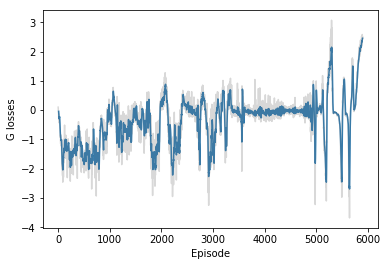

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

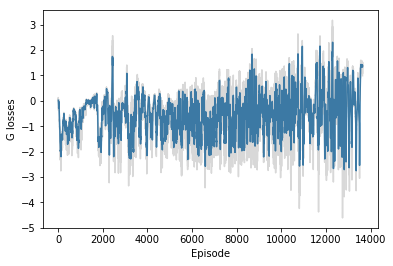

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

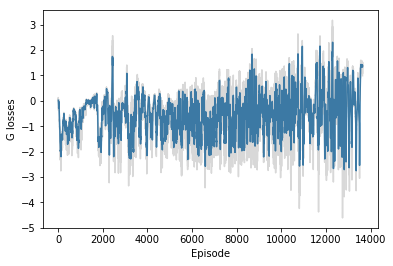

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

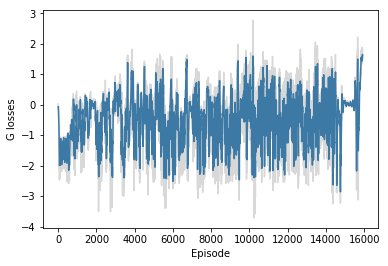
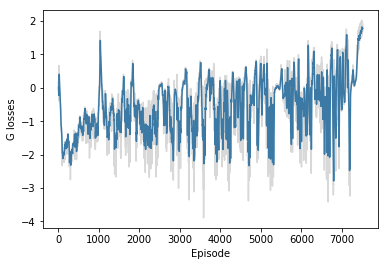

Text(0,0.5,'D losses')

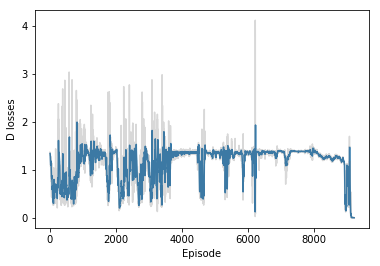

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

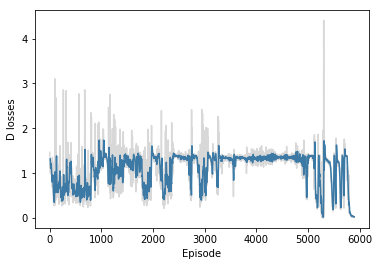

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

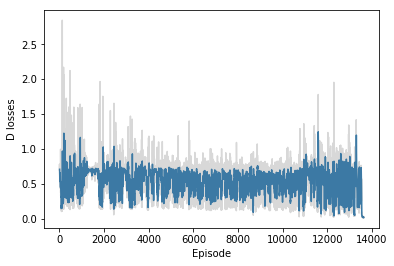

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

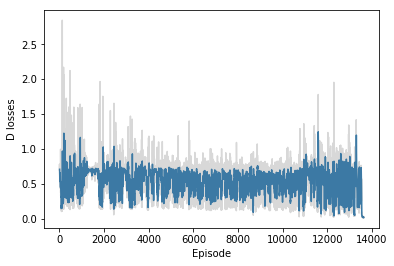

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

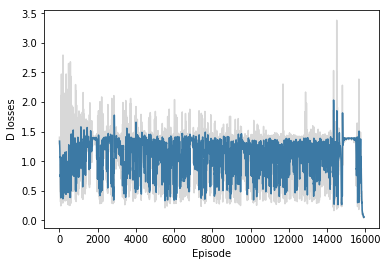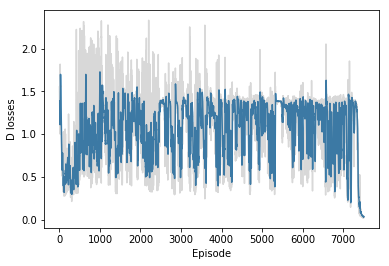

Text(0,0.5,'D losses R')

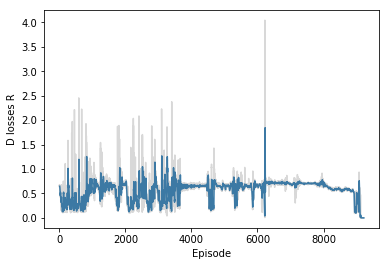

In [55]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

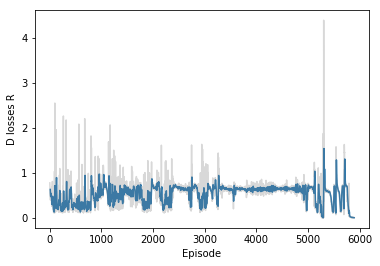

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

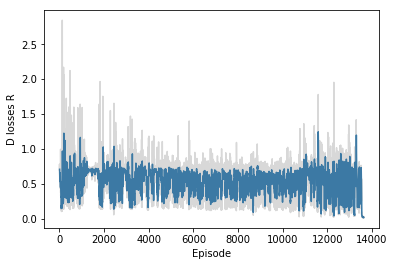

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

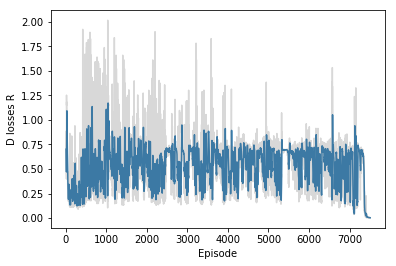

In [32]:
# eps, arr = np.array(d_lossR_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

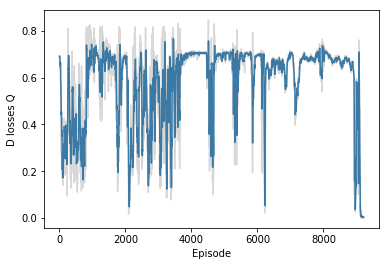

In [56]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

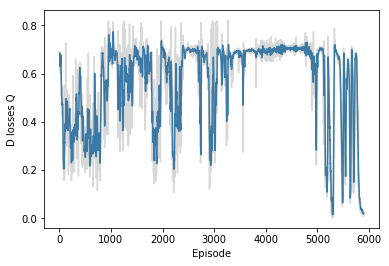

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

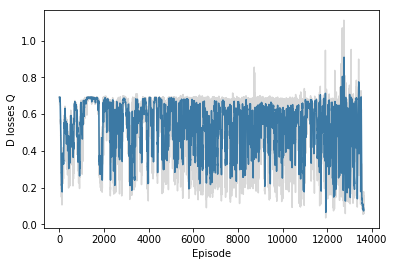

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

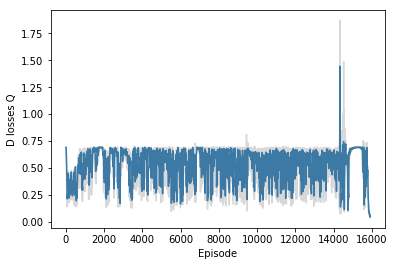

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

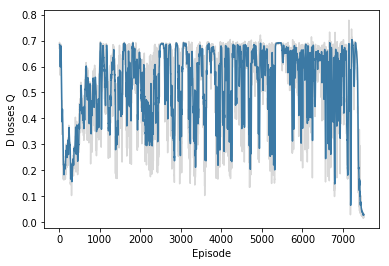

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.